## Module imports

In [1]:
import numpy as np
from keras import models, layers, optimizers, metrics, losses, regularizers
import img_util as util
from scipy import io as sio
import os
from matplotlib import pyplot as plt

In [2]:
import os
data_folder =os.path.join(os.getcwd(),'Datasets')
data_set = sio.loadmat(os.path.join(data_folder, 'WHU_Hi_HongHu.mat'))['WHU_Hi_HongHu']
gt = sio.loadmat(os.path.join(data_folder, 'WHU_Hi_HongHu_gt.mat'))['WHU_Hi_HongHu_gt']

# Checking the shape of data_set (containing image data) and gt (containing ground truth data) Numpy arrays.
print(data_set.shape ,gt.shape)

(940, 475, 270) (940, 475)


In [3]:
train_fraction = 0.75
rem_classes = [0]
(train_rows, train_cols), (test_rows, test_cols) = util.data_split(gt,
                                                                   train_fraction=train_fraction,
                                                                   rem_classes=rem_classes)

print('Number of training samples = {}.\nNumber of test samples = {}.'.format(len(train_rows), len(test_rows)))

Number of training samples = 290010.
Number of test samples = 96682.


A portion of training data can optionally be set aside for validation.

In [4]:
val_fraction = 0.05
from sklearn.model_selection import train_test_split
train_rows_sub, val_rows, train_cols_sub,val_cols = train_test_split(train_rows,train_cols, test_size=0.05, random_state=11)


In [5]:
print(len(train_rows_sub), len(val_rows), len(train_cols_sub),len(val_cols))

275509 14501 275509 14501


## Dimensionality reduction
The spectral dimension of an image dataset can be reduced using Principle Component Analysis (PCA). Although, this step is not necessary, it could significantly reduce the spectral dimension without losing important information. The 'reduce_dim' function takes the numpy array containing image data as its first argument and the number of reduced dimensions (i.e., an integer) or the minimum variance captured by PCA dimensions (i.e., a float) as the second argument.   

In [6]:
data_set = util.reduce_dim(img_data=data_set, n_components=.999)
data_set.shape


(940, 475, 71)

Using a value of 0.999 for the percentage of captured variance, the spectral dimension was reduced from 200 to 69 bands. The new dimensions were sorted according to their contribution to the dataset variance. The top 10 dimensions of transformed data are illustrated below.

<ipython-input-7-da220c44d18f>:1: MatplotlibDeprecationWarning: Passing the sharex parameter of subplots() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  fig, axes = plt.subplots(2,5, True, True, figsize=(15,7))


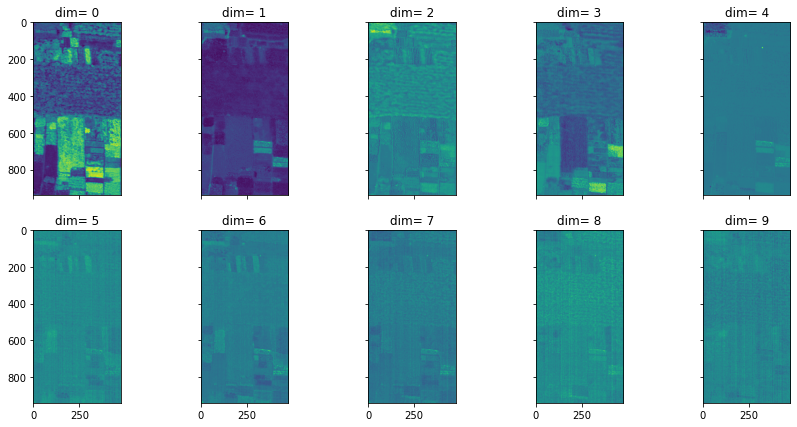

In [7]:
fig, axes = plt.subplots(2,5, True, True, figsize=(15,7))
for numb, axe in enumerate(axes.flat):
    axe.imshow(data_set[:,:,numb])
    axe.set_title('dim='+' '+str(numb))
    
fig.subplots_adjust(wspace=0, hspace=.2)
plt.show()

## Rescaling data
The 'rescale_data' function provides four methods for rescaling data at each spectral dimension. In this notebook, the 'standard' method which transforms the data to have zero mean and a standard deviation of 1 was used for rescaling data.

In [7]:
data_set = util.rescale_data(data_set)

## Creating input and target tensors
The input and target tensors should be compatible with the type of neural network model that is used for classification. The 'create_patch' function can create inputs, compatible to both pixel inputs for [MLP](deep_learning_MLP.ipynb) models as well as patch inputs for [2-D CNN](deep_learning_2D_CNN.ipynb) and [3-D CNN](deep_learning_3D_CNN.ipynb) models. 
In this notebook, a 2-D CNN model with a 'path_size' of 5 is used for classification.  

In [ ]:
patch_size=9
train_pixel_indices_sub = (train_rows_sub, train_cols_sub)
val_pixel_indices = (val_rows, val_cols)
test_pixel_indices = (test_rows, test_cols) 
catg_labels = np.unique([int(gt[idx[0],idx[1]]) for idx in zip(train_rows, train_cols)])
int_to_vector_dict = util.label_2_one_hot(catg_labels) 

train_input_sub, y_train_sub = util.create_patch(
        data_set=data_set,
        gt=gt,
        pixel_indices=train_pixel_indices_sub,
        patch_size=patch_size,
        label_vect_dict=int_to_vector_dict)

val_input, y_val = util.create_patch(
        data_set=data_set,
        gt=gt,
        pixel_indices=val_pixel_indices,
        patch_size=patch_size,
        label_vect_dict=int_to_vector_dict)

test_input, y_test = util.create_patch(
        data_set=data_set,
        gt=gt,
        pixel_indices=test_pixel_indices,
        patch_size=patch_size,
        label_vect_dict=int_to_vector_dict)



0
(609, 422)
1
(336, 196)
2
(350, 335)
3
(63, 330)
4
(931, 445)
5
(247, 319)
6
(578, 148)
7
(540, 303)
8
(323, 369)
9
(377, 311)
10
(218, 458)
11
(686, 254)
12
(899, 139)
13
(460, 388)
14
(830, 30)
15
(186, 326)
16
(26, 115)
17
(887, 385)
18
(479, 149)
19
(289, 57)
20
(86, 435)
21
(602, 121)
22
(913, 427)
23
(184, 210)
24
(197, 424)
25
(793, 436)
26
(787, 431)
27
(754, 37)
28
(681, 288)
29
(807, 426)
30
(918, 137)
31
(13, 372)
32
(400, 121)
33
(77, 451)
34
(132, 215)
35
(817, 313)
36
(302, 180)
37
(282, 370)
38
(455, 395)
39
(293, 104)
40
(376, 69)
41
(402, 450)
42
(641, 95)
43
(104, 304)
44
(615, 253)
45
(418, 166)
46
(515, 438)
47
(172, 77)
48
(826, 271)
49
(257, 9)
50
(847, 390)
51
(754, 367)
52
(595, 56)
53
(905, 180)
54
(370, 71)
55
(661, 353)
56
(197, 398)
57
(281, 435)
58
(372, 29)
59
(855, 157)
60
(681, 183)
61
(359, 188)
62
(657, 258)
63
(184, 82)
64
(112, 453)
65
(642, 459)
66
(265, 118)
67
(215, 297)
68
(613, 153)
69
(388, 415)
70
(555, 236)
71
(420, 463)
72
(150, 306)
73
(4

653
(898, 323)
654
(38, 127)
655
(770, 268)
656
(30, 131)
657
(845, 56)
658
(711, 343)
659
(725, 394)
660
(460, 439)
661
(937, 405)
662
(46, 33)
663
(926, 219)
664
(679, 242)
665
(263, 278)
666
(651, 420)
667
(724, 415)
668
(833, 289)
669
(370, 157)
670
(492, 61)
671
(464, 269)
672
(242, 63)
673
(698, 51)
674
(315, 221)
675
(320, 303)
676
(190, 157)
677
(213, 470)
678
(27, 463)
679
(761, 347)
680
(55, 297)
681
(405, 316)
682
(596, 220)
683
(572, 424)
684
(852, 389)
685
(645, 45)
686
(812, 469)
687
(59, 394)
688
(442, 271)
689
(401, 254)
690
(214, 152)
691
(583, 62)
692
(145, 449)
693
(554, 59)
694
(493, 367)
695
(459, 328)
696
(521, 222)
697
(339, 155)
698
(854, 204)
699
(720, 347)
700
(471, 429)
701
(363, 82)
702
(5, 71)
703
(512, 430)
704
(779, 95)
705
(401, 53)
706
(747, 437)
707
(769, 67)
708
(39, 124)
709
(722, 455)
710
(561, 394)
711
(394, 55)
712
(853, 251)
713
(571, 420)
714
(720, 372)
715
(589, 294)
716
(848, 41)
717
(642, 276)
718
(497, 44)
719
(497, 335)
720
(459, 37)
721
(8

1252
(771, 183)
1253
(818, 268)
1254
(147, 454)
1255
(536, 239)
1256
(369, 259)
1257
(588, 16)
1258
(811, 337)
1259
(651, 215)
1260
(54, 392)
1261
(518, 211)
1262
(823, 297)
1263
(877, 33)
1264
(594, 185)
1265
(542, 50)
1266
(375, 367)
1267
(562, 418)
1268
(440, 438)
1269
(831, 158)
1270
(422, 406)
1271
(435, 138)
1272
(245, 462)
1273
(49, 424)
1274
(330, 221)
1275
(357, 436)
1276
(170, 467)
1277
(328, 160)
1278
(56, 295)
1279
(856, 461)
1280
(929, 421)
1281
(545, 252)
1282
(554, 17)
1283
(270, 131)
1284
(314, 257)
1285
(395, 348)
1286
(871, 203)
1287
(452, 419)
1288
(205, 467)
1289
(211, 188)
1290
(447, 363)
1291
(383, 59)
1292
(667, 310)
1293
(647, 123)
1294
(133, 300)
1295
(53, 469)
1296
(728, 145)
1297
(168, 356)
1298
(917, 435)
1299
(490, 355)
1300
(657, 189)
1301
(459, 155)
1302
(389, 337)
1303
(757, 427)
1304
(864, 355)
1305
(777, 398)
1306
(756, 246)
1307
(248, 258)
1308
(855, 10)
1309
(27, 276)
1310
(334, 444)
1311
(670, 444)
1312
(931, 290)
1313
(765, 114)
1314
(682, 90)
1315

1857
(458, 270)
1858
(449, 199)
1859
(840, 58)
1860
(787, 251)
1861
(358, 315)
1862
(745, 285)
1863
(18, 440)
1864
(289, 339)
1865
(287, 303)
1866
(423, 51)
1867
(705, 374)
1868
(425, 343)
1869
(315, 471)
1870
(370, 227)
1871
(688, 20)
1872
(641, 124)
1873
(149, 83)
1874
(632, 469)
1875
(403, 105)
1876
(733, 225)
1877
(841, 443)
1878
(655, 39)
1879
(457, 427)
1880
(750, 189)
1881
(314, 252)
1882
(914, 467)
1883
(351, 432)
1884
(733, 306)
1885
(203, 418)
1886
(886, 410)
1887
(299, 470)
1888
(494, 204)
1889
(151, 305)
1890
(651, 144)
1891
(321, 212)
1892
(780, 4)
1893
(217, 261)
1894
(248, 165)
1895
(633, 104)
1896
(646, 126)
1897
(870, 441)
1898
(886, 305)
1899
(252, 219)
1900
(212, 441)
1901
(189, 77)
1902
(644, 195)
1903
(366, 18)
1904
(890, 428)
1905
(585, 398)
1906
(317, 23)
1907
(635, 233)
1908
(762, 415)
1909
(782, 101)
1910
(791, 334)
1911
(158, 99)
1912
(435, 257)
1913
(304, 351)
1914
(530, 409)
1915
(766, 196)
1916
(287, 169)
1917
(526, 404)
1918
(825, 68)
1919
(309, 58)
1920
(

2425
(805, 19)
2426
(169, 169)
2427
(576, 428)
2428
(788, 333)
2429
(660, 328)
2430
(568, 417)
2431
(497, 323)
2432
(441, 459)
2433
(636, 163)
2434
(277, 274)
2435
(706, 191)
2436
(856, 234)
2437
(854, 456)
2438
(281, 379)
2439
(43, 30)
2440
(852, 321)
2441
(780, 405)
2442
(54, 459)
2443
(452, 217)
2444
(177, 97)
2445
(138, 57)
2446
(615, 429)
2447
(938, 411)
2448
(105, 9)
2449
(284, 354)
2450
(442, 431)
2451
(167, 229)
2452
(752, 171)
2453
(856, 183)
2454
(895, 317)
2455
(486, 136)
2456
(390, 235)
2457
(830, 139)
2458
(191, 265)
2459
(783, 90)
2460
(64, 343)
2461
(882, 395)
2462
(76, 40)
2463
(259, 419)
2464
(31, 221)
2465
(468, 453)
2466
(696, 158)
2467
(646, 222)
2468
(61, 462)
2469
(391, 154)
2470
(409, 223)
2471
(740, 316)
2472
(666, 318)
2473
(319, 257)
2474
(416, 414)
2475
(522, 42)
2476
(64, 408)
2477
(15, 123)
2478
(855, 251)
2479
(886, 165)
2480
(573, 38)
2481
(491, 266)
2482
(682, 119)
2483
(261, 271)
2484
(279, 278)
2485
(304, 428)
2486
(737, 437)
2487
(635, 327)
2488
(185,

3047
(769, 155)
3048
(810, 159)
3049
(110, 349)
3050
(189, 301)
3051
(213, 328)
3052
(919, 19)
3053
(212, 236)
3054
(892, 159)
3055
(278, 310)
3056
(584, 178)
3057
(678, 233)
3058
(322, 74)
3059
(305, 448)
3060
(256, 214)
3061
(765, 160)
3062
(566, 264)
3063
(450, 70)
3064
(432, 283)
3065
(891, 339)
3066
(910, 289)
3067
(292, 417)
3068
(407, 387)
3069
(914, 418)
3070
(566, 82)
3071
(268, 330)
3072
(454, 422)
3073
(253, 71)
3074
(209, 409)
3075
(731, 170)
3076
(249, 110)
3077
(929, 234)
3078
(234, 364)
3079
(69, 241)
3080
(723, 435)
3081
(80, 36)
3082
(493, 30)
3083
(252, 155)
3084
(598, 207)
3085
(554, 122)
3086
(918, 165)
3087
(269, 21)
3088
(860, 377)
3089
(532, 167)
3090
(697, 445)
3091
(286, 221)
3092
(479, 445)
3093
(131, 114)
3094
(309, 469)
3095
(393, 145)
3096
(776, 12)
3097
(739, 52)
3098
(143, 300)
3099
(162, 59)
3100
(332, 353)
3101
(837, 347)
3102
(117, 418)
3103
(883, 107)
3104
(286, 258)
3105
(698, 286)
3106
(68, 302)
3107
(579, 339)
3108
(292, 316)
3109
(145, 270)
3110
(

3724
(199, 306)
3725
(898, 14)
3726
(633, 229)
3727
(262, 222)
3728
(23, 251)
3729
(124, 267)
3730
(720, 440)
3731
(771, 349)
3732
(553, 456)
3733
(548, 21)
3734
(648, 471)
3735
(396, 463)
3736
(920, 160)
3737
(439, 180)
3738
(236, 403)
3739
(358, 245)
3740
(833, 250)
3741
(780, 115)
3742
(892, 179)
3743
(325, 392)
3744
(709, 144)
3745
(807, 106)
3746
(425, 110)
3747
(363, 120)
3748
(331, 159)
3749
(530, 218)
3750
(290, 317)
3751
(86, 413)
3752
(470, 236)
3753
(299, 4)
3754
(344, 283)
3755
(270, 295)
3756
(448, 114)
3757
(287, 462)
3758
(472, 472)
3759
(244, 243)
3760
(836, 100)
3761
(891, 284)
3762
(661, 78)
3763
(872, 407)
3764
(524, 61)
3765
(332, 13)
3766
(643, 254)
3767
(354, 377)
3768
(552, 231)
3769
(252, 222)
3770
(739, 213)
3771
(174, 174)
3772
(925, 385)
3773
(435, 314)
3774
(472, 383)
3775
(350, 157)
3776
(817, 283)
3777
(187, 58)
3778
(613, 229)
3779
(792, 87)
3780
(112, 303)
3781
(769, 402)
3782
(440, 7)
3783
(826, 29)
3784
(398, 364)
3785
(233, 369)
3786
(861, 469)
3787
(

4307
(476, 281)
4308
(938, 328)
4309
(59, 24)
4310
(473, 223)
4311
(72, 441)
4312
(636, 196)
4313
(815, 289)
4314
(602, 303)
4315
(193, 426)
4316
(553, 29)
4317
(173, 369)
4318
(436, 374)
4319
(872, 106)
4320
(936, 454)
4321
(613, 116)
4322
(257, 323)
4323
(336, 388)
4324
(454, 206)
4325
(251, 430)
4326
(385, 128)
4327
(469, 382)
4328
(453, 406)
4329
(479, 233)
4330
(219, 247)
4331
(875, 49)
4332
(229, 296)
4333
(757, 334)
4334
(150, 277)
4335
(120, 455)
4336
(122, 213)
4337
(776, 235)
4338
(123, 414)
4339
(362, 215)
4340
(492, 74)
4341
(910, 351)
4342
(624, 203)
4343
(566, 265)
4344
(114, 343)
4345
(432, 291)
4346
(540, 118)
4347
(500, 323)
4348
(122, 203)
4349
(677, 73)
4350
(281, 140)
4351
(595, 464)
4352
(272, 200)
4353
(711, 290)
4354
(856, 16)
4355
(937, 423)
4356
(19, 382)
4357
(925, 78)
4358
(617, 456)
4359
(776, 337)
4360
(616, 338)
4361
(486, 437)
4362
(53, 233)
4363
(738, 203)
4364
(783, 70)
4365
(464, 321)
4366
(53, 470)
4367
(759, 26)
4368
(809, 316)
4369
(92, 344)
4370
(7

(907, 131)
4948
(698, 245)
4949
(749, 308)
4950
(640, 356)
4951
(240, 164)
4952
(8, 235)
4953
(446, 46)
4954
(65, 441)
4955
(814, 163)
4956
(672, 275)
4957
(763, 208)
4958
(517, 474)
4959
(842, 329)
4960
(297, 188)
4961
(655, 85)
4962
(722, 324)
4963
(692, 184)
4964
(605, 414)
4965
(890, 217)
4966
(571, 126)
4967
(657, 306)
4968
(857, 32)
4969
(566, 197)
4970
(533, 239)
4971
(498, 251)
4972
(66, 65)
4973
(62, 93)
4974
(105, 360)
4975
(836, 101)
4976
(841, 271)
4977
(456, 373)
4978
(419, 440)
4979
(896, 325)
4980
(176, 423)
4981
(476, 438)
4982
(343, 4)
4983
(614, 253)
4984
(622, 372)
4985
(249, 219)
4986
(851, 405)
4987
(122, 426)
4988
(567, 302)
4989
(359, 344)
4990
(155, 236)
4991
(731, 199)
4992
(856, 66)
4993
(605, 291)
4994
(203, 179)
4995
(862, 85)
4996
(716, 272)
4997
(315, 310)
4998
(592, 354)
4999
(550, 154)
5000
(129, 237)
5001
(36, 18)
5002
(31, 378)
5003
(269, 252)
5004
(681, 222)
5005
(204, 390)
5006
(489, 126)
5007
(526, 375)
5008
(372, 464)
5009
(19, 11)
5010
(383, 320)


5530
(752, 266)
5531
(826, 229)
5532
(484, 50)
5533
(238, 456)
5534
(48, 288)
5535
(31, 58)
5536
(818, 230)
5537
(603, 379)
5538
(215, 219)
5539
(6, 257)
5540
(436, 193)
5541
(772, 286)
5542
(579, 444)
5543
(759, 146)
5544
(403, 127)
5545
(681, 402)
5546
(195, 348)
5547
(266, 121)
5548
(301, 347)
5549
(331, 142)
5550
(7, 45)
5551
(811, 111)
5552
(453, 205)
5553
(370, 311)
5554
(789, 319)
5555
(785, 186)
5556
(919, 268)
5557
(662, 85)
5558
(492, 224)
5559
(299, 46)
5560
(732, 210)
5561
(668, 160)
5562
(306, 311)
5563
(164, 36)
5564
(584, 52)
5565
(468, 462)
5566
(245, 147)
5567
(14, 81)
5568
(62, 379)
5569
(547, 48)
5570
(536, 74)
5571
(923, 219)
5572
(801, 94)
5573
(904, 96)
5574
(179, 461)
5575
(180, 305)
5576
(97, 381)
5577
(896, 242)
5578
(352, 469)
5579
(769, 309)
5580
(450, 180)
5581
(393, 38)
5582
(589, 94)
5583
(315, 161)
5584
(45, 423)
5585
(887, 331)
5586
(365, 43)
5587
(732, 298)
5588
(471, 2)
5589
(711, 298)
5590
(694, 289)
5591
(878, 230)
5592
(727, 305)
5593
(618, 417)
559

6139
(539, 48)
6140
(245, 108)
6141
(488, 464)
6142
(290, 464)
6143
(868, 113)
6144
(58, 231)
6145
(69, 398)
6146
(400, 87)
6147
(79, 126)
6148
(688, 333)
6149
(656, 115)
6150
(331, 236)
6151
(51, 52)
6152
(474, 61)
6153
(310, 129)
6154
(488, 189)
6155
(791, 466)
6156
(730, 421)
6157
(546, 154)
6158
(684, 329)
6159
(374, 345)
6160
(818, 45)
6161
(752, 265)
6162
(446, 209)
6163
(763, 156)
6164
(503, 71)
6165
(704, 27)
6166
(926, 263)
6167
(659, 99)
6168
(892, 350)
6169
(368, 328)
6170
(186, 362)
6171
(739, 262)
6172
(846, 350)
6173
(342, 451)
6174
(507, 300)
6175
(786, 72)
6176
(149, 318)
6177
(188, 104)
6178
(123, 124)
6179
(525, 311)
6180
(910, 125)
6181
(559, 244)
6182
(40, 423)
6183
(375, 130)
6184
(10, 316)
6185
(243, 25)
6186
(198, 200)
6187
(274, 430)
6188
(49, 193)
6189
(607, 120)
6190
(339, 110)
6191
(276, 168)
6192
(707, 333)
6193
(76, 413)
6194
(891, 333)
6195
(135, 366)
6196
(112, 282)
6197
(330, 126)
6198
(318, 399)
6199
(426, 28)
6200
(586, 146)
6201
(416, 386)
6202
(460, 

6845
(406, 114)
6846
(662, 208)
6847
(707, 98)
6848
(206, 248)
6849
(431, 306)
6850
(283, 193)
6851
(148, 95)
6852
(356, 66)
6853
(441, 242)
6854
(703, 354)
6855
(457, 197)
6856
(122, 286)
6857
(436, 2)
6858
(597, 277)
6859
(741, 156)
6860
(312, 298)
6861
(250, 446)
6862
(422, 114)
6863
(812, 460)
6864
(233, 187)
6865
(485, 354)
6866
(644, 134)
6867
(452, 39)
6868
(865, 43)
6869
(324, 344)
6870
(507, 302)
6871
(433, 446)
6872
(693, 177)
6873
(292, 286)
6874
(461, 456)
6875
(452, 85)
6876
(298, 48)
6877
(183, 263)
6878
(331, 319)
6879
(608, 136)
6880
(600, 85)
6881
(497, 110)
6882
(435, 219)
6883
(619, 373)
6884
(711, 26)
6885
(379, 386)
6886
(769, 137)
6887
(354, 104)
6888
(92, 211)
6889
(771, 193)
6890
(251, 13)
6891
(561, 151)
6892
(842, 26)
6893
(894, 254)
6894
(910, 256)
6895
(292, 168)
6896
(901, 377)
6897
(807, 68)
6898
(513, 391)
6899
(36, 440)
6900
(917, 219)
6901
(167, 199)
6902
(421, 376)
6903
(445, 93)
6904
(296, 430)
6905
(495, 92)
6906
(258, 86)
6907
(310, 167)
6908
(189, 

7399
(709, 236)
7400
(556, 423)
7401
(528, 348)
7402
(850, 233)
7403
(457, 409)
7404
(22, 264)
7405
(766, 469)
7406
(327, 442)
7407
(684, 80)
7408
(911, 352)
7409
(90, 343)
7410
(864, 445)
7411
(111, 219)
7412
(822, 194)
7413
(936, 209)
7414
(332, 127)
7415
(814, 249)
7416
(358, 395)
7417
(273, 136)
7418
(115, 289)
7419
(923, 451)
7420
(216, 359)
7421
(305, 38)
7422
(571, 419)
7423
(591, 167)
7424
(282, 405)
7425
(69, 84)
7426
(308, 439)
7427
(794, 290)
7428
(495, 40)
7429
(734, 35)
7430
(0, 137)
7431
(698, 345)
7432
(416, 43)
7433
(215, 332)
7434
(849, 22)
7435
(154, 79)
7436
(554, 21)
7437
(647, 106)
7438
(527, 213)
7439
(712, 43)
7440
(574, 463)
7441
(676, 272)
7442
(494, 157)
7443
(156, 111)
7444
(535, 320)
7445
(454, 376)
7446
(759, 362)
7447
(458, 113)
7448
(330, 142)
7449
(396, 262)
7450
(141, 68)
7451
(394, 205)
7452
(628, 258)
7453
(59, 87)
7454
(70, 446)
7455
(576, 408)
7456
(912, 140)
7457
(641, 357)
7458
(758, 230)
7459
(643, 162)
7460
(16, 274)
7461
(486, 219)
7462
(21, 30

7951
(846, 86)
7952
(607, 344)
7953
(707, 230)
7954
(858, 459)
7955
(579, 45)
7956
(428, 222)
7957
(399, 128)
7958
(761, 212)
7959
(525, 406)
7960
(596, 212)
7961
(56, 99)
7962
(574, 432)
7963
(174, 368)
7964
(181, 90)
7965
(345, 457)
7966
(565, 343)
7967
(934, 343)
7968
(761, 149)
7969
(630, 117)
7970
(423, 377)
7971
(907, 251)
7972
(805, 118)
7973
(557, 187)
7974
(464, 214)
7975
(101, 456)
7976
(504, 403)
7977
(886, 441)
7978
(841, 278)
7979
(657, 360)
7980
(299, 200)
7981
(272, 244)
7982
(18, 117)
7983
(160, 234)
7984
(650, 433)
7985
(52, 294)
7986
(801, 351)
7987
(482, 118)
7988
(218, 455)
7989
(355, 191)
7990
(468, 43)
7991
(451, 129)
7992
(907, 401)
7993
(293, 254)
7994
(274, 323)
7995
(37, 121)
7996
(25, 446)
7997
(630, 290)
7998
(494, 442)
7999
(260, 222)
8000
(88, 332)
8001
(678, 12)
8002
(906, 4)
8003
(648, 198)
8004
(834, 344)
8005
(466, 340)
8006
(51, 365)
8007
(266, 429)
8008
(318, 206)
8009
(342, 97)
8010
(381, 65)
8011
(765, 188)
8012
(303, 350)
8013
(375, 158)
8014
(789

8733
(366, 443)
8734
(841, 181)
8735
(189, 309)
8736
(354, 258)
8737
(175, 258)
8738
(936, 290)
8739
(592, 112)
8740
(130, 328)
8741
(567, 172)
8742
(314, 372)
8743
(448, 296)
8744
(223, 390)
8745
(232, 431)
8746
(237, 241)
8747
(494, 126)
8748
(795, 421)
8749
(435, 129)
8750
(470, 332)
8751
(578, 436)
8752
(641, 80)
8753
(206, 340)
8754
(374, 190)
8755
(323, 396)
8756
(596, 468)
8757
(736, 88)
8758
(524, 32)
8759
(196, 92)
8760
(821, 368)
8761
(470, 425)
8762
(126, 169)
8763
(669, 338)
8764
(728, 76)
8765
(612, 362)
8766
(71, 42)
8767
(214, 190)
8768
(137, 432)
8769
(590, 244)
8770
(190, 236)
8771
(595, 321)
8772
(247, 37)
8773
(665, 325)
8774
(886, 321)
8775
(455, 112)
8776
(12, 298)
8777
(358, 132)
8778
(830, 255)
8779
(322, 441)
8780
(786, 225)
8781
(409, 4)
8782
(432, 393)
8783
(655, 417)
8784
(136, 428)
8785
(72, 368)
8786
(479, 104)
8787
(834, 306)
8788
(83, 43)
8789
(715, 177)
8790
(664, 276)
8791
(185, 307)
8792
(749, 206)
8793
(661, 373)
8794
(573, 58)
8795
(764, 302)
8796
(4

9333
(345, 151)
9334
(905, 287)
9335
(416, 77)
9336
(851, 264)
9337
(149, 286)
9338
(626, 301)
9339
(723, 98)
9340
(441, 409)
9341
(462, 53)
9342
(870, 70)
9343
(97, 416)
9344
(903, 71)
9345
(727, 370)
9346
(489, 150)
9347
(726, 331)
9348
(543, 456)
9349
(559, 459)
9350
(539, 169)
9351
(923, 363)
9352
(245, 441)
9353
(559, 175)
9354
(743, 374)
9355
(743, 250)
9356
(644, 22)
9357
(300, 403)
9358
(672, 143)
9359
(544, 471)
9360
(878, 251)
9361
(82, 130)
9362
(322, 400)
9363
(460, 383)
9364
(717, 227)
9365
(889, 9)
9366
(225, 200)
9367
(839, 18)
9368
(386, 311)
9369
(50, 425)
9370
(260, 372)
9371
(61, 266)
9372
(597, 272)
9373
(342, 8)
9374
(66, 207)
9375
(610, 47)
9376
(62, 173)
9377
(653, 399)
9378
(720, 397)
9379
(617, 103)
9380
(591, 423)
9381
(88, 453)
9382
(304, 253)
9383
(862, 358)
9384
(149, 58)
9385
(764, 160)
9386
(923, 65)
9387
(65, 22)
9388
(307, 414)
9389
(505, 339)
9390
(770, 96)
9391
(574, 249)
9392
(925, 339)
9393
(467, 30)
9394
(355, 166)
9395
(453, 256)
9396
(636, 437)
9

10024
(77, 306)
10025
(504, 33)
10026
(38, 377)
10027
(159, 455)
10028
(855, 111)
10029
(706, 15)
10030
(798, 69)
10031
(79, 410)
10032
(618, 425)
10033
(381, 168)
10034
(345, 444)
10035
(891, 219)
10036
(37, 295)
10037
(674, 125)
10038
(845, 446)
10039
(38, 82)
10040
(866, 61)
10041
(713, 233)
10042
(761, 423)
10043
(239, 330)
10044
(470, 241)
10045
(826, 290)
10046
(557, 69)
10047
(154, 198)
10048
(683, 303)
10049
(691, 302)
10050
(111, 463)
10051
(853, 468)
10052
(45, 470)
10053
(498, 347)
10054
(491, 10)
10055
(892, 262)
10056
(698, 261)
10057
(131, 325)
10058
(272, 165)
10059
(701, 315)
10060
(628, 55)
10061
(465, 100)
10062
(256, 435)
10063
(226, 465)
10064
(718, 89)
10065
(302, 378)
10066
(490, 130)
10067
(913, 448)
10068
(528, 136)
10069
(938, 217)
10070
(711, 202)
10071
(938, 469)
10072
(791, 27)
10073
(754, 6)
10074
(796, 454)
10075
(386, 412)
10076
(51, 304)
10077
(445, 312)
10078
(346, 276)
10079
(329, 155)
10080
(292, 89)
10081
(181, 227)
10082
(857, 5)
10083
(819, 345)
10

(861, 207)
10536
(740, 119)
10537
(390, 72)
10538
(330, 16)
10539
(697, 325)
10540
(269, 318)
10541
(55, 90)
10542
(926, 100)
10543
(696, 161)
10544
(648, 143)
10545
(290, 150)
10546
(775, 119)
10547
(285, 51)
10548
(351, 449)
10549
(413, 353)
10550
(669, 59)
10551
(235, 193)
10552
(162, 197)
10553
(331, 43)
10554
(237, 368)
10555
(487, 387)
10556
(297, 328)
10557
(460, 30)
10558
(142, 129)
10559
(793, 86)
10560
(360, 100)
10561
(622, 431)
10562
(53, 45)
10563
(280, 126)
10564
(675, 432)
10565
(287, 142)
10566
(425, 225)
10567
(740, 140)
10568
(29, 268)
10569
(174, 453)
10570
(247, 337)
10571
(563, 429)
10572
(647, 288)
10573
(207, 195)
10574
(337, 297)
10575
(244, 273)
10576
(332, 405)
10577
(656, 12)
10578
(385, 99)
10579
(307, 154)
10580
(60, 49)
10581
(788, 28)
10582
(397, 71)
10583
(571, 349)
10584
(228, 236)
10585
(567, 275)
10586
(781, 181)
10587
(378, 12)
10588
(565, 200)
10589
(97, 19)
10590
(722, 306)
10591
(648, 407)
10592
(76, 414)
10593
(256, 14)
10594
(74, 78)
10595
(546,

11048
(801, 178)
11049
(61, 189)
11050
(469, 433)
11051
(519, 49)
11052
(799, 430)
11053
(310, 451)
11054
(129, 271)
11055
(450, 301)
11056
(634, 375)
11057
(739, 54)
11058
(368, 223)
11059
(15, 136)
11060
(678, 469)
11061
(848, 151)
11062
(556, 442)
11063
(499, 417)
11064
(424, 56)
11065
(277, 293)
11066
(935, 315)
11067
(481, 347)
11068
(333, 381)
11069
(871, 455)
11070
(561, 168)
11071
(355, 324)
11072
(158, 419)
11073
(431, 206)
11074
(497, 211)
11075
(576, 409)
11076
(470, 306)
11077
(449, 295)
11078
(45, 458)
11079
(860, 412)
11080
(785, 264)
11081
(775, 437)
11082
(157, 391)
11083
(260, 137)
11084
(321, 73)
11085
(144, 68)
11086
(270, 161)
11087
(196, 473)
11088
(733, 141)
11089
(638, 27)
11090
(245, 111)
11091
(238, 318)
11092
(766, 147)
11093
(567, 171)
11094
(736, 360)
11095
(361, 132)
11096
(252, 436)
11097
(169, 210)
11098
(171, 369)
11099
(611, 146)
11100
(293, 380)
11101
(411, 351)
11102
(287, 359)
11103
(578, 203)
11104
(718, 52)
11105
(162, 22)
11106
(476, 115)
11107
(2

11572
(448, 83)
11573
(55, 230)
11574
(837, 256)
11575
(402, 154)
11576
(623, 455)
11577
(773, 150)
11578
(469, 393)
11579
(252, 39)
11580
(243, 44)
11581
(856, 136)
11582
(369, 272)
11583
(253, 316)
11584
(910, 30)
11585
(193, 102)
11586
(663, 98)
11587
(836, 364)
11588
(552, 449)
11589
(245, 364)
11590
(684, 165)
11591
(456, 455)
11592
(178, 471)
11593
(360, 235)
11594
(353, 353)
11595
(252, 81)
11596
(65, 235)
11597
(567, 226)
11598
(192, 390)
11599
(749, 449)
11600
(31, 352)
11601
(370, 164)
11602
(682, 438)
11603
(456, 329)
11604
(251, 51)
11605
(129, 186)
11606
(856, 211)
11607
(889, 226)
11608
(124, 280)
11609
(493, 36)
11610
(872, 417)
11611
(173, 341)
11612
(456, 99)
11613
(66, 330)
11614
(433, 186)
11615
(739, 247)
11616
(23, 50)
11617
(68, 78)
11618
(581, 173)
11619
(921, 298)
11620
(20, 35)
11621
(322, 194)
11622
(628, 259)
11623
(615, 390)
11624
(803, 392)
11625
(134, 83)
11626
(836, 387)
11627
(697, 196)
11628
(631, 337)
11629
(274, 155)
11630
(831, 322)
11631
(392, 336)


12131
(751, 437)
12132
(914, 40)
12133
(204, 220)
12134
(319, 214)
12135
(20, 295)
12136
(121, 454)
12137
(78, 249)
12138
(289, 19)
12139
(656, 79)
12140
(712, 463)
12141
(398, 369)
12142
(443, 450)
12143
(555, 19)
12144
(77, 147)
12145
(791, 445)
12146
(581, 171)
12147
(27, 433)
12148
(679, 253)
12149
(696, 306)
12150
(122, 195)
12151
(170, 322)
12152
(613, 26)
12153
(743, 241)
12154
(94, 340)
12155
(886, 79)
12156
(428, 408)
12157
(113, 382)
12158
(274, 97)
12159
(698, 165)
12160
(272, 354)
12161
(67, 461)
12162
(681, 452)
12163
(706, 183)
12164
(254, 299)
12165
(465, 474)
12166
(429, 150)
12167
(699, 457)
12168
(904, 311)
12169
(904, 65)
12170
(923, 57)
12171
(236, 397)
12172
(636, 467)
12173
(391, 214)
12174
(280, 285)
12175
(187, 347)
12176
(55, 424)
12177
(373, 448)
12178
(317, 465)
12179
(921, 191)
12180
(485, 324)
12181
(57, 255)
12182
(301, 71)
12183
(12, 51)
12184
(815, 354)
12185
(527, 360)
12186
(400, 228)
12187
(238, 230)
12188
(479, 61)
12189
(782, 99)
12190
(85, 375)
121

12663
(255, 297)
12664
(818, 254)
12665
(623, 317)
12666
(604, 113)
12667
(297, 374)
12668
(67, 168)
12669
(723, 193)
12670
(331, 152)
12671
(182, 418)
12672
(420, 71)
12673
(53, 257)
12674
(663, 240)
12675
(382, 381)
12676
(70, 318)
12677
(485, 307)
12678
(193, 386)
12679
(552, 61)
12680
(374, 274)
12681
(341, 176)
12682
(443, 369)
12683
(931, 431)
12684
(422, 214)
12685
(311, 6)
12686
(466, 64)
12687
(557, 312)
12688
(331, 230)
12689
(125, 256)
12690
(49, 103)
12691
(900, 64)
12692
(744, 61)
12693
(282, 310)
12694
(197, 218)
12695
(177, 302)
12696
(446, 65)
12697
(401, 240)
12698
(13, 383)
12699
(853, 249)
12700
(545, 93)
12701
(616, 349)
12702
(608, 449)
12703
(419, 86)
12704
(7, 321)
12705
(342, 409)
12706
(81, 467)
12707
(881, 196)
12708
(608, 341)
12709
(754, 406)
12710
(724, 181)
12711
(87, 32)
12712
(646, 94)
12713
(726, 371)
12714
(216, 169)
12715
(193, 220)
12716
(119, 234)
12717
(38, 269)
12718
(177, 216)
12719
(602, 266)
12720
(300, 469)
12721
(54, 316)
12722
(774, 182)
127

13222
(268, 219)
13223
(579, 178)
13224
(498, 99)
13225
(105, 236)
13226
(541, 466)
13227
(435, 180)
13228
(204, 473)
13229
(238, 465)
13230
(45, 88)
13231
(373, 471)
13232
(573, 57)
13233
(120, 333)
13234
(169, 265)
13235
(539, 100)
13236
(862, 80)
13237
(413, 474)
13238
(70, 93)
13239
(381, 77)
13240
(362, 378)
13241
(687, 444)
13242
(151, 367)
13243
(893, 91)
13244
(697, 101)
13245
(465, 93)
13246
(243, 426)
13247
(100, 217)
13248
(371, 270)
13249
(70, 433)
13250
(599, 259)
13251
(309, 37)
13252
(147, 459)
13253
(225, 466)
13254
(456, 213)
13255
(936, 367)
13256
(563, 381)
13257
(659, 338)
13258
(660, 408)
13259
(466, 80)
13260
(133, 50)
13261
(310, 369)
13262
(848, 160)
13263
(937, 265)
13264
(154, 456)
13265
(158, 393)
13266
(912, 84)
13267
(67, 424)
13268
(475, 216)
13269
(451, 420)
13270
(397, 436)
13271
(462, 309)
13272
(819, 274)
13273
(812, 24)
13274
(621, 202)
13275
(792, 83)
13276
(270, 346)
13277
(543, 352)
13278
(351, 319)
13279
(461, 200)
13280
(562, 436)
13281
(538, 213

13821
(549, 202)
13822
(147, 464)
13823
(125, 339)
13824
(148, 412)
13825
(590, 426)
13826
(800, 311)
13827
(693, 373)
13828
(83, 135)
13829
(170, 290)
13830
(567, 450)
13831
(645, 417)
13832
(186, 332)
13833
(322, 139)
13834
(417, 294)
13835
(148, 444)
13836
(284, 472)
13837
(278, 198)
13838
(764, 87)
13839
(407, 144)
13840
(644, 44)
13841
(140, 111)
13842
(750, 292)
13843
(462, 241)
13844
(467, 82)
13845
(458, 442)
13846
(697, 311)
13847
(300, 116)
13848
(318, 458)
13849
(811, 42)
13850
(498, 4)
13851
(902, 144)
13852
(128, 213)
13853
(546, 166)
13854
(882, 166)
13855
(823, 341)
13856
(135, 334)
13857
(380, 243)
13858
(481, 405)
13859
(252, 421)
13860
(499, 348)
13861
(813, 453)
13862
(545, 20)
13863
(827, 157)
13864
(804, 75)
13865
(715, 372)
13866
(669, 469)
13867
(757, 290)
13868
(650, 447)
13869
(289, 390)
13870
(695, 237)
13871
(904, 328)
13872
(74, 276)
13873
(8, 323)
13874
(479, 170)
13875
(789, 121)
13876
(816, 182)
13877
(749, 183)
13878
(880, 272)
13879
(12, 375)
13880
(486

14449
(793, 423)
14450
(711, 99)
14451
(144, 272)
14452
(202, 360)
14453
(35, 427)
14454
(906, 452)
14455
(439, 270)
14456
(679, 239)
14457
(578, 192)
14458
(427, 70)
14459
(396, 24)
14460
(711, 207)
14461
(640, 181)
14462
(723, 373)
14463
(95, 362)
14464
(513, 382)
14465
(701, 43)
14466
(470, 84)
14467
(595, 162)
14468
(870, 452)
14469
(209, 468)
14470
(430, 120)
14471
(317, 35)
14472
(646, 263)
14473
(371, 386)
14474
(769, 213)
14475
(630, 138)
14476
(849, 7)
14477
(432, 405)
14478
(626, 159)
14479
(621, 457)
14480
(599, 444)
14481
(902, 460)
14482
(318, 288)
14483
(853, 14)
14484
(578, 314)
14485
(443, 90)
14486
(748, 37)
14487
(816, 419)
14488
(912, 33)
14489
(294, 317)
14490
(17, 418)
14491
(528, 445)
14492
(665, 473)
14493
(450, 465)
14494
(6, 300)
14495
(480, 452)
14496
(556, 102)
14497
(737, 123)
14498
(38, 387)
14499
(632, 412)
14500
(313, 189)
14501
(152, 94)
14502
(548, 73)
14503
(17, 52)
14504
(328, 123)
14505
(840, 343)
14506
(45, 461)
14507
(869, 332)
14508
(434, 21)
1450

(205, 93)
15007
(407, 23)
15008
(926, 107)
15009
(68, 317)
15010
(391, 271)
15011
(302, 131)
15012
(831, 463)
15013
(389, 195)
15014
(446, 111)
15015
(381, 418)
15016
(692, 467)
15017
(720, 234)
15018
(705, 297)
15019
(830, 287)
15020
(46, 243)
15021
(237, 371)
15022
(268, 457)
15023
(525, 290)
15024
(32, 430)
15025
(928, 241)
15026
(164, 282)
15027
(45, 145)
15028
(887, 230)
15029
(242, 240)
15030
(196, 89)
15031
(420, 192)
15032
(27, 371)
15033
(91, 238)
15034
(221, 338)
15035
(379, 57)
15036
(411, 4)
15037
(902, 425)
15038
(329, 223)
15039
(923, 440)
15040
(654, 83)
15041
(280, 273)
15042
(805, 293)
15043
(359, 4)
15044
(778, 230)
15045
(626, 197)
15046
(553, 244)
15047
(822, 456)
15048
(800, 349)
15049
(313, 17)
15050
(63, 56)
15051
(586, 242)
15052
(326, 450)
15053
(502, 276)
15054
(575, 271)
15055
(58, 60)
15056
(655, 121)
15057
(740, 404)
15058
(158, 330)
15059
(333, 449)
15060
(352, 142)
15061
(492, 320)
15062
(872, 129)
15063
(279, 14)
15064
(130, 227)
15065
(380, 413)
15066
(

15610
(171, 168)
15611
(108, 293)
15612
(196, 306)
15613
(423, 31)
15614
(647, 294)
15615
(217, 441)
15616
(131, 108)
15617
(248, 269)
15618
(567, 290)
15619
(75, 19)
15620
(797, 42)
15621
(360, 83)
15622
(373, 403)
15623
(350, 113)
15624
(665, 435)
15625
(932, 322)
15626
(696, 405)
15627
(76, 428)
15628
(622, 452)
15629
(560, 40)
15630
(720, 436)
15631
(783, 45)
15632
(553, 402)
15633
(56, 378)
15634
(908, 406)
15635
(604, 379)
15636
(104, 280)
15637
(435, 339)
15638
(181, 238)
15639
(658, 22)
15640
(374, 158)
15641
(351, 73)
15642
(443, 341)
15643
(841, 338)
15644
(921, 100)
15645
(37, 113)
15646
(194, 286)
15647
(373, 356)
15648
(490, 458)
15649
(360, 66)
15650
(39, 133)
15651
(457, 332)
15652
(794, 319)
15653
(445, 430)
15654
(375, 381)
15655
(299, 261)
15656
(484, 359)
15657
(822, 49)
15658
(605, 195)
15659
(686, 426)
15660
(491, 216)
15661
(762, 252)
15662
(862, 223)
15663
(248, 95)
15664
(852, 312)
15665
(221, 415)
15666
(881, 158)
15667
(221, 436)
15668
(47, 282)
15669
(573, 29

16231
(392, 400)
16232
(393, 91)
16233
(84, 44)
16234
(673, 322)
16235
(687, 324)
16236
(204, 226)
16237
(273, 237)
16238
(9, 293)
16239
(86, 217)
16240
(338, 228)
16241
(603, 175)
16242
(385, 369)
16243
(550, 116)
16244
(774, 34)
16245
(500, 399)
16246
(193, 187)
16247
(71, 122)
16248
(669, 154)
16249
(736, 260)
16250
(228, 330)
16251
(161, 391)
16252
(250, 43)
16253
(317, 474)
16254
(610, 425)
16255
(153, 232)
16256
(451, 418)
16257
(554, 80)
16258
(266, 374)
16259
(828, 61)
16260
(670, 173)
16261
(765, 208)
16262
(26, 294)
16263
(743, 417)
16264
(792, 370)
16265
(158, 101)
16266
(703, 321)
16267
(672, 73)
16268
(560, 200)
16269
(847, 440)
16270
(697, 411)
16271
(694, 189)
16272
(584, 208)
16273
(400, 392)
16274
(475, 66)
16275
(520, 185)
16276
(619, 342)
16277
(55, 204)
16278
(550, 50)
16279
(539, 160)
16280
(159, 147)
16281
(57, 274)
16282
(890, 435)
16283
(529, 385)
16284
(323, 190)
16285
(206, 434)
16286
(158, 201)
16287
(500, 349)
16288
(313, 13)
16289
(109, 359)
16290
(290, 189

16825
(887, 359)
16826
(720, 240)
16827
(597, 107)
16828
(56, 268)
16829
(227, 185)
16830
(463, 116)
16831
(384, 433)
16832
(411, 85)
16833
(567, 189)
16834
(318, 241)
16835
(422, 277)
16836
(709, 451)
16837
(732, 472)
16838
(67, 284)
16839
(452, 218)
16840
(613, 196)
16841
(680, 97)
16842
(84, 320)
16843
(288, 368)
16844
(61, 192)
16845
(467, 93)
16846
(427, 381)
16847
(269, 58)
16848
(661, 299)
16849
(823, 436)
16850
(114, 464)
16851
(643, 435)
16852
(910, 149)
16853
(201, 278)
16854
(812, 240)
16855
(819, 262)
16856
(45, 19)
16857
(123, 188)
16858
(470, 398)
16859
(810, 413)
16860
(73, 44)
16861
(821, 83)
16862
(792, 166)
16863
(424, 257)
16864
(421, 367)
16865
(923, 470)
16866
(846, 447)
16867
(304, 439)
16868
(675, 164)
16869
(923, 45)
16870
(150, 152)
16871
(641, 473)
16872
(799, 79)
16873
(872, 176)
16874
(500, 275)
16875
(526, 48)
16876
(777, 44)
16877
(326, 24)
16878
(316, 370)
16879
(431, 392)
16880
(852, 110)
16881
(585, 24)
16882
(120, 405)
16883
(109, 453)
16884
(799, 390)

17329
(116, 323)
17330
(194, 151)
17331
(733, 40)
17332
(419, 59)
17333
(77, 22)
17334
(167, 224)
17335
(66, 396)
17336
(920, 83)
17337
(301, 102)
17338
(875, 73)
17339
(560, 461)
17340
(653, 189)
17341
(105, 452)
17342
(396, 68)
17343
(465, 223)
17344
(65, 53)
17345
(59, 144)
17346
(732, 408)
17347
(780, 160)
17348
(262, 197)
17349
(889, 417)
17350
(482, 413)
17351
(80, 86)
17352
(281, 459)
17353
(75, 191)
17354
(921, 422)
17355
(518, 85)
17356
(515, 196)
17357
(17, 122)
17358
(782, 159)
17359
(461, 99)
17360
(66, 372)
17361
(447, 402)
17362
(651, 117)
17363
(666, 401)
17364
(421, 161)
17365
(115, 377)
17366
(785, 440)
17367
(392, 264)
17368
(501, 333)
17369
(648, 126)
17370
(277, 87)
17371
(856, 410)
17372
(723, 451)
17373
(212, 439)
17374
(756, 73)
17375
(607, 111)
17376
(373, 309)
17377
(654, 20)
17378
(87, 192)
17379
(238, 198)
17380
(814, 216)
17381
(791, 424)
17382
(67, 82)
17383
(12, 91)
17384
(429, 87)
17385
(394, 406)
17386
(822, 88)
17387
(681, 53)
17388
(538, 81)
17389
(829

17946
(654, 263)
17947
(805, 128)
17948
(834, 250)
17949
(673, 82)
17950
(354, 121)
17951
(477, 152)
17952
(435, 163)
17953
(812, 329)
17954
(174, 408)
17955
(271, 84)
17956
(770, 297)
17957
(304, 25)
17958
(543, 281)
17959
(664, 182)
17960
(681, 253)
17961
(828, 18)
17962
(90, 449)
17963
(666, 160)
17964
(609, 308)
17965
(397, 461)
17966
(348, 106)
17967
(706, 217)
17968
(658, 43)
17969
(817, 208)
17970
(883, 270)
17971
(321, 289)
17972
(581, 209)
17973
(532, 300)
17974
(625, 177)
17975
(553, 379)
17976
(795, 203)
17977
(655, 427)
17978
(499, 361)
17979
(460, 460)
17980
(380, 459)
17981
(767, 272)
17982
(860, 31)
17983
(390, 461)
17984
(698, 199)
17985
(633, 360)
17986
(681, 66)
17987
(752, 24)
17988
(51, 448)
17989
(255, 104)
17990
(686, 189)
17991
(789, 350)
17992
(293, 62)
17993
(322, 318)
17994
(684, 232)
17995
(543, 368)
17996
(547, 280)
17997
(398, 319)
17998
(625, 310)
17999
(6, 322)
18000
(303, 124)
18001
(442, 333)
18002
(275, 193)
18003
(528, 94)
18004
(122, 308)
18005
(581,

18532
(782, 23)
18533
(270, 293)
18534
(31, 10)
18535
(472, 371)
18536
(899, 232)
18537
(599, 218)
18538
(793, 440)
18539
(88, 229)
18540
(396, 29)
18541
(251, 439)
18542
(440, 14)
18543
(544, 367)
18544
(865, 38)
18545
(755, 118)
18546
(724, 167)
18547
(368, 199)
18548
(577, 72)
18549
(113, 312)
18550
(382, 242)
18551
(611, 25)
18552
(669, 436)
18553
(540, 442)
18554
(540, 432)
18555
(902, 297)
18556
(486, 293)
18557
(685, 436)
18558
(359, 324)
18559
(409, 135)
18560
(739, 94)
18561
(623, 390)
18562
(381, 200)
18563
(729, 224)
18564
(684, 50)
18565
(155, 208)
18566
(819, 127)
18567
(901, 414)
18568
(357, 21)
18569
(152, 220)
18570
(316, 409)
18571
(652, 30)
18572
(697, 295)
18573
(749, 404)
18574
(71, 359)
18575
(660, 369)
18576
(55, 235)
18577
(607, 439)
18578
(899, 446)
18579
(127, 215)
18580
(869, 394)
18581
(176, 467)
18582
(858, 210)
18583
(590, 233)
18584
(671, 158)
18585
(477, 289)
18586
(293, 324)
18587
(32, 328)
18588
(895, 278)
18589
(266, 295)
18590
(7, 65)
18591
(760, 61)


19053
(210, 307)
19054
(696, 193)
19055
(80, 406)
19056
(429, 338)
19057
(478, 76)
19058
(732, 11)
19059
(517, 447)
19060
(181, 219)
19061
(610, 326)
19062
(366, 175)
19063
(299, 80)
19064
(354, 463)
19065
(593, 153)
19066
(624, 22)
19067
(360, 309)
19068
(896, 288)
19069
(526, 380)
19070
(739, 217)
19071
(623, 167)
19072
(785, 48)
19073
(811, 70)
19074
(493, 84)
19075
(92, 415)
19076
(164, 430)
19077
(746, 218)
19078
(613, 272)
19079
(279, 363)
19080
(930, 208)
19081
(651, 272)
19082
(468, 165)
19083
(848, 98)
19084
(517, 81)
19085
(455, 126)
19086
(335, 38)
19087
(774, 43)
19088
(286, 37)
19089
(577, 107)
19090
(556, 448)
19091
(707, 320)
19092
(72, 455)
19093
(611, 382)
19094
(914, 338)
19095
(345, 407)
19096
(372, 46)
19097
(838, 6)
19098
(614, 386)
19099
(150, 289)
19100
(730, 60)
19101
(761, 290)
19102
(238, 276)
19103
(496, 48)
19104
(432, 69)
19105
(780, 6)
19106
(833, 389)
19107
(454, 325)
19108
(337, 194)
19109
(169, 302)
19110
(347, 210)
19111
(394, 332)
19112
(387, 327)
191

19635
(827, 61)
19636
(445, 104)
19637
(693, 351)
19638
(112, 304)
19639
(781, 229)
19640
(279, 305)
19641
(229, 226)
19642
(753, 73)
19643
(722, 191)
19644
(508, 462)
19645
(686, 410)
19646
(760, 457)
19647
(905, 172)
19648
(648, 315)
19649
(852, 411)
19650
(212, 428)
19651
(77, 83)
19652
(541, 394)
19653
(793, 43)
19654
(255, 212)
19655
(664, 288)
19656
(707, 260)
19657
(529, 452)
19658
(527, 184)
19659
(815, 297)
19660
(421, 97)
19661
(704, 152)
19662
(79, 173)
19663
(768, 141)
19664
(611, 272)
19665
(70, 357)
19666
(504, 454)
19667
(466, 95)
19668
(696, 84)
19669
(676, 358)
19670
(86, 370)
19671
(420, 19)
19672
(384, 426)
19673
(481, 462)
19674
(524, 179)
19675
(367, 116)
19676
(22, 234)
19677
(173, 87)
19678
(791, 88)
19679
(704, 187)
19680
(93, 335)
19681
(412, 191)
19682
(154, 181)
19683
(68, 407)
19684
(897, 415)
19685
(171, 453)
19686
(380, 228)
19687
(667, 289)
19688
(444, 188)
19689
(573, 36)
19690
(127, 389)
19691
(421, 326)
19692
(634, 299)
19693
(579, 128)
19694
(532, 91)

20268
(26, 133)
20269
(204, 237)
20270
(502, 338)
20271
(451, 211)
20272
(235, 118)
20273
(289, 454)
20274
(351, 257)
20275
(589, 188)
20276
(739, 209)
20277
(346, 301)
20278
(318, 330)
20279
(130, 49)
20280
(607, 195)
20281
(927, 126)
20282
(768, 460)
20283
(711, 145)
20284
(624, 267)
20285
(637, 202)
20286
(280, 361)
20287
(371, 331)
20288
(491, 421)
20289
(333, 283)
20290
(424, 202)
20291
(16, 330)
20292
(633, 425)
20293
(908, 191)
20294
(763, 315)
20295
(614, 52)
20296
(90, 334)
20297
(286, 309)
20298
(738, 157)
20299
(246, 418)
20300
(473, 446)
20301
(494, 88)
20302
(168, 461)
20303
(230, 437)
20304
(70, 394)
20305
(616, 96)
20306
(688, 184)
20307
(343, 462)
20308
(63, 247)
20309
(754, 393)
20310
(597, 291)
20311
(547, 374)
20312
(291, 11)
20313
(861, 350)
20314
(701, 19)
20315
(80, 374)
20316
(139, 130)
20317
(425, 450)
20318
(849, 4)
20319
(666, 197)
20320
(674, 173)
20321
(397, 278)
20322
(833, 113)
20323
(320, 291)
20324
(609, 21)
20325
(553, 375)
20326
(289, 332)
20327
(239, 

20827
(375, 323)
20828
(112, 387)
20829
(583, 195)
20830
(526, 261)
20831
(478, 109)
20832
(118, 286)
20833
(405, 132)
20834
(630, 178)
20835
(383, 19)
20836
(670, 430)
20837
(874, 51)
20838
(753, 246)
20839
(379, 369)
20840
(641, 274)
20841
(273, 316)
20842
(276, 185)
20843
(646, 403)
20844
(753, 432)
20845
(833, 323)
20846
(772, 207)
20847
(432, 247)
20848
(608, 317)
20849
(525, 445)
20850
(90, 435)
20851
(814, 147)
20852
(177, 84)
20853
(896, 354)
20854
(251, 80)
20855
(565, 217)
20856
(314, 418)
20857
(895, 160)
20858
(20, 251)
20859
(460, 278)
20860
(438, 65)
20861
(269, 463)
20862
(772, 158)
20863
(378, 390)
20864
(121, 340)
20865
(552, 64)
20866
(696, 258)
20867
(666, 422)
20868
(773, 26)
20869
(93, 400)
20870
(113, 345)
20871
(147, 182)
20872
(320, 235)
20873
(56, 91)
20874
(859, 140)
20875
(582, 265)
20876
(764, 208)
20877
(592, 157)
20878
(62, 252)
20879
(657, 346)
20880
(520, 268)
20881
(638, 447)
20882
(661, 433)
20883
(775, 459)
20884
(56, 267)
20885
(860, 7)
20886
(436, 1

21419
(195, 173)
21420
(845, 428)
21421
(307, 438)
21422
(867, 356)
21423
(236, 263)
21424
(594, 310)
21425
(157, 454)
21426
(205, 83)
21427
(586, 28)
21428
(823, 358)
21429
(626, 309)
21430
(646, 200)
21431
(275, 429)
21432
(405, 441)
21433
(474, 165)
21434
(609, 147)
21435
(643, 364)
21436
(709, 225)
21437
(22, 370)
21438
(9, 106)
21439
(742, 334)
21440
(864, 357)
21441
(231, 473)
21442
(403, 408)
21443
(454, 292)
21444
(587, 329)
21445
(362, 473)
21446
(304, 276)
21447
(760, 32)
21448
(538, 351)
21449
(459, 314)
21450
(333, 69)
21451
(465, 49)
21452
(799, 424)
21453
(918, 53)
21454
(751, 147)
21455
(905, 466)
21456
(81, 40)
21457
(507, 413)
21458
(716, 130)
21459
(338, 373)
21460
(345, 27)
21461
(930, 401)
21462
(0, 148)
21463
(744, 204)
21464
(77, 138)
21465
(776, 73)
21466
(313, 59)
21467
(653, 43)
21468
(683, 410)
21469
(694, 416)
21470
(371, 216)
21471
(707, 241)
21472
(699, 416)
21473
(299, 193)
21474
(536, 293)
21475
(571, 146)
21476
(424, 396)
21477
(247, 10)
21478
(877, 326)

(69, 118)
22024
(149, 174)
22025
(441, 366)
22026
(499, 453)
22027
(490, 447)
22028
(766, 403)
22029
(375, 15)
22030
(118, 276)
22031
(635, 375)
22032
(638, 38)
22033
(85, 271)
22034
(248, 364)
22035
(915, 456)
22036
(874, 352)
22037
(792, 106)
22038
(426, 0)
22039
(844, 45)
22040
(636, 85)
22041
(289, 261)
22042
(771, 433)
22043
(505, 331)
22044
(527, 393)
22045
(314, 182)
22046
(679, 38)
22047
(259, 437)
22048
(487, 132)
22049
(823, 199)
22050
(321, 17)
22051
(823, 331)
22052
(775, 245)
22053
(837, 373)
22054
(922, 151)
22055
(608, 369)
22056
(430, 426)
22057
(619, 462)
22058
(65, 99)
22059
(816, 69)
22060
(654, 242)
22061
(399, 464)
22062
(253, 468)
22063
(187, 188)
22064
(908, 80)
22065
(404, 17)
22066
(389, 30)
22067
(145, 277)
22068
(419, 0)
22069
(632, 423)
22070
(820, 367)
22071
(773, 28)
22072
(441, 387)
22073
(241, 281)
22074
(462, 434)
22075
(501, 112)
22076
(608, 464)
22077
(401, 317)
22078
(323, 364)
22079
(256, 281)
22080
(793, 92)
22081
(446, 326)
22082
(490, 70)
22083
(

22642
(482, 457)
22643
(626, 221)
22644
(612, 265)
22645
(333, 246)
22646
(403, 157)
22647
(13, 322)
22648
(109, 347)
22649
(234, 68)
22650
(81, 19)
22651
(580, 114)
22652
(495, 20)
22653
(38, 120)
22654
(462, 10)
22655
(32, 451)
22656
(685, 246)
22657
(263, 425)
22658
(368, 351)
22659
(843, 179)
22660
(350, 55)
22661
(887, 456)
22662
(841, 22)
22663
(628, 143)
22664
(722, 419)
22665
(788, 353)
22666
(575, 444)
22667
(800, 417)
22668
(268, 355)
22669
(351, 230)
22670
(341, 334)
22671
(405, 257)
22672
(294, 99)
22673
(783, 170)
22674
(531, 261)
22675
(703, 393)
22676
(66, 406)
22677
(597, 217)
22678
(522, 95)
22679
(699, 189)
22680
(532, 125)
22681
(823, 198)
22682
(740, 102)
22683
(742, 278)
22684
(353, 255)
22685
(251, 326)
22686
(392, 380)
22687
(263, 435)
22688
(536, 148)
22689
(856, 97)
22690
(721, 288)
22691
(171, 259)
22692
(682, 205)
22693
(831, 136)
22694
(450, 57)
22695
(226, 473)
22696
(418, 471)
22697
(892, 419)
22698
(489, 28)
22699
(829, 140)
22700
(264, 384)
22701
(805, 1

23202
(482, 363)
23203
(363, 469)
23204
(347, 408)
23205
(34, 103)
23206
(615, 121)
23207
(586, 362)
23208
(865, 381)
23209
(493, 402)
23210
(800, 121)
23211
(456, 265)
23212
(46, 368)
23213
(296, 417)
23214
(464, 376)
23215
(255, 357)
23216
(479, 191)
23217
(770, 259)
23218
(65, 277)
23219
(206, 392)
23220
(719, 199)
23221
(887, 364)
23222
(740, 26)
23223
(498, 170)
23224
(841, 350)
23225
(213, 426)
23226
(709, 74)
23227
(708, 156)
23228
(932, 214)
23229
(883, 310)
23230
(611, 333)
23231
(383, 374)
23232
(416, 398)
23233
(40, 235)
23234
(532, 140)
23235
(149, 89)
23236
(284, 149)
23237
(730, 139)
23238
(873, 244)
23239
(937, 47)
23240
(876, 343)
23241
(877, 429)
23242
(396, 2)
23243
(894, 87)
23244
(282, 328)
23245
(913, 429)
23246
(800, 412)
23247
(489, 25)
23248
(127, 407)
23249
(542, 53)
23250
(565, 38)
23251
(828, 259)
23252
(658, 179)
23253
(567, 216)
23254
(194, 396)
23255
(368, 450)
23256
(14, 139)
23257
(482, 18)
23258
(499, 230)
23259
(187, 253)
23260
(271, 266)
23261
(274, 1

23801
(610, 438)
23802
(276, 145)
23803
(533, 308)
23804
(539, 346)
23805
(287, 463)
23806
(236, 201)
23807
(310, 93)
23808
(631, 359)
23809
(780, 198)
23810
(743, 235)
23811
(697, 191)
23812
(428, 305)
23813
(158, 401)
23814
(758, 466)
23815
(135, 300)
23816
(862, 333)
23817
(733, 48)
23818
(239, 373)
23819
(388, 444)
23820
(793, 54)
23821
(836, 420)
23822
(685, 112)
23823
(582, 259)
23824
(317, 41)
23825
(589, 303)
23826
(389, 435)
23827
(669, 468)
23828
(574, 113)
23829
(260, 324)
23830
(919, 343)
23831
(200, 264)
23832
(783, 243)
23833
(269, 158)
23834
(342, 331)
23835
(127, 235)
23836
(772, 74)
23837
(19, 77)
23838
(353, 403)
23839
(199, 366)
23840
(467, 421)
23841
(752, 444)
23842
(728, 167)
23843
(667, 215)
23844
(239, 437)
23845
(279, 99)
23846
(28, 106)
23847
(881, 134)
23848
(161, 27)
23849
(250, 19)
23850
(94, 409)
23851
(291, 99)
23852
(921, 170)
23853
(767, 286)
23854
(251, 78)
23855
(295, 41)
23856
(472, 423)
23857
(320, 246)
23858
(177, 63)
23859
(822, 405)
23860
(624, 1

24388
(116, 260)
24389
(628, 402)
24390
(158, 41)
24391
(733, 182)
24392
(402, 317)
24393
(739, 93)
24394
(565, 285)
24395
(371, 35)
24396
(825, 188)
24397
(901, 159)
24398
(821, 107)
24399
(719, 433)
24400
(239, 48)
24401
(106, 270)
24402
(337, 168)
24403
(108, 8)
24404
(502, 115)
24405
(573, 80)
24406
(11, 258)
24407
(387, 472)
24408
(139, 114)
24409
(647, 452)
24410
(819, 443)
24411
(332, 316)
24412
(532, 247)
24413
(554, 174)
24414
(150, 301)
24415
(707, 273)
24416
(589, 267)
24417
(827, 207)
24418
(391, 352)
24419
(389, 165)
24420
(861, 183)
24421
(811, 144)
24422
(581, 307)
24423
(491, 353)
24424
(329, 210)
24425
(249, 256)
24426
(240, 68)
24427
(363, 227)
24428
(363, 177)
24429
(411, 331)
24430
(497, 405)
24431
(171, 196)
24432
(282, 176)
24433
(36, 342)
24434
(508, 407)
24435
(483, 387)
24436
(797, 124)
24437
(582, 109)
24438
(841, 313)
24439
(563, 346)
24440
(446, 442)
24441
(224, 398)
24442
(843, 233)
24443
(796, 288)
24444
(429, 342)
24445
(345, 355)
24446
(460, 95)
24447
(2

(334, 414)
24999
(871, 261)
25000
(702, 433)
25001
(566, 282)
25002
(422, 50)
25003
(164, 318)
25004
(43, 396)
25005
(71, 159)
25006
(628, 47)
25007
(691, 451)
25008
(784, 60)
25009
(548, 175)
25010
(416, 59)
25011
(417, 357)
25012
(311, 390)
25013
(364, 356)
25014
(249, 419)
25015
(233, 70)
25016
(418, 81)
25017
(719, 351)
25018
(421, 89)
25019
(47, 259)
25020
(424, 255)
25021
(159, 342)
25022
(457, 131)
25023
(308, 172)
25024
(156, 176)
25025
(51, 64)
25026
(839, 102)
25027
(765, 105)
25028
(640, 352)
25029
(490, 211)
25030
(611, 338)
25031
(586, 399)
25032
(440, 324)
25033
(671, 228)
25034
(344, 414)
25035
(79, 350)
25036
(564, 115)
25037
(240, 193)
25038
(638, 122)
25039
(615, 307)
25040
(384, 470)
25041
(574, 282)
25042
(489, 80)
25043
(250, 103)
25044
(260, 92)
25045
(557, 343)
25046
(544, 472)
25047
(396, 54)
25048
(740, 31)
25049
(256, 301)
25050
(434, 272)
25051
(580, 325)
25052
(379, 393)
25053
(401, 138)
25054
(910, 318)
25055
(744, 82)
25056
(114, 213)
25057
(224, 271)
2505

25539
(612, 319)
25540
(661, 315)
25541
(15, 122)
25542
(693, 176)
25543
(358, 344)
25544
(89, 386)
25545
(722, 408)
25546
(461, 97)
25547
(936, 344)
25548
(649, 251)
25549
(553, 353)
25550
(819, 389)
25551
(732, 44)
25552
(900, 250)
25553
(810, 472)
25554
(725, 446)
25555
(904, 148)
25556
(279, 119)
25557
(870, 37)
25558
(276, 8)
25559
(360, 355)
25560
(516, 165)
25561
(543, 410)
25562
(362, 446)
25563
(209, 369)
25564
(772, 299)
25565
(441, 110)
25566
(878, 344)
25567
(134, 280)
25568
(73, 408)
25569
(640, 365)
25570
(352, 160)
25571
(114, 222)
25572
(459, 145)
25573
(440, 3)
25574
(770, 206)
25575
(768, 143)
25576
(726, 175)
25577
(369, 282)
25578
(601, 228)
25579
(635, 417)
25580
(594, 31)
25581
(297, 275)
25582
(335, 362)
25583
(704, 300)
25584
(296, 345)
25585
(515, 123)
25586
(576, 273)
25587
(519, 156)
25588
(549, 170)
25589
(669, 264)
25590
(701, 292)
25591
(410, 52)
25592
(281, 433)
25593
(903, 389)
25594
(397, 360)
25595
(503, 319)
25596
(781, 55)
25597
(746, 342)
25598
(615

26066
(269, 71)
26067
(61, 284)
26068
(399, 205)
26069
(21, 68)
26070
(467, 429)
26071
(505, 333)
26072
(574, 146)
26073
(277, 402)
26074
(746, 439)
26075
(47, 358)
26076
(361, 473)
26077
(436, 305)
26078
(883, 10)
26079
(769, 191)
26080
(391, 133)
26081
(326, 173)
26082
(535, 387)
26083
(294, 388)
26084
(813, 201)
26085
(616, 317)
26086
(497, 472)
26087
(829, 360)
26088
(458, 192)
26089
(178, 70)
26090
(490, 274)
26091
(559, 330)
26092
(773, 161)
26093
(396, 314)
26094
(585, 202)
26095
(435, 392)
26096
(611, 430)
26097
(422, 371)
26098
(279, 437)
26099
(102, 200)
26100
(861, 41)
26101
(606, 17)
26102
(353, 150)
26103
(138, 85)
26104
(581, 316)
26105
(669, 327)
26106
(353, 467)
26107
(822, 318)
26108
(155, 409)
26109
(568, 332)
26110
(96, 221)
26111
(709, 305)
26112
(345, 9)
26113
(693, 49)
26114
(539, 300)
26115
(663, 154)
26116
(502, 348)
26117
(752, 152)
26118
(670, 154)
26119
(132, 325)
26120
(158, 227)
26121
(132, 213)
26122
(134, 95)
26123
(577, 267)
26124
(226, 314)
26125
(39, 1

(868, 230)
26851
(877, 297)
26852
(661, 285)
26853
(925, 247)
26854
(123, 225)
26855
(553, 84)
26856
(688, 443)
26857
(331, 473)
26858
(387, 72)
26859
(334, 395)
26860
(878, 325)
26861
(783, 41)
26862
(544, 235)
26863
(757, 152)
26864
(547, 393)
26865
(29, 102)
26866
(850, 438)
26867
(691, 243)
26868
(169, 74)
26869
(36, 123)
26870
(336, 426)
26871
(859, 191)
26872
(734, 285)
26873
(361, 368)
26874
(520, 458)
26875
(316, 353)
26876
(187, 107)
26877
(299, 49)
26878
(785, 317)
26879
(845, 18)
26880
(754, 403)
26881
(250, 68)
26882
(902, 399)
26883
(491, 49)
26884
(26, 60)
26885
(783, 401)
26886
(869, 50)
26887
(117, 372)
26888
(199, 460)
26889
(609, 263)
26890
(818, 208)
26891
(181, 151)
26892
(370, 155)
26893
(252, 285)
26894
(533, 346)
26895
(552, 96)
26896
(910, 387)
26897
(850, 21)
26898
(370, 335)
26899
(276, 15)
26900
(177, 197)
26901
(609, 474)
26902
(383, 135)
26903
(380, 303)
26904
(715, 463)
26905
(816, 330)
26906
(74, 364)
26907
(339, 443)
26908
(360, 442)
26909
(285, 255)
269

27443
(450, 120)
27444
(453, 403)
27445
(15, 270)
27446
(513, 400)
27447
(486, 41)
27448
(486, 460)
27449
(272, 384)
27450
(719, 73)
27451
(218, 346)
27452
(290, 273)
27453
(351, 214)
27454
(548, 118)
27455
(844, 158)
27456
(400, 133)
27457
(606, 417)
27458
(130, 320)
27459
(352, 283)
27460
(161, 428)
27461
(666, 396)
27462
(550, 114)
27463
(558, 54)
27464
(907, 82)
27465
(746, 293)
27466
(922, 191)
27467
(764, 402)
27468
(196, 67)
27469
(800, 439)
27470
(130, 404)
27471
(378, 458)
27472
(383, 299)
27473
(293, 114)
27474
(428, 336)
27475
(231, 64)
27476
(875, 249)
27477
(872, 16)
27478
(672, 463)
27479
(24, 75)
27480
(904, 356)
27481
(314, 412)
27482
(445, 235)
27483
(919, 402)
27484
(639, 81)
27485
(359, 25)
27486
(475, 59)
27487
(823, 430)
27488
(496, 233)
27489
(507, 423)
27490
(549, 50)
27491
(272, 156)
27492
(498, 165)
27493
(687, 445)
27494
(439, 368)
27495
(699, 326)
27496
(139, 56)
27497
(737, 228)
27498
(165, 85)
27499
(614, 63)
27500
(401, 192)
27501
(414, 324)
27502
(170, 16

28070
(239, 297)
28071
(427, 190)
28072
(130, 243)
28073
(902, 298)
28074
(665, 230)
28075
(28, 382)
28076
(387, 85)
28077
(317, 253)
28078
(561, 174)
28079
(221, 448)
28080
(414, 165)
28081
(210, 286)
28082
(274, 179)
28083
(595, 147)
28084
(313, 217)
28085
(458, 384)
28086
(265, 289)
28087
(228, 343)
28088
(658, 464)
28089
(393, 412)
28090
(212, 443)
28091
(446, 359)
28092
(643, 40)
28093
(374, 141)
28094
(121, 294)
28095
(799, 445)
28096
(626, 202)
28097
(44, 438)
28098
(409, 394)
28099
(14, 299)
28100
(549, 461)
28101
(741, 320)
28102
(718, 98)
28103
(268, 93)
28104
(654, 42)
28105
(399, 180)
28106
(484, 56)
28107
(849, 27)
28108
(362, 19)
28109
(643, 103)
28110
(617, 364)
28111
(285, 338)
28112
(915, 24)
28113
(354, 443)
28114
(428, 386)
28115
(325, 343)
28116
(724, 129)
28117
(824, 349)
28118
(345, 169)
28119
(382, 350)
28120
(261, 167)
28121
(256, 403)
28122
(159, 214)
28123
(216, 330)
28124
(299, 294)
28125
(884, 369)
28126
(701, 221)
28127
(373, 117)
28128
(244, 54)
28129
(364

28677
(68, 117)
28678
(37, 233)
28679
(288, 214)
28680
(854, 454)
28681
(851, 248)
28682
(812, 465)
28683
(486, 352)
28684
(264, 449)
28685
(602, 270)
28686
(667, 343)
28687
(595, 456)
28688
(248, 96)
28689
(468, 83)
28690
(156, 83)
28691
(923, 75)
28692
(832, 1)
28693
(90, 194)
28694
(873, 28)
28695
(282, 373)
28696
(876, 340)
28697
(628, 214)
28698
(325, 455)
28699
(321, 174)
28700
(695, 401)
28701
(51, 419)
28702
(853, 18)
28703
(325, 157)
28704
(786, 356)
28705
(425, 124)
28706
(120, 2)
28707
(715, 212)
28708
(275, 408)
28709
(813, 89)
28710
(643, 467)
28711
(113, 423)
28712
(785, 46)
28713
(869, 39)
28714
(924, 363)
28715
(704, 324)
28716
(132, 238)
28717
(267, 378)
28718
(564, 39)
28719
(464, 364)
28720
(654, 89)
28721
(709, 405)
28722
(755, 62)
28723
(894, 16)
28724
(20, 117)
28725
(484, 159)
28726
(634, 137)
28727
(336, 469)
28728
(252, 263)
28729
(483, 35)
28730
(802, 31)
28731
(443, 409)
28732
(580, 307)
28733
(598, 219)
28734
(600, 343)
28735
(361, 299)
28736
(306, 322)
2873

29303
(315, 268)
29304
(631, 27)
29305
(506, 455)
29306
(408, 140)
29307
(176, 403)
29308
(909, 208)
29309
(122, 460)
29310
(779, 141)
29311
(755, 278)
29312
(385, 340)
29313
(290, 450)
29314
(445, 388)
29315
(699, 235)
29316
(800, 2)
29317
(590, 144)
29318
(398, 146)
29319
(393, 218)
29320
(471, 286)
29321
(316, 295)
29322
(332, 150)
29323
(201, 462)
29324
(419, 466)
29325
(142, 103)
29326
(800, 300)
29327
(858, 142)
29328
(541, 348)
29329
(514, 57)
29330
(121, 338)
29331
(304, 444)
29332
(698, 80)
29333
(532, 225)
29334
(639, 437)
29335
(194, 382)
29336
(690, 111)
29337
(176, 396)
29338
(514, 442)
29339
(507, 436)
29340
(933, 254)
29341
(341, 138)
29342
(855, 22)
29343
(415, 356)
29344
(52, 374)
29345
(482, 36)
29346
(899, 299)
29347
(370, 202)
29348
(665, 274)
29349
(99, 200)
29350
(103, 267)
29351
(925, 177)
29352
(249, 365)
29353
(539, 88)
29354
(439, 417)
29355
(549, 266)
29356
(406, 451)
29357
(517, 20)
29358
(886, 150)
29359
(165, 293)
29360
(15, 269)
29361
(587, 230)
29362
(69

29920
(56, 41)
29921
(206, 209)
29922
(16, 252)
29923
(429, 443)
29924
(393, 230)
29925
(619, 464)
29926
(788, 298)
29927
(502, 84)
29928
(906, 226)
29929
(242, 277)
29930
(441, 119)
29931
(728, 273)
29932
(916, 81)
29933
(487, 243)
29934
(86, 336)
29935
(576, 386)
29936
(12, 405)
29937
(243, 126)
29938
(451, 392)
29939
(446, 247)
29940
(26, 419)
29941
(756, 43)
29942
(708, 235)
29943
(444, 385)
29944
(487, 136)
29945
(620, 315)
29946
(850, 29)
29947
(748, 453)
29948
(270, 277)
29949
(479, 164)
29950
(565, 283)
29951
(473, 40)
29952
(236, 181)
29953
(131, 415)
29954
(805, 458)
29955
(816, 218)
29956
(596, 192)
29957
(689, 125)
29958
(824, 152)
29959
(709, 190)
29960
(665, 47)
29961
(314, 424)
29962
(540, 257)
29963
(402, 258)
29964
(403, 297)
29965
(579, 449)
29966
(76, 132)
29967
(343, 163)
29968
(205, 388)
29969
(609, 441)
29970
(864, 426)
29971
(597, 138)
29972
(468, 108)
29973
(297, 316)
29974
(451, 171)
29975
(292, 251)
29976
(481, 386)
29977
(74, 27)
29978
(170, 109)
29979
(660, 

(850, 24)
30514
(458, 370)
30515
(597, 61)
30516
(568, 303)
30517
(461, 140)
30518
(581, 45)
30519
(339, 120)
30520
(695, 315)
30521
(276, 405)
30522
(737, 279)
30523
(342, 254)
30524
(433, 472)
30525
(812, 103)
30526
(634, 222)
30527
(340, 109)
30528
(752, 173)
30529
(213, 147)
30530
(213, 284)
30531
(121, 70)
30532
(191, 398)
30533
(590, 13)
30534
(381, 131)
30535
(657, 399)
30536
(923, 392)
30537
(719, 77)
30538
(831, 206)
30539
(664, 14)
30540
(809, 186)
30541
(733, 20)
30542
(287, 22)
30543
(515, 173)
30544
(620, 152)
30545
(794, 204)
30546
(73, 144)
30547
(851, 322)
30548
(505, 10)
30549
(400, 184)
30550
(34, 96)
30551
(896, 202)
30552
(564, 87)
30553
(910, 218)
30554
(240, 341)
30555
(381, 10)
30556
(226, 220)
30557
(132, 188)
30558
(660, 164)
30559
(390, 81)
30560
(208, 386)
30561
(257, 258)
30562
(926, 126)
30563
(690, 399)
30564
(255, 251)
30565
(769, 371)
30566
(192, 179)
30567
(571, 154)
30568
(416, 11)
30569
(125, 186)
30570
(538, 383)
30571
(869, 448)
30572
(64, 84)
30573

31115
(465, 118)
31116
(718, 178)
31117
(273, 197)
31118
(447, 303)
31119
(395, 332)
31120
(830, 119)
31121
(904, 174)
31122
(726, 127)
31123
(20, 452)
31124
(52, 34)
31125
(536, 447)
31126
(625, 88)
31127
(619, 24)
31128
(930, 423)
31129
(527, 199)
31130
(773, 119)
31131
(188, 78)
31132
(401, 282)
31133
(599, 205)
31134
(89, 220)
31135
(527, 59)
31136
(804, 318)
31137
(283, 111)
31138
(514, 191)
31139
(362, 184)
31140
(270, 421)
31141
(347, 231)
31142
(869, 280)
31143
(766, 323)
31144
(158, 184)
31145
(304, 340)
31146
(623, 257)
31147
(665, 458)
31148
(935, 21)
31149
(633, 276)
31150
(445, 187)
31151
(313, 132)
31152
(877, 314)
31153
(377, 357)
31154
(667, 374)
31155
(597, 449)
31156
(210, 337)
31157
(744, 406)
31158
(601, 59)
31159
(689, 260)
31160
(504, 333)
31161
(186, 372)
31162
(161, 290)
31163
(742, 224)
31164
(127, 192)
31165
(47, 313)
31166
(862, 335)
31167
(630, 317)
31168
(276, 18)
31169
(757, 77)
31170
(770, 395)
31171
(208, 410)
31172
(152, 291)
31173
(586, 216)
31174
(454

31718
(774, 312)
31719
(42, 19)
31720
(188, 211)
31721
(852, 369)
31722
(276, 69)
31723
(658, 303)
31724
(594, 243)
31725
(823, 406)
31726
(271, 258)
31727
(413, 218)
31728
(97, 263)
31729
(655, 182)
31730
(186, 329)
31731
(496, 436)
31732
(574, 261)
31733
(455, 401)
31734
(844, 459)
31735
(842, 459)
31736
(878, 342)
31737
(408, 423)
31738
(415, 267)
31739
(756, 216)
31740
(320, 333)
31741
(479, 62)
31742
(830, 224)
31743
(612, 289)
31744
(461, 236)
31745
(756, 331)
31746
(145, 190)
31747
(347, 62)
31748
(36, 278)
31749
(695, 219)
31750
(124, 287)
31751
(542, 454)
31752
(149, 344)
31753
(771, 305)
31754
(713, 237)
31755
(340, 270)
31756
(724, 431)
31757
(274, 310)
31758
(615, 265)
31759
(911, 433)
31760
(706, 221)
31761
(255, 103)
31762
(454, 209)
31763
(451, 45)
31764
(273, 430)
31765
(429, 316)
31766
(381, 439)
31767
(585, 95)
31768
(50, 204)
31769
(83, 309)
31770
(114, 389)
31771
(276, 178)
31772
(738, 76)
31773
(932, 321)
31774
(391, 170)
31775
(292, 114)
31776
(762, 379)
31777
(31

(397, 268)
32345
(326, 410)
32346
(240, 175)
32347
(410, 312)
32348
(414, 459)
32349
(78, 136)
32350
(653, 120)
32351
(277, 310)
32352
(490, 437)
32353
(481, 444)
32354
(167, 32)
32355
(725, 291)
32356
(443, 412)
32357
(367, 215)
32358
(237, 307)
32359
(544, 34)
32360
(240, 417)
32361
(40, 305)
32362
(445, 247)
32363
(930, 309)
32364
(436, 390)
32365
(850, 276)
32366
(865, 280)
32367
(856, 228)
32368
(178, 268)
32369
(530, 32)
32370
(847, 72)
32371
(902, 38)
32372
(230, 445)
32373
(458, 154)
32374
(515, 37)
32375
(629, 426)
32376
(415, 137)
32377
(146, 441)
32378
(861, 463)
32379
(339, 334)
32380
(708, 27)
32381
(448, 280)
32382
(612, 163)
32383
(898, 184)
32384
(765, 85)
32385
(362, 237)
32386
(44, 387)
32387
(497, 234)
32388
(233, 196)
32389
(359, 455)
32390
(669, 256)
32391
(369, 346)
32392
(280, 159)
32393
(858, 213)
32394
(692, 93)
32395
(243, 332)
32396
(7, 61)
32397
(868, 108)
32398
(163, 220)
32399
(635, 211)
32400
(88, 417)
32401
(601, 470)
32402
(761, 311)
32403
(33, 80)
3240

32935
(93, 375)
32936
(116, 232)
32937
(501, 416)
32938
(901, 269)
32939
(325, 240)
32940
(310, 229)
32941
(422, 206)
32942
(327, 358)
32943
(447, 119)
32944
(768, 420)
32945
(427, 54)
32946
(441, 422)
32947
(652, 329)
32948
(25, 444)
32949
(171, 74)
32950
(851, 332)
32951
(547, 107)
32952
(469, 58)
32953
(348, 196)
32954
(7, 27)
32955
(294, 214)
32956
(265, 431)
32957
(365, 322)
32958
(797, 139)
32959
(299, 370)
32960
(730, 111)
32961
(59, 182)
32962
(864, 201)
32963
(18, 128)
32964
(880, 411)
32965
(243, 222)
32966
(255, 139)
32967
(558, 167)
32968
(193, 153)
32969
(774, 455)
32970
(876, 148)
32971
(525, 34)
32972
(608, 436)
32973
(686, 305)
32974
(88, 121)
32975
(10, 279)
32976
(831, 359)
32977
(482, 197)
32978
(109, 439)
32979
(452, 24)
32980
(247, 278)
32981
(158, 338)
32982
(275, 342)
32983
(201, 85)
32984
(919, 342)
32985
(598, 196)
32986
(358, 384)
32987
(858, 440)
32988
(538, 20)
32989
(172, 172)
32990
(738, 160)
32991
(196, 200)
32992
(120, 119)
32993
(31, 84)
32994
(408, 392

33525
(330, 456)
33526
(631, 431)
33527
(655, 12)
33528
(370, 438)
33529
(748, 390)
33530
(878, 189)
33531
(190, 391)
33532
(304, 105)
33533
(721, 423)
33534
(96, 12)
33535
(411, 65)
33536
(742, 193)
33537
(643, 460)
33538
(332, 326)
33539
(431, 107)
33540
(22, 121)
33541
(426, 72)
33542
(213, 330)
33543
(595, 426)
33544
(352, 244)
33545
(131, 122)
33546
(676, 77)
33547
(173, 202)
33548
(294, 187)
33549
(437, 144)
33550
(343, 296)
33551
(273, 201)
33552
(395, 236)
33553
(1, 267)
33554
(424, 151)
33555
(736, 107)
33556
(528, 304)
33557
(399, 425)
33558
(369, 120)
33559
(37, 100)
33560
(609, 462)
33561
(656, 194)
33562
(534, 90)
33563
(434, 4)
33564
(181, 79)
33565
(859, 314)
33566
(224, 342)
33567
(593, 473)
33568
(143, 127)
33569
(149, 277)
33570
(647, 327)
33571
(357, 15)
33572
(406, 432)
33573
(844, 159)
33574
(374, 462)
33575
(5, 301)
33576
(414, 53)
33577
(786, 262)
33578
(827, 52)
33579
(540, 359)
33580
(384, 141)
33581
(535, 85)
33582
(154, 384)
33583
(856, 38)
33584
(355, 24)
33

34144
(902, 155)
34145
(455, 248)
34146
(409, 474)
34147
(235, 42)
34148
(674, 429)
34149
(694, 10)
34150
(677, 347)
34151
(848, 121)
34152
(589, 300)
34153
(479, 214)
34154
(480, 151)
34155
(591, 463)
34156
(555, 313)
34157
(707, 48)
34158
(828, 123)
34159
(778, 200)
34160
(275, 146)
34161
(545, 37)
34162
(461, 295)
34163
(366, 227)
34164
(448, 173)
34165
(271, 309)
34166
(674, 229)
34167
(749, 39)
34168
(310, 364)
34169
(281, 102)
34170
(843, 0)
34171
(244, 300)
34172
(39, 463)
34173
(381, 403)
34174
(651, 397)
34175
(904, 290)
34176
(412, 336)
34177
(449, 150)
34178
(31, 277)
34179
(354, 87)
34180
(653, 151)
34181
(288, 208)
34182
(118, 356)
34183
(53, 415)
34184
(575, 313)
34185
(115, 367)
34186
(502, 275)
34187
(657, 391)
34188
(668, 446)
34189
(846, 442)
34190
(550, 55)
34191
(292, 206)
34192
(36, 419)
34193
(73, 86)
34194
(409, 41)
34195
(208, 388)
34196
(742, 435)
34197
(781, 240)
34198
(291, 60)
34199
(618, 391)
34200
(420, 86)
34201
(162, 357)
34202
(406, 280)
34203
(810, 337

34757
(812, 322)
34758
(244, 15)
34759
(887, 396)
34760
(292, 167)
34761
(157, 338)
34762
(498, 393)
34763
(932, 295)
34764
(680, 57)
34765
(929, 109)
34766
(413, 471)
34767
(809, 331)
34768
(27, 96)
34769
(625, 362)
34770
(652, 135)
34771
(431, 31)
34772
(504, 380)
34773
(148, 200)
34774
(171, 285)
34775
(436, 99)
34776
(154, 265)
34777
(796, 168)
34778
(813, 367)
34779
(804, 400)
34780
(72, 351)
34781
(832, 466)
34782
(19, 414)
34783
(52, 355)
34784
(449, 55)
34785
(867, 72)
34786
(679, 36)
34787
(489, 325)
34788
(914, 371)
34789
(394, 414)
34790
(910, 22)
34791
(863, 411)
34792
(236, 396)
34793
(616, 178)
34794
(462, 209)
34795
(45, 410)
34796
(543, 25)
34797
(260, 231)
34798
(187, 233)
34799
(413, 62)
34800
(189, 328)
34801
(148, 317)
34802
(207, 157)
34803
(298, 404)
34804
(378, 356)
34805
(826, 457)
34806
(783, 464)
34807
(183, 256)
34808
(685, 151)
34809
(853, 105)
34810
(724, 289)
34811
(633, 185)
34812
(73, 197)
34813
(732, 12)
34814
(53, 416)
34815
(855, 143)
34816
(850, 215)

35353
(742, 72)
35354
(508, 340)
35355
(37, 311)
35356
(553, 228)
35357
(410, 471)
35358
(291, 266)
35359
(249, 10)
35360
(872, 204)
35361
(526, 454)
35362
(486, 466)
35363
(529, 14)
35364
(849, 328)
35365
(858, 287)
35366
(145, 334)
35367
(827, 23)
35368
(734, 136)
35369
(699, 415)
35370
(883, 408)
35371
(278, 470)
35372
(558, 169)
35373
(568, 135)
35374
(815, 412)
35375
(174, 168)
35376
(809, 79)
35377
(915, 362)
35378
(784, 436)
35379
(814, 273)
35380
(159, 376)
35381
(919, 128)
35382
(218, 277)
35383
(581, 134)
35384
(528, 263)
35385
(123, 266)
35386
(695, 396)
35387
(794, 19)
35388
(179, 71)
35389
(158, 23)
35390
(240, 413)
35391
(409, 365)
35392
(283, 54)
35393
(613, 42)
35394
(58, 31)
35395
(611, 110)
35396
(479, 243)
35397
(425, 101)
35398
(184, 71)
35399
(471, 139)
35400
(440, 143)
35401
(323, 41)
35402
(460, 424)
35403
(863, 189)
35404
(595, 23)
35405
(515, 151)
35406
(723, 169)
35407
(463, 387)
35408
(69, 246)
35409
(272, 196)
35410
(366, 219)
35411
(69, 121)
35412
(931, 388

35991
(107, 209)
35992
(695, 442)
35993
(154, 446)
35994
(909, 75)
35995
(504, 46)
35996
(696, 449)
35997
(256, 146)
35998
(601, 406)
35999
(397, 224)
36000
(245, 262)
36001
(719, 220)
36002
(495, 469)
36003
(601, 306)
36004
(702, 82)
36005
(458, 467)
36006
(310, 298)
36007
(611, 16)
36008
(306, 438)
36009
(724, 184)
36010
(605, 319)
36011
(582, 126)
36012
(53, 362)
36013
(566, 324)
36014
(334, 270)
36015
(279, 391)
36016
(249, 224)
36017
(294, 87)
36018
(113, 388)
36019
(526, 396)
36020
(72, 362)
36021
(44, 147)
36022
(497, 363)
36023
(586, 188)
36024
(269, 347)
36025
(148, 271)
36026
(539, 445)
36027
(864, 302)
36028
(578, 256)
36029
(574, 185)
36030
(637, 194)
36031
(346, 59)
36032
(193, 250)
36033
(679, 366)
36034
(574, 164)
36035
(614, 234)
36036
(550, 28)
36037
(385, 281)
36038
(347, 336)
36039
(49, 435)
36040
(731, 268)
36041
(587, 470)
36042
(345, 445)
36043
(120, 343)
36044
(164, 179)
36045
(278, 415)
36046
(204, 219)
36047
(174, 164)
36048
(814, 233)
36049
(58, 68)
36050
(932

36592
(345, 59)
36593
(590, 355)
36594
(812, 98)
36595
(461, 426)
36596
(566, 215)
36597
(861, 459)
36598
(736, 168)
36599
(623, 380)
36600
(75, 49)
36601
(748, 8)
36602
(913, 68)
36603
(422, 173)
36604
(919, 191)
36605
(916, 274)
36606
(47, 456)
36607
(196, 468)
36608
(522, 470)
36609
(452, 443)
36610
(67, 348)
36611
(339, 158)
36612
(862, 344)
36613
(719, 104)
36614
(73, 265)
36615
(827, 118)
36616
(826, 47)
36617
(772, 257)
36618
(709, 136)
36619
(93, 328)
36620
(686, 472)
36621
(297, 76)
36622
(691, 195)
36623
(209, 158)
36624
(648, 153)
36625
(689, 291)
36626
(906, 395)
36627
(309, 321)
36628
(592, 54)
36629
(337, 329)
36630
(272, 44)
36631
(825, 225)
36632
(568, 122)
36633
(394, 328)
36634
(363, 320)
36635
(818, 82)
36636
(588, 111)
36637
(893, 410)
36638
(144, 87)
36639
(221, 185)
36640
(826, 249)
36641
(711, 339)
36642
(169, 224)
36643
(253, 128)
36644
(250, 223)
36645
(688, 335)
36646
(691, 239)
36647
(160, 296)
36648
(824, 357)
36649
(393, 214)
36650
(440, 286)
36651
(223, 33

37165
(760, 371)
37166
(298, 93)
37167
(172, 219)
37168
(362, 339)
37169
(874, 243)
37170
(568, 413)
37171
(152, 439)
37172
(642, 407)
37173
(545, 394)
37174
(752, 220)
37175
(687, 79)
37176
(543, 243)
37177
(851, 472)
37178
(679, 109)
37179
(874, 391)
37180
(336, 54)
37181
(65, 114)
37182
(169, 25)
37183
(123, 369)
37184
(558, 229)
37185
(246, 274)
37186
(781, 24)
37187
(759, 64)
37188
(407, 129)
37189
(836, 353)
37190
(158, 113)
37191
(159, 250)
37192
(424, 179)
37193
(386, 207)
37194
(811, 407)
37195
(289, 342)
37196
(878, 393)
37197
(864, 460)
37198
(259, 444)
37199
(326, 182)
37200
(535, 212)
37201
(874, 1)
37202
(550, 317)
37203
(408, 370)
37204
(845, 262)
37205
(432, 250)
37206
(428, 352)
37207
(888, 289)
37208
(574, 291)
37209
(937, 102)
37210
(768, 63)
37211
(462, 84)
37212
(76, 455)
37213
(542, 44)
37214
(312, 468)
37215
(496, 259)
37216
(447, 388)
37217
(755, 8)
37218
(348, 191)
37219
(748, 442)
37220
(565, 438)
37221
(611, 460)
37222
(930, 212)
37223
(91, 399)
37224
(542, 3

37742
(624, 456)
37743
(537, 309)
37744
(248, 97)
37745
(428, 150)
37746
(10, 132)
37747
(732, 100)
37748
(483, 160)
37749
(918, 358)
37750
(734, 342)
37751
(191, 215)
37752
(736, 466)
37753
(414, 117)
37754
(807, 284)
37755
(119, 171)
37756
(325, 241)
37757
(477, 424)
37758
(654, 299)
37759
(176, 304)
37760
(899, 111)
37761
(289, 327)
37762
(911, 104)
37763
(778, 411)
37764
(216, 155)
37765
(632, 183)
37766
(311, 224)
37767
(789, 284)
37768
(358, 75)
37769
(290, 34)
37770
(668, 404)
37771
(202, 158)
37772
(849, 142)
37773
(865, 410)
37774
(233, 183)
37775
(409, 370)
37776
(329, 372)
37777
(895, 6)
37778
(253, 165)
37779
(448, 245)
37780
(453, 63)
37781
(746, 172)
37782
(805, 75)
37783
(100, 273)
37784
(890, 17)
37785
(873, 72)
37786
(442, 65)
37787
(28, 336)
37788
(530, 429)
37789
(337, 122)
37790
(547, 431)
37791
(415, 58)
37792
(404, 333)
37793
(319, 140)
37794
(365, 451)
37795
(795, 172)
37796
(920, 128)
37797
(681, 187)
37798
(560, 391)
37799
(893, 95)
37800
(263, 170)
37801
(701,

38333
(868, 415)
38334
(707, 17)
38335
(672, 474)
38336
(827, 75)
38337
(472, 164)
38338
(271, 468)
38339
(650, 46)
38340
(358, 248)
38341
(684, 263)
38342
(645, 91)
38343
(381, 6)
38344
(277, 411)
38345
(34, 397)
38346
(574, 398)
38347
(814, 266)
38348
(219, 236)
38349
(646, 104)
38350
(842, 339)
38351
(420, 339)
38352
(241, 279)
38353
(423, 307)
38354
(111, 169)
38355
(464, 419)
38356
(319, 198)
38357
(348, 70)
38358
(6, 89)
38359
(20, 103)
38360
(571, 267)
38361
(449, 173)
38362
(130, 126)
38363
(541, 450)
38364
(288, 88)
38365
(823, 22)
38366
(584, 329)
38367
(43, 361)
38368
(110, 314)
38369
(51, 240)
38370
(906, 47)
38371
(184, 377)
38372
(893, 138)
38373
(541, 431)
38374
(310, 326)
38375
(863, 337)
38376
(743, 457)
38377
(386, 449)
38378
(293, 150)
38379
(225, 350)
38380
(918, 395)
38381
(36, 444)
38382
(397, 430)
38383
(731, 153)
38384
(176, 228)
38385
(805, 64)
38386
(547, 209)
38387
(223, 451)
38388
(368, 245)
38389
(477, 172)
38390
(150, 209)
38391
(755, 89)
38392
(799, 73)
3

38937
(245, 4)
38938
(244, 230)
38939
(878, 358)
38940
(312, 218)
38941
(202, 146)
38942
(422, 432)
38943
(298, 431)
38944
(466, 254)
38945
(245, 68)
38946
(156, 170)
38947
(580, 157)
38948
(592, 406)
38949
(492, 402)
38950
(724, 79)
38951
(687, 205)
38952
(831, 310)
38953
(281, 367)
38954
(17, 322)
38955
(635, 213)
38956
(759, 310)
38957
(165, 382)
38958
(877, 171)
38959
(545, 454)
38960
(865, 448)
38961
(631, 424)
38962
(633, 241)
38963
(349, 38)
38964
(397, 155)
38965
(421, 57)
38966
(551, 59)
38967
(933, 269)
38968
(249, 208)
38969
(643, 219)
38970
(317, 419)
38971
(807, 358)
38972
(68, 461)
38973
(842, 403)
38974
(336, 456)
38975
(291, 59)
38976
(855, 92)
38977
(358, 193)
38978
(580, 381)
38979
(342, 116)
38980
(185, 444)
38981
(211, 394)
38982
(597, 471)
38983
(706, 80)
38984
(19, 151)
38985
(799, 318)
38986
(403, 122)
38987
(156, 379)
38988
(368, 22)
38989
(8, 87)
38990
(178, 365)
38991
(657, 16)
38992
(462, 316)
38993
(860, 255)
38994
(405, 470)
38995
(714, 181)
38996
(13, 296)

39508
(727, 241)
39509
(257, 17)
39510
(278, 161)
39511
(515, 466)
39512
(149, 218)
39513
(674, 47)
39514
(558, 439)
39515
(779, 27)
39516
(551, 420)
39517
(788, 194)
39518
(369, 175)
39519
(700, 23)
39520
(441, 279)
39521
(928, 377)
39522
(383, 108)
39523
(563, 420)
39524
(713, 236)
39525
(467, 125)
39526
(684, 431)
39527
(650, 327)
39528
(838, 49)
39529
(200, 290)
39530
(44, 263)
39531
(938, 234)
39532
(621, 411)
39533
(595, 171)
39534
(912, 44)
39535
(911, 462)
39536
(33, 303)
39537
(317, 264)
39538
(268, 307)
39539
(563, 261)
39540
(476, 448)
39541
(372, 330)
39542
(303, 182)
39543
(734, 352)
39544
(436, 319)
39545
(658, 444)
39546
(831, 267)
39547
(121, 239)
39548
(708, 255)
39549
(313, 229)
39550
(570, 233)
39551
(711, 55)
39552
(16, 398)
39553
(578, 162)
39554
(621, 443)
39555
(671, 400)
39556
(378, 329)
39557
(539, 43)
39558
(220, 307)
39559
(885, 177)
39560
(479, 169)
39561
(885, 182)
39562
(497, 47)
39563
(420, 166)
39564
(354, 148)
39565
(602, 271)
39566
(658, 213)
39567
(58

40120
(864, 286)
40121
(778, 398)
40122
(894, 398)
40123
(506, 49)
40124
(446, 311)
40125
(37, 414)
40126
(607, 339)
40127
(631, 383)
40128
(32, 141)
40129
(227, 256)
40130
(263, 52)
40131
(248, 241)
40132
(815, 86)
40133
(350, 274)
40134
(45, 397)
40135
(503, 47)
40136
(800, 330)
40137
(294, 280)
40138
(785, 424)
40139
(929, 443)
40140
(720, 46)
40141
(720, 188)
40142
(634, 86)
40143
(272, 352)
40144
(313, 42)
40145
(271, 11)
40146
(239, 93)
40147
(372, 436)
40148
(720, 322)
40149
(893, 332)
40150
(590, 422)
40151
(537, 269)
40152
(745, 257)
40153
(832, 174)
40154
(603, 126)
40155
(103, 291)
40156
(332, 140)
40157
(496, 366)
40158
(190, 192)
40159
(590, 331)
40160
(765, 81)
40161
(253, 3)
40162
(787, 48)
40163
(525, 255)
40164
(419, 2)
40165
(341, 130)
40166
(644, 222)
40167
(221, 391)
40168
(560, 404)
40169
(596, 447)
40170
(329, 46)
40171
(30, 226)
40172
(203, 92)
40173
(64, 171)
40174
(462, 394)
40175
(223, 276)
40176
(672, 428)
40177
(422, 203)
40178
(588, 168)
40179
(886, 374)
40

40699
(774, 23)
40700
(700, 263)
40701
(501, 431)
40702
(39, 27)
40703
(897, 297)
40704
(298, 260)
40705
(767, 266)
40706
(895, 305)
40707
(279, 287)
40708
(862, 245)
40709
(724, 90)
40710
(341, 286)
40711
(706, 329)
40712
(264, 63)
40713
(675, 440)
40714
(318, 393)
40715
(313, 303)
40716
(261, 144)
40717
(332, 314)
40718
(410, 362)
40719
(43, 325)
40720
(883, 31)
40721
(738, 81)
40722
(387, 358)
40723
(623, 375)
40724
(699, 157)
40725
(46, 378)
40726
(355, 126)
40727
(14, 407)
40728
(87, 226)
40729
(687, 355)
40730
(339, 271)
40731
(778, 418)
40732
(655, 59)
40733
(279, 135)
40734
(305, 273)
40735
(409, 215)
40736
(846, 251)
40737
(846, 371)
40738
(711, 20)
40739
(654, 208)
40740
(477, 392)
40741
(743, 225)
40742
(416, 31)
40743
(123, 85)
40744
(419, 421)
40745
(415, 168)
40746
(468, 249)
40747
(290, 1)
40748
(928, 85)
40749
(601, 33)
40750
(470, 280)
40751
(630, 358)
40752
(267, 44)
40753
(389, 251)
40754
(889, 289)
40755
(239, 133)
40756
(556, 156)
40757
(571, 198)
40758
(910, 273)


41326
(527, 174)
41327
(211, 449)
41328
(361, 75)
41329
(120, 430)
41330
(531, 16)
41331
(804, 111)
41332
(409, 322)
41333
(623, 287)
41334
(771, 323)
41335
(275, 95)
41336
(394, 2)
41337
(485, 222)
41338
(767, 423)
41339
(33, 368)
41340
(809, 77)
41341
(461, 211)
41342
(33, 274)
41343
(804, 154)
41344
(303, 102)
41345
(217, 312)
41346
(801, 142)
41347
(27, 452)
41348
(707, 368)
41349
(844, 437)
41350
(346, 175)
41351
(351, 433)
41352
(844, 365)
41353
(857, 313)
41354
(365, 177)
41355
(608, 135)
41356
(741, 316)
41357
(460, 229)
41358
(195, 409)
41359
(888, 51)
41360
(613, 176)
41361
(598, 288)
41362
(358, 374)
41363
(257, 66)
41364
(672, 82)
41365
(713, 324)
41366
(285, 53)
41367
(788, 207)
41368
(288, 445)
41369
(397, 121)
41370
(250, 447)
41371
(650, 353)
41372
(683, 30)
41373
(588, 79)
41374
(660, 336)
41375
(529, 245)
41376
(566, 448)
41377
(748, 125)
41378
(410, 448)
41379
(865, 339)
41380
(339, 2)
41381
(454, 23)
41382
(889, 136)
41383
(135, 315)
41384
(109, 293)
41385
(934, 7)


41897
(252, 277)
41898
(741, 432)
41899
(873, 180)
41900
(169, 275)
41901
(701, 393)
41902
(625, 235)
41903
(812, 116)
41904
(645, 92)
41905
(895, 458)
41906
(828, 94)
41907
(146, 463)
41908
(878, 272)
41909
(174, 51)
41910
(664, 232)
41911
(880, 399)
41912
(491, 413)
41913
(30, 305)
41914
(340, 301)
41915
(763, 320)
41916
(76, 209)
41917
(379, 434)
41918
(16, 61)
41919
(605, 338)
41920
(371, 113)
41921
(620, 419)
41922
(34, 67)
41923
(73, 411)
41924
(651, 239)
41925
(840, 21)
41926
(66, 393)
41927
(672, 14)
41928
(688, 171)
41929
(592, 143)
41930
(366, 34)
41931
(921, 326)
41932
(153, 423)
41933
(601, 452)
41934
(408, 205)
41935
(323, 179)
41936
(931, 413)
41937
(199, 301)
41938
(785, 162)
41939
(28, 148)
41940
(150, 465)
41941
(469, 219)
41942
(151, 416)
41943
(587, 156)
41944
(379, 260)
41945
(691, 417)
41946
(250, 211)
41947
(379, 30)
41948
(325, 317)
41949
(113, 241)
41950
(15, 353)
41951
(820, 212)
41952
(534, 319)
41953
(241, 169)
41954
(639, 315)
41955
(527, 67)
41956
(757, 414

(436, 9)
42492
(637, 415)
42493
(887, 368)
42494
(357, 264)
42495
(706, 394)
42496
(180, 337)
42497
(542, 460)
42498
(328, 84)
42499
(409, 304)
42500
(106, 469)
42501
(311, 237)
42502
(758, 32)
42503
(288, 443)
42504
(619, 193)
42505
(927, 429)
42506
(889, 169)
42507
(234, 107)
42508
(254, 35)
42509
(834, 223)
42510
(479, 352)
42511
(203, 231)
42512
(728, 431)
42513
(716, 124)
42514
(917, 410)
42515
(469, 107)
42516
(795, 11)
42517
(439, 371)
42518
(416, 259)
42519
(922, 359)
42520
(75, 190)
42521
(189, 257)
42522
(132, 426)
42523
(790, 265)
42524
(175, 394)
42525
(172, 245)
42526
(443, 236)
42527
(554, 463)
42528
(62, 272)
42529
(665, 125)
42530
(762, 227)
42531
(379, 296)
42532
(389, 188)
42533
(169, 203)
42534
(927, 184)
42535
(813, 142)
42536
(150, 457)
42537
(579, 117)
42538
(225, 221)
42539
(235, 458)
42540
(904, 60)
42541
(360, 257)
42542
(128, 69)
42543
(575, 440)
42544
(318, 394)
42545
(675, 173)
42546
(854, 322)
42547
(377, 48)
42548
(642, 62)
42549
(410, 373)
42550
(478, 296

(841, 312)
43090
(432, 153)
43091
(333, 310)
43092
(876, 319)
43093
(218, 451)
43094
(895, 321)
43095
(223, 431)
43096
(843, 353)
43097
(619, 201)
43098
(627, 261)
43099
(375, 338)
43100
(180, 356)
43101
(363, 382)
43102
(723, 415)
43103
(906, 324)
43104
(682, 268)
43105
(346, 472)
43106
(365, 208)
43107
(678, 245)
43108
(86, 70)
43109
(656, 396)
43110
(865, 430)
43111
(795, 355)
43112
(268, 192)
43113
(683, 97)
43114
(633, 304)
43115
(424, 471)
43116
(834, 256)
43117
(380, 328)
43118
(762, 375)
43119
(159, 228)
43120
(831, 291)
43121
(208, 318)
43122
(143, 47)
43123
(343, 84)
43124
(196, 422)
43125
(501, 284)
43126
(47, 314)
43127
(625, 169)
43128
(399, 88)
43129
(415, 271)
43130
(25, 282)
43131
(878, 341)
43132
(319, 240)
43133
(804, 70)
43134
(533, 82)
43135
(57, 392)
43136
(338, 394)
43137
(915, 298)
43138
(563, 44)
43139
(339, 166)
43140
(188, 460)
43141
(79, 147)
43142
(720, 370)
43143
(865, 327)
43144
(312, 350)
43145
(828, 463)
43146
(877, 146)
43147
(693, 437)
43148
(721, 96)


43682
(164, 43)
43683
(133, 258)
43684
(754, 104)
43685
(809, 397)
43686
(58, 184)
43687
(271, 418)
43688
(53, 361)
43689
(259, 50)
43690
(682, 215)
43691
(58, 73)
43692
(18, 390)
43693
(547, 64)
43694
(840, 470)
43695
(129, 382)
43696
(363, 70)
43697
(404, 188)
43698
(937, 329)
43699
(571, 389)
43700
(820, 250)
43701
(313, 325)
43702
(781, 72)
43703
(894, 17)
43704
(559, 198)
43705
(334, 240)
43706
(88, 59)
43707
(925, 186)
43708
(859, 205)
43709
(863, 468)
43710
(207, 393)
43711
(75, 75)
43712
(828, 318)
43713
(460, 303)
43714
(328, 234)
43715
(458, 440)
43716
(304, 408)
43717
(302, 132)
43718
(639, 366)
43719
(174, 422)
43720
(50, 32)
43721
(563, 419)
43722
(302, 463)
43723
(3, 45)
43724
(822, 8)
43725
(635, 388)
43726
(542, 285)
43727
(225, 420)
43728
(415, 285)
43729
(553, 252)
43730
(411, 279)
43731
(318, 37)
43732
(598, 303)
43733
(76, 308)
43734
(857, 230)
43735
(469, 471)
43736
(297, 462)
43737
(825, 401)
43738
(732, 414)
43739
(155, 295)
43740
(47, 464)
43741
(746, 376)
43742

44259
(842, 295)
44260
(565, 426)
44261
(814, 241)
44262
(534, 267)
44263
(75, 385)
44264
(471, 282)
44265
(243, 254)
44266
(717, 263)
44267
(854, 452)
44268
(616, 436)
44269
(883, 182)
44270
(480, 321)
44271
(261, 286)
44272
(529, 150)
44273
(553, 334)
44274
(50, 396)
44275
(213, 364)
44276
(405, 271)
44277
(161, 300)
44278
(571, 405)
44279
(156, 186)
44280
(606, 394)
44281
(591, 147)
44282
(924, 255)
44283
(929, 16)
44284
(729, 250)
44285
(923, 110)
44286
(179, 202)
44287
(291, 301)
44288
(564, 367)
44289
(161, 321)
44290
(886, 405)
44291
(526, 370)
44292
(363, 255)
44293
(890, 95)
44294
(910, 108)
44295
(838, 47)
44296
(306, 383)
44297
(325, 314)
44298
(604, 347)
44299
(95, 442)
44300
(748, 19)
44301
(667, 257)
44302
(579, 151)
44303
(45, 228)
44304
(493, 414)
44305
(54, 58)
44306
(221, 341)
44307
(845, 336)
44308
(665, 239)
44309
(23, 306)
44310
(582, 85)
44311
(259, 469)
44312
(688, 225)
44313
(210, 274)
44314
(258, 163)
44315
(600, 389)
44316
(205, 154)
44317
(562, 145)
44318
(57

44859
(554, 346)
44860
(346, 49)
44861
(932, 236)
44862
(76, 315)
44863
(5, 122)
44864
(368, 272)
44865
(737, 35)
44866
(370, 364)
44867
(43, 350)
44868
(488, 316)
44869
(883, 440)
44870
(148, 439)
44871
(316, 43)
44872
(406, 188)
44873
(500, 227)
44874
(631, 59)
44875
(648, 161)
44876
(850, 448)
44877
(509, 433)
44878
(624, 77)
44879
(884, 308)
44880
(703, 138)
44881
(339, 29)
44882
(423, 178)
44883
(187, 324)
44884
(247, 466)
44885
(62, 303)
44886
(148, 280)
44887
(743, 21)
44888
(317, 371)
44889
(261, 424)
44890
(638, 216)
44891
(726, 264)
44892
(626, 385)
44893
(332, 111)
44894
(556, 186)
44895
(18, 339)
44896
(249, 105)
44897
(330, 316)
44898
(573, 169)
44899
(624, 198)
44900
(142, 100)
44901
(36, 118)
44902
(412, 458)
44903
(278, 209)
44904
(602, 326)
44905
(346, 341)
44906
(873, 306)
44907
(551, 270)
44908
(779, 232)
44909
(810, 354)
44910
(34, 234)
44911
(219, 212)
44912
(771, 395)
44913
(70, 314)
44914
(750, 208)
44915
(167, 257)
44916
(777, 412)
44917
(684, 310)
44918
(86, 44

45508
(933, 440)
45509
(361, 373)
45510
(842, 53)
45511
(465, 467)
45512
(645, 464)
45513
(101, 312)
45514
(712, 95)
45515
(802, 450)
45516
(380, 455)
45517
(929, 198)
45518
(913, 401)
45519
(283, 258)
45520
(747, 236)
45521
(10, 151)
45522
(935, 105)
45523
(510, 408)
45524
(889, 239)
45525
(125, 269)
45526
(424, 251)
45527
(868, 452)
45528
(624, 339)
45529
(889, 152)
45530
(624, 209)
45531
(619, 305)
45532
(23, 297)
45533
(592, 37)
45534
(920, 50)
45535
(237, 400)
45536
(213, 327)
45537
(119, 351)
45538
(92, 352)
45539
(598, 77)
45540
(115, 352)
45541
(176, 311)
45542
(773, 163)
45543
(381, 12)
45544
(830, 419)
45545
(711, 374)
45546
(51, 179)
45547
(909, 86)
45548
(672, 468)
45549
(371, 24)
45550
(468, 40)
45551
(531, 240)
45552
(780, 54)
45553
(774, 89)
45554
(268, 193)
45555
(319, 436)
45556
(153, 34)
45557
(192, 230)
45558
(300, 43)
45559
(289, 36)
45560
(410, 421)
45561
(760, 99)
45562
(811, 304)
45563
(392, 293)
45564
(261, 406)
45565
(888, 341)
45566
(300, 305)
45567
(896, 391)

46125
(279, 394)
46126
(238, 10)
46127
(438, 463)
46128
(379, 174)
46129
(119, 461)
46130
(725, 142)
46131
(455, 285)
46132
(567, 381)
46133
(206, 453)
46134
(454, 146)
46135
(937, 83)
46136
(16, 242)
46137
(755, 285)
46138
(568, 405)
46139
(439, 36)
46140
(931, 393)
46141
(341, 58)
46142
(534, 370)
46143
(660, 331)
46144
(810, 352)
46145
(681, 38)
46146
(305, 219)
46147
(463, 69)
46148
(418, 153)
46149
(51, 79)
46150
(307, 242)
46151
(446, 33)
46152
(603, 147)
46153
(570, 180)
46154
(166, 219)
46155
(498, 132)
46156
(260, 171)
46157
(831, 198)
46158
(253, 36)
46159
(886, 470)
46160
(383, 105)
46161
(332, 200)
46162
(812, 81)
46163
(635, 216)
46164
(177, 35)
46165
(291, 136)
46166
(220, 285)
46167
(500, 137)
46168
(885, 359)
46169
(620, 160)
46170
(68, 76)
46171
(552, 22)
46172
(40, 135)
46173
(758, 95)
46174
(104, 347)
46175
(251, 188)
46176
(642, 249)
46177
(844, 148)
46178
(148, 336)
46179
(858, 61)
46180
(174, 437)
46181
(36, 267)
46182
(238, 425)
46183
(387, 336)
46184
(271, 15)
4

46751
(476, 163)
46752
(268, 195)
46753
(374, 392)
46754
(764, 76)
46755
(446, 340)
46756
(230, 370)
46757
(491, 379)
46758
(742, 459)
46759
(454, 186)
46760
(725, 274)
46761
(90, 309)
46762
(712, 74)
46763
(666, 440)
46764
(88, 90)
46765
(756, 269)
46766
(634, 57)
46767
(135, 246)
46768
(238, 452)
46769
(17, 109)
46770
(437, 191)
46771
(130, 66)
46772
(479, 30)
46773
(714, 18)
46774
(526, 183)
46775
(54, 182)
46776
(697, 124)
46777
(85, 37)
46778
(755, 271)
46779
(318, 391)
46780
(377, 448)
46781
(8, 123)
46782
(662, 143)
46783
(726, 439)
46784
(459, 243)
46785
(246, 158)
46786
(539, 131)
46787
(692, 35)
46788
(522, 258)
46789
(317, 456)
46790
(151, 290)
46791
(9, 379)
46792
(59, 308)
46793
(594, 202)
46794
(589, 420)
46795
(479, 349)
46796
(208, 149)
46797
(934, 17)
46798
(113, 227)
46799
(767, 308)
46800
(51, 297)
46801
(866, 429)
46802
(745, 424)
46803
(893, 148)
46804
(370, 54)
46805
(275, 277)
46806
(547, 333)
46807
(590, 318)
46808
(341, 44)
46809
(168, 324)
46810
(294, 257)
468

(176, 169)
47375
(657, 250)
47376
(1, 96)
47377
(490, 58)
47378
(463, 334)
47379
(501, 82)
47380
(249, 195)
47381
(51, 311)
47382
(561, 210)
47383
(70, 349)
47384
(109, 321)
47385
(362, 230)
47386
(113, 187)
47387
(804, 38)
47388
(748, 191)
47389
(343, 383)
47390
(449, 3)
47391
(355, 53)
47392
(894, 229)
47393
(356, 350)
47394
(788, 159)
47395
(278, 116)
47396
(255, 348)
47397
(582, 408)
47398
(83, 418)
47399
(749, 448)
47400
(182, 199)
47401
(648, 13)
47402
(207, 460)
47403
(315, 402)
47404
(786, 324)
47405
(473, 183)
47406
(275, 239)
47407
(849, 362)
47408
(114, 176)
47409
(815, 12)
47410
(391, 54)
47411
(50, 271)
47412
(794, 466)
47413
(223, 468)
47414
(880, 78)
47415
(719, 419)
47416
(667, 268)
47417
(248, 271)
47418
(540, 161)
47419
(870, 415)
47420
(27, 322)
47421
(937, 225)
47422
(758, 307)
47423
(696, 219)
47424
(596, 344)
47425
(355, 140)
47426
(496, 419)
47427
(91, 332)
47428
(403, 32)
47429
(172, 296)
47430
(176, 220)
47431
(925, 262)
47432
(194, 473)
47433
(384, 239)
47434


48005
(173, 367)
48006
(439, 96)
48007
(408, 438)
48008
(400, 217)
48009
(622, 260)
48010
(43, 88)
48011
(355, 184)
48012
(383, 245)
48013
(680, 342)
48014
(217, 359)
48015
(604, 341)
48016
(15, 132)
48017
(300, 160)
48018
(295, 401)
48019
(906, 241)
48020
(797, 437)
48021
(1, 249)
48022
(45, 33)
48023
(92, 173)
48024
(916, 337)
48025
(491, 312)
48026
(675, 374)
48027
(265, 226)
48028
(822, 89)
48029
(569, 285)
48030
(198, 189)
48031
(44, 463)
48032
(529, 111)
48033
(94, 377)
48034
(568, 244)
48035
(381, 307)
48036
(551, 99)
48037
(859, 405)
48038
(534, 444)
48039
(772, 413)
48040
(448, 325)
48041
(211, 302)
48042
(160, 207)
48043
(273, 143)
48044
(896, 316)
48045
(856, 328)
48046
(370, 435)
48047
(764, 206)
48048
(42, 432)
48049
(0, 26)
48050
(310, 175)
48051
(562, 344)
48052
(629, 263)
48053
(437, 159)
48054
(400, 357)
48055
(537, 253)
48056
(499, 156)
48057
(493, 246)
48058
(191, 252)
48059
(84, 63)
48060
(485, 235)
48061
(127, 133)
48062
(807, 196)
48063
(740, 413)
48064
(747, 464)

48598
(773, 328)
48599
(498, 40)
48600
(891, 113)
48601
(816, 85)
48602
(348, 299)
48603
(402, 291)
48604
(733, 166)
48605
(10, 385)
48606
(685, 431)
48607
(136, 101)
48608
(63, 325)
48609
(929, 275)
48610
(350, 276)
48611
(254, 258)
48612
(603, 333)
48613
(431, 105)
48614
(883, 211)
48615
(394, 160)
48616
(383, 129)
48617
(343, 318)
48618
(904, 247)
48619
(46, 357)
48620
(288, 406)
48621
(302, 350)
48622
(34, 153)
48623
(782, 235)
48624
(784, 241)
48625
(44, 41)
48626
(268, 205)
48627
(567, 396)
48628
(489, 318)
48629
(35, 235)
48630
(243, 463)
48631
(761, 51)
48632
(723, 113)
48633
(772, 50)
48634
(860, 185)
48635
(896, 113)
48636
(553, 332)
48637
(708, 81)
48638
(610, 169)
48639
(722, 379)
48640
(532, 260)
48641
(936, 326)
48642
(144, 49)
48643
(804, 367)
48644
(392, 66)
48645
(490, 51)
48646
(172, 395)
48647
(557, 132)
48648
(238, 120)
48649
(781, 251)
48650
(231, 97)
48651
(537, 22)
48652
(434, 284)
48653
(446, 352)
48654
(390, 308)
48655
(276, 389)
48656
(28, 341)
48657
(929, 265

49122
(787, 87)
49123
(686, 80)
49124
(246, 9)
49125
(414, 467)
49126
(445, 373)
49127
(350, 116)
49128
(505, 327)
49129
(779, 162)
49130
(718, 231)
49131
(159, 295)
49132
(113, 454)
49133
(709, 49)
49134
(851, 22)
49135
(850, 59)
49136
(169, 380)
49137
(244, 274)
49138
(238, 112)
49139
(157, 26)
49140
(347, 420)
49141
(683, 75)
49142
(906, 358)
49143
(257, 326)
49144
(149, 98)
49145
(219, 188)
49146
(392, 107)
49147
(636, 198)
49148
(311, 405)
49149
(886, 301)
49150
(679, 168)
49151
(824, 117)
49152
(416, 147)
49153
(322, 431)
49154
(158, 27)
49155
(369, 249)
49156
(473, 220)
49157
(926, 349)
49158
(169, 165)
49159
(720, 338)
49160
(656, 20)
49161
(97, 224)
49162
(489, 347)
49163
(630, 362)
49164
(588, 195)
49165
(45, 262)
49166
(938, 299)
49167
(710, 139)
49168
(813, 125)
49169
(191, 361)
49170
(349, 414)
49171
(735, 275)
49172
(364, 195)
49173
(132, 340)
49174
(846, 120)
49175
(660, 413)
49176
(701, 148)
49177
(752, 438)
49178
(748, 93)
49179
(667, 30)
49180
(813, 182)
49181
(847, 2

49720
(842, 246)
49721
(458, 178)
49722
(401, 265)
49723
(359, 83)
49724
(754, 343)
49725
(424, 310)
49726
(499, 415)
49727
(640, 178)
49728
(520, 107)
49729
(23, 79)
49730
(362, 320)
49731
(586, 84)
49732
(279, 88)
49733
(767, 81)
49734
(334, 384)
49735
(775, 201)
49736
(626, 45)
49737
(300, 298)
49738
(841, 140)
49739
(848, 42)
49740
(272, 158)
49741
(151, 59)
49742
(794, 330)
49743
(246, 398)
49744
(287, 437)
49745
(835, 238)
49746
(707, 278)
49747
(346, 160)
49748
(240, 257)
49749
(933, 432)
49750
(182, 470)
49751
(796, 33)
49752
(355, 305)
49753
(109, 269)
49754
(125, 470)
49755
(431, 0)
49756
(199, 334)
49757
(731, 327)
49758
(838, 412)
49759
(469, 217)
49760
(797, 134)
49761
(399, 98)
49762
(813, 238)
49763
(486, 438)
49764
(573, 139)
49765
(527, 375)
49766
(35, 144)
49767
(14, 120)
49768
(119, 403)
49769
(762, 298)
49770
(127, 384)
49771
(83, 264)
49772
(269, 44)
49773
(361, 23)
49774
(389, 76)
49775
(117, 337)
49776
(785, 460)
49777
(428, 380)
49778
(420, 172)
49779
(205, 165)

50343
(395, 108)
50344
(481, 371)
50345
(255, 27)
50346
(88, 204)
50347
(298, 107)
50348
(661, 212)
50349
(714, 151)
50350
(217, 278)
50351
(919, 25)
50352
(598, 349)
50353
(830, 453)
50354
(715, 184)
50355
(866, 95)
50356
(770, 226)
50357
(852, 437)
50358
(524, 245)
50359
(756, 116)
50360
(499, 447)
50361
(781, 11)
50362
(729, 325)
50363
(296, 303)
50364
(306, 200)
50365
(304, 443)
50366
(571, 392)
50367
(885, 37)
50368
(408, 337)
50369
(400, 200)
50370
(16, 256)
50371
(280, 86)
50372
(822, 334)
50373
(55, 166)
50374
(796, 432)
50375
(661, 137)
50376
(409, 11)
50377
(227, 230)
50378
(303, 369)
50379
(87, 277)
50380
(828, 153)
50381
(907, 393)
50382
(697, 257)
50383
(343, 96)
50384
(457, 70)
50385
(61, 74)
50386
(61, 80)
50387
(933, 334)
50388
(278, 298)
50389
(565, 46)
50390
(517, 428)
50391
(528, 149)
50392
(352, 94)
50393
(358, 234)
50394
(793, 415)
50395
(70, 37)
50396
(632, 345)
50397
(586, 298)
50398
(800, 192)
50399
(306, 233)
50400
(515, 216)
50401
(248, 347)
50402
(22, 390)
50

50962
(897, 171)
50963
(612, 405)
50964
(389, 365)
50965
(566, 227)
50966
(332, 273)
50967
(338, 125)
50968
(656, 470)
50969
(398, 283)
50970
(736, 315)
50971
(729, 344)
50972
(482, 450)
50973
(632, 59)
50974
(809, 367)
50975
(769, 96)
50976
(739, 339)
50977
(629, 136)
50978
(428, 318)
50979
(552, 323)
50980
(738, 182)
50981
(923, 461)
50982
(647, 162)
50983
(781, 361)
50984
(427, 144)
50985
(105, 362)
50986
(239, 319)
50987
(688, 275)
50988
(828, 184)
50989
(780, 31)
50990
(297, 35)
50991
(392, 15)
50992
(479, 142)
50993
(914, 404)
50994
(248, 25)
50995
(217, 446)
50996
(667, 14)
50997
(921, 317)
50998
(280, 260)
50999
(629, 47)
51000
(447, 101)
51001
(445, 471)
51002
(851, 250)
51003
(911, 88)
51004
(122, 266)
51005
(763, 112)
51006
(49, 268)
51007
(740, 341)
51008
(319, 33)
51009
(890, 169)
51010
(539, 198)
51011
(880, 167)
51012
(477, 406)
51013
(916, 461)
51014
(267, 252)
51015
(926, 211)
51016
(526, 20)
51017
(249, 308)
51018
(318, 322)
51019
(890, 344)
51020
(588, 145)
51021
(54

51594
(408, 92)
51595
(775, 262)
51596
(780, 8)
51597
(458, 204)
51598
(544, 330)
51599
(618, 454)
51600
(664, 434)
51601
(393, 97)
51602
(701, 408)
51603
(315, 416)
51604
(685, 366)
51605
(164, 458)
51606
(420, 293)
51607
(748, 351)
51608
(188, 84)
51609
(239, 150)
51610
(33, 12)
51611
(306, 343)
51612
(456, 226)
51613
(527, 114)
51614
(31, 347)
51615
(405, 3)
51616
(204, 422)
51617
(439, 88)
51618
(486, 32)
51619
(702, 171)
51620
(635, 332)
51621
(692, 37)
51622
(540, 29)
51623
(666, 275)
51624
(146, 232)
51625
(627, 417)
51626
(613, 72)
51627
(895, 96)
51628
(377, 91)
51629
(444, 420)
51630
(419, 286)
51631
(886, 400)
51632
(50, 89)
51633
(723, 368)
51634
(678, 453)
51635
(580, 260)
51636
(442, 198)
51637
(388, 35)
51638
(648, 88)
51639
(350, 387)
51640
(487, 127)
51641
(674, 422)
51642
(142, 105)
51643
(520, 203)
51644
(532, 216)
51645
(488, 327)
51646
(929, 214)
51647
(25, 18)
51648
(499, 153)
51649
(876, 29)
51650
(423, 344)
51651
(64, 302)
51652
(208, 230)
51653
(887, 185)
51654

52218
(177, 436)
52219
(235, 390)
52220
(539, 441)
52221
(85, 412)
52222
(709, 376)
52223
(284, 410)
52224
(493, 287)
52225
(928, 65)
52226
(496, 63)
52227
(478, 194)
52228
(906, 103)
52229
(486, 303)
52230
(466, 410)
52231
(210, 164)
52232
(64, 190)
52233
(634, 271)
52234
(529, 331)
52235
(932, 273)
52236
(469, 272)
52237
(549, 247)
52238
(518, 149)
52239
(369, 351)
52240
(296, 269)
52241
(42, 326)
52242
(13, 252)
52243
(554, 393)
52244
(772, 371)
52245
(171, 201)
52246
(810, 194)
52247
(95, 12)
52248
(168, 110)
52249
(373, 305)
52250
(753, 456)
52251
(118, 321)
52252
(197, 216)
52253
(12, 136)
52254
(419, 247)
52255
(108, 474)
52256
(365, 307)
52257
(802, 189)
52258
(221, 308)
52259
(586, 262)
52260
(357, 380)
52261
(718, 406)
52262
(40, 36)
52263
(388, 275)
52264
(828, 465)
52265
(265, 77)
52266
(938, 201)
52267
(800, 408)
52268
(617, 214)
52269
(349, 15)
52270
(534, 403)
52271
(624, 253)
52272
(438, 450)
52273
(20, 302)
52274
(260, 33)
52275
(842, 66)
52276
(477, 147)
52277
(363, 1

52842
(325, 361)
52843
(357, 97)
52844
(838, 182)
52845
(455, 216)
52846
(82, 354)
52847
(543, 347)
52848
(790, 168)
52849
(263, 181)
52850
(754, 205)
52851
(736, 103)
52852
(436, 361)
52853
(273, 60)
52854
(720, 339)
52855
(791, 309)
52856
(61, 202)
52857
(497, 202)
52858
(194, 77)
52859
(867, 389)
52860
(54, 207)
52861
(586, 264)
52862
(745, 381)
52863
(559, 365)
52864
(152, 444)
52865
(634, 269)
52866
(158, 439)
52867
(496, 385)
52868
(69, 400)
52869
(314, 43)
52870
(321, 287)
52871
(284, 92)
52872
(36, 347)
52873
(544, 240)
52874
(590, 469)
52875
(184, 92)
52876
(345, 412)
52877
(896, 203)
52878
(363, 143)
52879
(256, 47)
52880
(40, 339)
52881
(3, 122)
52882
(551, 410)
52883
(232, 67)
52884
(872, 232)
52885
(467, 408)
52886
(172, 377)
52887
(142, 46)
52888
(366, 448)
52889
(509, 376)
52890
(433, 454)
52891
(674, 379)
52892
(426, 312)
52893
(645, 116)
52894
(815, 4)
52895
(24, 299)
52896
(308, 144)
52897
(329, 11)
52898
(398, 374)
52899
(637, 89)
52900
(492, 89)
52901
(799, 149)
529

53434
(799, 387)
53435
(784, 264)
53436
(713, 357)
53437
(620, 35)
53438
(907, 168)
53439
(484, 361)
53440
(15, 458)
53441
(304, 402)
53442
(766, 271)
53443
(593, 189)
53444
(294, 348)
53445
(749, 142)
53446
(218, 238)
53447
(262, 233)
53448
(627, 317)
53449
(357, 212)
53450
(302, 48)
53451
(630, 350)
53452
(753, 19)
53453
(786, 268)
53454
(815, 65)
53455
(607, 143)
53456
(826, 145)
53457
(858, 59)
53458
(449, 68)
53459
(689, 159)
53460
(299, 416)
53461
(479, 284)
53462
(438, 66)
53463
(857, 416)
53464
(504, 465)
53465
(351, 54)
53466
(354, 230)
53467
(736, 214)
53468
(35, 305)
53469
(813, 327)
53470
(351, 6)
53471
(764, 361)
53472
(383, 40)
53473
(219, 210)
53474
(499, 309)
53475
(78, 388)
53476
(407, 93)
53477
(611, 106)
53478
(241, 25)
53479
(188, 258)
53480
(222, 404)
53481
(156, 179)
53482
(538, 35)
53483
(236, 452)
53484
(623, 76)
53485
(528, 410)
53486
(471, 180)
53487
(687, 303)
53488
(868, 127)
53489
(264, 80)
53490
(3, 132)
53491
(240, 107)
53492
(64, 379)
53493
(863, 323)
53

54045
(530, 446)
54046
(147, 265)
54047
(720, 310)
54048
(535, 351)
54049
(833, 264)
54050
(833, 376)
54051
(479, 400)
54052
(376, 106)
54053
(681, 21)
54054
(818, 363)
54055
(21, 434)
54056
(157, 474)
54057
(216, 223)
54058
(77, 315)
54059
(47, 285)
54060
(84, 79)
54061
(347, 153)
54062
(292, 323)
54063
(791, 340)
54064
(156, 396)
54065
(586, 50)
54066
(723, 12)
54067
(458, 222)
54068
(87, 406)
54069
(483, 279)
54070
(264, 265)
54071
(41, 87)
54072
(480, 60)
54073
(513, 424)
54074
(127, 466)
54075
(768, 147)
54076
(453, 199)
54077
(619, 49)
54078
(724, 328)
54079
(225, 241)
54080
(241, 430)
54081
(154, 204)
54082
(473, 109)
54083
(772, 454)
54084
(818, 470)
54085
(148, 424)
54086
(558, 165)
54087
(158, 63)
54088
(14, 248)
54089
(421, 63)
54090
(527, 331)
54091
(576, 17)
54092
(626, 314)
54093
(725, 161)
54094
(550, 107)
54095
(204, 367)
54096
(357, 456)
54097
(588, 108)
54098
(59, 455)
54099
(340, 20)
54100
(120, 188)
54101
(665, 135)
54102
(382, 48)
54103
(428, 115)
54104
(20, 229)
5

(108, 376)
54675
(291, 462)
54676
(741, 231)
54677
(528, 359)
54678
(600, 198)
54679
(449, 359)
54680
(349, 144)
54681
(713, 159)
54682
(833, 444)
54683
(356, 34)
54684
(928, 229)
54685
(731, 105)
54686
(587, 160)
54687
(235, 372)
54688
(893, 376)
54689
(203, 394)
54690
(195, 235)
54691
(819, 331)
54692
(70, 350)
54693
(60, 208)
54694
(392, 462)
54695
(442, 101)
54696
(438, 34)
54697
(301, 15)
54698
(449, 179)
54699
(447, 251)
54700
(393, 433)
54701
(63, 96)
54702
(157, 298)
54703
(926, 407)
54704
(263, 165)
54705
(662, 232)
54706
(545, 343)
54707
(380, 149)
54708
(785, 161)
54709
(825, 328)
54710
(349, 384)
54711
(173, 446)
54712
(149, 395)
54713
(244, 214)
54714
(204, 156)
54715
(842, 95)
54716
(574, 248)
54717
(808, 425)
54718
(13, 346)
54719
(67, 78)
54720
(268, 283)
54721
(476, 412)
54722
(554, 422)
54723
(565, 75)
54724
(200, 268)
54725
(325, 377)
54726
(647, 89)
54727
(602, 408)
54728
(196, 224)
54729
(686, 180)
54730
(767, 274)
54731
(453, 308)
54732
(489, 38)
54733
(672, 229)


55325
(311, 440)
55326
(735, 347)
55327
(132, 264)
55328
(134, 319)
55329
(547, 466)
55330
(484, 180)
55331
(745, 443)
55332
(872, 255)
55333
(76, 73)
55334
(850, 397)
55335
(545, 453)
55336
(243, 322)
55337
(145, 407)
55338
(161, 372)
55339
(350, 246)
55340
(898, 312)
55341
(428, 372)
55342
(272, 259)
55343
(26, 258)
55344
(369, 117)
55345
(206, 178)
55346
(188, 69)
55347
(291, 190)
55348
(341, 283)
55349
(539, 111)
55350
(644, 249)
55351
(308, 215)
55352
(643, 462)
55353
(333, 26)
55354
(432, 407)
55355
(268, 190)
55356
(615, 372)
55357
(720, 39)
55358
(183, 344)
55359
(201, 82)
55360
(320, 299)
55361
(64, 19)
55362
(522, 79)
55363
(776, 196)
55364
(419, 428)
55365
(844, 76)
55366
(839, 191)
55367
(650, 339)
55368
(938, 340)
55369
(830, 394)
55370
(753, 95)
55371
(835, 386)
55372
(324, 391)
55373
(179, 89)
55374
(403, 361)
55375
(149, 99)
55376
(825, 291)
55377
(46, 313)
55378
(371, 131)
55379
(380, 146)
55380
(707, 375)
55381
(624, 372)
55382
(869, 260)
55383
(30, 281)
55384
(353, 3

55907
(866, 218)
55908
(333, 358)
55909
(535, 440)
55910
(319, 403)
55911
(734, 275)
55912
(697, 393)
55913
(261, 10)
55914
(804, 463)
55915
(393, 287)
55916
(606, 140)
55917
(391, 417)
55918
(341, 456)
55919
(26, 97)
55920
(896, 343)
55921
(384, 387)
55922
(547, 150)
55923
(696, 374)
55924
(500, 324)
55925
(547, 407)
55926
(622, 421)
55927
(860, 291)
55928
(892, 99)
55929
(880, 25)
55930
(617, 134)
55931
(426, 423)
55932
(599, 296)
55933
(790, 361)
55934
(100, 287)
55935
(663, 165)
55936
(813, 255)
55937
(441, 397)
55938
(842, 12)
55939
(807, 147)
55940
(303, 445)
55941
(36, 358)
55942
(738, 106)
55943
(148, 337)
55944
(476, 225)
55945
(662, 331)
55946
(313, 205)
55947
(157, 34)
55948
(55, 271)
55949
(752, 251)
55950
(393, 195)
55951
(110, 196)
55952
(155, 105)
55953
(821, 109)
55954
(471, 110)
55955
(555, 98)
55956
(207, 409)
55957
(636, 103)
55958
(84, 336)
55959
(768, 455)
55960
(143, 379)
55961
(297, 66)
55962
(59, 313)
55963
(757, 97)
55964
(81, 404)
55965
(937, 436)
55966
(353, 

56480
(411, 301)
56481
(73, 400)
56482
(856, 85)
56483
(922, 260)
56484
(47, 459)
56485
(442, 31)
56486
(362, 195)
56487
(259, 387)
56488
(893, 414)
56489
(855, 43)
56490
(868, 45)
56491
(708, 226)
56492
(56, 438)
56493
(287, 196)
56494
(229, 457)
56495
(451, 332)
56496
(388, 473)
56497
(818, 93)
56498
(186, 467)
56499
(685, 181)
56500
(391, 210)
56501
(836, 37)
56502
(696, 165)
56503
(846, 100)
56504
(322, 266)
56505
(601, 356)
56506
(316, 435)
56507
(664, 49)
56508
(790, 414)
56509
(432, 264)
56510
(316, 209)
56511
(762, 220)
56512
(561, 309)
56513
(557, 83)
56514
(209, 338)
56515
(331, 64)
56516
(366, 182)
56517
(206, 336)
56518
(160, 190)
56519
(430, 257)
56520
(41, 283)
56521
(191, 163)
56522
(373, 464)
56523
(223, 272)
56524
(617, 442)
56525
(297, 469)
56526
(414, 42)
56527
(501, 434)
56528
(35, 374)
56529
(924, 179)
56530
(657, 448)
56531
(684, 333)
56532
(900, 94)
56533
(798, 408)
56534
(151, 63)
56535
(543, 58)
56536
(902, 405)
56537
(365, 340)
56538
(182, 271)
56539
(786, 411

57074
(775, 206)
57075
(161, 333)
57076
(754, 327)
57077
(65, 313)
57078
(171, 470)
57079
(730, 413)
57080
(0, 147)
57081
(415, 446)
57082
(116, 303)
57083
(87, 355)
57084
(155, 324)
57085
(156, 421)
57086
(232, 57)
57087
(885, 266)
57088
(243, 366)
57089
(316, 414)
57090
(846, 415)
57091
(610, 422)
57092
(208, 146)
57093
(153, 220)
57094
(133, 88)
57095
(90, 369)
57096
(863, 263)
57097
(550, 202)
57098
(225, 380)
57099
(503, 41)
57100
(156, 378)
57101
(790, 81)
57102
(275, 53)
57103
(668, 386)
57104
(666, 262)
57105
(421, 33)
57106
(505, 349)
57107
(469, 43)
57108
(773, 376)
57109
(168, 52)
57110
(904, 109)
57111
(262, 43)
57112
(583, 379)
57113
(387, 25)
57114
(525, 85)
57115
(38, 343)
57116
(881, 245)
57117
(899, 133)
57118
(122, 230)
57119
(79, 450)
57120
(659, 378)
57121
(294, 136)
57122
(540, 242)
57123
(922, 129)
57124
(474, 337)
57125
(588, 353)
57126
(495, 127)
57127
(643, 200)
57128
(876, 235)
57129
(761, 320)
57130
(69, 270)
57131
(78, 191)
57132
(458, 228)
57133
(167, 327)


57680
(785, 433)
57681
(444, 167)
57682
(129, 424)
57683
(277, 409)
57684
(292, 49)
57685
(93, 422)
57686
(471, 141)
57687
(689, 47)
57688
(901, 165)
57689
(275, 49)
57690
(312, 403)
57691
(714, 431)
57692
(424, 298)
57693
(165, 61)
57694
(489, 224)
57695
(273, 447)
57696
(582, 357)
57697
(828, 229)
57698
(710, 34)
57699
(853, 85)
57700
(820, 470)
57701
(837, 248)
57702
(247, 27)
57703
(454, 161)
57704
(669, 335)
57705
(80, 119)
57706
(902, 266)
57707
(156, 412)
57708
(792, 195)
57709
(398, 117)
57710
(467, 165)
57711
(754, 128)
57712
(102, 314)
57713
(287, 371)
57714
(471, 211)
57715
(881, 273)
57716
(420, 178)
57717
(834, 226)
57718
(455, 135)
57719
(209, 293)
57720
(917, 77)
57721
(129, 454)
57722
(589, 252)
57723
(31, 245)
57724
(661, 181)
57725
(309, 338)
57726
(126, 119)
57727
(874, 257)
57728
(918, 389)
57729
(318, 435)
57730
(895, 132)
57731
(316, 39)
57732
(564, 41)
57733
(284, 236)
57734
(195, 452)
57735
(753, 113)
57736
(353, 23)
57737
(861, 174)
57738
(524, 447)
57739
(339,

58329
(824, 340)
58330
(352, 217)
58331
(143, 295)
58332
(529, 263)
58333
(221, 345)
58334
(437, 304)
58335
(653, 22)
58336
(476, 253)
58337
(532, 22)
58338
(114, 235)
58339
(288, 76)
58340
(831, 413)
58341
(788, 327)
58342
(921, 74)
58343
(754, 117)
58344
(320, 243)
58345
(418, 303)
58346
(815, 224)
58347
(580, 302)
58348
(836, 437)
58349
(474, 12)
58350
(727, 299)
58351
(605, 193)
58352
(147, 316)
58353
(370, 33)
58354
(81, 465)
58355
(63, 34)
58356
(729, 109)
58357
(683, 102)
58358
(258, 338)
58359
(361, 20)
58360
(416, 187)
58361
(867, 251)
58362
(299, 123)
58363
(182, 267)
58364
(233, 168)
58365
(453, 149)
58366
(732, 301)
58367
(716, 111)
58368
(351, 59)
58369
(910, 404)
58370
(685, 365)
58371
(181, 373)
58372
(690, 434)
58373
(618, 138)
58374
(582, 364)
58375
(624, 135)
58376
(757, 274)
58377
(689, 410)
58378
(935, 425)
58379
(673, 236)
58380
(529, 432)
58381
(373, 312)
58382
(583, 230)
58383
(148, 332)
58384
(83, 102)
58385
(129, 406)
58386
(799, 406)
58387
(87, 292)
58388
(698

(182, 399)
58950
(821, 47)
58951
(323, 413)
58952
(114, 184)
58953
(557, 463)
58954
(891, 255)
58955
(579, 431)
58956
(436, 336)
58957
(726, 193)
58958
(913, 172)
58959
(730, 310)
58960
(417, 134)
58961
(821, 287)
58962
(497, 456)
58963
(694, 372)
58964
(494, 97)
58965
(928, 302)
58966
(631, 375)
58967
(786, 47)
58968
(408, 59)
58969
(714, 92)
58970
(804, 455)
58971
(853, 359)
58972
(927, 376)
58973
(353, 116)
58974
(725, 32)
58975
(342, 166)
58976
(899, 366)
58977
(168, 426)
58978
(177, 182)
58979
(443, 242)
58980
(845, 355)
58981
(125, 238)
58982
(694, 271)
58983
(656, 197)
58984
(27, 393)
58985
(211, 267)
58986
(642, 226)
58987
(814, 473)
58988
(903, 315)
58989
(604, 282)
58990
(764, 60)
58991
(139, 107)
58992
(743, 238)
58993
(87, 76)
58994
(766, 187)
58995
(87, 35)
58996
(839, 373)
58997
(791, 200)
58998
(821, 300)
58999
(938, 465)
59000
(459, 462)
59001
(797, 47)
59002
(735, 312)
59003
(175, 216)
59004
(627, 139)
59005
(554, 16)
59006
(262, 270)
59007
(589, 24)
59008
(495, 377)
5

59543
(578, 342)
59544
(859, 374)
59545
(61, 300)
59546
(819, 97)
59547
(604, 160)
59548
(66, 278)
59549
(194, 293)
59550
(7, 259)
59551
(710, 452)
59552
(815, 225)
59553
(672, 17)
59554
(304, 277)
59555
(899, 422)
59556
(241, 211)
59557
(9, 146)
59558
(865, 315)
59559
(747, 13)
59560
(575, 453)
59561
(421, 416)
59562
(869, 103)
59563
(628, 49)
59564
(221, 303)
59565
(570, 404)
59566
(536, 419)
59567
(475, 233)
59568
(754, 376)
59569
(493, 236)
59570
(691, 268)
59571
(671, 463)
59572
(246, 93)
59573
(321, 162)
59574
(593, 286)
59575
(63, 251)
59576
(340, 90)
59577
(31, 18)
59578
(294, 387)
59579
(615, 243)
59580
(333, 280)
59581
(260, 54)
59582
(371, 404)
59583
(479, 292)
59584
(168, 165)
59585
(870, 271)
59586
(396, 294)
59587
(777, 135)
59588
(748, 211)
59589
(27, 101)
59590
(731, 182)
59591
(716, 166)
59592
(872, 446)
59593
(302, 18)
59594
(411, 112)
59595
(234, 453)
59596
(832, 353)
59597
(209, 342)
59598
(45, 96)
59599
(317, 468)
59600
(602, 369)
59601
(326, 112)
59602
(831, 306)


(260, 221)
60133
(857, 419)
60134
(150, 183)
60135
(198, 169)
60136
(421, 247)
60137
(632, 322)
60138
(665, 223)
60139
(613, 423)
60140
(782, 64)
60141
(641, 147)
60142
(771, 46)
60143
(121, 111)
60144
(882, 228)
60145
(225, 447)
60146
(655, 355)
60147
(692, 42)
60148
(830, 174)
60149
(40, 421)
60150
(14, 14)
60151
(63, 93)
60152
(630, 312)
60153
(496, 187)
60154
(866, 308)
60155
(601, 431)
60156
(263, 59)
60157
(676, 364)
60158
(70, 104)
60159
(921, 458)
60160
(839, 428)
60161
(227, 280)
60162
(287, 241)
60163
(210, 340)
60164
(199, 206)
60165
(54, 90)
60166
(413, 293)
60167
(579, 471)
60168
(221, 378)
60169
(483, 316)
60170
(563, 21)
60171
(515, 202)
60172
(784, 167)
60173
(298, 171)
60174
(827, 400)
60175
(654, 300)
60176
(811, 320)
60177
(919, 460)
60178
(345, 270)
60179
(161, 427)
60180
(428, 206)
60181
(688, 167)
60182
(458, 459)
60183
(922, 57)
60184
(620, 76)
60185
(567, 426)
60186
(6, 44)
60187
(377, 200)
60188
(922, 367)
60189
(754, 266)
60190
(68, 24)
60191
(359, 414)
60192


60723
(400, 358)
60724
(378, 169)
60725
(733, 268)
60726
(148, 251)
60727
(823, 145)
60728
(747, 303)
60729
(822, 451)
60730
(834, 452)
60731
(468, 67)
60732
(834, 412)
60733
(840, 265)
60734
(470, 379)
60735
(482, 409)
60736
(293, 358)
60737
(764, 267)
60738
(420, 426)
60739
(609, 320)
60740
(123, 263)
60741
(434, 330)
60742
(645, 20)
60743
(740, 325)
60744
(256, 114)
60745
(542, 150)
60746
(444, 445)
60747
(857, 153)
60748
(817, 338)
60749
(846, 424)
60750
(824, 336)
60751
(300, 342)
60752
(697, 159)
60753
(524, 115)
60754
(210, 163)
60755
(600, 421)
60756
(370, 185)
60757
(630, 376)
60758
(197, 167)
60759
(784, 149)
60760
(158, 199)
60761
(238, 216)
60762
(429, 449)
60763
(386, 206)
60764
(904, 69)
60765
(732, 202)
60766
(867, 70)
60767
(22, 238)
60768
(522, 161)
60769
(188, 76)
60770
(699, 245)
60771
(76, 116)
60772
(861, 290)
60773
(449, 135)
60774
(8, 67)
60775
(112, 396)
60776
(465, 91)
60777
(579, 264)
60778
(801, 168)
60779
(697, 376)
60780
(771, 32)
60781
(431, 3)
60782
(719,

61362
(625, 96)
61363
(347, 87)
61364
(254, 280)
61365
(844, 147)
61366
(543, 117)
61367
(553, 441)
61368
(784, 210)
61369
(676, 12)
61370
(776, 180)
61371
(866, 277)
61372
(307, 63)
61373
(326, 90)
61374
(355, 386)
61375
(652, 225)
61376
(173, 205)
61377
(173, 343)
61378
(893, 126)
61379
(839, 103)
61380
(224, 410)
61381
(833, 330)
61382
(329, 226)
61383
(472, 439)
61384
(483, 330)
61385
(72, 155)
61386
(121, 394)
61387
(847, 426)
61388
(870, 464)
61389
(390, 138)
61390
(213, 433)
61391
(621, 343)
61392
(465, 446)
61393
(774, 38)
61394
(285, 40)
61395
(110, 455)
61396
(827, 293)
61397
(769, 285)
61398
(743, 147)
61399
(494, 117)
61400
(717, 201)
61401
(113, 410)
61402
(86, 445)
61403
(560, 126)
61404
(46, 34)
61405
(393, 240)
61406
(683, 168)
61407
(297, 121)
61408
(708, 440)
61409
(396, 207)
61410
(163, 180)
61411
(362, 350)
61412
(385, 58)
61413
(879, 24)
61414
(282, 250)
61415
(253, 219)
61416
(295, 437)
61417
(368, 363)
61418
(650, 175)
61419
(556, 168)
61420
(700, 371)
61421
(258

61963
(213, 384)
61964
(319, 453)
61965
(700, 167)
61966
(725, 54)
61967
(142, 192)
61968
(602, 105)
61969
(466, 150)
61970
(629, 250)
61971
(73, 349)
61972
(804, 140)
61973
(305, 309)
61974
(762, 406)
61975
(398, 222)
61976
(890, 334)
61977
(636, 74)
61978
(910, 251)
61979
(523, 122)
61980
(653, 187)
61981
(292, 366)
61982
(496, 172)
61983
(843, 366)
61984
(792, 427)
61985
(802, 453)
61986
(815, 457)
61987
(759, 432)
61988
(225, 292)
61989
(36, 242)
61990
(736, 416)
61991
(475, 249)
61992
(504, 399)
61993
(439, 195)
61994
(671, 12)
61995
(592, 260)
61996
(312, 94)
61997
(22, 455)
61998
(752, 69)
61999
(838, 350)
62000
(515, 89)
62001
(99, 264)
62002
(839, 245)
62003
(901, 62)
62004
(528, 382)
62005
(576, 182)
62006
(692, 353)
62007
(852, 414)
62008
(649, 34)
62009
(589, 308)
62010
(648, 216)
62011
(106, 474)
62012
(540, 451)
62013
(930, 206)
62014
(675, 352)
62015
(562, 97)
62016
(239, 43)
62017
(108, 471)
62018
(883, 28)
62019
(326, 339)
62020
(474, 291)
62021
(687, 51)
62022
(227, 3

62575
(268, 239)
62576
(633, 139)
62577
(421, 210)
62578
(829, 451)
62579
(277, 388)
62580
(50, 367)
62581
(113, 417)
62582
(565, 466)
62583
(674, 417)
62584
(185, 467)
62585
(692, 352)
62586
(574, 269)
62587
(505, 36)
62588
(514, 161)
62589
(905, 227)
62590
(656, 203)
62591
(374, 346)
62592
(415, 136)
62593
(687, 50)
62594
(208, 211)
62595
(244, 338)
62596
(768, 110)
62597
(600, 440)
62598
(25, 48)
62599
(467, 288)
62600
(346, 339)
62601
(676, 27)
62602
(804, 110)
62603
(358, 463)
62604
(534, 124)
62605
(245, 452)
62606
(90, 423)
62607
(249, 425)
62608
(53, 148)
62609
(402, 108)
62610
(587, 301)
62611
(199, 453)
62612
(372, 281)
62613
(209, 172)
62614
(644, 374)
62615
(112, 235)
62616
(700, 401)
62617
(349, 47)
62618
(362, 210)
62619
(689, 66)
62620
(889, 175)
62621
(834, 193)
62622
(417, 265)
62623
(592, 221)
62624
(524, 226)
62625
(275, 229)
62626
(25, 31)
62627
(235, 266)
62628
(377, 271)
62629
(490, 234)
62630
(547, 244)
62631
(82, 72)
62632
(7, 129)
62633
(224, 429)
62634
(425, 5

63175
(622, 209)
63176
(755, 120)
63177
(557, 374)
63178
(474, 209)
63179
(167, 291)
63180
(891, 432)
63181
(317, 377)
63182
(156, 290)
63183
(148, 204)
63184
(276, 410)
63185
(485, 450)
63186
(397, 162)
63187
(689, 273)
63188
(883, 458)
63189
(397, 82)
63190
(890, 194)
63191
(281, 304)
63192
(3, 11)
63193
(598, 223)
63194
(80, 82)
63195
(592, 337)
63196
(360, 147)
63197
(146, 148)
63198
(913, 355)
63199
(695, 321)
63200
(477, 288)
63201
(270, 431)
63202
(632, 320)
63203
(359, 26)
63204
(434, 213)
63205
(655, 187)
63206
(280, 314)
63207
(199, 231)
63208
(914, 254)
63209
(484, 164)
63210
(410, 244)
63211
(804, 79)
63212
(349, 295)
63213
(354, 72)
63214
(126, 105)
63215
(538, 241)
63216
(239, 247)
63217
(838, 176)
63218
(700, 380)
63219
(840, 4)
63220
(905, 152)
63221
(269, 450)
63222
(237, 33)
63223
(851, 320)
63224
(611, 309)
63225
(409, 369)
63226
(431, 20)
63227
(781, 371)
63228
(805, 193)
63229
(611, 161)
63230
(835, 458)
63231
(920, 315)
63232
(699, 242)
63233
(693, 355)
63234
(759

63785
(218, 290)
63786
(749, 287)
63787
(693, 163)
63788
(483, 204)
63789
(450, 321)
63790
(312, 352)
63791
(599, 333)
63792
(743, 40)
63793
(800, 22)
63794
(178, 305)
63795
(291, 47)
63796
(15, 456)
63797
(355, 343)
63798
(927, 84)
63799
(399, 90)
63800
(363, 239)
63801
(276, 35)
63802
(826, 286)
63803
(176, 397)
63804
(374, 417)
63805
(232, 382)
63806
(789, 293)
63807
(536, 464)
63808
(407, 155)
63809
(768, 158)
63810
(652, 75)
63811
(532, 271)
63812
(928, 427)
63813
(787, 367)
63814
(750, 325)
63815
(494, 248)
63816
(11, 50)
63817
(651, 297)
63818
(457, 316)
63819
(540, 243)
63820
(541, 246)
63821
(727, 464)
63822
(167, 50)
63823
(10, 113)
63824
(578, 183)
63825
(669, 299)
63826
(626, 325)
63827
(767, 289)
63828
(719, 360)
63829
(378, 308)
63830
(442, 175)
63831
(478, 33)
63832
(380, 452)
63833
(189, 59)
63834
(478, 143)
63835
(125, 55)
63836
(327, 159)
63837
(758, 391)
63838
(776, 185)
63839
(545, 281)
63840
(670, 472)
63841
(669, 460)
63842
(96, 23)
63843
(708, 130)
63844
(236, 60

64321
(227, 332)
64322
(268, 119)
64323
(376, 105)
64324
(336, 243)
64325
(446, 195)
64326
(796, 171)
64327
(710, 207)
64328
(804, 162)
64329
(587, 169)
64330
(71, 372)
64331
(258, 200)
64332
(888, 328)
64333
(498, 370)
64334
(610, 256)
64335
(890, 150)
64336
(750, 19)
64337
(737, 151)
64338
(154, 463)
64339
(25, 60)
64340
(921, 171)
64341
(733, 349)
64342
(317, 243)
64343
(481, 258)
64344
(47, 23)
64345
(158, 98)
64346
(227, 206)
64347
(277, 251)
64348
(824, 228)
64349
(872, 222)
64350
(330, 327)
64351
(174, 237)
64352
(307, 362)
64353
(479, 32)
64354
(878, 320)
64355
(254, 411)
64356
(591, 190)
64357
(893, 182)
64358
(378, 202)
64359
(178, 198)
64360
(496, 367)
64361
(543, 208)
64362
(153, 151)
64363
(255, 330)
64364
(247, 106)
64365
(364, 264)
64366
(776, 49)
64367
(430, 450)
64368
(146, 204)
64369
(511, 401)
64370
(176, 316)
64371
(379, 185)
64372
(481, 375)
64373
(86, 363)
64374
(15, 58)
64375
(698, 144)
64376
(800, 395)
64377
(287, 457)
64378
(546, 192)
64379
(298, 252)
64380
(40

64941
(367, 394)
64942
(68, 74)
64943
(754, 414)
64944
(591, 55)
64945
(937, 0)
64946
(330, 54)
64947
(190, 300)
64948
(397, 466)
64949
(612, 262)
64950
(705, 319)
64951
(302, 447)
64952
(196, 330)
64953
(646, 98)
64954
(422, 139)
64955
(721, 66)
64956
(332, 397)
64957
(773, 285)
64958
(909, 441)
64959
(805, 289)
64960
(397, 22)
64961
(605, 121)
64962
(808, 104)
64963
(498, 101)
64964
(697, 409)
64965
(735, 123)
64966
(31, 312)
64967
(39, 57)
64968
(758, 295)
64969
(653, 93)
64970
(258, 451)
64971
(712, 390)
64972
(195, 454)
64973
(825, 219)
64974
(671, 105)
64975
(184, 268)
64976
(742, 417)
64977
(368, 354)
64978
(198, 336)
64979
(286, 239)
64980
(277, 181)
64981
(884, 182)
64982
(321, 446)
64983
(277, 155)
64984
(894, 161)
64985
(533, 166)
64986
(777, 10)
64987
(422, 21)
64988
(593, 229)
64989
(896, 255)
64990
(781, 215)
64991
(226, 446)
64992
(760, 89)
64993
(528, 292)
64994
(254, 204)
64995
(552, 38)
64996
(492, 169)
64997
(554, 147)
64998
(826, 262)
64999
(907, 80)
65000
(851, 84)

65548
(660, 213)
65549
(836, 10)
65550
(785, 194)
65551
(173, 174)
65552
(626, 458)
65553
(303, 31)
65554
(668, 150)
65555
(434, 411)
65556
(675, 113)
65557
(628, 272)
65558
(401, 304)
65559
(318, 321)
65560
(699, 368)
65561
(1, 142)
65562
(392, 76)
65563
(876, 222)
65564
(120, 207)
65565
(140, 77)
65566
(670, 440)
65567
(389, 172)
65568
(407, 61)
65569
(525, 404)
65570
(554, 436)
65571
(582, 121)
65572
(613, 162)
65573
(324, 465)
65574
(543, 450)
65575
(793, 167)
65576
(171, 93)
65577
(219, 182)
65578
(34, 279)
65579
(52, 65)
65580
(471, 98)
65581
(33, 75)
65582
(712, 259)
65583
(514, 456)
65584
(578, 176)
65585
(639, 247)
65586
(857, 372)
65587
(802, 314)
65588
(279, 223)
65589
(281, 335)
65590
(109, 302)
65591
(320, 19)
65592
(350, 307)
65593
(931, 213)
65594
(882, 292)
65595
(486, 39)
65596
(155, 405)
65597
(601, 90)
65598
(467, 81)
65599
(101, 289)
65600
(265, 239)
65601
(712, 137)
65602
(582, 144)
65603
(898, 419)
65604
(194, 413)
65605
(272, 148)
65606
(688, 231)
65607
(276, 383

66154
(408, 45)
66155
(407, 445)
66156
(615, 168)
66157
(527, 431)
66158
(242, 320)
66159
(15, 75)
66160
(818, 334)
66161
(41, 317)
66162
(362, 209)
66163
(558, 473)
66164
(836, 27)
66165
(562, 432)
66166
(762, 79)
66167
(406, 441)
66168
(167, 44)
66169
(61, 336)
66170
(536, 183)
66171
(358, 250)
66172
(148, 55)
66173
(258, 162)
66174
(151, 392)
66175
(449, 458)
66176
(665, 288)
66177
(504, 459)
66178
(727, 102)
66179
(453, 386)
66180
(620, 323)
66181
(678, 66)
66182
(256, 265)
66183
(718, 428)
66184
(349, 102)
66185
(522, 87)
66186
(696, 266)
66187
(695, 32)
66188
(28, 249)
66189
(645, 86)
66190
(243, 266)
66191
(829, 77)
66192
(633, 36)
66193
(733, 172)
66194
(854, 451)
66195
(615, 387)
66196
(58, 115)
66197
(216, 187)
66198
(620, 90)
66199
(73, 206)
66200
(319, 99)
66201
(372, 379)
66202
(902, 106)
66203
(301, 119)
66204
(701, 428)
66205
(496, 41)
66206
(355, 92)
66207
(875, 440)
66208
(776, 177)
66209
(248, 211)
66210
(738, 212)
66211
(893, 390)
66212
(852, 220)
66213
(435, 461)
66

(482, 159)
66770
(245, 194)
66771
(519, 202)
66772
(792, 59)
66773
(599, 172)
66774
(359, 376)
66775
(788, 88)
66776
(648, 12)
66777
(430, 404)
66778
(848, 390)
66779
(441, 302)
66780
(289, 74)
66781
(354, 158)
66782
(769, 365)
66783
(360, 314)
66784
(742, 62)
66785
(276, 284)
66786
(511, 423)
66787
(117, 359)
66788
(381, 242)
66789
(404, 16)
66790
(471, 313)
66791
(233, 375)
66792
(750, 418)
66793
(913, 174)
66794
(267, 450)
66795
(311, 427)
66796
(403, 265)
66797
(414, 383)
66798
(843, 53)
66799
(304, 206)
66800
(367, 211)
66801
(486, 214)
66802
(59, 447)
66803
(774, 234)
66804
(919, 379)
66805
(888, 350)
66806
(406, 66)
66807
(721, 117)
66808
(881, 202)
66809
(771, 145)
66810
(383, 394)
66811
(813, 334)
66812
(701, 39)
66813
(615, 344)
66814
(399, 10)
66815
(387, 18)
66816
(416, 96)
66817
(432, 193)
66818
(484, 188)
66819
(419, 274)
66820
(863, 82)
66821
(863, 204)
66822
(903, 205)
66823
(35, 350)
66824
(476, 279)
66825
(536, 79)
66826
(920, 45)
66827
(103, 304)
66828
(901, 376)
668

67378
(360, 300)
67379
(747, 347)
67380
(708, 194)
67381
(372, 291)
67382
(455, 131)
67383
(67, 147)
67384
(52, 353)
67385
(648, 305)
67386
(769, 162)
67387
(119, 437)
67388
(193, 181)
67389
(419, 422)
67390
(71, 397)
67391
(35, 291)
67392
(839, 41)
67393
(10, 69)
67394
(460, 63)
67395
(581, 127)
67396
(725, 64)
67397
(595, 387)
67398
(424, 154)
67399
(909, 300)
67400
(834, 350)
67401
(235, 53)
67402
(709, 40)
67403
(898, 224)
67404
(696, 55)
67405
(328, 241)
67406
(258, 260)
67407
(330, 222)
67408
(601, 295)
67409
(197, 363)
67410
(296, 356)
67411
(858, 176)
67412
(607, 355)
67413
(677, 28)
67414
(186, 459)
67415
(421, 351)
67416
(548, 335)
67417
(263, 103)
67418
(923, 47)
67419
(110, 348)
67420
(54, 349)
67421
(825, 88)
67422
(735, 335)
67423
(262, 75)
67424
(435, 111)
67425
(581, 474)
67426
(533, 389)
67427
(662, 114)
67428
(321, 295)
67429
(350, 439)
67430
(731, 239)
67431
(47, 26)
67432
(690, 314)
67433
(652, 305)
67434
(332, 279)
67435
(799, 332)
67436
(662, 183)
67437
(837, 367)

67996
(215, 301)
67997
(871, 176)
67998
(854, 331)
67999
(776, 309)
68000
(307, 322)
68001
(370, 167)
68002
(423, 37)
68003
(749, 105)
68004
(812, 16)
68005
(346, 33)
68006
(679, 76)
68007
(422, 357)
68008
(863, 0)
68009
(395, 320)
68010
(698, 219)
68011
(926, 190)
68012
(266, 267)
68013
(558, 349)
68014
(874, 43)
68015
(543, 217)
68016
(703, 155)
68017
(109, 228)
68018
(849, 434)
68019
(889, 345)
68020
(668, 273)
68021
(646, 293)
68022
(181, 301)
68023
(286, 451)
68024
(135, 440)
68025
(457, 366)
68026
(173, 173)
68027
(804, 426)
68028
(623, 393)
68029
(349, 11)
68030
(840, 66)
68031
(775, 34)
68032
(153, 205)
68033
(400, 390)
68034
(362, 26)
68035
(820, 336)
68036
(132, 376)
68037
(690, 407)
68038
(530, 58)
68039
(273, 157)
68040
(550, 212)
68041
(862, 363)
68042
(407, 339)
68043
(27, 266)
68044
(496, 231)
68045
(851, 245)
68046
(368, 431)
68047
(327, 44)
68048
(518, 191)
68049
(337, 217)
68050
(519, 245)
68051
(529, 67)
68052
(395, 305)
68053
(825, 450)
68054
(635, 137)
68055
(238, 

68593
(317, 318)
68594
(258, 10)
68595
(706, 249)
68596
(392, 134)
68597
(630, 209)
68598
(637, 438)
68599
(723, 238)
68600
(725, 51)
68601
(630, 142)
68602
(205, 239)
68603
(2, 40)
68604
(383, 442)
68605
(639, 248)
68606
(883, 185)
68607
(611, 125)
68608
(277, 379)
68609
(155, 276)
68610
(201, 469)
68611
(782, 437)
68612
(361, 158)
68613
(176, 394)
68614
(399, 229)
68615
(923, 129)
68616
(259, 328)
68617
(718, 397)
68618
(278, 351)
68619
(735, 140)
68620
(783, 411)
68621
(936, 405)
68622
(766, 168)
68623
(15, 298)
68624
(29, 353)
68625
(917, 272)
68626
(650, 58)
68627
(653, 78)
68628
(238, 385)
68629
(448, 191)
68630
(494, 186)
68631
(790, 0)
68632
(88, 53)
68633
(904, 94)
68634
(313, 182)
68635
(896, 386)
68636
(784, 123)
68637
(205, 201)
68638
(870, 142)
68639
(596, 168)
68640
(153, 442)
68641
(256, 29)
68642
(784, 414)
68643
(557, 128)
68644
(510, 432)
68645
(771, 211)
68646
(903, 461)
68647
(789, 298)
68648
(575, 403)
68649
(605, 76)
68650
(610, 52)
68651
(719, 268)
68652
(21, 301

69201
(80, 418)
69202
(400, 335)
69203
(246, 349)
69204
(222, 262)
69205
(567, 368)
69206
(507, 409)
69207
(340, 65)
69208
(911, 394)
69209
(169, 107)
69210
(572, 325)
69211
(102, 316)
69212
(796, 402)
69213
(933, 238)
69214
(371, 462)
69215
(131, 50)
69216
(520, 461)
69217
(327, 181)
69218
(673, 294)
69219
(776, 28)
69220
(530, 194)
69221
(742, 82)
69222
(498, 204)
69223
(124, 281)
69224
(326, 351)
69225
(261, 198)
69226
(47, 293)
69227
(267, 59)
69228
(483, 292)
69229
(594, 468)
69230
(761, 140)
69231
(830, 236)
69232
(630, 219)
69233
(556, 240)
69234
(631, 474)
69235
(92, 25)
69236
(643, 104)
69237
(315, 166)
69238
(736, 45)
69239
(405, 47)
69240
(528, 373)
69241
(535, 263)
69242
(121, 328)
69243
(305, 369)
69244
(786, 156)
69245
(318, 448)
69246
(455, 382)
69247
(134, 314)
69248
(186, 227)
69249
(350, 118)
69250
(487, 349)
69251
(170, 76)
69252
(926, 213)
69253
(107, 178)
69254
(524, 247)
69255
(69, 415)
69256
(650, 171)
69257
(672, 40)
69258
(38, 62)
69259
(594, 376)
69260
(494, 3

69832
(311, 326)
69833
(359, 311)
69834
(865, 307)
69835
(358, 130)
69836
(387, 405)
69837
(796, 187)
69838
(637, 138)
69839
(875, 421)
69840
(848, 300)
69841
(456, 79)
69842
(330, 120)
69843
(726, 275)
69844
(586, 299)
69845
(188, 60)
69846
(702, 159)
69847
(639, 374)
69848
(569, 381)
69849
(69, 104)
69850
(852, 378)
69851
(66, 118)
69852
(459, 158)
69853
(650, 334)
69854
(36, 461)
69855
(327, 363)
69856
(103, 456)
69857
(693, 150)
69858
(783, 166)
69859
(918, 111)
69860
(411, 126)
69861
(694, 203)
69862
(726, 212)
69863
(792, 116)
69864
(474, 115)
69865
(133, 462)
69866
(652, 303)
69867
(670, 304)
69868
(550, 421)
69869
(647, 136)
69870
(930, 214)
69871
(822, 236)
69872
(245, 254)
69873
(722, 255)
69874
(593, 443)
69875
(271, 254)
69876
(432, 82)
69877
(100, 8)
69878
(390, 169)
69879
(448, 238)
69880
(404, 189)
69881
(778, 368)
69882
(670, 110)
69883
(197, 401)
69884
(419, 316)
69885
(903, 454)
69886
(836, 261)
69887
(451, 37)
69888
(603, 81)
69889
(809, 410)
69890
(730, 176)
69891
(

70438
(378, 65)
70439
(894, 102)
70440
(848, 38)
70441
(784, 407)
70442
(196, 378)
70443
(560, 247)
70444
(111, 367)
70445
(397, 3)
70446
(812, 316)
70447
(161, 289)
70448
(812, 236)
70449
(361, 208)
70450
(689, 65)
70451
(46, 35)
70452
(870, 458)
70453
(547, 102)
70454
(63, 61)
70455
(557, 417)
70456
(929, 46)
70457
(0, 70)
70458
(470, 183)
70459
(914, 33)
70460
(651, 56)
70461
(197, 345)
70462
(55, 111)
70463
(685, 444)
70464
(593, 367)
70465
(28, 13)
70466
(491, 80)
70467
(465, 46)
70468
(142, 298)
70469
(193, 418)
70470
(213, 312)
70471
(542, 436)
70472
(664, 88)
70473
(521, 29)
70474
(60, 243)
70475
(409, 395)
70476
(214, 274)
70477
(365, 114)
70478
(675, 403)
70479
(500, 118)
70480
(830, 2)
70481
(471, 283)
70482
(879, 137)
70483
(245, 334)
70484
(845, 431)
70485
(937, 239)
70486
(348, 345)
70487
(265, 276)
70488
(156, 292)
70489
(206, 372)
70490
(799, 172)
70491
(578, 159)
70492
(192, 288)
70493
(345, 122)
70494
(480, 121)
70495
(124, 470)
70496
(128, 287)
70497
(376, 408)
70498

(871, 389)
71040
(538, 240)
71041
(160, 246)
71042
(582, 330)
71043
(681, 77)
71044
(722, 122)
71045
(125, 420)
71046
(231, 398)
71047
(863, 397)
71048
(296, 92)
71049
(554, 56)
71050
(47, 19)
71051
(868, 17)
71052
(353, 112)
71053
(775, 405)
71054
(913, 29)
71055
(256, 410)
71056
(144, 51)
71057
(788, 370)
71058
(353, 190)
71059
(369, 181)
71060
(223, 345)
71061
(804, 29)
71062
(665, 17)
71063
(680, 344)
71064
(297, 388)
71065
(150, 455)
71066
(501, 137)
71067
(368, 435)
71068
(287, 159)
71069
(76, 182)
71070
(49, 335)
71071
(691, 198)
71072
(689, 178)
71073
(3, 41)
71074
(52, 359)
71075
(455, 191)
71076
(346, 261)
71077
(371, 339)
71078
(513, 412)
71079
(160, 199)
71080
(918, 241)
71081
(68, 348)
71082
(702, 455)
71083
(889, 225)
71084
(343, 399)
71085
(922, 436)
71086
(755, 377)
71087
(446, 50)
71088
(263, 235)
71089
(593, 249)
71090
(480, 299)
71091
(477, 103)
71092
(743, 462)
71093
(437, 45)
71094
(417, 148)
71095
(728, 122)
71096
(404, 20)
71097
(799, 322)
71098
(277, 366)
71099


71646
(912, 261)
71647
(140, 141)
71648
(778, 426)
71649
(882, 318)
71650
(774, 104)
71651
(341, 316)
71652
(455, 155)
71653
(92, 395)
71654
(441, 62)
71655
(674, 369)
71656
(455, 392)
71657
(818, 364)
71658
(243, 178)
71659
(618, 237)
71660
(538, 277)
71661
(383, 343)
71662
(584, 407)
71663
(271, 112)
71664
(473, 169)
71665
(827, 297)
71666
(653, 441)
71667
(434, 46)
71668
(672, 161)
71669
(912, 145)
71670
(776, 58)
71671
(572, 377)
71672
(371, 219)
71673
(797, 197)
71674
(450, 435)
71675
(600, 21)
71676
(423, 76)
71677
(475, 180)
71678
(366, 70)
71679
(110, 320)
71680
(10, 285)
71681
(282, 282)
71682
(736, 210)
71683
(45, 250)
71684
(242, 340)
71685
(529, 117)
71686
(473, 184)
71687
(392, 449)
71688
(300, 196)
71689
(569, 185)
71690
(96, 239)
71691
(408, 289)
71692
(60, 174)
71693
(497, 133)
71694
(858, 205)
71695
(439, 430)
71696
(923, 319)
71697
(882, 241)
71698
(628, 469)
71699
(450, 39)
71700
(322, 78)
71701
(750, 246)
71702
(248, 404)
71703
(852, 387)
71704
(503, 389)
71705
(188

72270
(635, 292)
72271
(863, 428)
72272
(759, 25)
72273
(832, 400)
72274
(727, 65)
72275
(811, 272)
72276
(799, 293)
72277
(693, 187)
72278
(831, 159)
72279
(158, 399)
72280
(401, 154)
72281
(710, 211)
72282
(613, 261)
72283
(440, 413)
72284
(758, 186)
72285
(581, 104)
72286
(836, 330)
72287
(353, 251)
72288
(533, 210)
72289
(829, 359)
72290
(25, 72)
72291
(229, 403)
72292
(627, 22)
72293
(486, 187)
72294
(774, 15)
72295
(901, 400)
72296
(472, 0)
72297
(932, 40)
72298
(620, 167)
72299
(778, 466)
72300
(213, 428)
72301
(874, 128)
72302
(740, 68)
72303
(866, 421)
72304
(705, 183)
72305
(622, 262)
72306
(860, 206)
72307
(403, 199)
72308
(664, 228)
72309
(526, 218)
72310
(305, 290)
72311
(338, 344)
72312
(542, 358)
72313
(121, 49)
72314
(484, 155)
72315
(188, 412)
72316
(589, 168)
72317
(551, 256)
72318
(614, 474)
72319
(360, 184)
72320
(291, 354)
72321
(435, 285)
72322
(762, 243)
72323
(602, 43)
72324
(451, 437)
72325
(480, 426)
72326
(307, 223)
72327
(195, 74)
72328
(760, 279)
72329
(292

72863
(747, 145)
72864
(758, 224)
72865
(848, 445)
72866
(585, 81)
72867
(82, 394)
72868
(493, 208)
72869
(814, 293)
72870
(568, 387)
72871
(579, 305)
72872
(726, 103)
72873
(636, 335)
72874
(177, 220)
72875
(890, 218)
72876
(636, 168)
72877
(625, 374)
72878
(676, 208)
72879
(185, 251)
72880
(831, 264)
72881
(673, 340)
72882
(337, 144)
72883
(52, 87)
72884
(839, 374)
72885
(126, 237)
72886
(741, 8)
72887
(592, 288)
72888
(562, 241)
72889
(699, 334)
72890
(925, 257)
72891
(58, 59)
72892
(217, 399)
72893
(762, 295)
72894
(183, 370)
72895
(212, 250)
72896
(502, 314)
72897
(299, 345)
72898
(545, 233)
72899
(188, 473)
72900
(799, 405)
72901
(862, 404)
72902
(802, 339)
72903
(677, 415)
72904
(668, 264)
72905
(81, 45)
72906
(491, 53)
72907
(813, 104)
72908
(262, 448)
72909
(39, 328)
72910
(623, 226)
72911
(457, 34)
72912
(667, 196)
72913
(152, 250)
72914
(15, 44)
72915
(377, 398)
72916
(108, 310)
72917
(906, 248)
72918
(231, 35)
72919
(685, 167)
72920
(837, 121)
72921
(188, 80)
72922
(858, 24

73481
(437, 363)
73482
(596, 298)
73483
(497, 325)
73484
(411, 463)
73485
(757, 121)
73486
(414, 358)
73487
(477, 236)
73488
(27, 469)
73489
(34, 304)
73490
(634, 399)
73491
(595, 316)
73492
(447, 164)
73493
(613, 17)
73494
(353, 107)
73495
(458, 161)
73496
(526, 102)
73497
(427, 204)
73498
(256, 171)
73499
(726, 381)
73500
(691, 146)
73501
(863, 309)
73502
(42, 342)
73503
(271, 337)
73504
(705, 156)
73505
(522, 117)
73506
(251, 148)
73507
(526, 268)
73508
(827, 257)
73509
(922, 397)
73510
(595, 152)
73511
(381, 389)
73512
(43, 391)
73513
(574, 318)
73514
(253, 334)
73515
(563, 304)
73516
(681, 462)
73517
(414, 245)
73518
(539, 153)
73519
(821, 305)
73520
(478, 92)
73521
(314, 128)
73522
(888, 182)
73523
(192, 61)
73524
(59, 113)
73525
(744, 294)
73526
(798, 53)
73527
(80, 202)
73528
(845, 249)
73529
(68, 11)
73530
(627, 377)
73531
(471, 306)
73532
(646, 473)
73533
(346, 244)
73534
(707, 112)
73535
(214, 430)
73536
(663, 124)
73537
(26, 406)
73538
(227, 321)
73539
(538, 338)
73540
(279

74041
(466, 201)
74042
(420, 99)
74043
(346, 411)
74044
(811, 255)
74045
(747, 69)
74046
(192, 362)
74047
(540, 346)
74048
(560, 237)
74049
(917, 42)
74050
(296, 40)
74051
(126, 231)
74052
(379, 304)
74053
(666, 285)
74054
(381, 283)
74055
(163, 203)
74056
(694, 345)
74057
(495, 419)
74058
(845, 117)
74059
(235, 72)
74060
(149, 308)
74061
(444, 63)
74062
(554, 266)
74063
(496, 279)
74064
(246, 344)
74065
(266, 37)
74066
(518, 45)
74067
(112, 470)
74068
(49, 81)
74069
(787, 40)
74070
(206, 147)
74071
(77, 283)
74072
(20, 288)
74073
(879, 228)
74074
(619, 39)
74075
(620, 319)
74076
(546, 280)
74077
(57, 57)
74078
(802, 463)
74079
(287, 2)
74080
(582, 309)
74081
(645, 57)
74082
(42, 295)
74083
(494, 41)
74084
(927, 61)
74085
(415, 224)
74086
(429, 305)
74087
(190, 183)
74088
(247, 469)
74089
(843, 142)
74090
(484, 329)
74091
(427, 52)
74092
(176, 92)
74093
(184, 261)
74094
(681, 231)
74095
(190, 82)
74096
(683, 148)
74097
(835, 466)
74098
(245, 97)
74099
(344, 52)
74100
(782, 55)
74101
(4

74647
(819, 298)
74648
(708, 75)
74649
(286, 195)
74650
(361, 417)
74651
(455, 327)
74652
(545, 106)
74653
(360, 8)
74654
(332, 178)
74655
(218, 310)
74656
(485, 47)
74657
(321, 293)
74658
(354, 293)
74659
(187, 186)
74660
(425, 41)
74661
(599, 297)
74662
(421, 304)
74663
(568, 361)
74664
(105, 378)
74665
(304, 367)
74666
(793, 466)
74667
(430, 453)
74668
(577, 17)
74669
(897, 221)
74670
(693, 35)
74671
(323, 245)
74672
(401, 385)
74673
(409, 470)
74674
(491, 402)
74675
(652, 206)
74676
(124, 125)
74677
(634, 256)
74678
(448, 34)
74679
(19, 34)
74680
(554, 243)
74681
(53, 271)
74682
(684, 422)
74683
(454, 333)
74684
(551, 41)
74685
(372, 395)
74686
(289, 148)
74687
(153, 467)
74688
(754, 216)
74689
(82, 346)
74690
(913, 152)
74691
(520, 456)
74692
(279, 49)
74693
(819, 290)
74694
(174, 446)
74695
(330, 205)
74696
(28, 80)
74697
(916, 277)
74698
(29, 416)
74699
(878, 367)
74700
(55, 383)
74701
(626, 286)
74702
(872, 312)
74703
(92, 371)
74704
(778, 322)
74705
(43, 23)
74706
(853, 19)
74

75229
(211, 257)
75230
(54, 41)
75231
(299, 19)
75232
(887, 377)
75233
(760, 87)
75234
(276, 163)
75235
(909, 275)
75236
(921, 405)
75237
(4, 86)
75238
(15, 396)
75239
(807, 300)
75240
(352, 242)
75241
(270, 381)
75242
(859, 68)
75243
(147, 166)
75244
(529, 282)
75245
(280, 317)
75246
(638, 418)
75247
(35, 237)
75248
(218, 244)
75249
(384, 200)
75250
(442, 80)
75251
(843, 420)
75252
(248, 429)
75253
(516, 157)
75254
(784, 308)
75255
(42, 392)
75256
(766, 428)
75257
(328, 221)
75258
(298, 292)
75259
(739, 194)
75260
(283, 283)
75261
(784, 453)
75262
(243, 93)
75263
(360, 7)
75264
(348, 88)
75265
(8, 337)
75266
(508, 413)
75267
(611, 431)
75268
(58, 447)
75269
(197, 364)
75270
(503, 409)
75271
(121, 267)
75272
(622, 369)
75273
(127, 391)
75274
(42, 382)
75275
(241, 71)
75276
(776, 143)
75277
(641, 121)
75278
(735, 61)
75279
(151, 246)
75280
(215, 451)
75281
(453, 245)
75282
(154, 370)
75283
(607, 151)
75284
(459, 254)
75285
(332, 391)
75286
(130, 366)
75287
(185, 185)
75288
(882, 280)
75

75816
(560, 310)
75817
(315, 387)
75818
(744, 428)
75819
(197, 469)
75820
(585, 118)
75821
(69, 45)
75822
(233, 74)
75823
(327, 152)
75824
(855, 399)
75825
(429, 234)
75826
(339, 320)
75827
(639, 12)
75828
(20, 237)
75829
(759, 47)
75830
(374, 420)
75831
(669, 203)
75832
(101, 451)
75833
(291, 6)
75834
(172, 417)
75835
(498, 124)
75836
(628, 75)
75837
(675, 270)
75838
(123, 51)
75839
(936, 40)
75840
(694, 321)
75841
(300, 1)
75842
(538, 29)
75843
(350, 368)
75844
(494, 152)
75845
(746, 12)
75846
(241, 19)
75847
(505, 403)
75848
(58, 232)
75849
(206, 225)
75850
(795, 96)
75851
(758, 160)
75852
(14, 362)
75853
(832, 84)
75854
(728, 70)
75855
(873, 319)
75856
(565, 228)
75857
(732, 65)
75858
(112, 431)
75859
(564, 411)
75860
(760, 171)
75861
(412, 320)
75862
(931, 340)
75863
(12, 281)
75864
(279, 469)
75865
(145, 473)
75866
(603, 119)
75867
(730, 265)
75868
(644, 36)
75869
(821, 453)
75870
(741, 217)
75871
(415, 101)
75872
(489, 266)
75873
(545, 13)
75874
(52, 285)
75875
(392, 417)
75876


76425
(669, 31)
76426
(897, 14)
76427
(656, 148)
76428
(644, 26)
76429
(271, 200)
76430
(77, 393)
76431
(373, 164)
76432
(824, 297)
76433
(548, 30)
76434
(325, 413)
76435
(175, 149)
76436
(868, 405)
76437
(765, 140)
76438
(469, 456)
76439
(277, 307)
76440
(935, 458)
76441
(529, 351)
76442
(276, 392)
76443
(589, 50)
76444
(336, 31)
76445
(300, 363)
76446
(492, 443)
76447
(315, 218)
76448
(402, 383)
76449
(584, 365)
76450
(20, 115)
76451
(332, 96)
76452
(316, 96)
76453
(840, 100)
76454
(143, 118)
76455
(740, 303)
76456
(631, 45)
76457
(684, 82)
76458
(436, 436)
76459
(478, 173)
76460
(47, 102)
76461
(747, 317)
76462
(351, 411)
76463
(663, 162)
76464
(656, 170)
76465
(310, 192)
76466
(338, 65)
76467
(241, 230)
76468
(937, 404)
76469
(307, 68)
76470
(876, 145)
76471
(288, 184)
76472
(481, 256)
76473
(364, 161)
76474
(315, 270)
76475
(762, 173)
76476
(603, 150)
76477
(527, 120)
76478
(892, 137)
76479
(418, 121)
76480
(528, 150)
76481
(26, 66)
76482
(502, 112)
76483
(749, 176)
76484
(609, 22

77059
(399, 175)
77060
(250, 58)
77061
(25, 341)
77062
(641, 392)
77063
(168, 319)
77064
(48, 227)
77065
(354, 162)
77066
(199, 228)
77067
(549, 377)
77068
(317, 472)
77069
(334, 170)
77070
(897, 150)
77071
(456, 44)
77072
(777, 469)
77073
(827, 32)
77074
(70, 86)
77075
(293, 414)
77076
(146, 202)
77077
(391, 99)
77078
(496, 454)
77079
(137, 131)
77080
(860, 325)
77081
(724, 282)
77082
(440, 341)
77083
(138, 76)
77084
(609, 464)
77085
(603, 314)
77086
(311, 418)
77087
(511, 472)
77088
(153, 111)
77089
(82, 448)
77090
(540, 452)
77091
(623, 304)
77092
(312, 363)
77093
(73, 266)
77094
(588, 176)
77095
(925, 416)
77096
(200, 325)
77097
(539, 433)
77098
(686, 87)
77099
(608, 211)
77100
(364, 190)
77101
(381, 224)
77102
(404, 207)
77103
(934, 338)
77104
(618, 342)
77105
(623, 426)
77106
(119, 423)
77107
(165, 209)
77108
(49, 45)
77109
(298, 296)
77110
(174, 357)
77111
(7, 240)
77112
(28, 430)
77113
(373, 262)
77114
(509, 417)
77115
(928, 259)
77116
(938, 370)
77117
(150, 82)
77118
(208, 306

77678
(460, 92)
77679
(823, 224)
77680
(456, 201)
77681
(442, 413)
77682
(330, 272)
77683
(377, 23)
77684
(672, 335)
77685
(465, 170)
77686
(211, 473)
77687
(719, 414)
77688
(349, 261)
77689
(829, 299)
77690
(484, 144)
77691
(1, 68)
77692
(459, 216)
77693
(906, 294)
77694
(273, 213)
77695
(917, 161)
77696
(380, 1)
77697
(258, 56)
77698
(717, 394)
77699
(290, 323)
77700
(909, 58)
77701
(571, 23)
77702
(622, 448)
77703
(341, 447)
77704
(631, 110)
77705
(350, 238)
77706
(75, 302)
77707
(884, 111)
77708
(883, 330)
77709
(413, 24)
77710
(589, 203)
77711
(736, 342)
77712
(358, 307)
77713
(65, 104)
77714
(237, 399)
77715
(812, 420)
77716
(880, 405)
77717
(915, 386)
77718
(534, 150)
77719
(276, 341)
77720
(87, 210)
77721
(242, 343)
77722
(722, 415)
77723
(191, 446)
77724
(30, 89)
77725
(462, 175)
77726
(613, 401)
77727
(886, 74)
77728
(185, 173)
77729
(346, 128)
77730
(271, 69)
77731
(763, 116)
77732
(796, 344)
77733
(657, 141)
77734
(705, 85)
77735
(418, 281)
77736
(634, 301)
77737
(241, 372)

78350
(529, 192)
78351
(644, 202)
78352
(907, 424)
78353
(304, 220)
78354
(866, 69)
78355
(64, 283)
78356
(917, 85)
78357
(605, 167)
78358
(437, 315)
78359
(668, 205)
78360
(927, 253)
78361
(336, 23)
78362
(609, 372)
78363
(95, 185)
78364
(405, 194)
78365
(430, 205)
78366
(935, 89)
78367
(155, 65)
78368
(213, 368)
78369
(841, 419)
78370
(465, 194)
78371
(711, 314)
78372
(457, 50)
78373
(26, 411)
78374
(760, 361)
78375
(192, 422)
78376
(890, 332)
78377
(445, 32)
78378
(644, 277)
78379
(671, 294)
78380
(207, 205)
78381
(913, 72)
78382
(90, 301)
78383
(420, 215)
78384
(369, 127)
78385
(622, 152)
78386
(47, 154)
78387
(383, 160)
78388
(144, 353)
78389
(790, 263)
78390
(854, 184)
78391
(255, 73)
78392
(601, 461)
78393
(830, 381)
78394
(23, 448)
78395
(373, 81)
78396
(316, 365)
78397
(481, 471)
78398
(128, 381)
78399
(758, 350)
78400
(25, 321)
78401
(120, 367)
78402
(902, 422)
78403
(564, 341)
78404
(471, 99)
78405
(778, 149)
78406
(395, 384)
78407
(56, 416)
78408
(497, 314)
78409
(164, 52)


78918
(373, 265)
78919
(41, 310)
78920
(892, 409)
78921
(701, 141)
78922
(886, 354)
78923
(403, 397)
78924
(663, 239)
78925
(779, 206)
78926
(535, 97)
78927
(740, 223)
78928
(308, 204)
78929
(598, 405)
78930
(591, 333)
78931
(578, 384)
78932
(456, 259)
78933
(682, 143)
78934
(12, 130)
78935
(932, 233)
78936
(929, 276)
78937
(717, 247)
78938
(549, 171)
78939
(14, 114)
78940
(124, 369)
78941
(220, 395)
78942
(424, 188)
78943
(678, 332)
78944
(220, 300)
78945
(428, 133)
78946
(753, 372)
78947
(72, 189)
78948
(251, 129)
78949
(446, 382)
78950
(546, 198)
78951
(276, 403)
78952
(623, 100)
78953
(325, 440)
78954
(44, 407)
78955
(395, 151)
78956
(398, 315)
78957
(297, 141)
78958
(172, 163)
78959
(712, 53)
78960
(925, 90)
78961
(473, 224)
78962
(237, 464)
78963
(26, 270)
78964
(463, 87)
78965
(668, 381)
78966
(882, 307)
78967
(926, 13)
78968
(702, 98)
78969
(879, 373)
78970
(759, 114)
78971
(772, 208)
78972
(218, 348)
78973
(797, 338)
78974
(782, 30)
78975
(489, 361)
78976
(67, 75)
78977
(567, 

(601, 141)
79491
(771, 163)
79492
(738, 94)
79493
(218, 403)
79494
(376, 207)
79495
(581, 206)
79496
(199, 389)
79497
(653, 144)
79498
(120, 180)
79499
(770, 355)
79500
(613, 190)
79501
(485, 252)
79502
(467, 71)
79503
(426, 246)
79504
(603, 401)
79505
(584, 253)
79506
(702, 249)
79507
(528, 336)
79508
(54, 294)
79509
(871, 396)
79510
(314, 379)
79511
(424, 158)
79512
(372, 472)
79513
(441, 129)
79514
(234, 45)
79515
(562, 88)
79516
(314, 165)
79517
(551, 65)
79518
(639, 108)
79519
(668, 214)
79520
(386, 45)
79521
(84, 77)
79522
(50, 196)
79523
(570, 268)
79524
(553, 363)
79525
(832, 98)
79526
(278, 326)
79527
(659, 181)
79528
(287, 112)
79529
(718, 440)
79530
(193, 425)
79531
(78, 163)
79532
(801, 406)
79533
(670, 14)
79534
(742, 415)
79535
(831, 121)
79536
(839, 321)
79537
(271, 255)
79538
(703, 49)
79539
(171, 382)
79540
(794, 411)
79541
(489, 412)
79542
(850, 359)
79543
(839, 29)
79544
(828, 243)
79545
(575, 336)
79546
(666, 11)
79547
(833, 211)
79548
(835, 97)
79549
(379, 56)
7955

(318, 236)
80003
(847, 149)
80004
(541, 285)
80005
(9, 298)
80006
(753, 43)
80007
(739, 118)
80008
(300, 138)
80009
(788, 40)
80010
(557, 244)
80011
(345, 123)
80012
(325, 319)
80013
(30, 417)
80014
(233, 115)
80015
(368, 388)
80016
(786, 178)
80017
(331, 124)
80018
(356, 241)
80019
(56, 47)
80020
(777, 317)
80021
(615, 312)
80022
(927, 288)
80023
(711, 204)
80024
(72, 406)
80025
(407, 429)
80026
(558, 124)
80027
(903, 41)
80028
(302, 340)
80029
(189, 78)
80030
(315, 131)
80031
(765, 230)
80032
(726, 32)
80033
(872, 148)
80034
(83, 398)
80035
(707, 105)
80036
(401, 474)
80037
(272, 48)
80038
(862, 90)
80039
(529, 169)
80040
(874, 105)
80041
(685, 21)
80042
(716, 438)
80043
(617, 98)
80044
(685, 176)
80045
(737, 104)
80046
(533, 67)
80047
(898, 218)
80048
(274, 101)
80049
(662, 349)
80050
(455, 94)
80051
(142, 54)
80052
(850, 357)
80053
(155, 380)
80054
(254, 21)
80055
(201, 232)
80056
(6, 279)
80057
(170, 173)
80058
(400, 18)
80059
(594, 337)
80060
(519, 33)
80061
(324, 21)
80062
(301,

80589
(12, 360)
80590
(856, 341)
80591
(310, 285)
80592
(622, 87)
80593
(854, 22)
80594
(81, 269)
80595
(491, 153)
80596
(168, 308)
80597
(797, 364)
80598
(161, 112)
80599
(445, 134)
80600
(561, 391)
80601
(745, 169)
80602
(599, 142)
80603
(461, 464)
80604
(751, 435)
80605
(232, 112)
80606
(604, 240)
80607
(796, 112)
80608
(712, 164)
80609
(467, 137)
80610
(132, 256)
80611
(355, 141)
80612
(745, 152)
80613
(282, 319)
80614
(332, 153)
80615
(266, 471)
80616
(136, 65)
80617
(348, 129)
80618
(748, 348)
80619
(601, 268)
80620
(268, 463)
80621
(303, 302)
80622
(821, 301)
80623
(422, 416)
80624
(156, 52)
80625
(473, 98)
80626
(859, 293)
80627
(639, 349)
80628
(219, 385)
80629
(64, 204)
80630
(703, 102)
80631
(322, 330)
80632
(815, 84)
80633
(234, 421)
80634
(384, 18)
80635
(921, 236)
80636
(344, 28)
80637
(86, 91)
80638
(827, 221)
80639
(325, 123)
80640
(751, 407)
80641
(567, 344)
80642
(313, 20)
80643
(303, 343)
80644
(398, 129)
80645
(644, 166)
80646
(203, 215)
80647
(798, 179)
80648
(407,

(355, 177)
81209
(416, 102)
81210
(456, 67)
81211
(719, 79)
81212
(689, 311)
81213
(42, 325)
81214
(562, 263)
81215
(169, 419)
81216
(737, 258)
81217
(693, 381)
81218
(600, 393)
81219
(906, 180)
81220
(243, 365)
81221
(67, 35)
81222
(298, 470)
81223
(453, 283)
81224
(266, 354)
81225
(48, 280)
81226
(367, 81)
81227
(832, 297)
81228
(676, 345)
81229
(595, 404)
81230
(364, 309)
81231
(508, 1)
81232
(408, 429)
81233
(638, 294)
81234
(619, 428)
81235
(539, 394)
81236
(424, 430)
81237
(64, 451)
81238
(792, 456)
81239
(792, 303)
81240
(556, 142)
81241
(100, 466)
81242
(122, 71)
81243
(323, 224)
81244
(590, 128)
81245
(323, 136)
81246
(535, 231)
81247
(207, 442)
81248
(489, 260)
81249
(423, 250)
81250
(122, 215)
81251
(271, 65)
81252
(311, 33)
81253
(901, 157)
81254
(703, 368)
81255
(195, 356)
81256
(108, 289)
81257
(612, 188)
81258
(444, 272)
81259
(928, 76)
81260
(621, 237)
81261
(680, 33)
81262
(587, 151)
81263
(317, 20)
81264
(117, 171)
81265
(596, 304)
81266
(278, 318)
81267
(358, 232)
81

(70, 335)
81828
(853, 115)
81829
(739, 396)
81830
(337, 321)
81831
(163, 45)
81832
(246, 420)
81833
(886, 18)
81834
(751, 297)
81835
(897, 294)
81836
(668, 26)
81837
(903, 391)
81838
(150, 434)
81839
(123, 126)
81840
(72, 281)
81841
(386, 373)
81842
(696, 35)
81843
(174, 60)
81844
(778, 366)
81845
(332, 302)
81846
(854, 408)
81847
(552, 280)
81848
(304, 274)
81849
(624, 320)
81850
(823, 472)
81851
(432, 358)
81852
(328, 94)
81853
(400, 59)
81854
(724, 212)
81855
(566, 128)
81856
(236, 453)
81857
(638, 185)
81858
(874, 331)
81859
(573, 259)
81860
(89, 129)
81861
(325, 287)
81862
(907, 110)
81863
(311, 36)
81864
(272, 267)
81865
(241, 44)
81866
(332, 459)
81867
(425, 353)
81868
(818, 331)
81869
(541, 269)
81870
(147, 194)
81871
(713, 215)
81872
(391, 159)
81873
(894, 131)
81874
(632, 239)
81875
(869, 76)
81876
(485, 251)
81877
(257, 355)
81878
(768, 294)
81879
(876, 269)
81880
(496, 94)
81881
(501, 350)
81882
(306, 441)
81883
(69, 97)
81884
(788, 256)
81885
(512, 403)
81886
(917, 82)
818

82455
(867, 21)
82456
(910, 284)
82457
(386, 382)
82458
(753, 214)
82459
(525, 147)
82460
(349, 173)
82461
(437, 89)
82462
(762, 352)
82463
(763, 290)
82464
(897, 360)
82465
(714, 271)
82466
(796, 114)
82467
(164, 87)
82468
(454, 394)
82469
(606, 90)
82470
(794, 339)
82471
(896, 446)
82472
(391, 174)
82473
(406, 246)
82474
(754, 346)
82475
(793, 45)
82476
(634, 125)
82477
(676, 227)
82478
(834, 367)
82479
(401, 32)
82480
(245, 255)
82481
(691, 90)
82482
(172, 440)
82483
(496, 138)
82484
(660, 472)
82485
(811, 162)
82486
(250, 13)
82487
(409, 204)
82488
(566, 133)
82489
(80, 113)
82490
(29, 329)
82491
(867, 337)
82492
(403, 307)
82493
(777, 151)
82494
(286, 116)
82495
(825, 222)
82496
(332, 208)
82497
(766, 308)
82498
(404, 252)
82499
(826, 265)
82500
(295, 166)
82501
(75, 162)
82502
(922, 150)
82503
(589, 179)
82504
(421, 218)
82505
(617, 74)
82506
(450, 285)
82507
(648, 136)
82508
(724, 85)
82509
(363, 449)
82510
(366, 398)
82511
(618, 447)
82512
(600, 406)
82513
(931, 86)
82514
(384,

(486, 268)
82962
(549, 103)
82963
(310, 474)
82964
(811, 237)
82965
(660, 286)
82966
(816, 317)
82967
(541, 147)
82968
(759, 328)
82969
(709, 129)
82970
(154, 447)
82971
(770, 207)
82972
(566, 117)
82973
(719, 396)
82974
(358, 195)
82975
(536, 197)
82976
(787, 109)
82977
(849, 94)
82978
(872, 93)
82979
(841, 343)
82980
(811, 473)
82981
(418, 38)
82982
(50, 104)
82983
(151, 234)
82984
(9, 131)
82985
(493, 424)
82986
(707, 449)
82987
(804, 459)
82988
(891, 440)
82989
(369, 215)
82990
(122, 427)
82991
(22, 72)
82992
(785, 110)
82993
(487, 123)
82994
(355, 338)
82995
(323, 273)
82996
(515, 139)
82997
(167, 103)
82998
(678, 23)
82999
(634, 398)
83000
(528, 152)
83001
(856, 61)
83002
(739, 129)
83003
(206, 341)
83004
(270, 274)
83005
(567, 166)
83006
(90, 23)
83007
(247, 287)
83008
(229, 314)
83009
(58, 164)
83010
(356, 433)
83011
(493, 175)
83012
(594, 282)
83013
(367, 132)
83014
(377, 224)
83015
(519, 170)
83016
(251, 102)
83017
(793, 170)
83018
(903, 443)
83019
(933, 421)
83020
(9, 272)
8

83578
(590, 78)
83579
(777, 166)
83580
(634, 238)
83581
(555, 75)
83582
(613, 126)
83583
(274, 294)
83584
(557, 50)
83585
(311, 260)
83586
(498, 196)
83587
(134, 285)
83588
(390, 127)
83589
(272, 242)
83590
(417, 109)
83591
(494, 349)
83592
(144, 203)
83593
(566, 97)
83594
(504, 340)
83595
(446, 138)
83596
(560, 63)
83597
(73, 29)
83598
(421, 194)
83599
(462, 248)
83600
(183, 168)
83601
(931, 448)
83602
(856, 429)
83603
(383, 15)
83604
(570, 473)
83605
(245, 222)
83606
(422, 6)
83607
(553, 254)
83608
(57, 48)
83609
(154, 462)
83610
(19, 469)
83611
(836, 378)
83612
(345, 110)
83613
(498, 365)
83614
(447, 182)
83615
(610, 457)
83616
(262, 96)
83617
(384, 158)
83618
(118, 216)
83619
(687, 157)
83620
(548, 444)
83621
(65, 249)
83622
(303, 23)
83623
(852, 159)
83624
(421, 379)
83625
(849, 269)
83626
(799, 302)
83627
(593, 292)
83628
(483, 317)
83629
(735, 164)
83630
(303, 48)
83631
(714, 464)
83632
(642, 182)
83633
(576, 471)
83634
(84, 288)
83635
(152, 462)
83636
(114, 294)
83637
(498, 39)

84173
(739, 462)
84174
(852, 459)
84175
(824, 394)
84176
(736, 65)
84177
(705, 185)
84178
(131, 305)
84179
(428, 91)
84180
(442, 78)
84181
(716, 465)
84182
(862, 52)
84183
(673, 89)
84184
(640, 157)
84185
(94, 209)
84186
(140, 41)
84187
(421, 299)
84188
(161, 64)
84189
(120, 384)
84190
(888, 469)
84191
(445, 100)
84192
(784, 75)
84193
(590, 25)
84194
(827, 198)
84195
(675, 414)
84196
(431, 33)
84197
(849, 87)
84198
(737, 111)
84199
(318, 461)
84200
(480, 221)
84201
(709, 95)
84202
(110, 226)
84203
(425, 206)
84204
(848, 213)
84205
(368, 76)
84206
(786, 310)
84207
(775, 208)
84208
(498, 97)
84209
(322, 155)
84210
(572, 450)
84211
(639, 85)
84212
(570, 396)
84213
(666, 22)
84214
(460, 136)
84215
(554, 180)
84216
(464, 239)
84217
(194, 372)
84218
(726, 185)
84219
(134, 306)
84220
(95, 175)
84221
(639, 196)
84222
(859, 108)
84223
(424, 420)
84224
(406, 159)
84225
(418, 322)
84226
(42, 334)
84227
(413, 34)
84228
(309, 413)
84229
(485, 254)
84230
(751, 194)
84231
(423, 99)
84232
(621, 274)
8

84754
(533, 295)
84755
(793, 4)
84756
(134, 130)
84757
(561, 381)
84758
(348, 468)
84759
(420, 87)
84760
(403, 108)
84761
(50, 201)
84762
(9, 323)
84763
(254, 183)
84764
(603, 305)
84765
(225, 373)
84766
(694, 374)
84767
(659, 474)
84768
(105, 372)
84769
(302, 419)
84770
(331, 4)
84771
(426, 255)
84772
(458, 351)
84773
(425, 282)
84774
(404, 22)
84775
(281, 464)
84776
(407, 343)
84777
(391, 33)
84778
(53, 256)
84779
(350, 73)
84780
(906, 163)
84781
(30, 114)
84782
(338, 158)
84783
(397, 294)
84784
(532, 437)
84785
(437, 256)
84786
(166, 108)
84787
(376, 433)
84788
(304, 435)
84789
(348, 450)
84790
(735, 364)
84791
(186, 187)
84792
(804, 337)
84793
(420, 286)
84794
(796, 61)
84795
(426, 441)
84796
(645, 431)
84797
(841, 185)
84798
(605, 212)
84799
(594, 206)
84800
(568, 470)
84801
(241, 395)
84802
(791, 247)
84803
(452, 414)
84804
(424, 338)
84805
(445, 419)
84806
(25, 274)
84807
(679, 420)
84808
(78, 368)
84809
(751, 332)
84810
(882, 171)
84811
(588, 470)
84812
(394, 200)
84813
(637, 9

85348
(819, 439)
85349
(813, 176)
85350
(879, 240)
85351
(692, 274)
85352
(558, 18)
85353
(748, 26)
85354
(454, 96)
85355
(88, 61)
85356
(789, 310)
85357
(754, 289)
85358
(738, 219)
85359
(555, 50)
85360
(744, 142)
85361
(564, 194)
85362
(375, 43)
85363
(519, 25)
85364
(807, 447)
85365
(216, 409)
85366
(581, 298)
85367
(524, 65)
85368
(518, 246)
85369
(558, 23)
85370
(267, 60)
85371
(194, 456)
85372
(273, 172)
85373
(889, 400)
85374
(472, 90)
85375
(707, 136)
85376
(636, 471)
85377
(179, 203)
85378
(774, 377)
85379
(471, 430)
85380
(930, 451)
85381
(828, 311)
85382
(79, 252)
85383
(517, 206)
85384
(357, 305)
85385
(813, 175)
85386
(847, 106)
85387
(525, 269)
85388
(529, 65)
85389
(894, 203)
85390
(847, 61)
85391
(440, 358)
85392
(828, 425)
85393
(817, 270)
85394
(647, 407)
85395
(152, 255)
85396
(311, 274)
85397
(824, 398)
85398
(322, 467)
85399
(108, 319)
85400
(319, 185)
85401
(383, 258)
85402
(251, 20)
85403
(179, 285)
85404
(661, 37)
85405
(917, 388)
85406
(77, 470)
85407
(935, 366

85913
(109, 371)
85914
(814, 454)
85915
(868, 296)
85916
(603, 82)
85917
(668, 270)
85918
(298, 240)
85919
(508, 399)
85920
(628, 363)
85921
(567, 188)
85922
(392, 257)
85923
(864, 338)
85924
(333, 422)
85925
(584, 185)
85926
(744, 409)
85927
(67, 156)
85928
(454, 196)
85929
(233, 471)
85930
(762, 247)
85931
(860, 58)
85932
(319, 74)
85933
(420, 440)
85934
(734, 143)
85935
(937, 401)
85936
(411, 33)
85937
(841, 309)
85938
(503, 372)
85939
(666, 44)
85940
(856, 75)
85941
(468, 386)
85942
(296, 25)
85943
(380, 155)
85944
(262, 4)
85945
(276, 162)
85946
(147, 382)
85947
(681, 305)
85948
(343, 434)
85949
(739, 171)
85950
(11, 395)
85951
(800, 11)
85952
(398, 112)
85953
(259, 148)
85954
(301, 180)
85955
(261, 384)
85956
(838, 339)
85957
(271, 368)
85958
(147, 201)
85959
(392, 428)
85960
(676, 439)
85961
(546, 53)
85962
(40, 407)
85963
(485, 52)
85964
(455, 390)
85965
(859, 79)
85966
(179, 409)
85967
(657, 179)
85968
(258, 371)
85969
(71, 73)
85970
(45, 152)
85971
(603, 358)
85972
(368, 263)

86499
(898, 428)
86500
(202, 390)
86501
(816, 416)
86502
(92, 231)
86503
(825, 218)
86504
(337, 398)
86505
(469, 465)
86506
(545, 378)
86507
(148, 104)
86508
(761, 291)
86509
(868, 378)
86510
(669, 412)
86511
(795, 116)
86512
(628, 112)
86513
(114, 316)
86514
(816, 240)
86515
(275, 218)
86516
(389, 401)
86517
(326, 17)
86518
(386, 297)
86519
(107, 357)
86520
(433, 86)
86521
(159, 112)
86522
(422, 264)
86523
(678, 36)
86524
(186, 270)
86525
(831, 398)
86526
(867, 443)
86527
(900, 428)
86528
(488, 271)
86529
(817, 311)
86530
(129, 373)
86531
(68, 96)
86532
(101, 307)
86533
(447, 225)
86534
(596, 353)
86535
(664, 369)
86536
(767, 346)
86537
(904, 208)
86538
(760, 301)
86539
(318, 336)
86540
(852, 442)
86541
(168, 471)
86542
(651, 306)
86543
(446, 292)
86544
(223, 303)
86545
(248, 23)
86546
(742, 201)
86547
(696, 419)
86548
(890, 399)
86549
(26, 46)
86550
(436, 171)
86551
(453, 21)
86552
(581, 445)
86553
(7, 250)
86554
(23, 143)
86555
(2, 136)
86556
(779, 212)
86557
(163, 336)
86558
(52, 3

87106
(258, 288)
87107
(765, 199)
87108
(609, 376)
87109
(739, 180)
87110
(592, 263)
87111
(391, 360)
87112
(799, 289)
87113
(497, 351)
87114
(507, 474)
87115
(255, 338)
87116
(172, 175)
87117
(535, 158)
87118
(838, 377)
87119
(595, 326)
87120
(195, 174)
87121
(624, 41)
87122
(18, 8)
87123
(936, 376)
87124
(526, 94)
87125
(45, 463)
87126
(696, 168)
87127
(220, 438)
87128
(304, 365)
87129
(358, 157)
87130
(497, 141)
87131
(449, 277)
87132
(223, 332)
87133
(747, 252)
87134
(496, 379)
87135
(104, 306)
87136
(125, 465)
87137
(883, 244)
87138
(489, 234)
87139
(313, 145)
87140
(213, 381)
87141
(880, 305)
87142
(361, 388)
87143
(755, 124)
87144
(276, 334)
87145
(461, 108)
87146
(786, 222)
87147
(18, 279)
87148
(894, 236)
87149
(518, 165)
87150
(733, 223)
87151
(77, 467)
87152
(451, 304)
87153
(744, 10)
87154
(433, 68)
87155
(437, 271)
87156
(292, 52)
87157
(901, 394)
87158
(759, 20)
87159
(35, 99)
87160
(114, 201)
87161
(29, 114)
87162
(908, 441)
87163
(927, 419)
87164
(557, 161)
87165
(445, 

87699
(97, 227)
87700
(654, 117)
87701
(620, 228)
87702
(58, 312)
87703
(794, 173)
87704
(920, 2)
87705
(456, 474)
87706
(846, 413)
87707
(479, 114)
87708
(442, 203)
87709
(452, 214)
87710
(418, 89)
87711
(658, 127)
87712
(715, 289)
87713
(168, 221)
87714
(594, 227)
87715
(933, 455)
87716
(558, 418)
87717
(263, 441)
87718
(584, 415)
87719
(156, 24)
87720
(848, 291)
87721
(131, 377)
87722
(310, 433)
87723
(653, 152)
87724
(535, 220)
87725
(432, 268)
87726
(457, 132)
87727
(829, 105)
87728
(319, 354)
87729
(932, 9)
87730
(649, 127)
87731
(365, 264)
87732
(284, 467)
87733
(361, 407)
87734
(326, 449)
87735
(905, 238)
87736
(894, 257)
87737
(869, 34)
87738
(753, 455)
87739
(887, 213)
87740
(116, 457)
87741
(403, 41)
87742
(248, 169)
87743
(394, 419)
87744
(502, 254)
87745
(185, 471)
87746
(358, 46)
87747
(352, 8)
87748
(851, 48)
87749
(490, 73)
87750
(889, 163)
87751
(449, 311)
87752
(298, 152)
87753
(473, 269)
87754
(125, 216)
87755
(771, 410)
87756
(593, 31)
87757
(475, 12)
87758
(779, 28

88287
(673, 216)
88288
(505, 444)
88289
(335, 86)
88290
(479, 207)
88291
(425, 5)
88292
(197, 431)
88293
(63, 269)
88294
(439, 361)
88295
(688, 284)
88296
(324, 208)
88297
(180, 246)
88298
(166, 276)
88299
(562, 394)
88300
(477, 403)
88301
(709, 308)
88302
(611, 274)
88303
(528, 374)
88304
(696, 52)
88305
(305, 393)
88306
(366, 129)
88307
(315, 426)
88308
(11, 302)
88309
(759, 462)
88310
(638, 190)
88311
(685, 336)
88312
(800, 466)
88313
(251, 391)
88314
(366, 327)
88315
(670, 79)
88316
(355, 399)
88317
(705, 117)
88318
(289, 433)
88319
(291, 458)
88320
(841, 263)
88321
(329, 369)
88322
(589, 158)
88323
(848, 407)
88324
(171, 420)
88325
(408, 180)
88326
(326, 100)
88327
(188, 262)
88328
(938, 279)
88329
(26, 460)
88330
(524, 81)
88331
(116, 238)
88332
(249, 285)
88333
(291, 53)
88334
(310, 357)
88335
(892, 249)
88336
(786, 154)
88337
(230, 85)
88338
(481, 246)
88339
(902, 337)
88340
(445, 139)
88341
(197, 426)
88342
(759, 295)
88343
(125, 66)
88344
(235, 363)
88345
(9, 350)
88346
(732,

88886
(401, 79)
88887
(438, 159)
88888
(716, 301)
88889
(625, 154)
88890
(316, 357)
88891
(764, 176)
88892
(731, 30)
88893
(499, 68)
88894
(835, 430)
88895
(56, 106)
88896
(274, 328)
88897
(829, 41)
88898
(344, 312)
88899
(609, 268)
88900
(384, 382)
88901
(894, 204)
88902
(632, 435)
88903
(266, 137)
88904
(640, 138)
88905
(471, 251)
88906
(664, 162)
88907
(55, 32)
88908
(230, 55)
88909
(217, 209)
88910
(367, 155)
88911
(282, 146)
88912
(427, 350)
88913
(254, 352)
88914
(845, 426)
88915
(221, 321)
88916
(568, 241)
88917
(302, 122)
88918
(562, 176)
88919
(655, 84)
88920
(284, 327)
88921
(821, 290)
88922
(84, 137)
88923
(935, 27)
88924
(417, 453)
88925
(18, 113)
88926
(693, 413)
88927
(449, 431)
88928
(631, 327)
88929
(833, 335)
88930
(830, 274)
88931
(653, 109)
88932
(391, 126)
88933
(867, 456)
88934
(670, 414)
88935
(155, 246)
88936
(455, 443)
88937
(447, 100)
88938
(433, 253)
88939
(329, 271)
88940
(430, 90)
88941
(15, 371)
88942
(302, 212)
88943
(141, 178)
88944
(836, 414)
88945
(290,

89500
(559, 210)
89501
(201, 168)
89502
(654, 146)
89503
(438, 473)
89504
(347, 449)
89505
(677, 89)
89506
(569, 255)
89507
(67, 374)
89508
(733, 115)
89509
(300, 411)
89510
(864, 217)
89511
(248, 232)
89512
(236, 474)
89513
(890, 232)
89514
(868, 133)
89515
(314, 234)
89516
(697, 47)
89517
(273, 391)
89518
(747, 337)
89519
(8, 100)
89520
(309, 345)
89521
(842, 88)
89522
(420, 436)
89523
(626, 22)
89524
(382, 101)
89525
(33, 58)
89526
(881, 234)
89527
(483, 261)
89528
(805, 149)
89529
(619, 474)
89530
(126, 259)
89531
(859, 362)
89532
(221, 177)
89533
(782, 123)
89534
(887, 75)
89535
(515, 192)
89536
(81, 333)
89537
(483, 368)
89538
(919, 220)
89539
(858, 456)
89540
(872, 387)
89541
(42, 239)
89542
(798, 58)
89543
(508, 8)
89544
(651, 47)
89545
(615, 298)
89546
(500, 429)
89547
(313, 425)
89548
(477, 65)
89549
(297, 201)
89550
(849, 236)
89551
(414, 195)
89552
(245, 461)
89553
(796, 434)
89554
(462, 162)
89555
(655, 422)
89556
(606, 438)
89557
(435, 142)
89558
(51, 147)
89559
(47, 401)

90063
(421, 84)
90064
(834, 47)
90065
(127, 309)
90066
(371, 205)
90067
(817, 102)
90068
(808, 45)
90069
(666, 202)
90070
(35, 48)
90071
(343, 319)
90072
(905, 176)
90073
(580, 179)
90074
(782, 221)
90075
(432, 110)
90076
(480, 41)
90077
(845, 386)
90078
(487, 290)
90079
(924, 457)
90080
(919, 180)
90081
(24, 101)
90082
(109, 10)
90083
(528, 97)
90084
(51, 99)
90085
(315, 25)
90086
(335, 263)
90087
(928, 187)
90088
(406, 122)
90089
(272, 116)
90090
(503, 297)
90091
(581, 47)
90092
(411, 215)
90093
(676, 101)
90094
(693, 356)
90095
(739, 206)
90096
(203, 393)
90097
(419, 460)
90098
(581, 314)
90099
(686, 226)
90100
(383, 452)
90101
(358, 270)
90102
(530, 232)
90103
(113, 317)
90104
(821, 101)
90105
(938, 14)
90106
(515, 207)
90107
(144, 216)
90108
(836, 1)
90109
(387, 70)
90110
(927, 282)
90111
(387, 412)
90112
(586, 128)
90113
(756, 408)
90114
(788, 190)
90115
(585, 84)
90116
(744, 110)
90117
(317, 323)
90118
(451, 112)
90119
(896, 25)
90120
(928, 254)
90121
(464, 137)
90122
(161, 56)


90684
(931, 468)
90685
(908, 426)
90686
(913, 298)
90687
(660, 321)
90688
(751, 10)
90689
(834, 285)
90690
(187, 260)
90691
(542, 310)
90692
(406, 65)
90693
(293, 233)
90694
(713, 464)
90695
(898, 9)
90696
(755, 138)
90697
(694, 37)
90698
(679, 368)
90699
(720, 456)
90700
(469, 388)
90701
(580, 246)
90702
(835, 246)
90703
(204, 444)
90704
(895, 38)
90705
(589, 297)
90706
(848, 180)
90707
(243, 319)
90708
(392, 41)
90709
(299, 148)
90710
(53, 10)
90711
(895, 307)
90712
(167, 194)
90713
(370, 248)
90714
(60, 339)
90715
(435, 249)
90716
(226, 275)
90717
(198, 223)
90718
(814, 430)
90719
(558, 35)
90720
(653, 394)
90721
(85, 369)
90722
(759, 429)
90723
(480, 15)
90724
(697, 78)
90725
(619, 334)
90726
(51, 292)
90727
(57, 56)
90728
(833, 198)
90729
(524, 94)
90730
(355, 138)
90731
(848, 473)
90732
(88, 179)
90733
(107, 266)
90734
(516, 197)
90735
(152, 103)
90736
(656, 409)
90737
(503, 104)
90738
(551, 45)
90739
(876, 401)
90740
(594, 139)
90741
(895, 334)
90742
(330, 169)
90743
(244, 6)
90

91278
(385, 299)
91279
(472, 139)
91280
(748, 454)
91281
(448, 470)
91282
(730, 7)
91283
(673, 378)
91284
(435, 460)
91285
(776, 376)
91286
(845, 227)
91287
(615, 20)
91288
(476, 191)
91289
(370, 426)
91290
(804, 153)
91291
(251, 205)
91292
(835, 365)
91293
(447, 265)
91294
(752, 248)
91295
(90, 224)
91296
(405, 328)
91297
(240, 281)
91298
(199, 398)
91299
(436, 162)
91300
(462, 405)
91301
(494, 249)
91302
(202, 167)
91303
(613, 371)
91304
(795, 302)
91305
(738, 166)
91306
(594, 309)
91307
(360, 141)
91308
(191, 196)
91309
(328, 252)
91310
(386, 88)
91311
(851, 289)
91312
(500, 267)
91313
(921, 0)
91314
(62, 341)
91315
(562, 48)
91316
(757, 50)
91317
(424, 354)
91318
(850, 377)
91319
(573, 402)
91320
(327, 298)
91321
(346, 179)
91322
(1, 130)
91323
(633, 195)
91324
(662, 298)
91325
(345, 65)
91326
(410, 445)
91327
(576, 208)
91328
(117, 241)
91329
(548, 432)
91330
(168, 244)
91331
(392, 119)
91332
(232, 99)
91333
(796, 118)
91334
(39, 451)
91335
(606, 183)
91336
(857, 204)
91337
(1, 27

91806
(857, 460)
91807
(483, 437)
91808
(398, 5)
91809
(573, 348)
91810
(387, 362)
91811
(70, 128)
91812
(334, 437)
91813
(653, 463)
91814
(105, 338)
91815
(404, 426)
91816
(449, 12)
91817
(38, 140)
91818
(287, 59)
91819
(707, 408)
91820
(389, 412)
91821
(343, 221)
91822
(789, 332)
91823
(460, 151)
91824
(267, 145)
91825
(255, 279)
91826
(626, 412)
91827
(885, 41)
91828
(115, 349)
91829
(17, 26)
91830
(264, 131)
91831
(472, 38)
91832
(697, 118)
91833
(563, 279)
91834
(468, 431)
91835
(691, 126)
91836
(712, 81)
91837
(312, 370)
91838
(622, 265)
91839
(855, 465)
91840
(395, 385)
91841
(266, 469)
91842
(623, 97)
91843
(220, 228)
91844
(237, 11)
91845
(77, 90)
91846
(426, 19)
91847
(431, 167)
91848
(467, 454)
91849
(299, 188)
91850
(455, 165)
91851
(853, 369)
91852
(692, 284)
91853
(269, 371)
91854
(678, 74)
91855
(791, 144)
91856
(750, 406)
91857
(716, 279)
91858
(49, 241)
91859
(464, 265)
91860
(744, 327)
91861
(472, 9)
91862
(51, 56)
91863
(694, 57)
91864
(653, 45)
91865
(605, 151)
9186

92394
(165, 455)
92395
(408, 267)
92396
(530, 398)
92397
(212, 327)
92398
(270, 166)
92399
(780, 216)
92400
(369, 6)
92401
(833, 390)
92402
(795, 350)
92403
(474, 445)
92404
(233, 108)
92405
(22, 113)
92406
(855, 45)
92407
(316, 78)
92408
(474, 431)
92409
(197, 335)
92410
(411, 131)
92411
(539, 428)
92412
(665, 298)
92413
(36, 114)
92414
(177, 369)
92415
(376, 225)
92416
(700, 26)
92417
(461, 105)
92418
(213, 463)
92419
(834, 431)
92420
(144, 243)
92421
(133, 121)
92422
(757, 205)
92423
(191, 311)
92424
(519, 98)
92425
(852, 339)
92426
(250, 429)
92427
(705, 310)
92428
(314, 65)
92429
(671, 87)
92430
(571, 33)
92431
(551, 21)
92432
(392, 89)
92433
(841, 176)
92434
(818, 107)
92435
(733, 152)
92436
(769, 111)
92437
(304, 270)
92438
(867, 391)
92439
(717, 177)
92440
(847, 452)
92441
(647, 406)
92442
(845, 359)
92443
(735, 245)
92444
(727, 331)
92445
(372, 345)
92446
(772, 53)
92447
(838, 360)
92448
(681, 182)
92449
(336, 195)
92450
(314, 155)
92451
(803, 296)
92452
(602, 397)
92453
(146,

92966
(858, 278)
92967
(125, 217)
92968
(264, 178)
92969
(911, 83)
92970
(279, 434)
92971
(545, 279)
92972
(57, 127)
92973
(790, 56)
92974
(929, 328)
92975
(117, 292)
92976
(65, 284)
92977
(43, 458)
92978
(471, 84)
92979
(61, 390)
92980
(304, 188)
92981
(211, 381)
92982
(421, 377)
92983
(182, 104)
92984
(39, 428)
92985
(244, 223)
92986
(537, 240)
92987
(479, 81)
92988
(423, 2)
92989
(633, 258)
92990
(222, 361)
92991
(274, 324)
92992
(366, 444)
92993
(458, 465)
92994
(179, 265)
92995
(66, 326)
92996
(422, 426)
92997
(376, 43)
92998
(824, 49)
92999
(641, 195)
93000
(462, 21)
93001
(698, 153)
93002
(413, 22)
93003
(631, 154)
93004
(36, 429)
93005
(473, 162)
93006
(63, 464)
93007
(734, 10)
93008
(286, 354)
93009
(824, 275)
93010
(146, 382)
93011
(450, 35)
93012
(426, 261)
93013
(207, 391)
93014
(429, 439)
93015
(323, 121)
93016
(912, 439)
93017
(287, 230)
93018
(345, 81)
93019
(803, 160)
93020
(836, 156)
93021
(413, 95)
93022
(489, 132)
93023
(436, 387)
93024
(864, 463)
93025
(711, 124)
93

93555
(858, 123)
93556
(661, 246)
93557
(189, 97)
93558
(283, 435)
93559
(579, 172)
93560
(503, 370)
93561
(853, 203)
93562
(805, 330)
93563
(672, 470)
93564
(643, 37)
93565
(115, 173)
93566
(157, 52)
93567
(873, 91)
93568
(445, 415)
93569
(435, 474)
93570
(67, 256)
93571
(621, 79)
93572
(198, 381)
93573
(227, 197)
93574
(247, 153)
93575
(379, 283)
93576
(452, 412)
93577
(296, 214)
93578
(271, 381)
93579
(266, 54)
93580
(203, 415)
93581
(170, 35)
93582
(435, 425)
93583
(491, 448)
93584
(300, 306)
93585
(607, 185)
93586
(220, 230)
93587
(504, 441)
93588
(645, 413)
93589
(692, 214)
93590
(864, 117)
93591
(109, 314)
93592
(438, 412)
93593
(498, 263)
93594
(313, 463)
93595
(901, 128)
93596
(469, 254)
93597
(364, 337)
93598
(771, 464)
93599
(19, 238)
93600
(625, 144)
93601
(867, 295)
93602
(692, 150)
93603
(933, 242)
93604
(580, 103)
93605
(234, 181)
93606
(319, 138)
93607
(11, 263)
93608
(534, 168)
93609
(727, 324)
93610
(502, 442)
93611
(180, 446)
93612
(471, 63)
93613
(826, 216)
93614
(6

94166
(186, 202)
94167
(844, 358)
94168
(902, 371)
94169
(800, 355)
94170
(462, 169)
94171
(622, 467)
94172
(5, 41)
94173
(43, 283)
94174
(693, 75)
94175
(478, 96)
94176
(477, 315)
94177
(784, 270)
94178
(709, 121)
94179
(736, 121)
94180
(370, 445)
94181
(145, 264)
94182
(260, 110)
94183
(734, 150)
94184
(447, 295)
94185
(235, 264)
94186
(262, 306)
94187
(325, 322)
94188
(450, 449)
94189
(695, 50)
94190
(604, 184)
94191
(860, 136)
94192
(280, 9)
94193
(796, 95)
94194
(418, 388)
94195
(346, 13)
94196
(150, 208)
94197
(681, 188)
94198
(887, 333)
94199
(572, 258)
94200
(803, 301)
94201
(51, 461)
94202
(444, 30)
94203
(290, 396)
94204
(11, 12)
94205
(227, 473)
94206
(377, 377)
94207
(448, 261)
94208
(183, 345)
94209
(767, 401)
94210
(368, 255)
94211
(852, 381)
94212
(134, 267)
94213
(156, 27)
94214
(17, 458)
94215
(933, 9)
94216
(157, 62)
94217
(170, 340)
94218
(837, 175)
94219
(128, 206)
94220
(250, 409)
94221
(571, 15)
94222
(578, 238)
94223
(548, 223)
94224
(797, 387)
94225
(540, 299)
9

94773
(777, 468)
94774
(10, 103)
94775
(48, 347)
94776
(672, 165)
94777
(149, 387)
94778
(264, 108)
94779
(114, 392)
94780
(784, 211)
94781
(716, 38)
94782
(483, 326)
94783
(291, 32)
94784
(404, 124)
94785
(877, 287)
94786
(87, 98)
94787
(709, 51)
94788
(645, 159)
94789
(411, 320)
94790
(263, 134)
94791
(372, 7)
94792
(816, 66)
94793
(747, 313)
94794
(493, 106)
94795
(758, 197)
94796
(320, 101)
94797
(691, 202)
94798
(570, 87)
94799
(535, 345)
94800
(416, 199)
94801
(461, 152)
94802
(496, 188)
94803
(731, 14)
94804
(341, 74)
94805
(895, 425)
94806
(47, 101)
94807
(576, 57)
94808
(723, 462)
94809
(452, 134)
94810
(937, 221)
94811
(630, 369)
94812
(821, 461)
94813
(391, 383)
94814
(488, 392)
94815
(179, 386)
94816
(609, 364)
94817
(539, 173)
94818
(430, 334)
94819
(54, 358)
94820
(839, 155)
94821
(558, 181)
94822
(489, 464)
94823
(743, 347)
94824
(244, 471)
94825
(759, 136)
94826
(474, 20)
94827
(714, 251)
94828
(261, 268)
94829
(159, 450)
94830
(418, 456)
94831
(555, 348)
94832
(491, 89

95557
(499, 84)
95558
(361, 186)
95559
(816, 462)
95560
(658, 123)
95561
(319, 200)
95562
(612, 368)
95563
(480, 271)
95564
(125, 274)
95565
(637, 414)
95566
(78, 447)
95567
(402, 146)
95568
(337, 17)
95569
(360, 276)
95570
(657, 377)
95571
(16, 269)
95572
(929, 242)
95573
(506, 374)
95574
(885, 363)
95575
(160, 375)
95576
(533, 266)
95577
(485, 345)
95578
(119, 460)
95579
(49, 350)
95580
(77, 144)
95581
(345, 52)
95582
(522, 251)
95583
(606, 233)
95584
(538, 321)
95585
(298, 387)
95586
(818, 242)
95587
(679, 42)
95588
(736, 124)
95589
(286, 413)
95590
(162, 167)
95591
(908, 146)
95592
(188, 318)
95593
(474, 470)
95594
(761, 427)
95595
(556, 89)
95596
(927, 374)
95597
(579, 353)
95598
(639, 52)
95599
(301, 229)
95600
(247, 1)
95601
(472, 201)
95602
(680, 204)
95603
(423, 142)
95604
(615, 193)
95605
(634, 92)
95606
(495, 315)
95607
(601, 254)
95608
(65, 295)
95609
(58, 390)
95610
(891, 379)
95611
(640, 249)
95612
(169, 192)
95613
(558, 295)
95614
(247, 358)
95615
(155, 116)
95616
(80, 3

96170
(29, 136)
96171
(67, 41)
96172
(737, 162)
96173
(392, 115)
96174
(909, 291)
96175
(179, 60)
96176
(919, 311)
96177
(884, 455)
96178
(85, 115)
96179
(192, 392)
96180
(669, 78)
96181
(377, 218)
96182
(926, 416)
96183
(658, 473)
96184
(187, 209)
96185
(296, 312)
96186
(744, 89)
96187
(137, 80)
96188
(754, 347)
96189
(361, 353)
96190
(343, 59)
96191
(866, 290)
96192
(264, 300)
96193
(120, 202)
96194
(255, 277)
96195
(328, 141)
96196
(87, 286)
96197
(623, 292)
96198
(280, 350)
96199
(275, 324)
96200
(844, 320)
96201
(419, 261)
96202
(345, 467)
96203
(258, 429)
96204
(553, 193)
96205
(464, 468)
96206
(777, 154)
96207
(121, 105)
96208
(252, 137)
96209
(415, 396)
96210
(292, 328)
96211
(777, 210)
96212
(234, 81)
96213
(254, 112)
96214
(750, 309)
96215
(596, 30)
96216
(737, 63)
96217
(311, 21)
96218
(681, 124)
96219
(474, 362)
96220
(540, 41)
96221
(343, 79)
96222
(213, 243)
96223
(46, 347)
96224
(307, 363)
96225
(497, 315)
96226
(390, 213)
96227
(900, 401)
96228
(318, 240)
96229
(79, 86)

96811
(111, 415)
96812
(663, 112)
96813
(303, 144)
96814
(541, 282)
96815
(648, 53)
96816
(907, 317)
96817
(394, 107)
96818
(332, 79)
96819
(470, 123)
96820
(246, 180)
96821
(128, 244)
96822
(194, 319)
96823
(501, 241)
96824
(176, 94)
96825
(548, 125)
96826
(362, 416)
96827
(40, 317)
96828
(149, 94)
96829
(250, 384)
96830
(239, 299)
96831
(296, 111)
96832
(499, 441)
96833
(502, 376)
96834
(85, 283)
96835
(581, 393)
96836
(861, 301)
96837
(735, 334)
96838
(876, 126)
96839
(455, 166)
96840
(589, 154)
96841
(100, 268)
96842
(606, 14)
96843
(219, 249)
96844
(543, 124)
96845
(714, 204)
96846
(40, 355)
96847
(76, 142)
96848
(723, 298)
96849
(4, 285)
96850
(391, 233)
96851
(534, 260)
96852
(25, 66)
96853
(191, 172)
96854
(689, 119)
96855
(571, 232)
96856
(148, 244)
96857
(636, 346)
96858
(535, 260)
96859
(76, 410)
96860
(393, 251)
96861
(289, 152)
96862
(877, 207)
96863
(396, 162)
96864
(528, 311)
96865
(615, 179)
96866
(496, 287)
96867
(494, 357)
96868
(514, 169)
96869
(444, 251)
96870
(442,

97526
(757, 262)
97527
(715, 257)
97528
(448, 354)
97529
(36, 353)
97530
(493, 342)
97531
(782, 238)
97532
(842, 294)
97533
(485, 467)
97534
(469, 191)
97535
(275, 419)
97536
(320, 213)
97537
(680, 104)
97538
(534, 313)
97539
(104, 334)
97540
(48, 399)
97541
(470, 389)
97542
(483, 169)
97543
(635, 221)
97544
(564, 430)
97545
(628, 378)
97546
(612, 309)
97547
(670, 399)
97548
(315, 404)
97549
(462, 71)
97550
(28, 133)
97551
(673, 249)
97552
(626, 388)
97553
(604, 388)
97554
(900, 442)
97555
(874, 103)
97556
(768, 318)
97557
(406, 212)
97558
(21, 448)
97559
(31, 65)
97560
(811, 262)
97561
(204, 445)
97562
(597, 116)
97563
(610, 254)
97564
(804, 46)
97565
(270, 394)
97566
(1, 147)
97567
(150, 254)
97568
(255, 239)
97569
(418, 179)
97570
(220, 426)
97571
(524, 73)
97572
(473, 41)
97573
(566, 110)
97574
(43, 28)
97575
(832, 236)
97576
(829, 310)
97577
(268, 234)
97578
(323, 306)
97579
(460, 142)
97580
(712, 319)
97581
(181, 101)
97582
(22, 11)
97583
(705, 239)
97584
(761, 390)
97585
(910, 4

98047
(263, 10)
98048
(435, 343)
98049
(902, 291)
98050
(326, 168)
98051
(102, 215)
98052
(450, 310)
98053
(456, 263)
98054
(850, 439)
98055
(184, 334)
98056
(478, 24)
98057
(568, 364)
98058
(469, 236)
98059
(434, 200)
98060
(439, 342)
98061
(570, 395)
98062
(844, 469)
98063
(461, 175)
98064
(930, 432)
98065
(675, 175)
98066
(128, 415)
98067
(887, 226)
98068
(238, 107)
98069
(559, 473)
98070
(181, 376)
98071
(737, 349)
98072
(797, 196)
98073
(482, 174)
98074
(81, 310)
98075
(87, 447)
98076
(57, 323)
98077
(680, 419)
98078
(700, 268)
98079
(350, 385)
98080
(863, 473)
98081
(655, 93)
98082
(208, 445)
98083
(562, 334)
98084
(732, 286)
98085
(873, 376)
98086
(484, 342)
98087
(829, 356)
98088
(357, 201)
98089
(403, 220)
98090
(460, 12)
98091
(459, 98)
98092
(272, 437)
98093
(884, 194)
98094
(546, 165)
98095
(660, 376)
98096
(572, 132)
98097
(425, 315)
98098
(865, 255)
98099
(359, 72)
98100
(23, 47)
98101
(587, 302)
98102
(425, 352)
98103
(797, 366)
98104
(399, 213)
98105
(764, 390)
98106
(8

(373, 67)
98628
(429, 99)
98629
(712, 153)
98630
(48, 281)
98631
(903, 37)
98632
(681, 275)
98633
(686, 122)
98634
(654, 247)
98635
(405, 427)
98636
(331, 436)
98637
(291, 39)
98638
(166, 402)
98639
(418, 204)
98640
(251, 49)
98641
(564, 109)
98642
(753, 326)
98643
(890, 7)
98644
(312, 35)
98645
(764, 122)
98646
(547, 38)
98647
(286, 315)
98648
(310, 170)
98649
(151, 143)
98650
(165, 330)
98651
(501, 93)
98652
(834, 325)
98653
(13, 245)
98654
(306, 85)
98655
(29, 92)
98656
(471, 103)
98657
(426, 359)
98658
(614, 369)
98659
(534, 390)
98660
(706, 170)
98661
(770, 270)
98662
(479, 60)
98663
(678, 57)
98664
(13, 226)
98665
(492, 210)
98666
(405, 193)
98667
(75, 330)
98668
(766, 450)
98669
(313, 437)
98670
(86, 215)
98671
(65, 307)
98672
(594, 220)
98673
(675, 201)
98674
(272, 170)
98675
(180, 332)
98676
(177, 192)
98677
(283, 76)
98678
(490, 250)
98679
(499, 443)
98680
(367, 399)
98681
(677, 317)
98682
(214, 456)
98683
(807, 60)
98684
(397, 185)
98685
(914, 1)
98686
(29, 308)
98687
(115, 

99147
(481, 68)
99148
(470, 145)
99149
(171, 176)
99150
(176, 405)
99151
(90, 363)
99152
(384, 192)
99153
(115, 356)
99154
(632, 425)
99155
(134, 77)
99156
(304, 227)
99157
(731, 86)
99158
(223, 472)
99159
(437, 219)
99160
(679, 102)
99161
(380, 257)
99162
(259, 463)
99163
(702, 461)
99164
(581, 18)
99165
(621, 134)
99166
(725, 40)
99167
(693, 460)
99168
(873, 211)
99169
(934, 57)
99170
(590, 246)
99171
(857, 408)
99172
(842, 326)
99173
(245, 58)
99174
(407, 37)
99175
(707, 28)
99176
(269, 269)
99177
(522, 67)
99178
(36, 54)
99179
(407, 292)
99180
(440, 302)
99181
(845, 345)
99182
(410, 331)
99183
(179, 426)
99184
(731, 193)
99185
(503, 59)
99186
(638, 147)
99187
(487, 442)
99188
(314, 45)
99189
(607, 399)
99190
(30, 279)
99191
(183, 337)
99192
(159, 354)
99193
(179, 85)
99194
(603, 412)
99195
(490, 63)
99196
(585, 365)
99197
(917, 433)
99198
(457, 54)
99199
(317, 359)
99200
(336, 280)
99201
(116, 220)
99202
(885, 222)
99203
(903, 189)
99204
(264, 32)
99205
(812, 181)
99206
(190, 189)


99649
(191, 275)
99650
(465, 256)
99651
(340, 155)
99652
(926, 385)
99653
(404, 309)
99654
(332, 323)
99655
(297, 90)
99656
(150, 48)
99657
(554, 188)
99658
(491, 199)
99659
(831, 35)
99660
(747, 431)
99661
(17, 49)
99662
(352, 100)
99663
(905, 215)
99664
(837, 36)
99665
(606, 411)
99666
(37, 20)
99667
(811, 265)
99668
(890, 286)
99669
(363, 93)
99670
(759, 427)
99671
(395, 199)
99672
(626, 122)
99673
(888, 356)
99674
(561, 101)
99675
(835, 270)
99676
(855, 181)
99677
(663, 17)
99678
(472, 307)
99679
(918, 235)
99680
(599, 191)
99681
(753, 327)
99682
(895, 299)
99683
(680, 241)
99684
(710, 156)
99685
(619, 376)
99686
(726, 80)
99687
(711, 435)
99688
(293, 348)
99689
(836, 390)
99690
(0, 244)
99691
(251, 63)
99692
(434, 118)
99693
(774, 399)
99694
(110, 245)
99695
(617, 204)
99696
(308, 320)
99697
(293, 267)
99698
(370, 4)
99699
(437, 165)
99700
(361, 177)
99701
(179, 193)
99702
(569, 88)
99703
(403, 264)
99704
(522, 206)
99705
(605, 342)
99706
(435, 287)
99707
(487, 61)
99708
(503, 381

(721, 270)
100240
(350, 399)
100241
(393, 139)
100242
(385, 175)
100243
(36, 393)
100244
(242, 235)
100245
(222, 457)
100246
(327, 307)
100247
(288, 15)
100248
(654, 324)
100249
(293, 378)
100250
(486, 196)
100251
(593, 306)
100252
(600, 454)
100253
(916, 457)
100254
(325, 201)
100255
(401, 465)
100256
(883, 178)
100257
(882, 149)
100258
(533, 30)
100259
(472, 337)
100260
(470, 180)
100261
(933, 15)
100262
(378, 185)
100263
(43, 24)
100264
(732, 45)
100265
(706, 172)
100266
(584, 241)
100267
(22, 50)
100268
(424, 24)
100269
(196, 183)
100270
(123, 257)
100271
(300, 280)
100272
(884, 113)
100273
(230, 333)
100274
(425, 442)
100275
(560, 450)
100276
(674, 166)
100277
(244, 209)
100278
(803, 312)
100279
(875, 428)
100280
(701, 236)
100281
(109, 241)
100282
(464, 37)
100283
(471, 249)
100284
(75, 323)
100285
(81, 441)
100286
(132, 51)
100287
(809, 169)
100288
(131, 64)
100289
(330, 15)
100290
(398, 428)
100291
(174, 410)
100292
(926, 47)
100293
(622, 247)
100294
(599, 80)
100295
(283, 396)

100850
(638, 194)
100851
(265, 184)
100852
(250, 455)
100853
(30, 435)
100854
(348, 337)
100855
(367, 238)
100856
(708, 308)
100857
(645, 258)
100858
(298, 299)
100859
(291, 304)
100860
(856, 162)
100861
(355, 422)
100862
(872, 8)
100863
(680, 200)
100864
(38, 121)
100865
(457, 297)
100866
(812, 153)
100867
(593, 311)
100868
(18, 374)
100869
(237, 429)
100870
(222, 452)
100871
(681, 28)
100872
(648, 321)
100873
(808, 333)
100874
(545, 184)
100875
(623, 224)
100876
(697, 202)
100877
(639, 324)
100878
(568, 315)
100879
(19, 45)
100880
(602, 114)
100881
(421, 208)
100882
(37, 137)
100883
(628, 105)
100884
(326, 271)
100885
(761, 136)
100886
(535, 205)
100887
(247, 127)
100888
(58, 411)
100889
(214, 200)
100890
(228, 415)
100891
(563, 389)
100892
(241, 148)
100893
(188, 197)
100894
(807, 59)
100895
(145, 169)
100896
(250, 201)
100897
(706, 81)
100898
(173, 175)
100899
(814, 3)
100900
(207, 283)
100901
(551, 145)
100902
(239, 385)
100903
(868, 41)
100904
(532, 54)
100905
(237, 406)
100906
(

(356, 245)
101362
(770, 27)
101363
(529, 54)
101364
(190, 95)
101365
(132, 113)
101366
(679, 149)
101367
(226, 384)
101368
(135, 99)
101369
(759, 112)
101370
(63, 357)
101371
(344, 412)
101372
(423, 140)
101373
(41, 330)
101374
(822, 146)
101375
(472, 28)
101376
(934, 377)
101377
(391, 350)
101378
(163, 326)
101379
(825, 399)
101380
(845, 214)
101381
(397, 251)
101382
(88, 400)
101383
(269, 396)
101384
(293, 322)
101385
(281, 473)
101386
(378, 247)
101387
(431, 185)
101388
(37, 254)
101389
(299, 187)
101390
(206, 433)
101391
(391, 51)
101392
(796, 31)
101393
(612, 200)
101394
(527, 309)
101395
(275, 448)
101396
(591, 53)
101397
(699, 470)
101398
(218, 249)
101399
(10, 118)
101400
(650, 443)
101401
(306, 461)
101402
(562, 328)
101403
(369, 268)
101404
(166, 102)
101405
(27, 367)
101406
(250, 315)
101407
(475, 275)
101408
(180, 360)
101409
(882, 346)
101410
(285, 36)
101411
(209, 260)
101412
(556, 294)
101413
(264, 447)
101414
(53, 121)
101415
(776, 7)
101416
(372, 75)
101417
(440, 152)


102073
(575, 165)
102074
(788, 300)
102075
(454, 51)
102076
(412, 334)
102077
(599, 26)
102078
(242, 182)
102079
(212, 321)
102080
(755, 290)
102081
(264, 15)
102082
(348, 222)
102083
(454, 197)
102084
(86, 97)
102085
(547, 355)
102086
(850, 32)
102087
(391, 299)
102088
(209, 328)
102089
(336, 207)
102090
(242, 246)
102091
(572, 14)
102092
(574, 43)
102093
(604, 293)
102094
(676, 372)
102095
(530, 401)
102096
(482, 406)
102097
(573, 158)
102098
(459, 127)
102099
(348, 171)
102100
(318, 406)
102101
(34, 92)
102102
(242, 32)
102103
(57, 82)
102104
(694, 471)
102105
(754, 369)
102106
(351, 13)
102107
(842, 291)
102108
(208, 357)
102109
(801, 394)
102110
(54, 24)
102111
(235, 370)
102112
(232, 466)
102113
(235, 422)
102114
(47, 148)
102115
(376, 341)
102116
(250, 193)
102117
(504, 55)
102118
(175, 371)
102119
(201, 418)
102120
(475, 164)
102121
(634, 122)
102122
(11, 371)
102123
(123, 332)
102124
(894, 327)
102125
(709, 301)
102126
(372, 338)
102127
(318, 158)
102128
(600, 302)
102129
(640

102817
(120, 236)
102818
(684, 443)
102819
(869, 160)
102820
(780, 90)
102821
(914, 316)
102822
(655, 240)
102823
(770, 336)
102824
(820, 451)
102825
(372, 54)
102826
(862, 458)
102827
(203, 150)
102828
(156, 253)
102829
(626, 178)
102830
(499, 304)
102831
(406, 38)
102832
(187, 262)
102833
(848, 106)
102834
(852, 51)
102835
(592, 31)
102836
(598, 269)
102837
(681, 448)
102838
(885, 436)
102839
(603, 291)
102840
(141, 106)
102841
(610, 473)
102842
(828, 69)
102843
(822, 20)
102844
(496, 280)
102845
(927, 96)
102846
(736, 154)
102847
(74, 365)
102848
(452, 5)
102849
(334, 130)
102850
(425, 194)
102851
(603, 258)
102852
(919, 206)
102853
(91, 199)
102854
(484, 298)
102855
(639, 469)
102856
(7, 295)
102857
(587, 157)
102858
(293, 247)
102859
(550, 257)
102860
(543, 142)
102861
(367, 138)
102862
(428, 202)
102863
(309, 162)
102864
(673, 172)
102865
(695, 350)
102866
(536, 43)
102867
(870, 447)
102868
(69, 69)
102869
(280, 71)
102870
(729, 172)
102871
(420, 149)
102872
(531, 391)
102873
(78

103327
(75, 269)
103328
(487, 48)
103329
(263, 444)
103330
(728, 468)
103331
(808, 86)
103332
(241, 375)
103333
(363, 415)
103334
(596, 453)
103335
(488, 380)
103336
(751, 464)
103337
(257, 132)
103338
(329, 181)
103339
(434, 345)
103340
(229, 312)
103341
(497, 177)
103342
(544, 124)
103343
(844, 347)
103344
(479, 36)
103345
(912, 376)
103346
(773, 91)
103347
(559, 301)
103348
(452, 377)
103349
(124, 388)
103350
(49, 323)
103351
(363, 406)
103352
(3, 77)
103353
(339, 213)
103354
(552, 443)
103355
(593, 188)
103356
(896, 423)
103357
(40, 419)
103358
(497, 140)
103359
(123, 417)
103360
(755, 173)
103361
(887, 409)
103362
(40, 229)
103363
(211, 335)
103364
(683, 154)
103365
(864, 232)
103366
(903, 467)
103367
(347, 356)
103368
(262, 282)
103369
(824, 426)
103370
(775, 306)
103371
(821, 303)
103372
(718, 322)
103373
(11, 337)
103374
(543, 159)
103375
(336, 316)
103376
(188, 155)
103377
(167, 375)
103378
(661, 42)
103379
(54, 372)
103380
(934, 310)
103381
(132, 320)
103382
(246, 279)
103383

103870
(757, 84)
103871
(412, 442)
103872
(429, 361)
103873
(445, 462)
103874
(629, 235)
103875
(241, 423)
103876
(337, 421)
103877
(466, 126)
103878
(53, 174)
103879
(444, 268)
103880
(573, 328)
103881
(629, 335)
103882
(327, 340)
103883
(355, 326)
103884
(382, 389)
103885
(401, 159)
103886
(721, 71)
103887
(394, 416)
103888
(309, 398)
103889
(363, 122)
103890
(759, 319)
103891
(434, 357)
103892
(300, 201)
103893
(557, 101)
103894
(562, 363)
103895
(257, 191)
103896
(615, 273)
103897
(701, 47)
103898
(284, 232)
103899
(740, 178)
103900
(689, 34)
103901
(277, 368)
103902
(718, 66)
103903
(225, 436)
103904
(727, 429)
103905
(155, 57)
103906
(412, 103)
103907
(747, 167)
103908
(53, 228)
103909
(177, 236)
103910
(832, 470)
103911
(347, 363)
103912
(851, 356)
103913
(493, 133)
103914
(361, 57)
103915
(460, 10)
103916
(471, 190)
103917
(560, 78)
103918
(301, 190)
103919
(384, 104)
103920
(863, 399)
103921
(562, 304)
103922
(566, 220)
103923
(600, 452)
103924
(585, 307)
103925
(711, 331)
103

104373
(66, 204)
104374
(760, 38)
104375
(771, 153)
104376
(30, 239)
104377
(892, 379)
104378
(716, 458)
104379
(649, 258)
104380
(427, 446)
104381
(155, 202)
104382
(741, 364)
104383
(414, 168)
104384
(69, 164)
104385
(254, 71)
104386
(187, 437)
104387
(450, 28)
104388
(552, 270)
104389
(794, 106)
104390
(56, 68)
104391
(725, 423)
104392
(297, 151)
104393
(564, 80)
104394
(156, 415)
104395
(717, 242)
104396
(895, 133)
104397
(360, 336)
104398
(306, 146)
104399
(588, 146)
104400
(851, 68)
104401
(877, 106)
104402
(744, 213)
104403
(217, 216)
104404
(815, 419)
104405
(491, 384)
104406
(666, 450)
104407
(926, 93)
104408
(113, 432)
104409
(590, 35)
104410
(219, 186)
104411
(61, 170)
104412
(245, 299)
104413
(124, 222)
104414
(716, 411)
104415
(778, 75)
104416
(646, 408)
104417
(421, 104)
104418
(773, 378)
104419
(69, 162)
104420
(263, 355)
104421
(424, 452)
104422
(115, 281)
104423
(808, 344)
104424
(356, 367)
104425
(897, 6)
104426
(907, 132)
104427
(690, 31)
104428
(169, 252)
104429
(25

104904
(740, 259)
104905
(348, 405)
104906
(584, 280)
104907
(836, 252)
104908
(551, 102)
104909
(426, 391)
104910
(822, 67)
104911
(424, 122)
104912
(345, 226)
104913
(647, 164)
104914
(852, 176)
104915
(642, 334)
104916
(935, 333)
104917
(586, 336)
104918
(711, 69)
104919
(451, 145)
104920
(193, 225)
104921
(603, 186)
104922
(855, 150)
104923
(568, 132)
104924
(90, 403)
104925
(367, 261)
104926
(229, 456)
104927
(757, 320)
104928
(606, 428)
104929
(897, 232)
104930
(211, 196)
104931
(779, 271)
104932
(621, 157)
104933
(662, 378)
104934
(322, 195)
104935
(633, 421)
104936
(217, 473)
104937
(349, 190)
104938
(414, 235)
104939
(554, 205)
104940
(319, 383)
104941
(600, 345)
104942
(310, 320)
104943
(439, 312)
104944
(732, 256)
104945
(486, 135)
104946
(374, 380)
104947
(699, 311)
104948
(293, 78)
104949
(251, 422)
104950
(790, 196)
104951
(541, 428)
104952
(855, 123)
104953
(388, 4)
104954
(312, 391)
104955
(318, 76)
104956
(874, 8)
104957
(352, 49)
104958
(135, 240)
104959
(676, 438)
10

105466
(80, 377)
105467
(634, 463)
105468
(845, 118)
105469
(626, 351)
105470
(595, 58)
105471
(591, 239)
105472
(698, 55)
105473
(620, 86)
105474
(453, 192)
105475
(758, 155)
105476
(766, 433)
105477
(404, 202)
105478
(190, 429)
105479
(899, 334)
105480
(883, 183)
105481
(399, 406)
105482
(24, 294)
105483
(877, 373)
105484
(817, 312)
105485
(191, 170)
105486
(474, 474)
105487
(105, 294)
105488
(395, 91)
105489
(309, 134)
105490
(877, 278)
105491
(486, 225)
105492
(933, 420)
105493
(437, 372)
105494
(218, 328)
105495
(617, 308)
105496
(297, 432)
105497
(745, 289)
105498
(137, 46)
105499
(716, 266)
105500
(487, 447)
105501
(252, 52)
105502
(515, 209)
105503
(608, 105)
105504
(130, 371)
105505
(58, 372)
105506
(910, 187)
105507
(701, 189)
105508
(522, 239)
105509
(407, 372)
105510
(836, 316)
105511
(762, 266)
105512
(127, 62)
105513
(347, 313)
105514
(210, 232)
105515
(492, 135)
105516
(688, 162)
105517
(160, 62)
105518
(669, 307)
105519
(464, 206)
105520
(123, 80)
105521
(798, 428)
1055

106152
(63, 30)
106153
(214, 263)
106154
(722, 119)
106155
(296, 168)
106156
(690, 292)
106157
(66, 343)
106158
(774, 314)
106159
(355, 61)
106160
(693, 165)
106161
(852, 31)
106162
(37, 60)
106163
(758, 203)
106164
(802, 437)
106165
(209, 189)
106166
(267, 187)
106167
(394, 343)
106168
(129, 273)
106169
(329, 194)
106170
(788, 248)
106171
(470, 16)
106172
(250, 61)
106173
(322, 449)
106174
(190, 176)
106175
(805, 95)
106176
(431, 337)
106177
(281, 265)
106178
(625, 44)
106179
(307, 93)
106180
(321, 344)
106181
(334, 309)
106182
(690, 208)
106183
(701, 458)
106184
(66, 422)
106185
(187, 457)
106186
(623, 157)
106187
(268, 206)
106188
(46, 405)
106189
(300, 308)
106190
(889, 446)
106191
(119, 427)
106192
(618, 293)
106193
(664, 204)
106194
(412, 100)
106195
(225, 458)
106196
(927, 248)
106197
(627, 442)
106198
(432, 36)
106199
(844, 242)
106200
(321, 408)
106201
(686, 23)
106202
(375, 329)
106203
(501, 79)
106204
(534, 62)
106205
(246, 108)
106206
(607, 221)
106207
(762, 341)
106208
(58

106668
(745, 142)
106669
(180, 56)
106670
(742, 98)
106671
(814, 91)
106672
(400, 380)
106673
(18, 283)
106674
(176, 358)
106675
(226, 301)
106676
(782, 121)
106677
(178, 172)
106678
(684, 255)
106679
(714, 53)
106680
(591, 417)
106681
(749, 165)
106682
(368, 130)
106683
(97, 374)
106684
(771, 10)
106685
(778, 318)
106686
(860, 23)
106687
(688, 283)
106688
(614, 403)
106689
(465, 111)
106690
(816, 13)
106691
(540, 417)
106692
(399, 163)
106693
(447, 69)
106694
(178, 39)
106695
(288, 129)
106696
(905, 438)
106697
(648, 423)
106698
(821, 261)
106699
(713, 19)
106700
(612, 272)
106701
(291, 88)
106702
(410, 142)
106703
(522, 92)
106704
(555, 323)
106705
(381, 271)
106706
(275, 50)
106707
(707, 236)
106708
(779, 96)
106709
(557, 295)
106710
(746, 198)
106711
(409, 92)
106712
(455, 474)
106713
(393, 87)
106714
(756, 226)
106715
(496, 408)
106716
(777, 102)
106717
(629, 39)
106718
(451, 405)
106719
(408, 26)
106720
(103, 303)
106721
(28, 105)
106722
(840, 380)
106723
(775, 109)
106724
(155, 

107203
(582, 172)
107204
(235, 146)
107205
(808, 79)
107206
(670, 39)
107207
(578, 237)
107208
(360, 132)
107209
(487, 62)
107210
(188, 265)
107211
(30, 235)
107212
(847, 132)
107213
(263, 260)
107214
(687, 377)
107215
(126, 126)
107216
(7, 103)
107217
(212, 249)
107218
(764, 256)
107219
(256, 240)
107220
(339, 26)
107221
(176, 319)
107222
(832, 226)
107223
(557, 223)
107224
(459, 286)
107225
(111, 291)
107226
(233, 397)
107227
(665, 89)
107228
(328, 229)
107229
(779, 468)
107230
(777, 324)
107231
(886, 291)
107232
(877, 203)
107233
(721, 179)
107234
(915, 350)
107235
(98, 177)
107236
(889, 455)
107237
(694, 371)
107238
(862, 78)
107239
(481, 343)
107240
(137, 89)
107241
(594, 245)
107242
(885, 337)
107243
(344, 457)
107244
(469, 397)
107245
(388, 121)
107246
(300, 459)
107247
(191, 331)
107248
(393, 84)
107249
(261, 150)
107250
(734, 203)
107251
(713, 111)
107252
(740, 212)
107253
(351, 117)
107254
(65, 350)
107255
(230, 216)
107256
(419, 171)
107257
(777, 116)
107258
(444, 431)
10725

107686
(727, 308)
107687
(768, 5)
107688
(583, 454)
107689
(756, 204)
107690
(866, 267)
107691
(758, 146)
107692
(246, 465)
107693
(639, 331)
107694
(468, 36)
107695
(742, 93)
107696
(891, 139)
107697
(755, 193)
107698
(652, 332)
107699
(157, 468)
107700
(925, 336)
107701
(342, 182)
107702
(20, 80)
107703
(925, 333)
107704
(221, 467)
107705
(84, 118)
107706
(500, 24)
107707
(817, 39)
107708
(97, 216)
107709
(55, 184)
107710
(200, 459)
107711
(205, 270)
107712
(843, 32)
107713
(229, 37)
107714
(814, 78)
107715
(877, 409)
107716
(749, 362)
107717
(113, 9)
107718
(386, 384)
107719
(179, 261)
107720
(927, 181)
107721
(246, 281)
107722
(632, 103)
107723
(787, 171)
107724
(184, 279)
107725
(814, 29)
107726
(238, 423)
107727
(336, 384)
107728
(933, 66)
107729
(936, 438)
107730
(292, 164)
107731
(840, 183)
107732
(62, 286)
107733
(913, 335)
107734
(346, 117)
107735
(563, 186)
107736
(278, 223)
107737
(924, 371)
107738
(677, 461)
107739
(425, 0)
107740
(250, 69)
107741
(721, 437)
107742
(605, 2

108193
(166, 331)
108194
(575, 146)
108195
(565, 178)
108196
(176, 410)
108197
(454, 378)
108198
(829, 238)
108199
(650, 40)
108200
(472, 344)
108201
(639, 180)
108202
(609, 305)
108203
(397, 403)
108204
(575, 88)
108205
(811, 34)
108206
(839, 393)
108207
(26, 237)
108208
(120, 282)
108209
(327, 371)
108210
(771, 103)
108211
(62, 67)
108212
(419, 403)
108213
(554, 306)
108214
(276, 424)
108215
(130, 340)
108216
(322, 333)
108217
(220, 238)
108218
(817, 325)
108219
(792, 119)
108220
(217, 304)
108221
(531, 215)
108222
(539, 81)
108223
(178, 368)
108224
(705, 15)
108225
(369, 442)
108226
(361, 212)
108227
(653, 214)
108228
(691, 350)
108229
(633, 419)
108230
(587, 19)
108231
(820, 448)
108232
(736, 320)
108233
(504, 90)
108234
(374, 83)
108235
(479, 120)
108236
(447, 222)
108237
(274, 195)
108238
(116, 269)
108239
(317, 244)
108240
(580, 367)
108241
(83, 338)
108242
(283, 114)
108243
(45, 464)
108244
(711, 268)
108245
(415, 249)
108246
(105, 219)
108247
(886, 195)
108248
(681, 293)
10824

108725
(782, 2)
108726
(760, 121)
108727
(274, 280)
108728
(454, 123)
108729
(680, 356)
108730
(816, 348)
108731
(536, 422)
108732
(534, 307)
108733
(874, 290)
108734
(750, 45)
108735
(592, 229)
108736
(894, 297)
108737
(900, 311)
108738
(382, 44)
108739
(737, 233)
108740
(695, 17)
108741
(786, 1)
108742
(170, 84)
108743
(16, 348)
108744
(203, 96)
108745
(753, 261)
108746
(897, 305)
108747
(265, 30)
108748
(328, 400)
108749
(786, 188)
108750
(443, 213)
108751
(30, 230)
108752
(361, 134)
108753
(345, 209)
108754
(197, 397)
108755
(186, 192)
108756
(803, 30)
108757
(291, 174)
108758
(411, 385)
108759
(382, 184)
108760
(739, 320)
108761
(370, 387)
108762
(82, 449)
108763
(641, 165)
108764
(369, 113)
108765
(259, 227)
108766
(844, 273)
108767
(930, 248)
108768
(731, 31)
108769
(625, 212)
108770
(849, 280)
108771
(480, 58)
108772
(705, 422)
108773
(303, 212)
108774
(681, 444)
108775
(540, 302)
108776
(730, 404)
108777
(644, 392)
108778
(205, 299)
108779
(85, 143)
108780
(912, 30)
108781
(60

109309
(469, 224)
109310
(354, 36)
109311
(398, 331)
109312
(30, 301)
109313
(800, 416)
109314
(207, 403)
109315
(693, 357)
109316
(320, 218)
109317
(491, 398)
109318
(456, 136)
109319
(901, 97)
109320
(453, 7)
109321
(656, 311)
109322
(110, 460)
109323
(857, 212)
109324
(324, 210)
109325
(429, 288)
109326
(267, 265)
109327
(583, 80)
109328
(531, 111)
109329
(890, 315)
109330
(46, 458)
109331
(270, 83)
109332
(387, 400)
109333
(516, 23)
109334
(862, 254)
109335
(437, 185)
109336
(15, 290)
109337
(657, 412)
109338
(501, 124)
109339
(243, 306)
109340
(749, 218)
109341
(862, 162)
109342
(470, 184)
109343
(375, 51)
109344
(554, 414)
109345
(754, 99)
109346
(71, 442)
109347
(147, 412)
109348
(873, 45)
109349
(700, 196)
109350
(252, 151)
109351
(301, 363)
109352
(733, 106)
109353
(532, 354)
109354
(383, 456)
109355
(16, 134)
109356
(356, 112)
109357
(670, 111)
109358
(739, 76)
109359
(433, 298)
109360
(424, 236)
109361
(568, 282)
109362
(600, 90)
109363
(840, 367)
109364
(514, 392)
109365
(4

109794
(730, 359)
109795
(371, 6)
109796
(731, 270)
109797
(118, 295)
109798
(12, 245)
109799
(752, 127)
109800
(858, 129)
109801
(284, 4)
109802
(686, 442)
109803
(555, 298)
109804
(466, 282)
109805
(466, 426)
109806
(252, 77)
109807
(428, 374)
109808
(904, 222)
109809
(740, 247)
109810
(283, 455)
109811
(357, 60)
109812
(273, 203)
109813
(279, 307)
109814
(77, 153)
109815
(805, 311)
109816
(777, 205)
109817
(662, 11)
109818
(644, 167)
109819
(270, 139)
109820
(520, 194)
109821
(858, 430)
109822
(156, 245)
109823
(239, 420)
109824
(14, 432)
109825
(599, 427)
109826
(308, 211)
109827
(875, 209)
109828
(118, 432)
109829
(229, 328)
109830
(422, 84)
109831
(153, 50)
109832
(384, 20)
109833
(556, 109)
109834
(239, 83)
109835
(277, 322)
109836
(438, 405)
109837
(671, 50)
109838
(618, 33)
109839
(894, 424)
109840
(811, 422)
109841
(591, 325)
109842
(254, 322)
109843
(646, 39)
109844
(529, 88)
109845
(705, 467)
109846
(491, 274)
109847
(294, 382)
109848
(630, 468)
109849
(754, 249)
109850
(36

110362
(6, 115)
110363
(395, 426)
110364
(539, 351)
110365
(88, 338)
110366
(23, 42)
110367
(808, 87)
110368
(248, 391)
110369
(69, 333)
110370
(425, 10)
110371
(336, 108)
110372
(0, 87)
110373
(157, 61)
110374
(239, 306)
110375
(430, 137)
110376
(536, 409)
110377
(613, 55)
110378
(330, 116)
110379
(181, 165)
110380
(828, 60)
110381
(79, 397)
110382
(143, 51)
110383
(55, 120)
110384
(619, 300)
110385
(727, 435)
110386
(699, 452)
110387
(503, 263)
110388
(643, 127)
110389
(592, 184)
110390
(221, 169)
110391
(860, 134)
110392
(714, 163)
110393
(390, 389)
110394
(457, 211)
110395
(718, 199)
110396
(23, 95)
110397
(685, 27)
110398
(129, 230)
110399
(837, 111)
110400
(242, 423)
110401
(378, 108)
110402
(769, 197)
110403
(504, 470)
110404
(743, 412)
110405
(246, 261)
110406
(449, 230)
110407
(812, 86)
110408
(384, 334)
110409
(803, 447)
110410
(659, 45)
110411
(744, 121)
110412
(881, 323)
110413
(378, 201)
110414
(742, 292)
110415
(110, 412)
110416
(464, 41)
110417
(664, 461)
110418
(687, 30

110895
(598, 426)
110896
(517, 467)
110897
(63, 456)
110898
(569, 166)
110899
(649, 326)
110900
(909, 79)
110901
(839, 452)
110902
(574, 93)
110903
(774, 294)
110904
(853, 445)
110905
(740, 378)
110906
(909, 473)
110907
(516, 454)
110908
(718, 95)
110909
(792, 322)
110910
(584, 167)
110911
(18, 248)
110912
(930, 103)
110913
(890, 413)
110914
(217, 373)
110915
(888, 330)
110916
(719, 115)
110917
(926, 345)
110918
(462, 8)
110919
(401, 56)
110920
(499, 86)
110921
(592, 123)
110922
(677, 419)
110923
(281, 25)
110924
(18, 78)
110925
(903, 145)
110926
(605, 201)
110927
(850, 451)
110928
(829, 14)
110929
(660, 454)
110930
(473, 344)
110931
(914, 23)
110932
(472, 123)
110933
(383, 260)
110934
(220, 211)
110935
(749, 305)
110936
(685, 388)
110937
(546, 278)
110938
(215, 456)
110939
(870, 427)
110940
(618, 356)
110941
(499, 281)
110942
(323, 439)
110943
(554, 402)
110944
(473, 39)
110945
(727, 350)
110946
(928, 443)
110947
(402, 9)
110948
(933, 365)
110949
(388, 198)
110950
(623, 107)
110951
(1

111415
(461, 19)
111416
(539, 327)
111417
(179, 321)
111418
(896, 413)
111419
(813, 33)
111420
(255, 5)
111421
(257, 316)
111422
(245, 95)
111423
(618, 432)
111424
(315, 118)
111425
(337, 341)
111426
(444, 428)
111427
(442, 230)
111428
(752, 44)
111429
(856, 229)
111430
(229, 327)
111431
(257, 156)
111432
(90, 171)
111433
(318, 315)
111434
(78, 101)
111435
(529, 32)
111436
(279, 75)
111437
(315, 29)
111438
(203, 78)
111439
(84, 140)
111440
(838, 344)
111441
(572, 463)
111442
(277, 460)
111443
(868, 140)
111444
(794, 188)
111445
(600, 362)
111446
(696, 26)
111447
(509, 363)
111448
(491, 39)
111449
(169, 220)
111450
(788, 187)
111451
(30, 464)
111452
(487, 190)
111453
(33, 50)
111454
(707, 247)
111455
(148, 217)
111456
(173, 236)
111457
(418, 195)
111458
(843, 14)
111459
(442, 436)
111460
(288, 4)
111461
(786, 279)
111462
(387, 328)
111463
(180, 390)
111464
(630, 330)
111465
(125, 51)
111466
(331, 263)
111467
(902, 52)
111468
(33, 22)
111469
(619, 91)
111470
(56, 270)
111471
(241, 389)
1

111990
(430, 310)
111991
(302, 386)
111992
(341, 468)
111993
(679, 348)
111994
(93, 415)
111995
(361, 176)
111996
(244, 267)
111997
(424, 324)
111998
(824, 291)
111999
(652, 151)
112000
(121, 307)
112001
(519, 256)
112002
(159, 98)
112003
(48, 203)
112004
(112, 464)
112005
(784, 181)
112006
(125, 379)
112007
(767, 213)
112008
(597, 167)
112009
(229, 287)
112010
(175, 301)
112011
(325, 373)
112012
(421, 224)
112013
(121, 296)
112014
(614, 127)
112015
(411, 213)
112016
(865, 1)
112017
(652, 271)
112018
(596, 444)
112019
(472, 435)
112020
(105, 290)
112021
(890, 285)
112022
(736, 228)
112023
(175, 310)
112024
(855, 451)
112025
(238, 389)
112026
(381, 146)
112027
(173, 334)
112028
(927, 60)
112029
(873, 93)
112030
(394, 161)
112031
(387, 414)
112032
(308, 462)
112033
(916, 333)
112034
(242, 163)
112035
(631, 418)
112036
(344, 325)
112037
(721, 127)
112038
(454, 253)
112039
(35, 319)
112040
(441, 179)
112041
(839, 38)
112042
(565, 440)
112043
(898, 129)
112044
(447, 396)
112045
(292, 48)
11

(60, 453)
112491
(530, 408)
112492
(262, 284)
112493
(637, 451)
112494
(456, 327)
112495
(532, 165)
112496
(446, 443)
112497
(795, 330)
112498
(339, 108)
112499
(598, 232)
112500
(592, 100)
112501
(891, 300)
112502
(304, 446)
112503
(240, 91)
112504
(478, 141)
112505
(38, 228)
112506
(3, 25)
112507
(316, 104)
112508
(724, 443)
112509
(907, 276)
112510
(512, 142)
112511
(607, 187)
112512
(932, 206)
112513
(856, 213)
112514
(583, 152)
112515
(523, 113)
112516
(641, 354)
112517
(921, 49)
112518
(202, 440)
112519
(409, 468)
112520
(251, 190)
112521
(621, 115)
112522
(684, 229)
112523
(307, 256)
112524
(774, 431)
112525
(507, 331)
112526
(320, 358)
112527
(873, 139)
112528
(735, 279)
112529
(782, 263)
112530
(655, 406)
112531
(379, 152)
112532
(933, 245)
112533
(354, 351)
112534
(56, 90)
112535
(313, 331)
112536
(604, 401)
112537
(887, 162)
112538
(488, 162)
112539
(800, 350)
112540
(801, 111)
112541
(437, 347)
112542
(466, 455)
112543
(646, 413)
112544
(500, 354)
112545
(678, 300)
112546
(

113056
(231, 429)
113057
(225, 444)
113058
(38, 246)
113059
(896, 319)
113060
(219, 344)
113061
(2, 76)
113062
(168, 153)
113063
(367, 306)
113064
(725, 449)
113065
(567, 308)
113066
(817, 52)
113067
(199, 409)
113068
(57, 382)
113069
(561, 466)
113070
(912, 17)
113071
(501, 16)
113072
(674, 204)
113073
(494, 312)
113074
(276, 257)
113075
(834, 286)
113076
(237, 212)
113077
(689, 337)
113078
(115, 194)
113079
(788, 150)
113080
(254, 429)
113081
(62, 12)
113082
(132, 56)
113083
(690, 34)
113084
(656, 49)
113085
(308, 48)
113086
(661, 38)
113087
(921, 465)
113088
(670, 56)
113089
(927, 17)
113090
(656, 286)
113091
(243, 369)
113092
(288, 405)
113093
(119, 390)
113094
(534, 77)
113095
(536, 23)
113096
(425, 198)
113097
(296, 367)
113098
(378, 44)
113099
(299, 146)
113100
(334, 338)
113101
(875, 467)
113102
(468, 7)
113103
(244, 117)
113104
(344, 375)
113105
(699, 361)
113106
(131, 276)
113107
(404, 209)
113108
(496, 396)
113109
(706, 36)
113110
(403, 254)
113111
(911, 137)
113112
(222, 38

(783, 12)
113677
(683, 142)
113678
(643, 198)
113679
(826, 408)
113680
(836, 474)
113681
(247, 93)
113682
(123, 243)
113683
(53, 109)
113684
(460, 329)
113685
(433, 166)
113686
(116, 354)
113687
(721, 293)
113688
(485, 188)
113689
(242, 122)
113690
(528, 199)
113691
(472, 401)
113692
(906, 111)
113693
(62, 183)
113694
(28, 471)
113695
(558, 240)
113696
(364, 87)
113697
(269, 274)
113698
(308, 160)
113699
(743, 38)
113700
(500, 368)
113701
(373, 31)
113702
(446, 164)
113703
(7, 64)
113704
(779, 322)
113705
(322, 418)
113706
(702, 303)
113707
(843, 387)
113708
(605, 260)
113709
(375, 11)
113710
(764, 186)
113711
(707, 219)
113712
(301, 373)
113713
(890, 407)
113714
(780, 211)
113715
(800, 415)
113716
(390, 284)
113717
(838, 311)
113718
(293, 298)
113719
(696, 184)
113720
(834, 371)
113721
(861, 227)
113722
(16, 456)
113723
(297, 418)
113724
(243, 448)
113725
(672, 54)
113726
(59, 126)
113727
(283, 164)
113728
(562, 405)
113729
(652, 175)
113730
(15, 61)
113731
(816, 460)
113732
(753, 342

114375
(204, 207)
114376
(152, 332)
114377
(505, 315)
114378
(433, 184)
114379
(373, 33)
114380
(928, 251)
114381
(171, 301)
114382
(599, 382)
114383
(776, 286)
114384
(91, 352)
114385
(590, 321)
114386
(403, 151)
114387
(723, 239)
114388
(308, 470)
114389
(330, 409)
114390
(330, 227)
114391
(743, 261)
114392
(718, 273)
114393
(485, 62)
114394
(768, 313)
114395
(373, 334)
114396
(498, 397)
114397
(50, 105)
114398
(861, 295)
114399
(515, 146)
114400
(860, 380)
114401
(435, 462)
114402
(236, 439)
114403
(285, 79)
114404
(90, 322)
114405
(808, 355)
114406
(559, 396)
114407
(646, 136)
114408
(61, 204)
114409
(657, 352)
114410
(334, 19)
114411
(820, 434)
114412
(240, 355)
114413
(583, 39)
114414
(494, 23)
114415
(62, 417)
114416
(800, 203)
114417
(443, 351)
114418
(597, 99)
114419
(100, 468)
114420
(638, 142)
114421
(84, 270)
114422
(67, 440)
114423
(695, 239)
114424
(628, 309)
114425
(179, 382)
114426
(48, 359)
114427
(562, 82)
114428
(495, 8)
114429
(869, 342)
114430
(401, 290)
114431
(66

(118, 291)
114953
(599, 399)
114954
(901, 214)
114955
(643, 144)
114956
(861, 327)
114957
(495, 86)
114958
(283, 227)
114959
(87, 43)
114960
(403, 317)
114961
(473, 409)
114962
(462, 290)
114963
(627, 81)
114964
(322, 438)
114965
(770, 465)
114966
(411, 61)
114967
(844, 330)
114968
(462, 122)
114969
(780, 251)
114970
(462, 109)
114971
(425, 471)
114972
(263, 207)
114973
(162, 81)
114974
(833, 62)
114975
(615, 103)
114976
(224, 366)
114977
(589, 183)
114978
(659, 234)
114979
(755, 422)
114980
(261, 454)
114981
(469, 337)
114982
(198, 400)
114983
(927, 206)
114984
(268, 44)
114985
(498, 222)
114986
(254, 439)
114987
(847, 53)
114988
(437, 355)
114989
(282, 118)
114990
(916, 370)
114991
(801, 414)
114992
(891, 36)
114993
(817, 193)
114994
(298, 86)
114995
(333, 55)
114996
(727, 162)
114997
(655, 435)
114998
(342, 285)
114999
(537, 394)
115000
(662, 433)
115001
(569, 313)
115002
(181, 367)
115003
(673, 453)
115004
(711, 182)
115005
(535, 375)
115006
(320, 152)
115007
(325, 436)
115008
(39,

115486
(491, 376)
115487
(857, 50)
115488
(865, 472)
115489
(480, 292)
115490
(602, 293)
115491
(332, 82)
115492
(682, 46)
115493
(455, 86)
115494
(667, 146)
115495
(376, 42)
115496
(590, 165)
115497
(352, 197)
115498
(383, 185)
115499
(778, 10)
115500
(788, 453)
115501
(902, 430)
115502
(486, 308)
115503
(740, 25)
115504
(925, 211)
115505
(924, 254)
115506
(928, 470)
115507
(851, 56)
115508
(114, 463)
115509
(691, 103)
115510
(618, 103)
115511
(935, 307)
115512
(633, 93)
115513
(431, 345)
115514
(840, 340)
115515
(825, 238)
115516
(77, 313)
115517
(494, 381)
115518
(624, 111)
115519
(539, 252)
115520
(931, 58)
115521
(840, 151)
115522
(772, 233)
115523
(29, 49)
115524
(231, 286)
115525
(450, 338)
115526
(365, 331)
115527
(597, 289)
115528
(740, 344)
115529
(366, 41)
115530
(269, 408)
115531
(32, 376)
115532
(490, 39)
115533
(520, 119)
115534
(127, 197)
115535
(766, 278)
115536
(363, 422)
115537
(493, 77)
115538
(176, 225)
115539
(585, 150)
115540
(379, 245)
115541
(316, 169)
115542
(8

116131
(473, 101)
116132
(102, 222)
116133
(340, 286)
116134
(216, 401)
116135
(784, 94)
116136
(879, 300)
116137
(801, 461)
116138
(921, 315)
116139
(812, 381)
116140
(804, 87)
116141
(856, 62)
116142
(655, 335)
116143
(106, 258)
116144
(803, 371)
116145
(310, 144)
116146
(649, 471)
116147
(337, 429)
116148
(186, 361)
116149
(578, 217)
116150
(893, 189)
116151
(845, 349)
116152
(124, 226)
116153
(637, 37)
116154
(551, 206)
116155
(19, 397)
116156
(11, 63)
116157
(379, 2)
116158
(441, 286)
116159
(209, 205)
116160
(163, 452)
116161
(39, 131)
116162
(632, 416)
116163
(700, 462)
116164
(492, 418)
116165
(756, 248)
116166
(415, 265)
116167
(857, 280)
116168
(64, 267)
116169
(370, 22)
116170
(179, 465)
116171
(909, 211)
116172
(677, 437)
116173
(895, 261)
116174
(49, 453)
116175
(748, 427)
116176
(229, 430)
116177
(585, 379)
116178
(114, 367)
116179
(634, 251)
116180
(926, 89)
116181
(425, 57)
116182
(326, 418)
116183
(221, 422)
116184
(470, 293)
116185
(402, 275)
116186
(752, 88)
116187
(

116848
(804, 8)
116849
(916, 140)
116850
(878, 328)
116851
(429, 11)
116852
(635, 98)
116853
(588, 156)
116854
(659, 376)
116855
(563, 204)
116856
(805, 161)
116857
(535, 300)
116858
(461, 70)
116859
(636, 297)
116860
(453, 190)
116861
(460, 227)
116862
(623, 454)
116863
(729, 159)
116864
(286, 191)
116865
(476, 214)
116866
(400, 383)
116867
(245, 48)
116868
(824, 247)
116869
(771, 1)
116870
(507, 24)
116871
(184, 325)
116872
(147, 233)
116873
(146, 445)
116874
(536, 15)
116875
(528, 236)
116876
(670, 38)
116877
(720, 129)
116878
(356, 169)
116879
(895, 195)
116880
(868, 157)
116881
(103, 18)
116882
(71, 141)
116883
(274, 72)
116884
(774, 173)
116885
(639, 387)
116886
(481, 293)
116887
(328, 132)
116888
(165, 407)
116889
(164, 72)
116890
(264, 269)
116891
(936, 86)
116892
(887, 77)
116893
(104, 370)
116894
(124, 47)
116895
(465, 312)
116896
(443, 469)
116897
(61, 106)
116898
(937, 54)
116899
(577, 95)
116900
(217, 384)
116901
(619, 306)
116902
(938, 275)
116903
(409, 93)
116904
(410, 3

(729, 437)
117351
(295, 372)
117352
(385, 347)
117353
(820, 464)
117354
(695, 111)
117355
(925, 143)
117356
(743, 129)
117357
(726, 75)
117358
(145, 100)
117359
(410, 395)
117360
(606, 86)
117361
(441, 313)
117362
(319, 66)
117363
(773, 279)
117364
(180, 412)
117365
(714, 62)
117366
(276, 54)
117367
(365, 74)
117368
(341, 364)
117369
(673, 165)
117370
(338, 248)
117371
(382, 79)
117372
(80, 425)
117373
(807, 428)
117374
(771, 89)
117375
(724, 340)
117376
(356, 208)
117377
(864, 251)
117378
(277, 67)
117379
(126, 399)
117380
(839, 239)
117381
(559, 133)
117382
(252, 172)
117383
(702, 399)
117384
(727, 262)
117385
(545, 375)
117386
(546, 466)
117387
(160, 97)
117388
(639, 122)
117389
(416, 185)
117390
(772, 71)
117391
(300, 391)
117392
(16, 62)
117393
(370, 444)
117394
(259, 75)
117395
(937, 327)
117396
(893, 136)
117397
(263, 224)
117398
(382, 61)
117399
(572, 48)
117400
(401, 36)
117401
(24, 269)
117402
(603, 460)
117403
(439, 182)
117404
(62, 419)
117405
(448, 445)
117406
(334, 23)
11

117907
(703, 434)
117908
(661, 306)
117909
(505, 413)
117910
(257, 450)
117911
(745, 425)
117912
(289, 71)
117913
(488, 437)
117914
(919, 260)
117915
(185, 147)
117916
(503, 388)
117917
(384, 25)
117918
(326, 5)
117919
(38, 263)
117920
(222, 388)
117921
(686, 319)
117922
(896, 210)
117923
(527, 206)
117924
(224, 433)
117925
(175, 293)
117926
(271, 333)
117927
(478, 245)
117928
(124, 419)
117929
(650, 43)
117930
(477, 115)
117931
(871, 4)
117932
(872, 378)
117933
(557, 353)
117934
(686, 377)
117935
(320, 178)
117936
(433, 197)
117937
(17, 317)
117938
(437, 356)
117939
(81, 440)
117940
(236, 275)
117941
(126, 229)
117942
(702, 144)
117943
(32, 418)
117944
(917, 315)
117945
(72, 104)
117946
(592, 343)
117947
(537, 37)
117948
(340, 221)
117949
(259, 441)
117950
(371, 341)
117951
(320, 399)
117952
(387, 91)
117953
(446, 26)
117954
(413, 459)
117955
(477, 394)
117956
(170, 276)
117957
(603, 413)
117958
(377, 420)
117959
(195, 376)
117960
(744, 165)
117961
(547, 97)
117962
(320, 416)
117963
(

118423
(598, 401)
118424
(824, 72)
118425
(448, 24)
118426
(753, 428)
118427
(707, 128)
118428
(471, 449)
118429
(237, 144)
118430
(892, 230)
118431
(249, 267)
118432
(321, 149)
118433
(701, 399)
118434
(152, 390)
118435
(630, 181)
118436
(670, 465)
118437
(157, 329)
118438
(293, 327)
118439
(718, 210)
118440
(239, 223)
118441
(678, 195)
118442
(294, 218)
118443
(811, 371)
118444
(9, 138)
118445
(714, 117)
118446
(414, 337)
118447
(27, 104)
118448
(911, 385)
118449
(73, 46)
118450
(322, 46)
118451
(64, 264)
118452
(826, 339)
118453
(159, 174)
118454
(860, 344)
118455
(663, 83)
118456
(441, 192)
118457
(248, 65)
118458
(352, 259)
118459
(337, 13)
118460
(519, 64)
118461
(714, 273)
118462
(252, 5)
118463
(125, 243)
118464
(530, 145)
118465
(399, 151)
118466
(909, 50)
118467
(781, 100)
118468
(400, 405)
118469
(539, 435)
118470
(87, 274)
118471
(932, 436)
118472
(850, 12)
118473
(181, 147)
118474
(661, 265)
118475
(412, 424)
118476
(58, 85)
118477
(867, 458)
118478
(784, 410)
118479
(286,

118923
(741, 148)
118924
(566, 384)
118925
(334, 254)
118926
(896, 132)
118927
(401, 371)
118928
(491, 363)
118929
(559, 312)
118930
(904, 410)
118931
(187, 56)
118932
(108, 405)
118933
(149, 382)
118934
(738, 99)
118935
(934, 406)
118936
(891, 320)
118937
(307, 248)
118938
(615, 444)
118939
(905, 375)
118940
(487, 240)
118941
(300, 467)
118942
(82, 89)
118943
(520, 453)
118944
(434, 291)
118945
(374, 406)
118946
(919, 348)
118947
(311, 166)
118948
(366, 165)
118949
(726, 235)
118950
(178, 230)
118951
(437, 177)
118952
(188, 270)
118953
(856, 168)
118954
(242, 149)
118955
(245, 331)
118956
(442, 432)
118957
(896, 99)
118958
(370, 181)
118959
(675, 181)
118960
(254, 6)
118961
(104, 282)
118962
(789, 142)
118963
(861, 352)
118964
(785, 153)
118965
(213, 296)
118966
(285, 312)
118967
(720, 326)
118968
(852, 441)
118969
(407, 459)
118970
(248, 451)
118971
(667, 232)
118972
(562, 239)
118973
(427, 97)
118974
(546, 335)
118975
(527, 24)
118976
(503, 118)
118977
(376, 274)
118978
(702, 34)
11

119479
(71, 471)
119480
(932, 268)
119481
(197, 322)
119482
(653, 291)
119483
(177, 425)
119484
(277, 145)
119485
(821, 230)
119486
(704, 87)
119487
(884, 306)
119488
(261, 452)
119489
(782, 274)
119490
(736, 196)
119491
(868, 303)
119492
(716, 154)
119493
(303, 117)
119494
(404, 199)
119495
(801, 363)
119496
(391, 250)
119497
(226, 396)
119498
(870, 219)
119499
(236, 68)
119500
(300, 230)
119501
(482, 135)
119502
(375, 135)
119503
(345, 333)
119504
(296, 191)
119505
(330, 473)
119506
(136, 354)
119507
(488, 458)
119508
(31, 114)
119509
(679, 162)
119510
(675, 417)
119511
(278, 147)
119512
(146, 361)
119513
(306, 58)
119514
(379, 86)
119515
(760, 69)
119516
(508, 408)
119517
(111, 209)
119518
(738, 222)
119519
(681, 42)
119520
(460, 226)
119521
(605, 158)
119522
(808, 459)
119523
(731, 287)
119524
(25, 23)
119525
(625, 237)
119526
(892, 27)
119527
(693, 448)
119528
(258, 221)
119529
(897, 298)
119530
(856, 300)
119531
(804, 175)
119532
(161, 445)
119533
(33, 139)
119534
(518, 103)
1195

120003
(309, 2)
120004
(841, 67)
120005
(212, 301)
120006
(793, 468)
120007
(406, 130)
120008
(75, 271)
120009
(130, 172)
120010
(239, 143)
120011
(510, 399)
120012
(83, 436)
120013
(62, 409)
120014
(444, 149)
120015
(584, 24)
120016
(483, 389)
120017
(677, 402)
120018
(554, 332)
120019
(646, 52)
120020
(155, 444)
120021
(930, 247)
120022
(723, 395)
120023
(769, 272)
120024
(800, 301)
120025
(713, 97)
120026
(565, 172)
120027
(370, 142)
120028
(604, 343)
120029
(744, 338)
120030
(139, 94)
120031
(708, 76)
120032
(489, 76)
120033
(833, 370)
120034
(846, 231)
120035
(262, 126)
120036
(430, 72)
120037
(853, 432)
120038
(167, 412)
120039
(307, 80)
120040
(632, 319)
120041
(221, 439)
120042
(556, 472)
120043
(177, 264)
120044
(613, 359)
120045
(802, 188)
120046
(220, 385)
120047
(581, 114)
120048
(420, 303)
120049
(32, 308)
120050
(59, 158)
120051
(848, 89)
120052
(654, 335)
120053
(487, 209)
120054
(239, 351)
120055
(746, 236)
120056
(438, 384)
120057
(84, 379)
120058
(369, 399)
120059
(68

120594
(579, 31)
120595
(442, 142)
120596
(386, 90)
120597
(729, 28)
120598
(525, 46)
120599
(369, 191)
120600
(125, 386)
120601
(394, 344)
120602
(628, 380)
120603
(106, 393)
120604
(492, 1)
120605
(280, 176)
120606
(840, 27)
120607
(308, 29)
120608
(762, 25)
120609
(146, 438)
120610
(150, 429)
120611
(508, 3)
120612
(651, 387)
120613
(556, 434)
120614
(20, 145)
120615
(494, 423)
120616
(232, 117)
120617
(317, 94)
120618
(349, 278)
120619
(336, 156)
120620
(267, 326)
120621
(513, 156)
120622
(936, 58)
120623
(343, 471)
120624
(571, 253)
120625
(238, 153)
120626
(647, 381)
120627
(87, 17)
120628
(753, 376)
120629
(914, 427)
120630
(171, 436)
120631
(832, 235)
120632
(922, 208)
120633
(647, 75)
120634
(933, 342)
120635
(13, 119)
120636
(905, 244)
120637
(93, 241)
120638
(476, 260)
120639
(855, 179)
120640
(934, 54)
120641
(795, 464)
120642
(518, 177)
120643
(651, 18)
120644
(205, 294)
120645
(558, 156)
120646
(412, 388)
120647
(749, 424)
120648
(159, 82)
120649
(667, 285)
120650
(897, 4

121299
(525, 153)
121300
(674, 268)
121301
(762, 251)
121302
(498, 444)
121303
(409, 398)
121304
(73, 360)
121305
(458, 257)
121306
(190, 156)
121307
(462, 447)
121308
(289, 77)
121309
(907, 45)
121310
(327, 416)
121311
(278, 462)
121312
(699, 81)
121313
(465, 117)
121314
(937, 248)
121315
(269, 243)
121316
(846, 455)
121317
(341, 88)
121318
(169, 216)
121319
(416, 107)
121320
(629, 457)
121321
(282, 311)
121322
(439, 326)
121323
(768, 320)
121324
(935, 354)
121325
(377, 258)
121326
(261, 372)
121327
(168, 197)
121328
(265, 244)
121329
(473, 398)
121330
(67, 181)
121331
(15, 70)
121332
(384, 349)
121333
(601, 374)
121334
(417, 3)
121335
(424, 411)
121336
(512, 429)
121337
(860, 345)
121338
(890, 440)
121339
(755, 178)
121340
(467, 109)
121341
(496, 292)
121342
(762, 218)
121343
(409, 303)
121344
(584, 398)
121345
(165, 270)
121346
(780, 121)
121347
(491, 335)
121348
(214, 370)
121349
(0, 53)
121350
(658, 295)
121351
(58, 469)
121352
(518, 133)
121353
(849, 230)
121354
(72, 107)
121355


121864
(247, 155)
121865
(776, 88)
121866
(609, 225)
121867
(660, 238)
121868
(484, 109)
121869
(491, 208)
121870
(603, 219)
121871
(337, 388)
121872
(341, 272)
121873
(814, 174)
121874
(698, 297)
121875
(126, 302)
121876
(882, 12)
121877
(818, 0)
121878
(111, 381)
121879
(826, 287)
121880
(780, 136)
121881
(912, 459)
121882
(914, 350)
121883
(26, 35)
121884
(924, 134)
121885
(497, 58)
121886
(324, 345)
121887
(713, 89)
121888
(565, 239)
121889
(877, 319)
121890
(869, 67)
121891
(891, 402)
121892
(459, 407)
121893
(614, 406)
121894
(762, 426)
121895
(410, 452)
121896
(334, 85)
121897
(329, 41)
121898
(749, 195)
121899
(279, 141)
121900
(607, 446)
121901
(558, 147)
121902
(541, 242)
121903
(807, 377)
121904
(791, 8)
121905
(180, 454)
121906
(266, 249)
121907
(843, 257)
121908
(779, 244)
121909
(616, 15)
121910
(477, 369)
121911
(674, 247)
121912
(71, 447)
121913
(661, 434)
121914
(630, 392)
121915
(927, 371)
121916
(806, 437)
121917
(425, 218)
121918
(872, 88)
121919
(228, 308)
121920
(

122361
(36, 15)
122362
(552, 179)
122363
(543, 34)
122364
(290, 25)
122365
(677, 457)
122366
(816, 12)
122367
(775, 149)
122368
(653, 448)
122369
(411, 340)
122370
(329, 197)
122371
(660, 186)
122372
(317, 222)
122373
(816, 316)
122374
(559, 407)
122375
(529, 118)
122376
(343, 310)
122377
(783, 458)
122378
(734, 156)
122379
(312, 296)
122380
(276, 123)
122381
(913, 238)
122382
(34, 297)
122383
(510, 440)
122384
(692, 169)
122385
(682, 461)
122386
(489, 11)
122387
(157, 395)
122388
(348, 353)
122389
(892, 386)
122390
(32, 137)
122391
(52, 242)
122392
(904, 141)
122393
(246, 343)
122394
(131, 68)
122395
(119, 268)
122396
(747, 346)
122397
(227, 309)
122398
(623, 300)
122399
(844, 315)
122400
(489, 83)
122401
(83, 413)
122402
(754, 319)
122403
(305, 177)
122404
(195, 203)
122405
(670, 20)
122406
(301, 189)
122407
(922, 447)
122408
(535, 61)
122409
(711, 418)
122410
(560, 305)
122411
(905, 321)
122412
(381, 240)
122413
(135, 372)
122414
(627, 210)
122415
(286, 9)
122416
(388, 25)
122417
(1

122904
(335, 435)
122905
(301, 183)
122906
(878, 385)
122907
(731, 46)
122908
(49, 97)
122909
(329, 74)
122910
(873, 394)
122911
(802, 166)
122912
(924, 283)
122913
(421, 205)
122914
(168, 271)
122915
(289, 140)
122916
(547, 185)
122917
(649, 288)
122918
(59, 293)
122919
(476, 230)
122920
(527, 242)
122921
(383, 269)
122922
(336, 185)
122923
(132, 110)
122924
(443, 46)
122925
(222, 321)
122926
(447, 241)
122927
(170, 95)
122928
(102, 331)
122929
(106, 234)
122930
(840, 1)
122931
(726, 338)
122932
(541, 20)
122933
(585, 92)
122934
(26, 261)
122935
(403, 417)
122936
(12, 287)
122937
(248, 442)
122938
(521, 50)
122939
(264, 344)
122940
(498, 106)
122941
(572, 121)
122942
(290, 348)
122943
(219, 432)
122944
(276, 65)
122945
(836, 98)
122946
(243, 17)
122947
(906, 83)
122948
(429, 218)
122949
(851, 234)
122950
(18, 130)
122951
(195, 289)
122952
(711, 405)
122953
(198, 202)
122954
(200, 339)
122955
(234, 69)
122956
(33, 327)
122957
(704, 350)
122958
(288, 142)
122959
(72, 382)
122960
(319, 6

123642
(366, 200)
123643
(25, 429)
123644
(880, 257)
123645
(584, 72)
123646
(125, 307)
123647
(361, 49)
123648
(187, 471)
123649
(232, 133)
123650
(527, 417)
123651
(816, 236)
123652
(60, 433)
123653
(895, 9)
123654
(845, 442)
123655
(735, 151)
123656
(887, 53)
123657
(332, 257)
123658
(808, 365)
123659
(333, 238)
123660
(266, 167)
123661
(254, 12)
123662
(344, 364)
123663
(449, 249)
123664
(177, 211)
123665
(392, 322)
123666
(840, 31)
123667
(233, 140)
123668
(61, 457)
123669
(819, 312)
123670
(532, 375)
123671
(545, 124)
123672
(927, 306)
123673
(669, 447)
123674
(658, 425)
123675
(931, 450)
123676
(388, 316)
123677
(678, 462)
123678
(324, 105)
123679
(887, 437)
123680
(861, 81)
123681
(159, 244)
123682
(159, 235)
123683
(337, 8)
123684
(450, 281)
123685
(628, 162)
123686
(657, 42)
123687
(555, 414)
123688
(792, 337)
123689
(410, 316)
123690
(525, 162)
123691
(281, 280)
123692
(40, 395)
123693
(213, 361)
123694
(245, 430)
123695
(547, 104)
123696
(400, 158)
123697
(722, 116)
123698


124170
(26, 130)
124171
(247, 133)
124172
(908, 299)
124173
(729, 374)
124174
(737, 18)
124175
(682, 267)
124176
(244, 115)
124177
(167, 209)
124178
(111, 232)
124179
(284, 305)
124180
(551, 89)
124181
(506, 35)
124182
(864, 277)
124183
(818, 303)
124184
(238, 320)
124185
(358, 119)
124186
(129, 62)
124187
(269, 454)
124188
(385, 181)
124189
(474, 433)
124190
(566, 231)
124191
(42, 110)
124192
(621, 155)
124193
(426, 65)
124194
(384, 448)
124195
(456, 427)
124196
(692, 192)
124197
(424, 460)
124198
(345, 43)
124199
(695, 66)
124200
(920, 410)
124201
(2, 235)
124202
(830, 88)
124203
(631, 264)
124204
(427, 169)
124205
(89, 302)
124206
(191, 375)
124207
(681, 116)
124208
(471, 395)
124209
(354, 101)
124210
(556, 239)
124211
(820, 68)
124212
(65, 303)
124213
(918, 336)
124214
(415, 362)
124215
(268, 467)
124216
(787, 358)
124217
(182, 372)
124218
(608, 19)
124219
(840, 65)
124220
(488, 367)
124221
(31, 23)
124222
(402, 452)
124223
(83, 417)
124224
(911, 111)
124225
(245, 446)
124226
(160,

124838
(729, 178)
124839
(568, 277)
124840
(422, 299)
124841
(766, 226)
124842
(79, 383)
124843
(685, 203)
124844
(322, 165)
124845
(822, 58)
124846
(180, 370)
124847
(406, 225)
124848
(230, 34)
124849
(122, 423)
124850
(532, 252)
124851
(913, 124)
124852
(849, 335)
124853
(660, 431)
124854
(380, 334)
124855
(53, 9)
124856
(786, 287)
124857
(709, 463)
124858
(26, 154)
124859
(787, 163)
124860
(411, 276)
124861
(407, 326)
124862
(302, 389)
124863
(548, 438)
124864
(50, 283)
124865
(447, 93)
124866
(431, 231)
124867
(358, 279)
124868
(283, 72)
124869
(539, 318)
124870
(72, 244)
124871
(222, 163)
124872
(391, 343)
124873
(692, 99)
124874
(554, 173)
124875
(336, 161)
124876
(238, 309)
124877
(167, 147)
124878
(358, 347)
124879
(926, 88)
124880
(688, 307)
124881
(736, 278)
124882
(163, 94)
124883
(101, 16)
124884
(101, 310)
124885
(837, 271)
124886
(677, 351)
124887
(822, 144)
124888
(923, 37)
124889
(751, 44)
124890
(155, 94)
124891
(654, 86)
124892
(651, 314)
124893
(522, 164)
124894
(213

125499
(697, 330)
125500
(462, 149)
125501
(360, 12)
125502
(149, 253)
125503
(73, 112)
125504
(862, 347)
125505
(41, 396)
125506
(522, 19)
125507
(363, 368)
125508
(261, 227)
125509
(245, 141)
125510
(907, 357)
125511
(36, 80)
125512
(297, 387)
125513
(404, 464)
125514
(378, 71)
125515
(638, 448)
125516
(628, 28)
125517
(515, 408)
125518
(897, 173)
125519
(379, 390)
125520
(838, 18)
125521
(547, 224)
125522
(223, 375)
125523
(441, 37)
125524
(919, 14)
125525
(549, 409)
125526
(247, 275)
125527
(710, 119)
125528
(624, 370)
125529
(892, 324)
125530
(237, 119)
125531
(852, 386)
125532
(645, 263)
125533
(781, 195)
125534
(289, 68)
125535
(15, 236)
125536
(55, 196)
125537
(914, 429)
125538
(89, 429)
125539
(778, 248)
125540
(707, 30)
125541
(693, 293)
125542
(309, 307)
125543
(344, 410)
125544
(91, 183)
125545
(284, 269)
125546
(481, 429)
125547
(507, 399)
125548
(515, 461)
125549
(366, 350)
125550
(0, 40)
125551
(844, 58)
125552
(382, 386)
125553
(711, 354)
125554
(652, 472)
125555
(698, 

(455, 98)
126020
(790, 268)
126021
(406, 82)
126022
(789, 351)
126023
(259, 289)
126024
(562, 252)
126025
(745, 81)
126026
(382, 461)
126027
(703, 19)
126028
(459, 13)
126029
(587, 372)
126030
(348, 392)
126031
(449, 60)
126032
(434, 427)
126033
(762, 159)
126034
(861, 382)
126035
(584, 80)
126036
(802, 109)
126037
(925, 187)
126038
(788, 117)
126039
(572, 285)
126040
(597, 215)
126041
(368, 312)
126042
(274, 311)
126043
(86, 130)
126044
(787, 115)
126045
(735, 266)
126046
(850, 290)
126047
(684, 120)
126048
(590, 209)
126049
(827, 361)
126050
(487, 224)
126051
(704, 319)
126052
(441, 113)
126053
(311, 407)
126054
(137, 107)
126055
(324, 415)
126056
(389, 5)
126057
(309, 222)
126058
(269, 431)
126059
(437, 392)
126060
(495, 138)
126061
(644, 146)
126062
(274, 330)
126063
(412, 397)
126064
(660, 228)
126065
(188, 378)
126066
(342, 189)
126067
(688, 459)
126068
(639, 154)
126069
(384, 44)
126070
(224, 428)
126071
(333, 421)
126072
(751, 355)
126073
(283, 249)
126074
(876, 158)
126075
(89

126511
(7, 248)
126512
(931, 347)
126513
(218, 236)
126514
(631, 112)
126515
(130, 68)
126516
(367, 11)
126517
(188, 223)
126518
(251, 436)
126519
(464, 460)
126520
(502, 459)
126521
(262, 410)
126522
(325, 299)
126523
(719, 186)
126524
(936, 278)
126525
(248, 329)
126526
(842, 36)
126527
(466, 37)
126528
(374, 342)
126529
(670, 46)
126530
(688, 154)
126531
(289, 330)
126532
(732, 126)
126533
(310, 92)
126534
(130, 469)
126535
(779, 74)
126536
(363, 108)
126537
(535, 165)
126538
(504, 61)
126539
(607, 445)
126540
(156, 430)
126541
(16, 75)
126542
(514, 68)
126543
(48, 87)
126544
(353, 138)
126545
(560, 402)
126546
(880, 374)
126547
(604, 318)
126548
(464, 26)
126549
(872, 455)
126550
(317, 198)
126551
(525, 201)
126552
(721, 422)
126553
(890, 34)
126554
(265, 248)
126555
(851, 419)
126556
(55, 172)
126557
(463, 251)
126558
(767, 96)
126559
(564, 43)
126560
(651, 457)
126561
(766, 345)
126562
(909, 416)
126563
(652, 295)
126564
(202, 376)
126565
(171, 238)
126566
(330, 11)
126567
(630, 

(193, 355)
127015
(420, 214)
127016
(106, 347)
127017
(372, 336)
127018
(665, 293)
127019
(24, 317)
127020
(566, 321)
127021
(910, 215)
127022
(410, 398)
127023
(500, 306)
127024
(581, 299)
127025
(13, 427)
127026
(624, 470)
127027
(363, 167)
127028
(13, 63)
127029
(61, 47)
127030
(799, 101)
127031
(397, 28)
127032
(56, 261)
127033
(457, 395)
127034
(550, 450)
127035
(637, 222)
127036
(456, 204)
127037
(532, 313)
127038
(791, 49)
127039
(488, 306)
127040
(438, 335)
127041
(919, 349)
127042
(636, 148)
127043
(935, 25)
127044
(889, 46)
127045
(892, 368)
127046
(596, 41)
127047
(454, 56)
127048
(801, 458)
127049
(541, 184)
127050
(585, 390)
127051
(32, 456)
127052
(713, 64)
127053
(419, 363)
127054
(66, 22)
127055
(583, 461)
127056
(445, 228)
127057
(253, 314)
127058
(307, 105)
127059
(810, 379)
127060
(312, 341)
127061
(348, 415)
127062
(546, 445)
127063
(93, 390)
127064
(754, 202)
127065
(399, 148)
127066
(361, 281)
127067
(247, 290)
127068
(668, 387)
127069
(432, 0)
127070
(177, 110)
1

127669
(302, 444)
127670
(322, 13)
127671
(937, 60)
127672
(833, 439)
127673
(103, 457)
127674
(920, 269)
127675
(198, 380)
127676
(577, 94)
127677
(718, 217)
127678
(457, 419)
127679
(350, 63)
127680
(16, 355)
127681
(779, 255)
127682
(338, 26)
127683
(66, 203)
127684
(619, 471)
127685
(98, 243)
127686
(276, 167)
127687
(172, 49)
127688
(461, 422)
127689
(53, 64)
127690
(408, 456)
127691
(46, 449)
127692
(604, 315)
127693
(437, 311)
127694
(382, 64)
127695
(773, 50)
127696
(716, 47)
127697
(751, 144)
127698
(903, 293)
127699
(92, 394)
127700
(768, 301)
127701
(238, 139)
127702
(181, 88)
127703
(527, 251)
127704
(650, 84)
127705
(658, 115)
127706
(159, 324)
127707
(840, 221)
127708
(796, 352)
127709
(909, 356)
127710
(170, 354)
127711
(638, 262)
127712
(339, 438)
127713
(531, 83)
127714
(854, 262)
127715
(595, 264)
127716
(561, 188)
127717
(771, 52)
127718
(373, 292)
127719
(483, 192)
127720
(928, 179)
127721
(234, 435)
127722
(135, 94)
127723
(216, 258)
127724
(48, 46)
127725
(103, 33

128284
(401, 15)
128285
(60, 274)
128286
(598, 34)
128287
(764, 41)
128288
(577, 254)
128289
(46, 350)
128290
(331, 162)
128291
(721, 368)
128292
(473, 433)
128293
(807, 141)
128294
(343, 77)
128295
(628, 315)
128296
(196, 158)
128297
(164, 271)
128298
(132, 347)
128299
(395, 202)
128300
(388, 169)
128301
(312, 234)
128302
(593, 232)
128303
(543, 140)
128304
(246, 227)
128305
(628, 312)
128306
(651, 252)
128307
(915, 50)
128308
(296, 297)
128309
(660, 196)
128310
(425, 377)
128311
(24, 152)
128312
(277, 401)
128313
(578, 405)
128314
(584, 77)
128315
(857, 308)
128316
(368, 385)
128317
(489, 419)
128318
(44, 15)
128319
(320, 169)
128320
(809, 12)
128321
(158, 454)
128322
(380, 196)
128323
(806, 316)
128324
(579, 281)
128325
(551, 457)
128326
(889, 310)
128327
(373, 308)
128328
(547, 35)
128329
(304, 133)
128330
(280, 392)
128331
(473, 69)
128332
(838, 333)
128333
(858, 245)
128334
(424, 73)
128335
(716, 403)
128336
(810, 351)
128337
(898, 188)
128338
(184, 238)
128339
(202, 437)
128340


128836
(411, 297)
128837
(369, 53)
128838
(644, 199)
128839
(847, 434)
128840
(547, 43)
128841
(577, 443)
128842
(79, 137)
128843
(346, 430)
128844
(229, 424)
128845
(374, 211)
128846
(338, 404)
128847
(617, 349)
128848
(744, 303)
128849
(696, 253)
128850
(805, 354)
128851
(55, 314)
128852
(354, 191)
128853
(299, 189)
128854
(403, 137)
128855
(365, 102)
128856
(369, 429)
128857
(116, 176)
128858
(269, 344)
128859
(923, 275)
128860
(546, 389)
128861
(715, 70)
128862
(914, 447)
128863
(447, 160)
128864
(883, 372)
128865
(120, 246)
128866
(865, 40)
128867
(757, 375)
128868
(129, 376)
128869
(347, 77)
128870
(545, 364)
128871
(222, 464)
128872
(7, 119)
128873
(175, 76)
128874
(622, 13)
128875
(251, 256)
128876
(400, 348)
128877
(566, 18)
128878
(182, 235)
128879
(147, 52)
128880
(481, 57)
128881
(659, 83)
128882
(737, 31)
128883
(664, 22)
128884
(431, 275)
128885
(562, 235)
128886
(741, 174)
128887
(489, 267)
128888
(187, 64)
128889
(324, 177)
128890
(237, 53)
128891
(259, 26)
128892
(138,

129352
(605, 445)
129353
(405, 311)
129354
(226, 424)
129355
(570, 405)
129356
(806, 24)
129357
(16, 92)
129358
(302, 384)
129359
(604, 320)
129360
(462, 334)
129361
(758, 10)
129362
(182, 266)
129363
(422, 450)
129364
(795, 379)
129365
(709, 367)
129366
(386, 333)
129367
(727, 7)
129368
(664, 357)
129369
(388, 22)
129370
(607, 161)
129371
(359, 352)
129372
(412, 317)
129373
(625, 72)
129374
(211, 442)
129375
(701, 83)
129376
(818, 57)
129377
(124, 297)
129378
(274, 194)
129379
(219, 228)
129380
(743, 391)
129381
(580, 172)
129382
(897, 301)
129383
(759, 70)
129384
(668, 183)
129385
(552, 41)
129386
(45, 371)
129387
(29, 359)
129388
(177, 467)
129389
(617, 102)
129390
(921, 91)
129391
(246, 225)
129392
(748, 84)
129393
(46, 65)
129394
(350, 408)
129395
(808, 375)
129396
(663, 271)
129397
(793, 183)
129398
(104, 366)
129399
(12, 37)
129400
(174, 392)
129401
(465, 316)
129402
(158, 103)
129403
(495, 298)
129404
(306, 377)
129405
(77, 106)
129406
(554, 66)
129407
(631, 85)
129408
(863, 44

130063
(311, 129)
130064
(90, 29)
130065
(264, 156)
130066
(404, 103)
130067
(450, 103)
130068
(598, 338)
130069
(731, 264)
130070
(241, 181)
130071
(840, 114)
130072
(293, 65)
130073
(80, 337)
130074
(362, 459)
130075
(703, 451)
130076
(588, 60)
130077
(645, 295)
130078
(30, 343)
130079
(813, 302)
130080
(736, 203)
130081
(608, 447)
130082
(660, 111)
130083
(929, 37)
130084
(60, 245)
130085
(418, 158)
130086
(485, 437)
130087
(860, 28)
130088
(882, 87)
130089
(744, 335)
130090
(432, 168)
130091
(538, 273)
130092
(924, 318)
130093
(651, 291)
130094
(45, 310)
130095
(551, 200)
130096
(651, 266)
130097
(442, 259)
130098
(600, 335)
130099
(60, 392)
130100
(435, 390)
130101
(428, 113)
130102
(278, 226)
130103
(765, 138)
130104
(109, 419)
130105
(49, 256)
130106
(397, 62)
130107
(618, 322)
130108
(280, 1)
130109
(506, 382)
130110
(363, 10)
130111
(165, 297)
130112
(178, 287)
130113
(613, 322)
130114
(451, 189)
130115
(285, 127)
130116
(731, 254)
130117
(428, 340)
130118
(438, 343)
130119
(3

(713, 344)
130577
(35, 91)
130578
(114, 375)
130579
(631, 193)
130580
(532, 426)
130581
(62, 284)
130582
(907, 333)
130583
(665, 404)
130584
(599, 189)
130585
(656, 235)
130586
(17, 381)
130587
(365, 275)
130588
(844, 64)
130589
(605, 18)
130590
(231, 45)
130591
(838, 126)
130592
(257, 92)
130593
(703, 461)
130594
(376, 467)
130595
(862, 2)
130596
(178, 450)
130597
(450, 279)
130598
(29, 285)
130599
(216, 262)
130600
(882, 418)
130601
(614, 452)
130602
(364, 348)
130603
(126, 122)
130604
(726, 228)
130605
(27, 153)
130606
(237, 232)
130607
(701, 49)
130608
(518, 434)
130609
(795, 90)
130610
(443, 408)
130611
(48, 370)
130612
(459, 198)
130613
(221, 305)
130614
(156, 386)
130615
(173, 382)
130616
(650, 275)
130617
(309, 346)
130618
(312, 287)
130619
(390, 351)
130620
(582, 361)
130621
(253, 173)
130622
(204, 383)
130623
(695, 301)
130624
(361, 242)
130625
(244, 268)
130626
(809, 46)
130627
(93, 27)
130628
(470, 217)
130629
(150, 259)
130630
(119, 331)
130631
(907, 174)
130632
(801, 176)

131166
(801, 362)
131167
(76, 401)
131168
(709, 175)
131169
(654, 90)
131170
(818, 44)
131171
(437, 242)
131172
(45, 39)
131173
(610, 358)
131174
(200, 445)
131175
(336, 415)
131176
(701, 92)
131177
(48, 198)
131178
(649, 445)
131179
(63, 39)
131180
(134, 45)
131181
(927, 178)
131182
(129, 269)
131183
(692, 85)
131184
(440, 355)
131185
(877, 114)
131186
(552, 261)
131187
(177, 336)
131188
(432, 108)
131189
(149, 167)
131190
(136, 58)
131191
(241, 316)
131192
(290, 320)
131193
(290, 288)
131194
(166, 430)
131195
(734, 147)
131196
(442, 215)
131197
(393, 136)
131198
(790, 172)
131199
(829, 224)
131200
(357, 152)
131201
(131, 65)
131202
(902, 19)
131203
(305, 15)
131204
(50, 329)
131205
(484, 78)
131206
(798, 183)
131207
(898, 100)
131208
(514, 85)
131209
(329, 147)
131210
(477, 404)
131211
(145, 97)
131212
(786, 432)
131213
(265, 90)
131214
(335, 59)
131215
(39, 355)
131216
(811, 375)
131217
(227, 222)
131218
(226, 453)
131219
(469, 304)
131220
(389, 241)
131221
(374, 262)
131222
(183, 3

131711
(670, 197)
131712
(773, 307)
131713
(542, 314)
131714
(181, 290)
131715
(112, 457)
131716
(902, 125)
131717
(492, 100)
131718
(255, 6)
131719
(337, 177)
131720
(60, 331)
131721
(387, 256)
131722
(727, 288)
131723
(286, 108)
131724
(692, 218)
131725
(363, 393)
131726
(822, 51)
131727
(452, 261)
131728
(416, 79)
131729
(818, 452)
131730
(310, 197)
131731
(732, 374)
131732
(241, 436)
131733
(236, 74)
131734
(126, 66)
131735
(148, 224)
131736
(261, 462)
131737
(47, 32)
131738
(723, 20)
131739
(176, 404)
131740
(864, 207)
131741
(911, 51)
131742
(116, 286)
131743
(585, 114)
131744
(931, 219)
131745
(596, 193)
131746
(257, 339)
131747
(356, 345)
131748
(624, 360)
131749
(705, 465)
131750
(13, 16)
131751
(60, 408)
131752
(43, 316)
131753
(225, 210)
131754
(656, 97)
131755
(464, 405)
131756
(933, 40)
131757
(519, 186)
131758
(736, 280)
131759
(642, 223)
131760
(267, 40)
131761
(691, 201)
131762
(408, 391)
131763
(69, 394)
131764
(684, 151)
131765
(373, 303)
131766
(512, 449)
131767
(609

132186
(558, 300)
132187
(556, 320)
132188
(314, 231)
132189
(175, 81)
132190
(304, 410)
132191
(402, 99)
132192
(466, 312)
132193
(237, 426)
132194
(472, 208)
132195
(782, 268)
132196
(441, 363)
132197
(469, 65)
132198
(134, 411)
132199
(259, 417)
132200
(500, 17)
132201
(590, 303)
132202
(249, 352)
132203
(837, 128)
132204
(821, 297)
132205
(398, 308)
132206
(690, 130)
132207
(39, 443)
132208
(808, 162)
132209
(359, 73)
132210
(40, 335)
132211
(197, 95)
132212
(588, 465)
132213
(446, 215)
132214
(572, 157)
132215
(804, 375)
132216
(401, 362)
132217
(812, 190)
132218
(463, 351)
132219
(477, 411)
132220
(279, 124)
132221
(294, 276)
132222
(461, 414)
132223
(119, 439)
132224
(888, 18)
132225
(681, 461)
132226
(825, 416)
132227
(599, 103)
132228
(260, 419)
132229
(419, 254)
132230
(896, 271)
132231
(231, 287)
132232
(229, 410)
132233
(806, 193)
132234
(672, 101)
132235
(475, 336)
132236
(480, 322)
132237
(707, 302)
132238
(339, 255)
132239
(906, 314)
132240
(435, 134)
132241
(354, 6)
132

132903
(424, 457)
132904
(814, 36)
132905
(579, 89)
132906
(766, 273)
132907
(67, 72)
132908
(302, 284)
132909
(70, 285)
132910
(899, 54)
132911
(880, 259)
132912
(41, 347)
132913
(739, 82)
132914
(84, 74)
132915
(75, 379)
132916
(40, 375)
132917
(628, 45)
132918
(584, 170)
132919
(69, 354)
132920
(747, 274)
132921
(924, 448)
132922
(474, 213)
132923
(497, 194)
132924
(298, 266)
132925
(32, 40)
132926
(289, 409)
132927
(574, 237)
132928
(258, 81)
132929
(697, 332)
132930
(397, 86)
132931
(733, 170)
132932
(575, 311)
132933
(24, 428)
132934
(468, 137)
132935
(283, 462)
132936
(236, 145)
132937
(710, 400)
132938
(908, 372)
132939
(129, 43)
132940
(370, 422)
132941
(778, 32)
132942
(61, 15)
132943
(663, 86)
132944
(933, 377)
132945
(296, 365)
132946
(253, 340)
132947
(306, 318)
132948
(751, 326)
132949
(493, 70)
132950
(243, 146)
132951
(605, 141)
132952
(162, 144)
132953
(186, 320)
132954
(911, 272)
132955
(428, 326)
132956
(317, 449)
132957
(887, 132)
132958
(496, 305)
132959
(475, 145)

133503
(327, 238)
133504
(673, 365)
133505
(406, 452)
133506
(550, 21)
133507
(659, 393)
133508
(180, 362)
133509
(717, 30)
133510
(307, 289)
133511
(468, 123)
133512
(290, 437)
133513
(470, 88)
133514
(437, 332)
133515
(244, 352)
133516
(649, 155)
133517
(645, 222)
133518
(394, 361)
133519
(211, 219)
133520
(187, 275)
133521
(183, 332)
133522
(683, 228)
133523
(658, 59)
133524
(57, 296)
133525
(637, 119)
133526
(933, 409)
133527
(534, 254)
133528
(625, 402)
133529
(240, 186)
133530
(273, 182)
133531
(163, 246)
133532
(149, 363)
133533
(72, 403)
133534
(193, 415)
133535
(61, 172)
133536
(64, 325)
133537
(244, 91)
133538
(478, 279)
133539
(348, 166)
133540
(499, 105)
133541
(287, 20)
133542
(206, 200)
133543
(441, 325)
133544
(239, 396)
133545
(815, 22)
133546
(84, 268)
133547
(894, 50)
133548
(768, 308)
133549
(425, 174)
133550
(267, 277)
133551
(307, 15)
133552
(135, 397)
133553
(434, 374)
133554
(845, 415)
133555
(495, 274)
133556
(663, 445)
133557
(877, 291)
133558
(827, 262)
133559

134181
(18, 405)
134182
(751, 390)
134183
(639, 168)
134184
(115, 265)
134185
(826, 76)
134186
(440, 276)
134187
(319, 359)
134188
(559, 218)
134189
(179, 287)
134190
(149, 341)
134191
(429, 350)
134192
(496, 80)
134193
(242, 53)
134194
(16, 370)
134195
(473, 68)
134196
(881, 354)
134197
(16, 422)
134198
(47, 205)
134199
(365, 195)
134200
(347, 198)
134201
(793, 22)
134202
(663, 155)
134203
(891, 225)
134204
(852, 376)
134205
(806, 35)
134206
(362, 457)
134207
(11, 350)
134208
(170, 217)
134209
(816, 341)
134210
(14, 385)
134211
(598, 217)
134212
(467, 95)
134213
(206, 400)
134214
(250, 279)
134215
(157, 219)
134216
(716, 76)
134217
(709, 454)
134218
(13, 401)
134219
(906, 317)
134220
(409, 221)
134221
(419, 217)
134222
(497, 406)
134223
(552, 452)
134224
(501, 230)
134225
(794, 4)
134226
(596, 195)
134227
(823, 395)
134228
(432, 170)
134229
(237, 166)
134230
(415, 290)
134231
(532, 31)
134232
(846, 18)
134233
(906, 469)
134234
(294, 242)
134235
(686, 86)
134236
(635, 437)
134237
(691,

134909
(613, 231)
134910
(300, 470)
134911
(824, 219)
134912
(647, 472)
134913
(416, 266)
134914
(836, 47)
134915
(675, 310)
134916
(477, 89)
134917
(779, 421)
134918
(648, 56)
134919
(524, 210)
134920
(200, 276)
134921
(60, 167)
134922
(773, 466)
134923
(468, 273)
134924
(918, 427)
134925
(127, 452)
134926
(811, 164)
134927
(661, 35)
134928
(422, 53)
134929
(894, 6)
134930
(353, 47)
134931
(642, 89)
134932
(289, 431)
134933
(319, 298)
134934
(390, 378)
134935
(594, 306)
134936
(59, 445)
134937
(892, 471)
134938
(895, 240)
134939
(534, 229)
134940
(192, 201)
134941
(450, 87)
134942
(39, 139)
134943
(282, 93)
134944
(194, 468)
134945
(283, 153)
134946
(893, 130)
134947
(70, 50)
134948
(422, 133)
134949
(373, 26)
134950
(892, 79)
134951
(734, 196)
134952
(572, 124)
134953
(858, 341)
134954
(164, 402)
134955
(923, 218)
134956
(914, 323)
134957
(231, 385)
134958
(859, 200)
134959
(188, 99)
134960
(911, 459)
134961
(807, 129)
134962
(49, 336)
134963
(226, 268)
134964
(177, 370)
134965
(792,

(591, 99)
135406
(642, 186)
135407
(300, 233)
135408
(439, 141)
135409
(259, 259)
135410
(307, 325)
135411
(586, 471)
135412
(733, 160)
135413
(820, 104)
135414
(43, 52)
135415
(390, 300)
135416
(827, 304)
135417
(459, 442)
135418
(170, 470)
135419
(645, 17)
135420
(395, 152)
135421
(704, 360)
135422
(400, 411)
135423
(699, 163)
135424
(739, 250)
135425
(926, 105)
135426
(269, 207)
135427
(858, 364)
135428
(264, 380)
135429
(38, 238)
135430
(705, 18)
135431
(138, 79)
135432
(407, 106)
135433
(871, 40)
135434
(444, 37)
135435
(574, 325)
135436
(802, 301)
135437
(344, 66)
135438
(912, 37)
135439
(304, 327)
135440
(662, 417)
135441
(141, 76)
135442
(806, 466)
135443
(14, 426)
135444
(517, 150)
135445
(13, 360)
135446
(583, 428)
135447
(890, 421)
135448
(338, 376)
135449
(540, 354)
135450
(374, 233)
135451
(765, 445)
135452
(702, 305)
135453
(303, 241)
135454
(340, 97)
135455
(326, 146)
135456
(394, 104)
135457
(657, 390)
135458
(300, 262)
135459
(554, 250)
135460
(27, 144)
135461
(362, 29

135869
(25, 272)
135870
(131, 409)
135871
(22, 147)
135872
(465, 278)
135873
(168, 425)
135874
(475, 458)
135875
(425, 43)
135876
(466, 259)
135877
(369, 457)
135878
(932, 208)
135879
(762, 228)
135880
(641, 47)
135881
(888, 292)
135882
(661, 468)
135883
(190, 253)
135884
(577, 146)
135885
(32, 369)
135886
(679, 274)
135887
(751, 105)
135888
(456, 171)
135889
(412, 25)
135890
(849, 11)
135891
(616, 208)
135892
(525, 33)
135893
(174, 466)
135894
(338, 227)
135895
(555, 403)
135896
(81, 257)
135897
(488, 443)
135898
(127, 238)
135899
(798, 401)
135900
(345, 84)
135901
(511, 464)
135902
(767, 446)
135903
(865, 293)
135904
(764, 221)
135905
(496, 346)
135906
(590, 289)
135907
(403, 112)
135908
(67, 200)
135909
(351, 168)
135910
(474, 420)
135911
(96, 224)
135912
(861, 190)
135913
(26, 54)
135914
(641, 180)
135915
(451, 345)
135916
(500, 455)
135917
(60, 150)
135918
(636, 388)
135919
(229, 309)
135920
(97, 260)
135921
(382, 264)
135922
(487, 175)
135923
(170, 370)
135924
(477, 166)
135925
(

(80, 339)
136389
(83, 281)
136390
(719, 313)
136391
(752, 428)
136392
(855, 347)
136393
(824, 253)
136394
(779, 223)
136395
(378, 409)
136396
(367, 200)
136397
(668, 163)
136398
(880, 350)
136399
(178, 77)
136400
(234, 434)
136401
(386, 456)
136402
(404, 351)
136403
(807, 359)
136404
(25, 147)
136405
(84, 304)
136406
(128, 328)
136407
(672, 204)
136408
(250, 216)
136409
(342, 394)
136410
(318, 36)
136411
(928, 450)
136412
(277, 207)
136413
(42, 81)
136414
(651, 13)
136415
(20, 150)
136416
(284, 374)
136417
(282, 434)
136418
(184, 406)
136419
(429, 152)
136420
(600, 312)
136421
(573, 342)
136422
(528, 153)
136423
(512, 412)
136424
(508, 326)
136425
(727, 8)
136426
(932, 219)
136427
(413, 179)
136428
(434, 362)
136429
(897, 36)
136430
(228, 360)
136431
(765, 278)
136432
(776, 392)
136433
(904, 402)
136434
(572, 21)
136435
(306, 364)
136436
(847, 18)
136437
(894, 302)
136438
(764, 464)
136439
(286, 25)
136440
(41, 272)
136441
(797, 405)
136442
(658, 244)
136443
(265, 390)
136444
(265, 60)

136990
(351, 339)
136991
(348, 156)
136992
(666, 221)
136993
(491, 134)
136994
(557, 346)
136995
(75, 444)
136996
(391, 208)
136997
(725, 124)
136998
(774, 302)
136999
(702, 158)
137000
(476, 19)
137001
(910, 287)
137002
(427, 423)
137003
(716, 397)
137004
(927, 111)
137005
(131, 226)
137006
(920, 437)
137007
(92, 396)
137008
(696, 213)
137009
(607, 265)
137010
(907, 277)
137011
(92, 15)
137012
(857, 277)
137013
(353, 320)
137014
(31, 411)
137015
(561, 147)
137016
(482, 14)
137017
(491, 309)
137018
(819, 450)
137019
(161, 424)
137020
(494, 256)
137021
(126, 226)
137022
(776, 33)
137023
(523, 85)
137024
(494, 218)
137025
(811, 455)
137026
(347, 133)
137027
(216, 433)
137028
(531, 25)
137029
(399, 120)
137030
(440, 280)
137031
(350, 138)
137032
(301, 370)
137033
(456, 191)
137034
(906, 100)
137035
(98, 204)
137036
(568, 189)
137037
(73, 176)
137038
(322, 233)
137039
(570, 420)
137040
(735, 168)
137041
(103, 320)
137042
(459, 354)
137043
(300, 416)
137044
(661, 136)
137045
(302, 167)
1370

137515
(552, 361)
137516
(470, 402)
137517
(277, 390)
137518
(543, 382)
137519
(641, 395)
137520
(531, 294)
137521
(184, 219)
137522
(688, 417)
137523
(606, 107)
137524
(17, 325)
137525
(797, 4)
137526
(751, 446)
137527
(113, 364)
137528
(395, 95)
137529
(59, 12)
137530
(689, 39)
137531
(740, 126)
137532
(384, 93)
137533
(299, 367)
137534
(172, 146)
137535
(586, 433)
137536
(62, 188)
137537
(589, 393)
137538
(232, 432)
137539
(440, 56)
137540
(298, 326)
137541
(325, 131)
137542
(540, 114)
137543
(831, 452)
137544
(280, 362)
137545
(237, 414)
137546
(582, 140)
137547
(270, 357)
137548
(532, 65)
137549
(497, 48)
137550
(72, 396)
137551
(687, 164)
137552
(750, 341)
137553
(77, 349)
137554
(224, 305)
137555
(357, 297)
137556
(53, 264)
137557
(688, 324)
137558
(342, 395)
137559
(898, 212)
137560
(869, 322)
137561
(874, 31)
137562
(451, 25)
137563
(87, 137)
137564
(636, 401)
137565
(131, 425)
137566
(463, 206)
137567
(283, 159)
137568
(475, 27)
137569
(852, 23)
137570
(851, 305)
137571
(144,

137994
(670, 232)
137995
(41, 398)
137996
(346, 425)
137997
(859, 130)
137998
(721, 95)
137999
(320, 286)
138000
(795, 170)
138001
(213, 343)
138002
(465, 408)
138003
(342, 12)
138004
(780, 455)
138005
(139, 49)
138006
(708, 316)
138007
(262, 201)
138008
(889, 330)
138009
(339, 335)
138010
(603, 145)
138011
(286, 371)
138012
(284, 142)
138013
(912, 14)
138014
(816, 267)
138015
(302, 288)
138016
(512, 414)
138017
(49, 366)
138018
(433, 320)
138019
(540, 309)
138020
(428, 298)
138021
(420, 393)
138022
(198, 293)
138023
(899, 24)
138024
(344, 197)
138025
(338, 79)
138026
(426, 256)
138027
(796, 52)
138028
(418, 88)
138029
(37, 403)
138030
(119, 294)
138031
(403, 218)
138032
(452, 119)
138033
(87, 444)
138034
(672, 373)
138035
(221, 310)
138036
(159, 301)
138037
(55, 189)
138038
(831, 33)
138039
(238, 455)
138040
(115, 434)
138041
(324, 11)
138042
(680, 224)
138043
(364, 471)
138044
(525, 217)
138045
(158, 197)
138046
(538, 272)
138047
(840, 60)
138048
(603, 116)
138049
(338, 406)
138050
(

138478
(899, 367)
138479
(241, 215)
138480
(575, 26)
138481
(42, 374)
138482
(935, 441)
138483
(391, 94)
138484
(331, 343)
138485
(563, 345)
138486
(405, 4)
138487
(481, 269)
138488
(408, 53)
138489
(240, 335)
138490
(712, 429)
138491
(270, 298)
138492
(912, 275)
138493
(389, 89)
138494
(756, 327)
138495
(264, 101)
138496
(697, 103)
138497
(582, 91)
138498
(49, 146)
138499
(114, 0)
138500
(308, 156)
138501
(731, 463)
138502
(899, 379)
138503
(194, 464)
138504
(510, 397)
138505
(109, 287)
138506
(768, 95)
138507
(843, 2)
138508
(322, 241)
138509
(566, 410)
138510
(485, 451)
138511
(929, 321)
138512
(96, 185)
138513
(688, 355)
138514
(64, 371)
138515
(408, 237)
138516
(297, 463)
138517
(237, 226)
138518
(930, 295)
138519
(759, 451)
138520
(499, 108)
138521
(655, 136)
138522
(133, 69)
138523
(647, 464)
138524
(198, 235)
138525
(263, 409)
138526
(621, 289)
138527
(532, 449)
138528
(374, 413)
138529
(45, 82)
138530
(746, 99)
138531
(911, 412)
138532
(187, 77)
138533
(725, 30)
138534
(396, 1

139049
(158, 472)
139050
(467, 378)
139051
(593, 45)
139052
(294, 158)
139053
(359, 134)
139054
(773, 420)
139055
(372, 261)
139056
(703, 261)
139057
(202, 446)
139058
(879, 280)
139059
(624, 326)
139060
(596, 405)
139061
(927, 187)
139062
(451, 423)
139063
(491, 172)
139064
(287, 46)
139065
(9, 295)
139066
(563, 106)
139067
(786, 256)
139068
(730, 105)
139069
(704, 343)
139070
(215, 277)
139071
(786, 104)
139072
(568, 91)
139073
(557, 270)
139074
(558, 93)
139075
(301, 241)
139076
(451, 84)
139077
(536, 160)
139078
(741, 11)
139079
(91, 342)
139080
(414, 108)
139081
(56, 80)
139082
(564, 290)
139083
(129, 340)
139084
(278, 151)
139085
(778, 48)
139086
(852, 151)
139087
(329, 49)
139088
(895, 464)
139089
(371, 315)
139090
(410, 454)
139091
(260, 26)
139092
(714, 208)
139093
(840, 433)
139094
(571, 203)
139095
(763, 204)
139096
(692, 243)
139097
(441, 433)
139098
(416, 230)
139099
(489, 159)
139100
(174, 35)
139101
(916, 387)
139102
(292, 394)
139103
(533, 309)
139104
(730, 246)
139105


139605
(542, 423)
139606
(515, 85)
139607
(492, 361)
139608
(800, 74)
139609
(798, 411)
139610
(598, 165)
139611
(404, 132)
139612
(488, 366)
139613
(442, 55)
139614
(360, 174)
139615
(799, 429)
139616
(127, 129)
139617
(730, 99)
139618
(596, 17)
139619
(35, 11)
139620
(374, 334)
139621
(852, 257)
139622
(412, 351)
139623
(236, 53)
139624
(170, 99)
139625
(258, 442)
139626
(936, 205)
139627
(28, 412)
139628
(206, 333)
139629
(171, 451)
139630
(145, 440)
139631
(520, 204)
139632
(180, 171)
139633
(537, 94)
139634
(750, 350)
139635
(228, 363)
139636
(16, 442)
139637
(729, 70)
139638
(412, 112)
139639
(331, 317)
139640
(245, 234)
139641
(843, 256)
139642
(370, 120)
139643
(167, 399)
139644
(339, 410)
139645
(825, 155)
139646
(930, 30)
139647
(148, 73)
139648
(487, 291)
139649
(126, 257)
139650
(344, 286)
139651
(262, 220)
139652
(553, 241)
139653
(729, 259)
139654
(795, 167)
139655
(135, 230)
139656
(72, 36)
139657
(39, 405)
139658
(377, 111)
139659
(892, 440)
139660
(230, 350)
139661
(45

140271
(669, 262)
140272
(452, 271)
140273
(255, 314)
140274
(838, 341)
140275
(37, 24)
140276
(310, 49)
140277
(617, 296)
140278
(390, 94)
140279
(913, 365)
140280
(365, 175)
140281
(132, 432)
140282
(495, 432)
140283
(552, 220)
140284
(310, 207)
140285
(895, 36)
140286
(359, 263)
140287
(531, 328)
140288
(672, 407)
140289
(225, 327)
140290
(270, 287)
140291
(912, 406)
140292
(376, 52)
140293
(55, 251)
140294
(744, 187)
140295
(163, 229)
140296
(345, 310)
140297
(564, 433)
140298
(656, 318)
140299
(281, 249)
140300
(477, 447)
140301
(377, 415)
140302
(210, 156)
140303
(774, 3)
140304
(759, 316)
140305
(18, 267)
140306
(723, 326)
140307
(482, 140)
140308
(760, 264)
140309
(183, 338)
140310
(597, 159)
140311
(64, 307)
140312
(34, 38)
140313
(477, 373)
140314
(402, 228)
140315
(747, 309)
140316
(222, 369)
140317
(482, 208)
140318
(914, 459)
140319
(654, 57)
140320
(84, 105)
140321
(122, 89)
140322
(609, 241)
140323
(358, 295)
140324
(736, 352)
140325
(634, 171)
140326
(760, 166)
140327
(

140916
(913, 45)
140917
(45, 292)
140918
(604, 137)
140919
(227, 369)
140920
(844, 84)
140921
(851, 261)
140922
(465, 229)
140923
(378, 255)
140924
(262, 350)
140925
(663, 29)
140926
(846, 470)
140927
(359, 340)
140928
(196, 217)
140929
(590, 76)
140930
(88, 27)
140931
(867, 398)
140932
(29, 262)
140933
(897, 363)
140934
(374, 216)
140935
(526, 445)
140936
(36, 370)
140937
(271, 73)
140938
(332, 439)
140939
(346, 167)
140940
(753, 96)
140941
(272, 316)
140942
(846, 29)
140943
(621, 261)
140944
(24, 463)
140945
(331, 161)
140946
(535, 424)
140947
(463, 184)
140948
(252, 391)
140949
(594, 19)
140950
(758, 337)
140951
(882, 134)
140952
(443, 192)
140953
(492, 72)
140954
(478, 372)
140955
(632, 230)
140956
(106, 189)
140957
(892, 111)
140958
(234, 469)
140959
(777, 73)
140960
(442, 75)
140961
(443, 128)
140962
(221, 271)
140963
(866, 261)
140964
(886, 144)
140965
(69, 62)
140966
(702, 328)
140967
(554, 331)
140968
(302, 138)
140969
(88, 146)
140970
(311, 148)
140971
(67, 406)
140972
(389, 

141473
(776, 191)
141474
(354, 244)
141475
(253, 259)
141476
(771, 224)
141477
(478, 433)
141478
(443, 399)
141479
(812, 183)
141480
(742, 129)
141481
(366, 205)
141482
(14, 48)
141483
(685, 17)
141484
(914, 150)
141485
(122, 393)
141486
(544, 151)
141487
(823, 143)
141488
(668, 43)
141489
(633, 393)
141490
(423, 454)
141491
(760, 160)
141492
(41, 368)
141493
(706, 100)
141494
(696, 469)
141495
(411, 430)
141496
(164, 268)
141497
(286, 101)
141498
(47, 266)
141499
(835, 217)
141500
(668, 398)
141501
(278, 391)
141502
(275, 92)
141503
(651, 176)
141504
(89, 366)
141505
(732, 236)
141506
(122, 107)
141507
(323, 370)
141508
(653, 407)
141509
(913, 452)
141510
(521, 234)
141511
(722, 210)
141512
(285, 273)
141513
(147, 170)
141514
(287, 407)
141515
(659, 341)
141516
(66, 67)
141517
(428, 412)
141518
(758, 47)
141519
(179, 369)
141520
(81, 44)
141521
(308, 352)
141522
(907, 179)
141523
(645, 215)
141524
(81, 289)
141525
(252, 204)
141526
(272, 451)
141527
(448, 442)
141528
(866, 28)
141529


142024
(859, 90)
142025
(724, 299)
142026
(636, 154)
142027
(876, 152)
142028
(559, 195)
142029
(85, 436)
142030
(454, 242)
142031
(288, 158)
142032
(835, 73)
142033
(626, 330)
142034
(718, 129)
142035
(419, 85)
142036
(820, 95)
142037
(895, 426)
142038
(543, 200)
142039
(811, 425)
142040
(452, 263)
142041
(477, 311)
142042
(256, 275)
142043
(888, 219)
142044
(646, 60)
142045
(734, 442)
142046
(107, 327)
142047
(153, 373)
142048
(183, 172)
142049
(272, 32)
142050
(886, 101)
142051
(887, 143)
142052
(331, 106)
142053
(619, 33)
142054
(384, 169)
142055
(465, 95)
142056
(134, 458)
142057
(478, 93)
142058
(243, 201)
142059
(570, 77)
142060
(878, 429)
142061
(835, 44)
142062
(575, 411)
142063
(343, 36)
142064
(304, 15)
142065
(345, 141)
142066
(116, 378)
142067
(18, 322)
142068
(709, 431)
142069
(807, 443)
142070
(212, 217)
142071
(364, 283)
142072
(90, 337)
142073
(351, 321)
142074
(64, 94)
142075
(473, 231)
142076
(265, 17)
142077
(780, 267)
142078
(426, 412)
142079
(204, 306)
142080
(436

142532
(94, 178)
142533
(531, 177)
142534
(905, 378)
142535
(269, 150)
142536
(673, 349)
142537
(320, 361)
142538
(613, 142)
142539
(882, 18)
142540
(538, 42)
142541
(841, 369)
142542
(722, 25)
142543
(632, 365)
142544
(417, 333)
142545
(47, 58)
142546
(550, 305)
142547
(11, 309)
142548
(463, 6)
142549
(724, 16)
142550
(930, 469)
142551
(918, 184)
142552
(590, 278)
142553
(643, 273)
142554
(165, 30)
142555
(47, 451)
142556
(613, 303)
142557
(367, 337)
142558
(599, 373)
142559
(31, 89)
142560
(789, 202)
142561
(751, 205)
142562
(897, 112)
142563
(258, 70)
142564
(135, 360)
142565
(388, 83)
142566
(243, 229)
142567
(867, 429)
142568
(810, 268)
142569
(73, 74)
142570
(398, 396)
142571
(68, 441)
142572
(866, 21)
142573
(709, 10)
142574
(648, 293)
142575
(692, 361)
142576
(399, 404)
142577
(718, 462)
142578
(592, 234)
142579
(261, 248)
142580
(749, 324)
142581
(822, 231)
142582
(887, 161)
142583
(899, 51)
142584
(385, 277)
142585
(610, 386)
142586
(317, 149)
142587
(812, 418)
142588
(239, 2

143059
(831, 243)
143060
(743, 205)
143061
(913, 21)
143062
(494, 225)
143063
(297, 236)
143064
(535, 172)
143065
(428, 108)
143066
(277, 235)
143067
(468, 58)
143068
(551, 120)
143069
(555, 254)
143070
(351, 180)
143071
(479, 83)
143072
(919, 368)
143073
(465, 176)
143074
(745, 117)
143075
(706, 354)
143076
(367, 385)
143077
(337, 392)
143078
(915, 131)
143079
(420, 342)
143080
(308, 337)
143081
(529, 30)
143082
(565, 382)
143083
(829, 178)
143084
(286, 70)
143085
(244, 72)
143086
(403, 141)
143087
(30, 401)
143088
(47, 353)
143089
(431, 123)
143090
(697, 313)
143091
(757, 269)
143092
(876, 432)
143093
(578, 408)
143094
(434, 204)
143095
(708, 100)
143096
(366, 335)
143097
(836, 413)
143098
(738, 242)
143099
(81, 396)
143100
(535, 98)
143101
(329, 343)
143102
(316, 216)
143103
(447, 429)
143104
(68, 49)
143105
(41, 260)
143106
(125, 345)
143107
(84, 143)
143108
(414, 110)
143109
(533, 84)
143110
(656, 56)
143111
(392, 144)
143112
(282, 161)
143113
(592, 294)
143114
(369, 366)
143115
(

143561
(19, 96)
143562
(312, 377)
143563
(916, 5)
143564
(835, 392)
143565
(541, 357)
143566
(702, 260)
143567
(287, 165)
143568
(82, 382)
143569
(432, 9)
143570
(199, 82)
143571
(163, 200)
143572
(619, 397)
143573
(576, 25)
143574
(738, 353)
143575
(852, 198)
143576
(831, 101)
143577
(866, 451)
143578
(869, 378)
143579
(428, 284)
143580
(60, 444)
143581
(654, 37)
143582
(888, 377)
143583
(849, 153)
143584
(858, 424)
143585
(669, 161)
143586
(741, 442)
143587
(640, 87)
143588
(549, 258)
143589
(560, 348)
143590
(810, 445)
143591
(877, 405)
143592
(182, 375)
143593
(847, 254)
143594
(791, 354)
143595
(583, 245)
143596
(608, 14)
143597
(311, 269)
143598
(761, 15)
143599
(414, 50)
143600
(361, 35)
143601
(373, 227)
143602
(868, 333)
143603
(692, 207)
143604
(848, 146)
143605
(293, 406)
143606
(757, 337)
143607
(551, 374)
143608
(283, 96)
143609
(763, 100)
143610
(721, 467)
143611
(738, 349)
143612
(370, 105)
143613
(243, 393)
143614
(196, 228)
143615
(500, 374)
143616
(425, 68)
143617
(28

144072
(355, 375)
144073
(641, 183)
144074
(409, 85)
144075
(687, 106)
144076
(170, 456)
144077
(541, 426)
144078
(337, 16)
144079
(434, 331)
144080
(336, 298)
144081
(654, 269)
144082
(726, 414)
144083
(326, 219)
144084
(346, 391)
144085
(588, 208)
144086
(240, 423)
144087
(43, 50)
144088
(692, 310)
144089
(286, 346)
144090
(925, 199)
144091
(509, 462)
144092
(240, 296)
144093
(831, 236)
144094
(157, 320)
144095
(449, 417)
144096
(267, 287)
144097
(720, 289)
144098
(183, 235)
144099
(621, 27)
144100
(311, 328)
144101
(568, 426)
144102
(650, 330)
144103
(159, 409)
144104
(889, 348)
144105
(403, 207)
144106
(6, 272)
144107
(883, 229)
144108
(37, 98)
144109
(671, 218)
144110
(667, 190)
144111
(802, 310)
144112
(19, 416)
144113
(26, 100)
144114
(851, 471)
144115
(615, 294)
144116
(119, 470)
144117
(814, 265)
144118
(837, 308)
144119
(362, 427)
144120
(682, 277)
144121
(757, 59)
144122
(752, 285)
144123
(271, 286)
144124
(56, 430)
144125
(367, 5)
144126
(810, 15)
144127
(651, 276)
144128
(

144637
(281, 174)
144638
(82, 461)
144639
(248, 424)
144640
(680, 189)
144641
(803, 370)
144642
(15, 131)
144643
(535, 216)
144644
(409, 266)
144645
(175, 400)
144646
(807, 438)
144647
(709, 21)
144648
(240, 270)
144649
(87, 94)
144650
(688, 428)
144651
(293, 458)
144652
(382, 465)
144653
(871, 98)
144654
(923, 102)
144655
(805, 183)
144656
(54, 412)
144657
(868, 347)
144658
(333, 374)
144659
(344, 65)
144660
(257, 139)
144661
(762, 108)
144662
(632, 373)
144663
(437, 281)
144664
(927, 101)
144665
(725, 346)
144666
(198, 171)
144667
(902, 396)
144668
(636, 179)
144669
(758, 107)
144670
(671, 337)
144671
(706, 63)
144672
(63, 198)
144673
(460, 396)
144674
(144, 95)
144675
(919, 289)
144676
(164, 44)
144677
(470, 171)
144678
(792, 351)
144679
(169, 69)
144680
(392, 247)
144681
(88, 441)
144682
(348, 248)
144683
(43, 401)
144684
(461, 187)
144685
(150, 177)
144686
(788, 465)
144687
(120, 121)
144688
(404, 339)
144689
(67, 375)
144690
(424, 357)
144691
(152, 253)
144692
(503, 417)
144693
(

145326
(278, 283)
145327
(695, 100)
145328
(712, 166)
145329
(603, 83)
145330
(769, 311)
145331
(810, 260)
145332
(849, 138)
145333
(526, 203)
145334
(770, 103)
145335
(782, 242)
145336
(167, 218)
145337
(768, 185)
145338
(614, 424)
145339
(282, 50)
145340
(406, 375)
145341
(701, 238)
145342
(708, 370)
145343
(762, 271)
145344
(247, 391)
145345
(527, 380)
145346
(743, 301)
145347
(338, 199)
145348
(691, 423)
145349
(675, 76)
145350
(337, 91)
145351
(412, 102)
145352
(648, 52)
145353
(455, 102)
145354
(383, 323)
145355
(1, 48)
145356
(207, 273)
145357
(697, 422)
145358
(196, 150)
145359
(557, 426)
145360
(575, 33)
145361
(391, 103)
145362
(50, 226)
145363
(744, 166)
145364
(554, 34)
145365
(378, 359)
145366
(247, 347)
145367
(804, 325)
145368
(189, 192)
145369
(391, 12)
145370
(190, 235)
145371
(416, 412)
145372
(65, 401)
145373
(50, 358)
145374
(905, 60)
145375
(36, 243)
145376
(413, 39)
145377
(440, 184)
145378
(606, 330)
145379
(471, 347)
145380
(28, 238)
145381
(10, 22)
145382
(427,

145905
(184, 405)
145906
(890, 402)
145907
(464, 427)
145908
(62, 187)
145909
(254, 225)
145910
(23, 98)
145911
(926, 12)
145912
(786, 333)
145913
(329, 324)
145914
(447, 140)
145915
(11, 259)
145916
(405, 93)
145917
(708, 89)
145918
(61, 340)
145919
(394, 310)
145920
(251, 93)
145921
(479, 133)
145922
(50, 319)
145923
(656, 353)
145924
(399, 386)
145925
(877, 52)
145926
(457, 53)
145927
(706, 373)
145928
(188, 323)
145929
(503, 252)
145930
(881, 337)
145931
(222, 387)
145932
(66, 60)
145933
(17, 32)
145934
(501, 332)
145935
(742, 341)
145936
(209, 265)
145937
(57, 45)
145938
(149, 248)
145939
(926, 236)
145940
(932, 468)
145941
(665, 317)
145942
(534, 337)
145943
(227, 436)
145944
(670, 74)
145945
(523, 225)
145946
(78, 284)
145947
(873, 164)
145948
(753, 80)
145949
(290, 407)
145950
(858, 25)
145951
(348, 184)
145952
(462, 242)
145953
(109, 411)
145954
(296, 465)
145955
(392, 44)
145956
(234, 193)
145957
(431, 331)
145958
(178, 252)
145959
(299, 467)
145960
(824, 217)
145961
(881, 3)

146569
(199, 262)
146570
(204, 360)
146571
(114, 470)
146572
(314, 111)
146573
(446, 78)
146574
(694, 209)
146575
(29, 273)
146576
(121, 264)
146577
(134, 215)
146578
(144, 306)
146579
(473, 350)
146580
(876, 181)
146581
(634, 162)
146582
(782, 92)
146583
(642, 170)
146584
(265, 281)
146585
(214, 269)
146586
(53, 175)
146587
(383, 310)
146588
(694, 358)
146589
(910, 143)
146590
(614, 366)
146591
(14, 226)
146592
(146, 264)
146593
(411, 466)
146594
(890, 165)
146595
(460, 6)
146596
(894, 401)
146597
(522, 122)
146598
(489, 226)
146599
(651, 20)
146600
(720, 173)
146601
(657, 55)
146602
(609, 78)
146603
(757, 453)
146604
(760, 176)
146605
(286, 256)
146606
(490, 356)
146607
(781, 203)
146608
(799, 449)
146609
(291, 316)
146610
(292, 81)
146611
(775, 126)
146612
(162, 433)
146613
(234, 390)
146614
(200, 279)
146615
(416, 306)
146616
(175, 203)
146617
(440, 238)
146618
(835, 192)
146619
(172, 361)
146620
(424, 253)
146621
(602, 473)
146622
(318, 216)
146623
(118, 408)
146624
(568, 259)
146

147129
(901, 205)
147130
(160, 52)
147131
(755, 91)
147132
(370, 420)
147133
(291, 287)
147134
(723, 381)
147135
(863, 437)
147136
(270, 428)
147137
(46, 242)
147138
(151, 354)
147139
(798, 312)
147140
(341, 28)
147141
(426, 217)
147142
(620, 111)
147143
(174, 215)
147144
(639, 439)
147145
(622, 442)
147146
(778, 303)
147147
(361, 266)
147148
(257, 415)
147149
(465, 407)
147150
(753, 25)
147151
(354, 264)
147152
(31, 67)
147153
(598, 416)
147154
(791, 316)
147155
(287, 351)
147156
(430, 383)
147157
(449, 74)
147158
(739, 461)
147159
(342, 470)
147160
(152, 63)
147161
(292, 123)
147162
(628, 188)
147163
(666, 178)
147164
(255, 336)
147165
(502, 454)
147166
(576, 350)
147167
(765, 307)
147168
(386, 72)
147169
(353, 338)
147170
(583, 440)
147171
(820, 433)
147172
(313, 429)
147173
(587, 296)
147174
(58, 236)
147175
(497, 354)
147176
(115, 348)
147177
(791, 13)
147178
(687, 287)
147179
(444, 155)
147180
(672, 290)
147181
(189, 425)
147182
(101, 190)
147183
(405, 411)
147184
(728, 128)
1471

(849, 78)
147777
(834, 15)
147778
(378, 363)
147779
(265, 252)
147780
(586, 222)
147781
(87, 119)
147782
(391, 364)
147783
(419, 132)
147784
(69, 422)
147785
(398, 126)
147786
(329, 149)
147787
(900, 472)
147788
(676, 252)
147789
(70, 100)
147790
(412, 218)
147791
(843, 45)
147792
(278, 210)
147793
(546, 187)
147794
(404, 177)
147795
(602, 323)
147796
(789, 57)
147797
(888, 259)
147798
(503, 7)
147799
(165, 405)
147800
(424, 456)
147801
(381, 316)
147802
(873, 226)
147803
(539, 204)
147804
(928, 88)
147805
(676, 155)
147806
(64, 444)
147807
(715, 413)
147808
(134, 240)
147809
(249, 409)
147810
(933, 419)
147811
(645, 198)
147812
(195, 310)
147813
(592, 248)
147814
(408, 121)
147815
(638, 238)
147816
(39, 81)
147817
(744, 97)
147818
(245, 71)
147819
(597, 420)
147820
(821, 376)
147821
(913, 12)
147822
(632, 347)
147823
(609, 99)
147824
(275, 154)
147825
(517, 135)
147826
(690, 196)
147827
(842, 423)
147828
(246, 165)
147829
(111, 245)
147830
(453, 449)
147831
(204, 87)
147832
(574, 274)

148318
(420, 188)
148319
(630, 387)
148320
(854, 196)
148321
(411, 162)
148322
(113, 198)
148323
(144, 295)
148324
(355, 153)
148325
(537, 426)
148326
(253, 315)
148327
(561, 42)
148328
(397, 427)
148329
(292, 212)
148330
(192, 78)
148331
(689, 226)
148332
(301, 164)
148333
(303, 371)
148334
(614, 34)
148335
(193, 149)
148336
(171, 438)
148337
(152, 430)
148338
(729, 175)
148339
(321, 47)
148340
(367, 2)
148341
(434, 138)
148342
(234, 175)
148343
(796, 196)
148344
(651, 250)
148345
(180, 366)
148346
(770, 229)
148347
(71, 427)
148348
(29, 304)
148349
(774, 12)
148350
(25, 8)
148351
(611, 155)
148352
(230, 452)
148353
(277, 365)
148354
(569, 345)
148355
(555, 168)
148356
(156, 340)
148357
(35, 61)
148358
(397, 227)
148359
(615, 288)
148360
(336, 324)
148361
(48, 261)
148362
(95, 197)
148363
(134, 276)
148364
(487, 168)
148365
(376, 110)
148366
(344, 303)
148367
(807, 3)
148368
(20, 19)
148369
(859, 44)
148370
(627, 52)
148371
(847, 105)
148372
(266, 219)
148373
(923, 106)
148374
(304, 3

148870
(642, 273)
148871
(557, 246)
148872
(326, 406)
148873
(129, 385)
148874
(754, 71)
148875
(933, 297)
148876
(258, 377)
148877
(342, 315)
148878
(247, 334)
148879
(792, 358)
148880
(622, 198)
148881
(617, 319)
148882
(73, 383)
148883
(255, 284)
148884
(717, 88)
148885
(863, 435)
148886
(915, 338)
148887
(544, 196)
148888
(687, 206)
148889
(274, 313)
148890
(267, 300)
148891
(794, 470)
148892
(85, 58)
148893
(651, 53)
148894
(682, 177)
148895
(543, 20)
148896
(683, 70)
148897
(331, 244)
148898
(82, 64)
148899
(88, 363)
148900
(62, 127)
148901
(419, 54)
148902
(222, 272)
148903
(274, 78)
148904
(64, 322)
148905
(71, 399)
148906
(468, 294)
148907
(828, 233)
148908
(621, 325)
148909
(576, 308)
148910
(610, 258)
148911
(455, 213)
148912
(557, 325)
148913
(752, 207)
148914
(684, 406)
148915
(10, 337)
148916
(724, 354)
148917
(806, 400)
148918
(533, 294)
148919
(232, 60)
148920
(768, 396)
148921
(507, 437)
148922
(715, 50)
148923
(719, 52)
148924
(446, 192)
148925
(279, 421)
148926
(271,

149336
(378, 405)
149337
(757, 256)
149338
(727, 242)
149339
(839, 8)
149340
(147, 180)
149341
(556, 214)
149342
(218, 189)
149343
(207, 209)
149344
(706, 203)
149345
(59, 85)
149346
(49, 119)
149347
(618, 343)
149348
(701, 328)
149349
(409, 123)
149350
(612, 266)
149351
(387, 258)
149352
(251, 412)
149353
(932, 234)
149354
(579, 118)
149355
(207, 217)
149356
(895, 450)
149357
(53, 280)
149358
(155, 99)
149359
(422, 326)
149360
(884, 22)
149361
(384, 444)
149362
(354, 337)
149363
(592, 315)
149364
(667, 224)
149365
(676, 267)
149366
(106, 220)
149367
(120, 437)
149368
(295, 421)
149369
(130, 343)
149370
(575, 54)
149371
(189, 207)
149372
(844, 49)
149373
(904, 272)
149374
(347, 432)
149375
(186, 452)
149376
(172, 307)
149377
(415, 276)
149378
(299, 455)
149379
(123, 401)
149380
(355, 16)
149381
(265, 302)
149382
(409, 285)
149383
(404, 457)
149384
(51, 266)
149385
(356, 269)
149386
(692, 355)
149387
(55, 238)
149388
(480, 307)
149389
(300, 204)
149390
(599, 332)
149391
(624, 15)
149392

(683, 301)
149864
(902, 257)
149865
(322, 296)
149866
(784, 66)
149867
(677, 192)
149868
(480, 19)
149869
(580, 461)
149870
(823, 98)
149871
(377, 211)
149872
(713, 261)
149873
(33, 357)
149874
(869, 270)
149875
(588, 132)
149876
(705, 302)
149877
(206, 290)
149878
(841, 319)
149879
(925, 241)
149880
(707, 442)
149881
(233, 175)
149882
(490, 315)
149883
(919, 264)
149884
(632, 167)
149885
(890, 266)
149886
(496, 433)
149887
(670, 308)
149888
(545, 25)
149889
(463, 413)
149890
(850, 457)
149891
(446, 150)
149892
(937, 396)
149893
(509, 428)
149894
(90, 178)
149895
(729, 7)
149896
(425, 369)
149897
(355, 195)
149898
(170, 86)
149899
(364, 144)
149900
(800, 163)
149901
(515, 152)
149902
(256, 174)
149903
(854, 428)
149904
(421, 423)
149905
(281, 95)
149906
(194, 254)
149907
(289, 294)
149908
(347, 373)
149909
(172, 336)
149910
(164, 220)
149911
(343, 327)
149912
(761, 299)
149913
(878, 267)
149914
(857, 174)
149915
(937, 323)
149916
(632, 288)
149917
(707, 204)
149918
(389, 32)
149919
(26

(668, 320)
150460
(400, 25)
150461
(410, 124)
150462
(601, 137)
150463
(387, 21)
150464
(207, 248)
150465
(202, 154)
150466
(607, 343)
150467
(334, 296)
150468
(647, 275)
150469
(234, 186)
150470
(620, 75)
150471
(916, 166)
150472
(742, 294)
150473
(463, 337)
150474
(348, 202)
150475
(182, 282)
150476
(59, 31)
150477
(705, 14)
150478
(803, 300)
150479
(307, 330)
150480
(1, 119)
150481
(498, 410)
150482
(157, 55)
150483
(743, 222)
150484
(305, 465)
150485
(22, 284)
150486
(633, 293)
150487
(584, 419)
150488
(55, 83)
150489
(904, 211)
150490
(760, 67)
150491
(917, 87)
150492
(529, 172)
150493
(341, 145)
150494
(884, 135)
150495
(591, 204)
150496
(596, 185)
150497
(704, 405)
150498
(170, 377)
150499
(144, 94)
150500
(838, 460)
150501
(921, 275)
150502
(395, 172)
150503
(706, 126)
150504
(630, 115)
150505
(146, 151)
150506
(354, 406)
150507
(496, 164)
150508
(931, 252)
150509
(51, 33)
150510
(224, 299)
150511
(630, 242)
150512
(702, 51)
150513
(133, 205)
150514
(640, 438)
150515
(187, 393)

150944
(254, 446)
150945
(386, 419)
150946
(243, 397)
150947
(416, 229)
150948
(55, 98)
150949
(16, 80)
150950
(506, 357)
150951
(379, 202)
150952
(706, 398)
150953
(373, 257)
150954
(397, 411)
150955
(274, 143)
150956
(279, 116)
150957
(756, 347)
150958
(248, 295)
150959
(45, 345)
150960
(585, 371)
150961
(686, 139)
150962
(435, 437)
150963
(738, 250)
150964
(668, 336)
150965
(671, 438)
150966
(124, 424)
150967
(784, 7)
150968
(403, 234)
150969
(924, 212)
150970
(23, 130)
150971
(38, 19)
150972
(620, 24)
150973
(753, 64)
150974
(297, 205)
150975
(132, 464)
150976
(398, 52)
150977
(279, 24)
150978
(448, 317)
150979
(618, 224)
150980
(747, 190)
150981
(785, 17)
150982
(483, 184)
150983
(528, 319)
150984
(151, 428)
150985
(603, 381)
150986
(474, 59)
150987
(387, 389)
150988
(342, 371)
150989
(354, 344)
150990
(318, 324)
150991
(559, 446)
150992
(478, 110)
150993
(330, 131)
150994
(592, 182)
150995
(554, 177)
150996
(658, 450)
150997
(734, 85)
150998
(458, 420)
150999
(627, 121)
151000
(3

151539
(714, 437)
151540
(241, 269)
151541
(610, 327)
151542
(858, 458)
151543
(652, 345)
151544
(182, 270)
151545
(356, 409)
151546
(563, 206)
151547
(483, 267)
151548
(523, 257)
151549
(286, 279)
151550
(398, 169)
151551
(301, 428)
151552
(365, 2)
151553
(244, 21)
151554
(541, 50)
151555
(880, 453)
151556
(210, 252)
151557
(665, 320)
151558
(20, 69)
151559
(579, 460)
151560
(421, 68)
151561
(644, 139)
151562
(592, 429)
151563
(59, 71)
151564
(280, 243)
151565
(363, 292)
151566
(813, 184)
151567
(86, 256)
151568
(465, 285)
151569
(33, 269)
151570
(709, 417)
151571
(355, 203)
151572
(185, 400)
151573
(578, 327)
151574
(243, 69)
151575
(29, 448)
151576
(87, 366)
151577
(595, 427)
151578
(637, 158)
151579
(122, 265)
151580
(621, 295)
151581
(220, 305)
151582
(921, 164)
151583
(33, 27)
151584
(266, 421)
151585
(558, 234)
151586
(223, 370)
151587
(373, 45)
151588
(447, 172)
151589
(591, 164)
151590
(34, 105)
151591
(437, 86)
151592
(499, 83)
151593
(103, 283)
151594
(684, 425)
151595
(430,

(404, 359)
152020
(50, 144)
152021
(340, 106)
152022
(464, 171)
152023
(933, 99)
152024
(878, 396)
152025
(440, 387)
152026
(708, 31)
152027
(121, 88)
152028
(914, 202)
152029
(808, 387)
152030
(539, 245)
152031
(273, 129)
152032
(150, 460)
152033
(822, 343)
152034
(464, 155)
152035
(244, 182)
152036
(739, 279)
152037
(312, 411)
152038
(644, 72)
152039
(235, 431)
152040
(220, 324)
152041
(451, 218)
152042
(931, 66)
152043
(27, 38)
152044
(294, 298)
152045
(487, 182)
152046
(110, 385)
152047
(913, 278)
152048
(426, 239)
152049
(88, 303)
152050
(243, 271)
152051
(145, 333)
152052
(540, 30)
152053
(54, 461)
152054
(831, 222)
152055
(827, 437)
152056
(310, 39)
152057
(609, 141)
152058
(275, 170)
152059
(798, 137)
152060
(758, 261)
152061
(134, 114)
152062
(405, 319)
152063
(28, 298)
152064
(76, 143)
152065
(466, 200)
152066
(4, 67)
152067
(257, 399)
152068
(384, 146)
152069
(699, 331)
152070
(222, 431)
152071
(361, 97)
152072
(748, 316)
152073
(24, 467)
152074
(178, 379)
152075
(796, 416)


152681
(307, 378)
152682
(398, 447)
152683
(221, 164)
152684
(917, 432)
152685
(921, 206)
152686
(803, 433)
152687
(338, 331)
152688
(312, 43)
152689
(885, 307)
152690
(429, 73)
152691
(912, 320)
152692
(286, 141)
152693
(503, 410)
152694
(638, 321)
152695
(490, 372)
152696
(158, 319)
152697
(299, 387)
152698
(905, 226)
152699
(858, 335)
152700
(386, 255)
152701
(815, 18)
152702
(714, 404)
152703
(236, 104)
152704
(265, 95)
152705
(862, 452)
152706
(342, 244)
152707
(576, 464)
152708
(584, 468)
152709
(54, 70)
152710
(670, 292)
152711
(656, 458)
152712
(630, 359)
152713
(180, 307)
152714
(304, 129)
152715
(835, 94)
152716
(898, 52)
152717
(35, 461)
152718
(427, 118)
152719
(857, 189)
152720
(113, 204)
152721
(69, 27)
152722
(827, 449)
152723
(800, 81)
152724
(19, 317)
152725
(857, 375)
152726
(840, 360)
152727
(667, 165)
152728
(321, 219)
152729
(755, 137)
152730
(503, 10)
152731
(475, 143)
152732
(554, 334)
152733
(460, 24)
152734
(667, 188)
152735
(616, 28)
152736
(437, 465)
152737
(

153388
(193, 198)
153389
(375, 352)
153390
(925, 364)
153391
(611, 447)
153392
(521, 46)
153393
(339, 234)
153394
(74, 284)
153395
(276, 25)
153396
(432, 279)
153397
(822, 255)
153398
(601, 217)
153399
(563, 317)
153400
(448, 125)
153401
(615, 472)
153402
(191, 404)
153403
(235, 91)
153404
(707, 200)
153405
(404, 185)
153406
(451, 109)
153407
(755, 223)
153408
(249, 136)
153409
(499, 19)
153410
(212, 379)
153411
(499, 323)
153412
(902, 346)
153413
(726, 83)
153414
(113, 304)
153415
(938, 24)
153416
(646, 16)
153417
(711, 173)
153418
(70, 278)
153419
(144, 320)
153420
(837, 218)
153421
(900, 294)
153422
(630, 332)
153423
(855, 83)
153424
(670, 455)
153425
(864, 60)
153426
(583, 446)
153427
(89, 343)
153428
(157, 66)
153429
(238, 449)
153430
(531, 259)
153431
(873, 23)
153432
(810, 41)
153433
(11, 376)
153434
(192, 371)
153435
(755, 459)
153436
(464, 407)
153437
(189, 355)
153438
(682, 87)
153439
(659, 232)
153440
(851, 154)
153441
(625, 79)
153442
(121, 467)
153443
(517, 192)
153444
(32

154002
(582, 456)
154003
(581, 42)
154004
(707, 377)
154005
(683, 158)
154006
(321, 336)
154007
(482, 321)
154008
(616, 368)
154009
(743, 314)
154010
(176, 459)
154011
(163, 54)
154012
(678, 17)
154013
(252, 346)
154014
(614, 152)
154015
(683, 333)
154016
(62, 440)
154017
(156, 367)
154018
(100, 228)
154019
(19, 132)
154020
(115, 334)
154021
(601, 270)
154022
(721, 395)
154023
(681, 404)
154024
(591, 343)
154025
(532, 409)
154026
(484, 451)
154027
(686, 217)
154028
(298, 280)
154029
(182, 269)
154030
(822, 430)
154031
(351, 306)
154032
(263, 14)
154033
(720, 83)
154034
(882, 261)
154035
(159, 267)
154036
(443, 160)
154037
(856, 387)
154038
(668, 201)
154039
(187, 422)
154040
(259, 231)
154041
(664, 438)
154042
(431, 318)
154043
(614, 400)
154044
(878, 42)
154045
(661, 416)
154046
(84, 287)
154047
(567, 255)
154048
(547, 61)
154049
(8, 270)
154050
(781, 54)
154051
(849, 296)
154052
(444, 186)
154053
(871, 171)
154054
(50, 122)
154055
(11, 295)
154056
(181, 431)
154057
(576, 391)
154058


154607
(269, 397)
154608
(158, 360)
154609
(122, 83)
154610
(473, 141)
154611
(770, 163)
154612
(483, 287)
154613
(864, 198)
154614
(615, 391)
154615
(380, 193)
154616
(774, 335)
154617
(585, 208)
154618
(275, 165)
154619
(3, 274)
154620
(855, 206)
154621
(783, 74)
154622
(313, 109)
154623
(662, 357)
154624
(763, 294)
154625
(548, 404)
154626
(851, 372)
154627
(129, 346)
154628
(692, 380)
154629
(361, 372)
154630
(418, 130)
154631
(40, 379)
154632
(191, 334)
154633
(717, 225)
154634
(259, 41)
154635
(326, 265)
154636
(573, 329)
154637
(664, 143)
154638
(909, 303)
154639
(328, 322)
154640
(626, 446)
154641
(44, 148)
154642
(795, 317)
154643
(352, 302)
154644
(351, 440)
154645
(223, 253)
154646
(610, 362)
154647
(600, 292)
154648
(628, 182)
154649
(745, 106)
154650
(731, 316)
154651
(220, 397)
154652
(846, 94)
154653
(669, 461)
154654
(276, 376)
154655
(559, 146)
154656
(864, 404)
154657
(641, 145)
154658
(392, 307)
154659
(748, 164)
154660
(609, 102)
154661
(851, 36)
154662
(683, 239)
1

155104
(385, 13)
155105
(638, 75)
155106
(731, 245)
155107
(707, 99)
155108
(757, 53)
155109
(304, 68)
155110
(669, 334)
155111
(101, 258)
155112
(621, 172)
155113
(879, 232)
155114
(704, 437)
155115
(584, 97)
155116
(471, 150)
155117
(396, 422)
155118
(118, 380)
155119
(422, 122)
155120
(76, 394)
155121
(619, 32)
155122
(670, 290)
155123
(518, 152)
155124
(581, 60)
155125
(524, 57)
155126
(218, 413)
155127
(80, 201)
155128
(679, 14)
155129
(563, 157)
155130
(837, 193)
155131
(324, 80)
155132
(531, 30)
155133
(936, 276)
155134
(440, 173)
155135
(232, 370)
155136
(211, 201)
155137
(593, 25)
155138
(247, 169)
155139
(652, 164)
155140
(742, 234)
155141
(482, 138)
155142
(528, 90)
155143
(382, 295)
155144
(43, 440)
155145
(361, 362)
155146
(88, 177)
155147
(667, 376)
155148
(422, 412)
155149
(882, 196)
155150
(637, 95)
155151
(176, 296)
155152
(269, 93)
155153
(475, 351)
155154
(220, 464)
155155
(800, 51)
155156
(169, 399)
155157
(472, 363)
155158
(53, 209)
155159
(825, 60)
155160
(894, 25

155761
(912, 399)
155762
(645, 96)
155763
(755, 241)
155764
(270, 134)
155765
(452, 296)
155766
(897, 309)
155767
(122, 205)
155768
(236, 192)
155769
(571, 49)
155770
(494, 283)
155771
(181, 50)
155772
(737, 158)
155773
(249, 362)
155774
(891, 238)
155775
(543, 60)
155776
(292, 202)
155777
(744, 460)
155778
(774, 220)
155779
(443, 291)
155780
(636, 243)
155781
(368, 417)
155782
(16, 309)
155783
(238, 269)
155784
(306, 337)
155785
(294, 104)
155786
(413, 214)
155787
(52, 343)
155788
(912, 93)
155789
(563, 104)
155790
(63, 52)
155791
(396, 450)
155792
(914, 307)
155793
(867, 95)
155794
(279, 457)
155795
(616, 275)
155796
(661, 359)
155797
(162, 203)
155798
(454, 323)
155799
(38, 139)
155800
(49, 228)
155801
(704, 275)
155802
(82, 333)
155803
(908, 165)
155804
(212, 451)
155805
(736, 72)
155806
(817, 360)
155807
(588, 388)
155808
(88, 386)
155809
(630, 35)
155810
(559, 468)
155811
(468, 73)
155812
(575, 389)
155813
(774, 412)
155814
(338, 52)
155815
(632, 313)
155816
(748, 403)
155817
(55

156332
(925, 251)
156333
(476, 427)
156334
(830, 354)
156335
(922, 394)
156336
(815, 221)
156337
(395, 150)
156338
(306, 292)
156339
(4, 103)
156340
(928, 408)
156341
(331, 279)
156342
(926, 265)
156343
(849, 338)
156344
(513, 61)
156345
(671, 388)
156346
(596, 458)
156347
(637, 107)
156348
(694, 410)
156349
(74, 90)
156350
(38, 254)
156351
(652, 343)
156352
(47, 424)
156353
(120, 285)
156354
(632, 177)
156355
(531, 335)
156356
(854, 219)
156357
(596, 206)
156358
(243, 186)
156359
(915, 111)
156360
(906, 75)
156361
(869, 127)
156362
(546, 84)
156363
(541, 41)
156364
(925, 9)
156365
(442, 122)
156366
(707, 181)
156367
(711, 366)
156368
(464, 328)
156369
(821, 239)
156370
(936, 74)
156371
(703, 411)
156372
(345, 130)
156373
(85, 95)
156374
(288, 374)
156375
(797, 453)
156376
(172, 155)
156377
(48, 379)
156378
(19, 229)
156379
(335, 110)
156380
(16, 144)
156381
(787, 273)
156382
(695, 84)
156383
(132, 68)
156384
(197, 334)
156385
(378, 112)
156386
(337, 197)
156387
(869, 457)
156388
(544,

156863
(821, 256)
156864
(418, 424)
156865
(40, 345)
156866
(898, 25)
156867
(843, 217)
156868
(756, 291)
156869
(815, 178)
156870
(473, 329)
156871
(651, 99)
156872
(373, 315)
156873
(243, 113)
156874
(65, 159)
156875
(750, 137)
156876
(789, 328)
156877
(613, 259)
156878
(504, 47)
156879
(24, 391)
156880
(439, 242)
156881
(122, 50)
156882
(76, 166)
156883
(451, 440)
156884
(751, 449)
156885
(492, 313)
156886
(209, 267)
156887
(72, 46)
156888
(336, 389)
156889
(581, 146)
156890
(649, 454)
156891
(573, 338)
156892
(671, 32)
156893
(230, 471)
156894
(575, 246)
156895
(803, 84)
156896
(243, 367)
156897
(335, 175)
156898
(158, 278)
156899
(475, 137)
156900
(448, 352)
156901
(54, 248)
156902
(195, 319)
156903
(578, 168)
156904
(139, 41)
156905
(325, 125)
156906
(627, 79)
156907
(796, 3)
156908
(372, 388)
156909
(51, 410)
156910
(766, 410)
156911
(477, 351)
156912
(798, 361)
156913
(877, 195)
156914
(154, 101)
156915
(530, 250)
156916
(211, 348)
156917
(559, 27)
156918
(422, 230)
156919
(845

157392
(538, 422)
157393
(155, 68)
157394
(361, 366)
157395
(542, 466)
157396
(453, 60)
157397
(145, 111)
157398
(326, 33)
157399
(673, 188)
157400
(858, 60)
157401
(312, 1)
157402
(769, 157)
157403
(674, 370)
157404
(271, 451)
157405
(753, 458)
157406
(76, 38)
157407
(890, 446)
157408
(46, 338)
157409
(67, 97)
157410
(565, 65)
157411
(474, 405)
157412
(398, 429)
157413
(869, 7)
157414
(146, 472)
157415
(283, 50)
157416
(635, 250)
157417
(424, 304)
157418
(548, 448)
157419
(453, 66)
157420
(688, 400)
157421
(483, 156)
157422
(364, 249)
157423
(341, 367)
157424
(341, 266)
157425
(607, 341)
157426
(740, 53)
157427
(108, 233)
157428
(591, 16)
157429
(791, 356)
157430
(124, 305)
157431
(113, 457)
157432
(478, 231)
157433
(813, 140)
157434
(608, 333)
157435
(571, 94)
157436
(346, 56)
157437
(498, 154)
157438
(670, 395)
157439
(610, 468)
157440
(166, 89)
157441
(693, 314)
157442
(461, 335)
157443
(410, 12)
157444
(913, 73)
157445
(560, 79)
157446
(329, 173)
157447
(896, 469)
157448
(776, 351

158076
(438, 421)
158077
(119, 366)
158078
(473, 263)
158079
(795, 100)
158080
(314, 112)
158081
(387, 209)
158082
(361, 404)
158083
(505, 75)
158084
(915, 220)
158085
(903, 409)
158086
(673, 422)
158087
(53, 176)
158088
(841, 214)
158089
(897, 222)
158090
(51, 152)
158091
(308, 326)
158092
(77, 195)
158093
(13, 340)
158094
(852, 75)
158095
(125, 369)
158096
(312, 373)
158097
(281, 380)
158098
(750, 353)
158099
(432, 213)
158100
(483, 293)
158101
(569, 136)
158102
(552, 114)
158103
(79, 194)
158104
(714, 150)
158105
(927, 53)
158106
(826, 84)
158107
(863, 321)
158108
(861, 408)
158109
(180, 228)
158110
(257, 221)
158111
(518, 144)
158112
(522, 261)
158113
(384, 166)
158114
(436, 46)
158115
(744, 464)
158116
(383, 289)
158117
(302, 91)
158118
(495, 426)
158119
(394, 110)
158120
(554, 235)
158121
(820, 399)
158122
(523, 216)
158123
(229, 423)
158124
(759, 73)
158125
(1, 9)
158126
(119, 341)
158127
(622, 297)
158128
(690, 84)
158129
(486, 2)
158130
(905, 75)
158131
(448, 297)
158132
(460,

158600
(715, 378)
158601
(298, 161)
158602
(300, 254)
158603
(787, 216)
158604
(445, 103)
158605
(304, 113)
158606
(223, 204)
158607
(686, 297)
158608
(458, 203)
158609
(615, 210)
158610
(582, 336)
158611
(404, 216)
158612
(739, 358)
158613
(869, 341)
158614
(333, 462)
158615
(185, 200)
158616
(296, 136)
158617
(181, 442)
158618
(190, 202)
158619
(756, 215)
158620
(163, 107)
158621
(10, 311)
158622
(236, 239)
158623
(80, 445)
158624
(3, 39)
158625
(295, 131)
158626
(88, 366)
158627
(774, 464)
158628
(457, 388)
158629
(599, 438)
158630
(659, 428)
158631
(223, 334)
158632
(135, 437)
158633
(233, 451)
158634
(192, 220)
158635
(594, 350)
158636
(45, 384)
158637
(648, 406)
158638
(496, 327)
158639
(10, 261)
158640
(887, 107)
158641
(374, 305)
158642
(813, 166)
158643
(643, 93)
158644
(252, 366)
158645
(816, 350)
158646
(607, 237)
158647
(257, 436)
158648
(366, 366)
158649
(76, 294)
158650
(374, 18)
158651
(333, 146)
158652
(582, 326)
158653
(873, 170)
158654
(429, 18)
158655
(394, 254)
1586

159064
(275, 155)
159065
(34, 132)
159066
(505, 44)
159067
(553, 46)
159068
(261, 81)
159069
(910, 186)
159070
(569, 289)
159071
(10, 88)
159072
(421, 266)
159073
(152, 388)
159074
(713, 406)
159075
(372, 294)
159076
(828, 297)
159077
(303, 420)
159078
(557, 265)
159079
(559, 324)
159080
(591, 344)
159081
(559, 205)
159082
(53, 251)
159083
(926, 417)
159084
(901, 20)
159085
(312, 452)
159086
(673, 315)
159087
(718, 407)
159088
(47, 46)
159089
(745, 370)
159090
(414, 129)
159091
(0, 90)
159092
(286, 331)
159093
(130, 52)
159094
(745, 437)
159095
(256, 232)
159096
(588, 423)
159097
(374, 164)
159098
(405, 351)
159099
(319, 389)
159100
(531, 45)
159101
(659, 17)
159102
(438, 419)
159103
(91, 307)
159104
(459, 134)
159105
(174, 308)
159106
(425, 298)
159107
(34, 334)
159108
(743, 267)
159109
(294, 107)
159110
(913, 315)
159111
(494, 24)
159112
(782, 226)
159113
(598, 382)
159114
(139, 128)
159115
(749, 182)
159116
(42, 45)
159117
(905, 253)
159118
(280, 170)
159119
(459, 65)
159120
(29, 32

159581
(554, 241)
159582
(299, 68)
159583
(920, 33)
159584
(171, 171)
159585
(480, 127)
159586
(814, 108)
159587
(473, 239)
159588
(133, 80)
159589
(518, 240)
159590
(487, 300)
159591
(56, 360)
159592
(847, 298)
159593
(850, 366)
159594
(504, 338)
159595
(887, 11)
159596
(261, 265)
159597
(470, 146)
159598
(906, 392)
159599
(9, 87)
159600
(228, 289)
159601
(311, 309)
159602
(158, 198)
159603
(156, 82)
159604
(456, 232)
159605
(300, 113)
159606
(433, 424)
159607
(651, 446)
159608
(756, 214)
159609
(323, 239)
159610
(506, 423)
159611
(547, 96)
159612
(419, 5)
159613
(162, 426)
159614
(446, 95)
159615
(111, 385)
159616
(76, 165)
159617
(78, 285)
159618
(886, 171)
159619
(702, 428)
159620
(362, 272)
159621
(917, 321)
159622
(23, 330)
159623
(628, 113)
159624
(925, 418)
159625
(715, 209)
159626
(523, 100)
159627
(918, 386)
159628
(356, 316)
159629
(482, 416)
159630
(397, 317)
159631
(264, 220)
159632
(891, 465)
159633
(440, 451)
159634
(734, 60)
159635
(883, 316)
159636
(674, 46)
159637
(19

160263
(287, 29)
160264
(82, 404)
160265
(599, 351)
160266
(538, 61)
160267
(599, 321)
160268
(671, 140)
160269
(652, 13)
160270
(369, 226)
160271
(850, 473)
160272
(485, 284)
160273
(324, 334)
160274
(600, 244)
160275
(244, 275)
160276
(658, 304)
160277
(493, 80)
160278
(81, 438)
160279
(187, 444)
160280
(813, 90)
160281
(865, 433)
160282
(377, 372)
160283
(614, 387)
160284
(220, 237)
160285
(920, 41)
160286
(591, 269)
160287
(744, 177)
160288
(720, 318)
160289
(69, 310)
160290
(808, 196)
160291
(124, 345)
160292
(292, 21)
160293
(760, 454)
160294
(747, 161)
160295
(467, 127)
160296
(755, 379)
160297
(405, 368)
160298
(677, 309)
160299
(439, 80)
160300
(738, 49)
160301
(175, 248)
160302
(638, 315)
160303
(11, 387)
160304
(458, 139)
160305
(286, 272)
160306
(527, 18)
160307
(402, 284)
160308
(496, 90)
160309
(779, 342)
160310
(404, 247)
160311
(635, 152)
160312
(923, 52)
160313
(510, 443)
160314
(854, 343)
160315
(746, 407)
160316
(907, 125)
160317
(157, 301)
160318
(511, 395)
160319
(

160983
(20, 341)
160984
(633, 373)
160985
(183, 423)
160986
(483, 242)
160987
(337, 189)
160988
(476, 94)
160989
(919, 234)
160990
(811, 49)
160991
(243, 27)
160992
(666, 212)
160993
(712, 71)
160994
(899, 184)
160995
(775, 270)
160996
(599, 213)
160997
(580, 360)
160998
(40, 461)
160999
(719, 107)
161000
(932, 361)
161001
(861, 100)
161002
(870, 342)
161003
(544, 459)
161004
(633, 332)
161005
(752, 247)
161006
(258, 357)
161007
(777, 176)
161008
(710, 447)
161009
(818, 438)
161010
(630, 407)
161011
(367, 22)
161012
(458, 361)
161013
(274, 221)
161014
(536, 38)
161015
(205, 149)
161016
(795, 342)
161017
(552, 230)
161018
(727, 177)
161019
(269, 282)
161020
(908, 58)
161021
(7, 338)
161022
(803, 31)
161023
(579, 185)
161024
(84, 94)
161025
(639, 327)
161026
(410, 279)
161027
(288, 389)
161028
(807, 80)
161029
(6, 260)
161030
(14, 300)
161031
(365, 310)
161032
(723, 166)
161033
(190, 226)
161034
(782, 270)
161035
(373, 84)
161036
(305, 312)
161037
(831, 51)
161038
(621, 183)
161039
(354,

161454
(460, 261)
161455
(546, 270)
161456
(659, 98)
161457
(658, 146)
161458
(895, 399)
161459
(784, 463)
161460
(14, 378)
161461
(200, 291)
161462
(644, 140)
161463
(860, 373)
161464
(713, 23)
161465
(250, 92)
161466
(310, 302)
161467
(908, 318)
161468
(219, 387)
161469
(272, 305)
161470
(124, 296)
161471
(258, 458)
161472
(888, 200)
161473
(719, 290)
161474
(361, 389)
161475
(694, 355)
161476
(157, 47)
161477
(619, 446)
161478
(866, 405)
161479
(373, 340)
161480
(907, 58)
161481
(272, 2)
161482
(127, 371)
161483
(484, 1)
161484
(339, 43)
161485
(612, 45)
161486
(600, 427)
161487
(159, 291)
161488
(237, 162)
161489
(344, 418)
161490
(851, 3)
161491
(71, 63)
161492
(72, 60)
161493
(885, 250)
161494
(591, 112)
161495
(14, 296)
161496
(663, 150)
161497
(366, 360)
161498
(363, 194)
161499
(906, 97)
161500
(280, 415)
161501
(477, 200)
161502
(470, 263)
161503
(546, 301)
161504
(909, 460)
161505
(563, 25)
161506
(61, 285)
161507
(632, 101)
161508
(655, 299)
161509
(73, 442)
161510
(162, 45

(659, 49)
161930
(662, 206)
161931
(767, 111)
161932
(300, 357)
161933
(849, 457)
161934
(611, 88)
161935
(176, 255)
161936
(314, 388)
161937
(884, 332)
161938
(610, 297)
161939
(262, 139)
161940
(17, 108)
161941
(238, 47)
161942
(388, 128)
161943
(507, 9)
161944
(520, 191)
161945
(618, 353)
161946
(36, 451)
161947
(888, 465)
161948
(643, 80)
161949
(938, 335)
161950
(756, 300)
161951
(357, 196)
161952
(650, 174)
161953
(868, 233)
161954
(563, 307)
161955
(696, 16)
161956
(234, 154)
161957
(469, 381)
161958
(242, 387)
161959
(857, 442)
161960
(582, 150)
161961
(410, 322)
161962
(423, 279)
161963
(680, 401)
161964
(745, 25)
161965
(375, 157)
161966
(879, 371)
161967
(655, 415)
161968
(67, 419)
161969
(184, 100)
161970
(153, 37)
161971
(675, 370)
161972
(695, 421)
161973
(442, 235)
161974
(919, 13)
161975
(911, 408)
161976
(405, 304)
161977
(697, 45)
161978
(105, 335)
161979
(611, 399)
161980
(306, 111)
161981
(900, 71)
161982
(56, 321)
161983
(145, 209)
161984
(293, 330)
161985
(328, 46

162444
(632, 107)
162445
(463, 397)
162446
(169, 359)
162447
(90, 419)
162448
(228, 346)
162449
(858, 215)
162450
(6, 125)
162451
(747, 243)
162452
(169, 285)
162453
(368, 140)
162454
(888, 225)
162455
(60, 325)
162456
(314, 89)
162457
(77, 288)
162458
(21, 56)
162459
(296, 249)
162460
(218, 304)
162461
(15, 121)
162462
(835, 220)
162463
(368, 327)
162464
(303, 193)
162465
(800, 436)
162466
(558, 369)
162467
(923, 366)
162468
(724, 29)
162469
(80, 467)
162470
(390, 1)
162471
(809, 138)
162472
(705, 421)
162473
(865, 45)
162474
(548, 76)
162475
(231, 430)
162476
(855, 52)
162477
(745, 139)
162478
(864, 435)
162479
(157, 201)
162480
(496, 354)
162481
(310, 46)
162482
(842, 374)
162483
(245, 37)
162484
(239, 332)
162485
(700, 227)
162486
(273, 220)
162487
(432, 324)
162488
(782, 89)
162489
(126, 420)
162490
(595, 181)
162491
(699, 40)
162492
(37, 285)
162493
(775, 340)
162494
(5, 50)
162495
(465, 377)
162496
(698, 362)
162497
(504, 451)
162498
(852, 9)
162499
(181, 414)
162500
(170, 149)


(25, 119)
163169
(530, 174)
163170
(936, 406)
163171
(80, 326)
163172
(820, 420)
163173
(814, 93)
163174
(720, 373)
163175
(848, 243)
163176
(435, 454)
163177
(424, 353)
163178
(234, 65)
163179
(297, 282)
163180
(642, 248)
163181
(210, 228)
163182
(450, 420)
163183
(627, 379)
163184
(12, 73)
163185
(78, 111)
163186
(40, 130)
163187
(128, 465)
163188
(674, 176)
163189
(464, 55)
163190
(779, 172)
163191
(776, 447)
163192
(387, 107)
163193
(248, 433)
163194
(239, 452)
163195
(645, 74)
163196
(573, 463)
163197
(897, 364)
163198
(670, 311)
163199
(902, 379)
163200
(455, 80)
163201
(763, 93)
163202
(618, 202)
163203
(245, 347)
163204
(568, 350)
163205
(304, 242)
163206
(507, 317)
163207
(902, 374)
163208
(261, 380)
163209
(273, 162)
163210
(184, 269)
163211
(422, 175)
163212
(44, 12)
163213
(620, 193)
163214
(203, 436)
163215
(612, 316)
163216
(254, 364)
163217
(698, 142)
163218
(652, 16)
163219
(918, 280)
163220
(793, 105)
163221
(681, 121)
163222
(604, 245)
163223
(7, 39)
163224
(925, 124)

(890, 214)
163760
(157, 214)
163761
(308, 9)
163762
(567, 445)
163763
(466, 112)
163764
(432, 182)
163765
(754, 44)
163766
(388, 261)
163767
(820, 82)
163768
(203, 414)
163769
(634, 411)
163770
(231, 300)
163771
(461, 143)
163772
(812, 464)
163773
(124, 271)
163774
(78, 117)
163775
(176, 276)
163776
(862, 76)
163777
(271, 311)
163778
(912, 410)
163779
(905, 331)
163780
(240, 462)
163781
(324, 246)
163782
(26, 426)
163783
(469, 445)
163784
(856, 243)
163785
(773, 419)
163786
(862, 430)
163787
(607, 175)
163788
(625, 24)
163789
(276, 64)
163790
(366, 161)
163791
(358, 453)
163792
(418, 72)
163793
(97, 212)
163794
(550, 188)
163795
(492, 263)
163796
(42, 293)
163797
(629, 311)
163798
(426, 166)
163799
(437, 34)
163800
(697, 217)
163801
(446, 258)
163802
(300, 463)
163803
(924, 471)
163804
(318, 403)
163805
(393, 69)
163806
(214, 306)
163807
(69, 420)
163808
(910, 223)
163809
(804, 4)
163810
(643, 77)
163811
(310, 156)
163812
(335, 135)
163813
(78, 114)
163814
(649, 99)
163815
(686, 331)
1

164367
(385, 132)
164368
(27, 330)
164369
(868, 373)
164370
(930, 404)
164371
(727, 201)
164372
(895, 212)
164373
(489, 467)
164374
(290, 22)
164375
(486, 459)
164376
(400, 155)
164377
(882, 345)
164378
(564, 179)
164379
(60, 345)
164380
(754, 348)
164381
(591, 272)
164382
(498, 135)
164383
(116, 436)
164384
(219, 273)
164385
(304, 166)
164386
(221, 292)
164387
(527, 118)
164388
(775, 228)
164389
(589, 438)
164390
(164, 440)
164391
(323, 216)
164392
(41, 345)
164393
(672, 110)
164394
(700, 14)
164395
(40, 16)
164396
(503, 309)
164397
(813, 150)
164398
(923, 318)
164399
(772, 375)
164400
(709, 457)
164401
(599, 217)
164402
(687, 57)
164403
(405, 228)
164404
(766, 364)
164405
(811, 308)
164406
(935, 216)
164407
(666, 298)
164408
(22, 92)
164409
(128, 269)
164410
(353, 421)
164411
(791, 293)
164412
(139, 77)
164413
(67, 175)
164414
(424, 245)
164415
(183, 440)
164416
(463, 299)
164417
(219, 375)
164418
(856, 14)
164419
(263, 172)
164420
(160, 367)
164421
(545, 250)
164422
(652, 237)
16442

164893
(539, 424)
164894
(116, 169)
164895
(736, 77)
164896
(316, 26)
164897
(164, 182)
164898
(373, 142)
164899
(668, 360)
164900
(785, 284)
164901
(129, 364)
164902
(699, 88)
164903
(644, 217)
164904
(712, 406)
164905
(517, 35)
164906
(39, 115)
164907
(496, 306)
164908
(535, 250)
164909
(338, 288)
164910
(456, 316)
164911
(237, 100)
164912
(67, 32)
164913
(704, 20)
164914
(362, 217)
164915
(487, 54)
164916
(900, 453)
164917
(426, 451)
164918
(273, 396)
164919
(494, 77)
164920
(848, 261)
164921
(38, 442)
164922
(884, 470)
164923
(215, 453)
164924
(78, 374)
164925
(412, 444)
164926
(692, 232)
164927
(90, 20)
164928
(869, 343)
164929
(404, 259)
164930
(781, 222)
164931
(494, 66)
164932
(650, 471)
164933
(144, 406)
164934
(486, 78)
164935
(74, 383)
164936
(62, 291)
164937
(176, 55)
164938
(395, 405)
164939
(895, 386)
164940
(929, 7)
164941
(419, 238)
164942
(710, 241)
164943
(460, 414)
164944
(206, 382)
164945
(434, 317)
164946
(910, 105)
164947
(428, 25)
164948
(365, 388)
164949
(406, 4

(467, 230)
165428
(164, 184)
165429
(615, 182)
165430
(703, 402)
165431
(532, 162)
165432
(462, 108)
165433
(912, 144)
165434
(777, 201)
165435
(630, 366)
165436
(350, 85)
165437
(416, 239)
165438
(26, 412)
165439
(762, 403)
165440
(831, 277)
165441
(448, 137)
165442
(616, 104)
165443
(424, 248)
165444
(124, 277)
165445
(67, 387)
165446
(523, 201)
165447
(43, 450)
165448
(818, 198)
165449
(545, 219)
165450
(905, 98)
165451
(560, 244)
165452
(271, 284)
165453
(864, 365)
165454
(382, 8)
165455
(356, 275)
165456
(775, 70)
165457
(406, 242)
165458
(472, 44)
165459
(380, 29)
165460
(759, 40)
165461
(250, 245)
165462
(804, 63)
165463
(548, 196)
165464
(685, 173)
165465
(417, 85)
165466
(905, 333)
165467
(649, 231)
165468
(345, 156)
165469
(675, 53)
165470
(352, 307)
165471
(689, 99)
165472
(528, 251)
165473
(169, 188)
165474
(616, 341)
165475
(417, 253)
165476
(900, 367)
165477
(50, 160)
165478
(63, 252)
165479
(376, 278)
165480
(886, 377)
165481
(22, 383)
165482
(54, 97)
165483
(703, 397)
1

(255, 31)
165902
(710, 317)
165903
(297, 408)
165904
(740, 59)
165905
(581, 260)
165906
(334, 289)
165907
(782, 114)
165908
(178, 473)
165909
(643, 105)
165910
(745, 356)
165911
(830, 440)
165912
(220, 321)
165913
(546, 186)
165914
(171, 442)
165915
(250, 112)
165916
(443, 376)
165917
(90, 217)
165918
(749, 253)
165919
(630, 20)
165920
(42, 48)
165921
(579, 168)
165922
(5, 23)
165923
(583, 33)
165924
(417, 51)
165925
(819, 233)
165926
(16, 446)
165927
(232, 452)
165928
(187, 226)
165929
(550, 158)
165930
(913, 403)
165931
(288, 246)
165932
(936, 386)
165933
(553, 304)
165934
(235, 392)
165935
(194, 356)
165936
(77, 384)
165937
(656, 398)
165938
(236, 180)
165939
(239, 377)
165940
(297, 320)
165941
(203, 171)
165942
(726, 377)
165943
(153, 51)
165944
(457, 247)
165945
(466, 67)
165946
(761, 183)
165947
(318, 98)
165948
(929, 390)
165949
(907, 134)
165950
(396, 345)
165951
(180, 357)
165952
(798, 88)
165953
(827, 62)
165954
(245, 276)
165955
(816, 473)
165956
(360, 361)
165957
(876, 410)

166460
(717, 211)
166461
(283, 437)
166462
(33, 66)
166463
(619, 73)
166464
(652, 145)
166465
(315, 469)
166466
(672, 261)
166467
(768, 312)
166468
(489, 373)
166469
(774, 94)
166470
(597, 75)
166471
(542, 231)
166472
(104, 308)
166473
(620, 264)
166474
(684, 240)
166475
(823, 344)
166476
(667, 176)
166477
(532, 202)
166478
(497, 289)
166479
(535, 90)
166480
(746, 435)
166481
(364, 414)
166482
(841, 466)
166483
(165, 315)
166484
(256, 193)
166485
(364, 71)
166486
(390, 462)
166487
(316, 184)
166488
(849, 151)
166489
(458, 149)
166490
(308, 56)
166491
(642, 395)
166492
(421, 298)
166493
(439, 286)
166494
(268, 39)
166495
(295, 132)
166496
(691, 211)
166497
(79, 401)
166498
(282, 85)
166499
(174, 198)
166500
(582, 187)
166501
(336, 3)
166502
(752, 21)
166503
(756, 60)
166504
(781, 446)
166505
(693, 417)
166506
(854, 212)
166507
(589, 137)
166508
(467, 296)
166509
(410, 303)
166510
(879, 21)
166511
(597, 405)
166512
(88, 188)
166513
(73, 449)
166514
(879, 207)
166515
(764, 419)
166516
(25

167029
(913, 75)
167030
(61, 301)
167031
(103, 245)
167032
(354, 131)
167033
(317, 226)
167034
(124, 344)
167035
(773, 465)
167036
(492, 268)
167037
(338, 90)
167038
(599, 299)
167039
(416, 432)
167040
(237, 48)
167041
(759, 248)
167042
(259, 10)
167043
(556, 86)
167044
(585, 178)
167045
(575, 473)
167046
(368, 349)
167047
(345, 228)
167048
(869, 102)
167049
(96, 206)
167050
(815, 93)
167051
(632, 269)
167052
(505, 51)
167053
(562, 322)
167054
(912, 150)
167055
(899, 375)
167056
(116, 208)
167057
(238, 262)
167058
(53, 306)
167059
(14, 256)
167060
(133, 230)
167061
(775, 20)
167062
(616, 75)
167063
(194, 344)
167064
(64, 289)
167065
(112, 176)
167066
(840, 53)
167067
(665, 35)
167068
(237, 288)
167069
(823, 69)
167070
(320, 426)
167071
(253, 230)
167072
(418, 270)
167073
(876, 1)
167074
(806, 127)
167075
(600, 18)
167076
(648, 119)
167077
(694, 275)
167078
(259, 274)
167079
(380, 278)
167080
(820, 228)
167081
(851, 417)
167082
(153, 266)
167083
(76, 100)
167084
(144, 284)
167085
(482, 

167683
(187, 267)
167684
(10, 396)
167685
(479, 278)
167686
(687, 267)
167687
(215, 275)
167688
(757, 45)
167689
(105, 238)
167690
(683, 112)
167691
(857, 205)
167692
(919, 415)
167693
(217, 295)
167694
(673, 34)
167695
(679, 452)
167696
(436, 375)
167697
(72, 462)
167698
(569, 379)
167699
(799, 324)
167700
(548, 310)
167701
(388, 149)
167702
(255, 316)
167703
(543, 301)
167704
(660, 465)
167705
(90, 218)
167706
(578, 146)
167707
(405, 298)
167708
(710, 277)
167709
(471, 182)
167710
(778, 95)
167711
(313, 269)
167712
(3, 142)
167713
(250, 342)
167714
(340, 259)
167715
(236, 411)
167716
(474, 368)
167717
(356, 253)
167718
(166, 222)
167719
(369, 61)
167720
(517, 426)
167721
(860, 405)
167722
(108, 265)
167723
(904, 220)
167724
(500, 129)
167725
(495, 257)
167726
(292, 213)
167727
(862, 200)
167728
(71, 161)
167729
(642, 473)
167730
(328, 301)
167731
(687, 360)
167732
(740, 168)
167733
(594, 432)
167734
(707, 163)
167735
(909, 190)
167736
(449, 46)
167737
(661, 58)
167738
(320, 377)
1677

168216
(150, 106)
168217
(267, 323)
168218
(273, 59)
168219
(836, 162)
168220
(409, 35)
168221
(751, 324)
168222
(645, 446)
168223
(48, 34)
168224
(311, 142)
168225
(919, 425)
168226
(692, 394)
168227
(73, 431)
168228
(674, 187)
168229
(731, 326)
168230
(376, 468)
168231
(828, 162)
168232
(385, 263)
168233
(668, 308)
168234
(23, 17)
168235
(282, 360)
168236
(310, 465)
168237
(79, 145)
168238
(339, 116)
168239
(148, 186)
168240
(537, 452)
168241
(758, 4)
168242
(720, 349)
168243
(162, 100)
168244
(733, 261)
168245
(732, 41)
168246
(744, 214)
168247
(386, 210)
168248
(375, 148)
168249
(901, 146)
168250
(92, 245)
168251
(893, 237)
168252
(523, 190)
168253
(469, 18)
168254
(706, 218)
168255
(601, 127)
168256
(240, 150)
168257
(335, 208)
168258
(585, 316)
168259
(503, 106)
168260
(597, 184)
168261
(72, 445)
168262
(354, 474)
168263
(407, 393)
168264
(238, 152)
168265
(299, 302)
168266
(94, 189)
168267
(287, 141)
168268
(445, 331)
168269
(233, 128)
168270
(431, 118)
168271
(515, 102)
168272


168717
(889, 465)
168718
(859, 21)
168719
(284, 2)
168720
(658, 440)
168721
(741, 167)
168722
(691, 373)
168723
(410, 114)
168724
(255, 366)
168725
(484, 195)
168726
(459, 189)
168727
(544, 214)
168728
(189, 400)
168729
(564, 274)
168730
(309, 341)
168731
(682, 142)
168732
(290, 193)
168733
(628, 180)
168734
(762, 20)
168735
(181, 78)
168736
(22, 356)
168737
(787, 289)
168738
(345, 172)
168739
(346, 228)
168740
(789, 369)
168741
(649, 271)
168742
(478, 367)
168743
(427, 230)
168744
(847, 237)
168745
(609, 172)
168746
(491, 40)
168747
(683, 452)
168748
(667, 61)
168749
(298, 52)
168750
(439, 234)
168751
(182, 210)
168752
(165, 381)
168753
(721, 412)
168754
(387, 191)
168755
(565, 323)
168756
(151, 426)
168757
(573, 234)
168758
(255, 270)
168759
(869, 268)
168760
(452, 173)
168761
(250, 4)
168762
(624, 120)
168763
(119, 317)
168764
(84, 91)
168765
(891, 338)
168766
(722, 99)
168767
(398, 383)
168768
(724, 14)
168769
(272, 239)
168770
(643, 31)
168771
(168, 306)
168772
(662, 184)
168773
(

169217
(452, 29)
169218
(733, 83)
169219
(771, 209)
169220
(791, 303)
169221
(432, 304)
169222
(172, 247)
169223
(321, 455)
169224
(842, 142)
169225
(273, 280)
169226
(575, 254)
169227
(32, 448)
169228
(783, 102)
169229
(352, 363)
169230
(528, 362)
169231
(937, 363)
169232
(630, 30)
169233
(265, 407)
169234
(455, 376)
169235
(439, 192)
169236
(107, 336)
169237
(650, 305)
169238
(222, 443)
169239
(755, 334)
169240
(260, 277)
169241
(131, 379)
169242
(522, 474)
169243
(877, 196)
169244
(824, 154)
169245
(33, 59)
169246
(747, 81)
169247
(157, 399)
169248
(276, 23)
169249
(611, 133)
169250
(342, 295)
169251
(625, 465)
169252
(674, 175)
169253
(17, 321)
169254
(758, 355)
169255
(817, 356)
169256
(797, 427)
169257
(169, 389)
169258
(501, 20)
169259
(512, 379)
169260
(647, 420)
169261
(467, 4)
169262
(249, 310)
169263
(124, 395)
169264
(200, 221)
169265
(604, 257)
169266
(847, 11)
169267
(20, 84)
169268
(891, 302)
169269
(599, 197)
169270
(15, 129)
169271
(730, 313)
169272
(731, 83)
169273
(3

(688, 468)
169758
(342, 299)
169759
(21, 418)
169760
(312, 115)
169761
(266, 221)
169762
(520, 36)
169763
(154, 386)
169764
(295, 243)
169765
(591, 133)
169766
(686, 165)
169767
(323, 95)
169768
(869, 443)
169769
(825, 72)
169770
(750, 144)
169771
(69, 343)
169772
(286, 10)
169773
(782, 220)
169774
(9, 228)
169775
(267, 238)
169776
(366, 382)
169777
(367, 240)
169778
(337, 163)
169779
(330, 384)
169780
(457, 213)
169781
(725, 228)
169782
(316, 16)
169783
(818, 404)
169784
(786, 11)
169785
(583, 240)
169786
(443, 116)
169787
(316, 258)
169788
(361, 262)
169789
(801, 328)
169790
(421, 83)
169791
(424, 287)
169792
(93, 24)
169793
(687, 225)
169794
(633, 108)
169795
(430, 403)
169796
(52, 404)
169797
(423, 257)
169798
(219, 278)
169799
(274, 174)
169800
(437, 194)
169801
(901, 284)
169802
(24, 245)
169803
(251, 189)
169804
(55, 444)
169805
(527, 394)
169806
(221, 453)
169807
(772, 248)
169808
(28, 9)
169809
(537, 193)
169810
(905, 428)
169811
(721, 94)
169812
(484, 214)
169813
(661, 325)
1

170261
(110, 439)
170262
(807, 100)
170263
(627, 107)
170264
(923, 180)
170265
(666, 49)
170266
(437, 423)
170267
(591, 88)
170268
(368, 172)
170269
(917, 104)
170270
(239, 162)
170271
(1, 143)
170272
(652, 423)
170273
(642, 112)
170274
(733, 447)
170275
(131, 208)
170276
(576, 80)
170277
(426, 291)
170278
(916, 246)
170279
(696, 460)
170280
(755, 228)
170281
(909, 132)
170282
(832, 296)
170283
(59, 383)
170284
(746, 245)
170285
(519, 250)
170286
(498, 90)
170287
(710, 97)
170288
(302, 319)
170289
(297, 93)
170290
(146, 172)
170291
(395, 125)
170292
(754, 194)
170293
(124, 317)
170294
(719, 294)
170295
(621, 269)
170296
(305, 472)
170297
(652, 94)
170298
(610, 450)
170299
(136, 60)
170300
(538, 62)
170301
(204, 172)
170302
(134, 214)
170303
(484, 37)
170304
(68, 184)
170305
(190, 360)
170306
(817, 29)
170307
(457, 400)
170308
(336, 21)
170309
(791, 195)
170310
(903, 337)
170311
(66, 179)
170312
(653, 392)
170313
(444, 130)
170314
(493, 359)
170315
(704, 214)
170316
(61, 78)
170317
(643

170796
(519, 92)
170797
(650, 210)
170798
(654, 309)
170799
(847, 15)
170800
(680, 96)
170801
(411, 45)
170802
(431, 463)
170803
(532, 421)
170804
(797, 458)
170805
(30, 76)
170806
(51, 13)
170807
(625, 182)
170808
(924, 399)
170809
(867, 14)
170810
(822, 33)
170811
(424, 443)
170812
(304, 158)
170813
(605, 362)
170814
(784, 415)
170815
(438, 310)
170816
(450, 335)
170817
(831, 17)
170818
(566, 169)
170819
(179, 320)
170820
(703, 306)
170821
(159, 268)
170822
(327, 25)
170823
(897, 443)
170824
(920, 365)
170825
(514, 463)
170826
(159, 366)
170827
(392, 266)
170828
(376, 427)
170829
(215, 409)
170830
(186, 410)
170831
(741, 189)
170832
(198, 233)
170833
(866, 17)
170834
(789, 256)
170835
(668, 288)
170836
(844, 220)
170837
(914, 385)
170838
(733, 150)
170839
(454, 402)
170840
(798, 303)
170841
(331, 53)
170842
(868, 355)
170843
(223, 233)
170844
(565, 186)
170845
(429, 124)
170846
(541, 318)
170847
(12, 400)
170848
(355, 327)
170849
(662, 358)
170850
(238, 127)
170851
(536, 251)
170852


171417
(317, 269)
171418
(634, 207)
171419
(200, 362)
171420
(113, 383)
171421
(11, 59)
171422
(718, 171)
171423
(768, 215)
171424
(216, 425)
171425
(74, 192)
171426
(215, 375)
171427
(17, 142)
171428
(689, 95)
171429
(763, 443)
171430
(466, 11)
171431
(564, 324)
171432
(458, 286)
171433
(846, 44)
171434
(198, 85)
171435
(365, 152)
171436
(899, 425)
171437
(400, 255)
171438
(255, 153)
171439
(643, 119)
171440
(215, 148)
171441
(654, 265)
171442
(87, 405)
171443
(688, 224)
171444
(614, 36)
171445
(338, 321)
171446
(278, 20)
171447
(458, 174)
171448
(335, 465)
171449
(687, 354)
171450
(473, 134)
171451
(205, 225)
171452
(471, 56)
171453
(834, 398)
171454
(477, 95)
171455
(277, 395)
171456
(568, 296)
171457
(569, 247)
171458
(481, 236)
171459
(151, 47)
171460
(370, 224)
171461
(886, 110)
171462
(333, 112)
171463
(241, 254)
171464
(117, 469)
171465
(829, 428)
171466
(220, 364)
171467
(254, 307)
171468
(416, 37)
171469
(536, 96)
171470
(547, 453)
171471
(503, 38)
171472
(307, 401)
171473
(3

171927
(623, 376)
171928
(505, 53)
171929
(339, 473)
171930
(583, 158)
171931
(394, 217)
171932
(606, 207)
171933
(635, 184)
171934
(639, 102)
171935
(828, 306)
171936
(398, 431)
171937
(292, 318)
171938
(891, 365)
171939
(267, 341)
171940
(889, 77)
171941
(658, 26)
171942
(402, 79)
171943
(138, 69)
171944
(73, 314)
171945
(560, 29)
171946
(254, 370)
171947
(925, 269)
171948
(406, 338)
171949
(633, 472)
171950
(39, 401)
171951
(742, 155)
171952
(282, 137)
171953
(144, 90)
171954
(884, 370)
171955
(693, 213)
171956
(753, 415)
171957
(382, 125)
171958
(17, 126)
171959
(227, 465)
171960
(614, 149)
171961
(633, 158)
171962
(28, 31)
171963
(783, 0)
171964
(902, 294)
171965
(744, 295)
171966
(277, 257)
171967
(925, 210)
171968
(76, 291)
171969
(340, 272)
171970
(898, 255)
171971
(813, 61)
171972
(169, 99)
171973
(442, 295)
171974
(491, 245)
171975
(648, 241)
171976
(515, 53)
171977
(422, 36)
171978
(663, 364)
171979
(854, 382)
171980
(728, 329)
171981
(385, 59)
171982
(627, 101)
171983
(873,

172499
(248, 127)
172500
(209, 259)
172501
(820, 341)
172502
(283, 27)
172503
(771, 403)
172504
(497, 153)
172505
(753, 137)
172506
(202, 427)
172507
(653, 113)
172508
(656, 431)
172509
(247, 70)
172510
(888, 1)
172511
(334, 441)
172512
(893, 58)
172513
(18, 327)
172514
(328, 330)
172515
(387, 23)
172516
(384, 261)
172517
(324, 298)
172518
(819, 221)
172519
(332, 369)
172520
(54, 329)
172521
(720, 128)
172522
(708, 186)
172523
(177, 448)
172524
(700, 427)
172525
(848, 85)
172526
(571, 307)
172527
(773, 81)
172528
(62, 315)
172529
(590, 159)
172530
(218, 337)
172531
(383, 170)
172532
(16, 250)
172533
(256, 53)
172534
(44, 64)
172535
(155, 433)
172536
(733, 353)
172537
(295, 350)
172538
(169, 324)
172539
(920, 451)
172540
(154, 296)
172541
(716, 290)
172542
(610, 451)
172543
(622, 35)
172544
(338, 366)
172545
(336, 416)
172546
(15, 234)
172547
(29, 423)
172548
(724, 180)
172549
(255, 283)
172550
(570, 182)
172551
(417, 306)
172552
(609, 298)
172553
(41, 41)
172554
(201, 276)
172555
(314,

173009
(77, 358)
173010
(533, 329)
173011
(250, 395)
173012
(367, 354)
173013
(18, 260)
173014
(320, 381)
173015
(583, 288)
173016
(709, 335)
173017
(57, 123)
173018
(475, 75)
173019
(842, 419)
173020
(901, 56)
173021
(148, 190)
173022
(65, 115)
173023
(355, 186)
173024
(807, 463)
173025
(852, 462)
173026
(113, 171)
173027
(550, 45)
173028
(366, 174)
173029
(606, 22)
173030
(844, 332)
173031
(600, 371)
173032
(214, 281)
173033
(318, 107)
173034
(470, 282)
173035
(747, 242)
173036
(422, 237)
173037
(302, 34)
173038
(741, 82)
173039
(736, 79)
173040
(227, 417)
173041
(615, 106)
173042
(306, 382)
173043
(245, 216)
173044
(443, 41)
173045
(420, 277)
173046
(190, 287)
173047
(474, 109)
173048
(303, 237)
173049
(385, 199)
173050
(833, 26)
173051
(668, 460)
173052
(163, 208)
173053
(443, 392)
173054
(143, 134)
173055
(345, 203)
173056
(352, 413)
173057
(806, 21)
173058
(6, 80)
173059
(169, 320)
173060
(237, 203)
173061
(786, 450)
173062
(282, 46)
173063
(919, 355)
173064
(412, 297)
173065
(92

173711
(708, 323)
173712
(877, 221)
173713
(904, 412)
173714
(776, 243)
173715
(34, 61)
173716
(366, 411)
173717
(312, 180)
173718
(424, 349)
173719
(712, 52)
173720
(492, 106)
173721
(382, 427)
173722
(294, 371)
173723
(386, 191)
173724
(178, 343)
173725
(715, 93)
173726
(640, 315)
173727
(438, 40)
173728
(581, 387)
173729
(828, 444)
173730
(447, 296)
173731
(580, 445)
173732
(154, 74)
173733
(140, 133)
173734
(245, 204)
173735
(93, 442)
173736
(390, 201)
173737
(191, 153)
173738
(631, 234)
173739
(606, 430)
173740
(783, 27)
173741
(498, 341)
173742
(669, 247)
173743
(339, 279)
173744
(816, 289)
173745
(688, 397)
173746
(472, 354)
173747
(125, 469)
173748
(113, 309)
173749
(36, 248)
173750
(763, 371)
173751
(800, 315)
173752
(314, 240)
173753
(850, 204)
173754
(219, 430)
173755
(936, 330)
173756
(491, 217)
173757
(68, 56)
173758
(701, 423)
173759
(804, 156)
173760
(42, 35)
173761
(490, 52)
173762
(689, 364)
173763
(915, 79)
173764
(407, 380)
173765
(295, 121)
173766
(491, 265)
173767


(884, 208)
174236
(589, 467)
174237
(449, 2)
174238
(74, 165)
174239
(801, 404)
174240
(659, 267)
174241
(107, 326)
174242
(377, 336)
174243
(190, 86)
174244
(73, 142)
174245
(290, 374)
174246
(552, 210)
174247
(886, 205)
174248
(505, 40)
174249
(122, 338)
174250
(113, 179)
174251
(235, 408)
174252
(762, 236)
174253
(416, 243)
174254
(257, 468)
174255
(286, 189)
174256
(283, 352)
174257
(889, 101)
174258
(530, 171)
174259
(722, 28)
174260
(258, 94)
174261
(483, 167)
174262
(822, 128)
174263
(471, 464)
174264
(158, 384)
174265
(16, 412)
174266
(296, 471)
174267
(257, 26)
174268
(268, 23)
174269
(48, 23)
174270
(822, 24)
174271
(6, 293)
174272
(929, 441)
174273
(334, 165)
174274
(855, 210)
174275
(599, 63)
174276
(826, 302)
174277
(585, 223)
174278
(3, 98)
174279
(250, 282)
174280
(900, 249)
174281
(441, 319)
174282
(654, 107)
174283
(787, 100)
174284
(747, 284)
174285
(489, 389)
174286
(452, 82)
174287
(624, 443)
174288
(252, 61)
174289
(668, 30)
174290
(574, 96)
174291
(650, 342)
17429

(8, 29)
174883
(917, 318)
174884
(879, 35)
174885
(851, 59)
174886
(433, 75)
174887
(265, 312)
174888
(316, 404)
174889
(631, 111)
174890
(736, 185)
174891
(822, 398)
174892
(21, 411)
174893
(295, 387)
174894
(832, 321)
174895
(823, 105)
174896
(681, 252)
174897
(292, 58)
174898
(252, 37)
174899
(383, 418)
174900
(323, 221)
174901
(690, 113)
174902
(309, 239)
174903
(912, 21)
174904
(205, 331)
174905
(589, 232)
174906
(153, 258)
174907
(410, 307)
174908
(870, 88)
174909
(881, 164)
174910
(314, 303)
174911
(443, 445)
174912
(382, 306)
174913
(569, 215)
174914
(787, 445)
174915
(253, 428)
174916
(469, 136)
174917
(815, 237)
174918
(35, 356)
174919
(332, 325)
174920
(649, 146)
174921
(725, 80)
174922
(815, 267)
174923
(629, 367)
174924
(455, 347)
174925
(292, 1)
174926
(747, 95)
174927
(290, 427)
174928
(347, 55)
174929
(252, 309)
174930
(905, 425)
174931
(623, 73)
174932
(471, 38)
174933
(562, 120)
174934
(305, 39)
174935
(567, 74)
174936
(488, 246)
174937
(30, 274)
174938
(21, 342)
1749

175361
(67, 74)
175362
(534, 91)
175363
(646, 380)
175364
(20, 11)
175365
(161, 466)
175366
(60, 391)
175367
(339, 64)
175368
(757, 149)
175369
(608, 407)
175370
(555, 310)
175371
(729, 139)
175372
(671, 180)
175373
(228, 429)
175374
(211, 195)
175375
(401, 400)
175376
(638, 159)
175377
(209, 200)
175378
(803, 56)
175379
(652, 228)
175380
(730, 287)
175381
(895, 230)
175382
(843, 112)
175383
(904, 153)
175384
(270, 40)
175385
(207, 297)
175386
(66, 248)
175387
(442, 398)
175388
(498, 394)
175389
(610, 296)
175390
(843, 369)
175391
(556, 188)
175392
(486, 342)
175393
(250, 175)
175394
(570, 146)
175395
(83, 118)
175396
(651, 354)
175397
(713, 399)
175398
(295, 7)
175399
(266, 342)
175400
(120, 182)
175401
(525, 39)
175402
(280, 189)
175403
(446, 275)
175404
(379, 430)
175405
(142, 194)
175406
(47, 352)
175407
(294, 233)
175408
(109, 223)
175409
(429, 435)
175410
(478, 127)
175411
(828, 416)
175412
(559, 119)
175413
(782, 45)
175414
(470, 339)
175415
(802, 460)
175416
(640, 256)
175417
(

176083
(729, 77)
176084
(189, 455)
176085
(696, 356)
176086
(383, 461)
176087
(575, 343)
176088
(279, 436)
176089
(902, 76)
176090
(413, 407)
176091
(767, 214)
176092
(216, 151)
176093
(225, 308)
176094
(317, 340)
176095
(933, 347)
176096
(544, 248)
176097
(686, 401)
176098
(886, 304)
176099
(601, 275)
176100
(57, 168)
176101
(288, 128)
176102
(619, 330)
176103
(495, 454)
176104
(704, 201)
176105
(593, 95)
176106
(679, 276)
176107
(57, 412)
176108
(591, 412)
176109
(76, 435)
176110
(367, 375)
176111
(938, 78)
176112
(461, 334)
176113
(129, 58)
176114
(842, 164)
176115
(329, 386)
176116
(414, 89)
176117
(847, 214)
176118
(304, 157)
176119
(410, 144)
176120
(262, 255)
176121
(345, 90)
176122
(475, 443)
176123
(42, 8)
176124
(800, 169)
176125
(547, 428)
176126
(768, 94)
176127
(927, 236)
176128
(278, 293)
176129
(587, 95)
176130
(242, 371)
176131
(60, 254)
176132
(328, 321)
176133
(828, 186)
176134
(619, 144)
176135
(143, 44)
176136
(489, 376)
176137
(652, 194)
176138
(528, 259)
176139
(6

176610
(814, 86)
176611
(333, 63)
176612
(220, 427)
176613
(917, 337)
176614
(253, 436)
176615
(409, 53)
176616
(687, 168)
176617
(462, 404)
176618
(749, 270)
176619
(936, 369)
176620
(771, 363)
176621
(214, 442)
176622
(821, 51)
176623
(797, 79)
176624
(102, 274)
176625
(28, 127)
176626
(938, 253)
176627
(527, 159)
176628
(536, 31)
176629
(542, 39)
176630
(850, 134)
176631
(109, 436)
176632
(8, 8)
176633
(761, 40)
176634
(16, 435)
176635
(686, 328)
176636
(560, 257)
176637
(502, 368)
176638
(171, 443)
176639
(441, 237)
176640
(875, 367)
176641
(244, 411)
176642
(670, 77)
176643
(116, 334)
176644
(454, 173)
176645
(912, 61)
176646
(784, 54)
176647
(613, 267)
176648
(58, 77)
176649
(565, 439)
176650
(461, 410)
176651
(743, 341)
176652
(448, 458)
176653
(249, 108)
176654
(768, 272)
176655
(480, 206)
176656
(81, 52)
176657
(529, 40)
176658
(173, 328)
176659
(837, 190)
176660
(166, 69)
176661
(938, 247)
176662
(332, 67)
176663
(374, 265)
176664
(80, 410)
176665
(172, 105)
176666
(667, 423)

(105, 192)
177085
(33, 418)
177086
(809, 187)
177087
(458, 324)
177088
(65, 329)
177089
(379, 357)
177090
(489, 421)
177091
(398, 462)
177092
(758, 320)
177093
(316, 401)
177094
(131, 315)
177095
(273, 72)
177096
(427, 343)
177097
(73, 87)
177098
(336, 150)
177099
(10, 145)
177100
(341, 215)
177101
(510, 342)
177102
(242, 125)
177103
(38, 135)
177104
(890, 394)
177105
(217, 166)
177106
(760, 58)
177107
(508, 469)
177108
(241, 20)
177109
(696, 39)
177110
(534, 321)
177111
(660, 194)
177112
(139, 55)
177113
(274, 465)
177114
(746, 220)
177115
(154, 318)
177116
(359, 35)
177117
(568, 188)
177118
(658, 82)
177119
(389, 319)
177120
(84, 348)
177121
(763, 152)
177122
(450, 127)
177123
(634, 173)
177124
(278, 53)
177125
(303, 299)
177126
(188, 260)
177127
(543, 371)
177128
(842, 243)
177129
(780, 105)
177130
(551, 444)
177131
(61, 329)
177132
(779, 298)
177133
(473, 423)
177134
(349, 212)
177135
(580, 434)
177136
(213, 447)
177137
(493, 381)
177138
(448, 344)
177139
(197, 156)
177140
(217, 40

177614
(820, 44)
177615
(752, 188)
177616
(526, 224)
177617
(167, 422)
177618
(442, 5)
177619
(344, 403)
177620
(902, 128)
177621
(465, 224)
177622
(486, 37)
177623
(324, 41)
177624
(617, 143)
177625
(878, 195)
177626
(162, 382)
177627
(454, 26)
177628
(53, 429)
177629
(578, 329)
177630
(638, 426)
177631
(365, 432)
177632
(717, 220)
177633
(481, 96)
177634
(767, 193)
177635
(723, 22)
177636
(682, 35)
177637
(223, 244)
177638
(225, 288)
177639
(284, 153)
177640
(743, 17)
177641
(254, 271)
177642
(468, 252)
177643
(451, 324)
177644
(311, 366)
177645
(590, 211)
177646
(845, 187)
177647
(426, 384)
177648
(642, 367)
177649
(170, 453)
177650
(821, 5)
177651
(858, 378)
177652
(507, 410)
177653
(561, 301)
177654
(904, 417)
177655
(165, 307)
177656
(66, 307)
177657
(811, 311)
177658
(626, 373)
177659
(654, 71)
177660
(599, 190)
177661
(852, 63)
177662
(291, 426)
177663
(819, 303)
177664
(27, 350)
177665
(412, 109)
177666
(578, 412)
177667
(886, 20)
177668
(796, 124)
177669
(51, 44)
177670
(811,

178266
(260, 82)
178267
(493, 170)
178268
(749, 116)
178269
(175, 30)
178270
(69, 57)
178271
(818, 342)
178272
(869, 69)
178273
(528, 395)
178274
(414, 134)
178275
(28, 40)
178276
(18, 420)
178277
(293, 69)
178278
(200, 231)
178279
(155, 220)
178280
(519, 450)
178281
(846, 268)
178282
(144, 396)
178283
(338, 216)
178284
(911, 370)
178285
(252, 145)
178286
(170, 269)
178287
(362, 66)
178288
(428, 258)
178289
(212, 391)
178290
(337, 138)
178291
(205, 208)
178292
(288, 53)
178293
(377, 193)
178294
(54, 322)
178295
(313, 295)
178296
(405, 413)
178297
(207, 235)
178298
(381, 311)
178299
(135, 450)
178300
(347, 155)
178301
(310, 340)
178302
(667, 238)
178303
(895, 310)
178304
(462, 331)
178305
(880, 351)
178306
(649, 15)
178307
(607, 198)
178308
(280, 122)
178309
(476, 149)
178310
(629, 324)
178311
(650, 206)
178312
(747, 266)
178313
(405, 396)
178314
(753, 91)
178315
(749, 84)
178316
(383, 36)
178317
(856, 397)
178318
(386, 372)
178319
(534, 151)
178320
(256, 361)
178321
(603, 360)
178322
(

178777
(142, 224)
178778
(669, 57)
178779
(613, 361)
178780
(612, 388)
178781
(22, 230)
178782
(458, 454)
178783
(824, 382)
178784
(283, 211)
178785
(133, 429)
178786
(756, 437)
178787
(260, 389)
178788
(467, 413)
178789
(581, 294)
178790
(125, 432)
178791
(789, 143)
178792
(233, 177)
178793
(244, 195)
178794
(895, 411)
178795
(223, 358)
178796
(230, 383)
178797
(456, 276)
178798
(570, 312)
178799
(5, 27)
178800
(430, 421)
178801
(43, 225)
178802
(542, 33)
178803
(354, 16)
178804
(91, 421)
178805
(576, 447)
178806
(366, 331)
178807
(256, 335)
178808
(467, 136)
178809
(330, 367)
178810
(515, 115)
178811
(783, 404)
178812
(130, 394)
178813
(492, 378)
178814
(917, 1)
178815
(578, 382)
178816
(319, 222)
178817
(474, 316)
178818
(743, 92)
178819
(382, 345)
178820
(679, 374)
178821
(304, 170)
178822
(344, 331)
178823
(610, 140)
178824
(885, 46)
178825
(329, 186)
178826
(302, 134)
178827
(656, 457)
178828
(623, 16)
178829
(359, 67)
178830
(136, 432)
178831
(660, 240)
178832
(315, 330)
178833


179513
(654, 61)
179514
(762, 425)
179515
(257, 313)
179516
(317, 432)
179517
(662, 172)
179518
(887, 388)
179519
(413, 20)
179520
(171, 265)
179521
(166, 332)
179522
(109, 179)
179523
(607, 144)
179524
(43, 379)
179525
(390, 215)
179526
(898, 437)
179527
(163, 334)
179528
(558, 318)
179529
(762, 237)
179530
(212, 415)
179531
(363, 224)
179532
(835, 267)
179533
(935, 83)
179534
(352, 347)
179535
(37, 76)
179536
(481, 233)
179537
(212, 188)
179538
(820, 461)
179539
(602, 185)
179540
(643, 187)
179541
(588, 89)
179542
(925, 125)
179543
(378, 230)
179544
(693, 265)
179545
(208, 345)
179546
(613, 462)
179547
(24, 77)
179548
(693, 226)
179549
(280, 74)
179550
(899, 66)
179551
(143, 172)
179552
(545, 206)
179553
(436, 89)
179554
(449, 398)
179555
(875, 445)
179556
(478, 172)
179557
(476, 95)
179558
(541, 386)
179559
(584, 450)
179560
(654, 362)
179561
(415, 335)
179562
(121, 358)
179563
(841, 398)
179564
(855, 303)
179565
(291, 318)
179566
(86, 207)
179567
(810, 333)
179568
(199, 307)
179569

179992
(65, 80)
179993
(935, 204)
179994
(503, 31)
179995
(223, 304)
179996
(105, 191)
179997
(615, 180)
179998
(864, 218)
179999
(127, 465)
180000
(288, 75)
180001
(529, 37)
180002
(498, 350)
180003
(885, 255)
180004
(562, 379)
180005
(577, 410)
180006
(619, 117)
180007
(640, 59)
180008
(861, 31)
180009
(348, 66)
180010
(223, 459)
180011
(389, 208)
180012
(68, 121)
180013
(552, 362)
180014
(498, 316)
180015
(796, 313)
180016
(827, 241)
180017
(595, 390)
180018
(756, 431)
180019
(530, 115)
180020
(262, 97)
180021
(379, 265)
180022
(180, 391)
180023
(936, 77)
180024
(89, 93)
180025
(274, 95)
180026
(162, 75)
180027
(595, 234)
180028
(64, 407)
180029
(63, 207)
180030
(592, 438)
180031
(440, 257)
180032
(531, 278)
180033
(472, 182)
180034
(886, 468)
180035
(730, 61)
180036
(156, 80)
180037
(454, 178)
180038
(5, 135)
180039
(884, 296)
180040
(204, 405)
180041
(158, 231)
180042
(642, 138)
180043
(10, 315)
180044
(168, 305)
180045
(378, 53)
180046
(666, 445)
180047
(714, 427)
180048
(689, 33

180519
(693, 259)
180520
(425, 45)
180521
(391, 93)
180522
(838, 102)
180523
(776, 192)
180524
(798, 196)
180525
(898, 407)
180526
(240, 452)
180527
(144, 208)
180528
(717, 297)
180529
(606, 416)
180530
(333, 78)
180531
(786, 173)
180532
(702, 313)
180533
(741, 171)
180534
(752, 82)
180535
(897, 332)
180536
(602, 17)
180537
(309, 53)
180538
(847, 23)
180539
(699, 362)
180540
(665, 441)
180541
(912, 166)
180542
(565, 321)
180543
(37, 135)
180544
(868, 13)
180545
(213, 274)
180546
(248, 61)
180547
(760, 39)
180548
(856, 218)
180549
(63, 355)
180550
(495, 181)
180551
(720, 179)
180552
(391, 300)
180553
(204, 275)
180554
(385, 300)
180555
(290, 161)
180556
(124, 95)
180557
(293, 412)
180558
(230, 301)
180559
(296, 326)
180560
(84, 145)
180561
(844, 8)
180562
(336, 249)
180563
(560, 284)
180564
(457, 386)
180565
(286, 352)
180566
(607, 162)
180567
(121, 323)
180568
(346, 274)
180569
(399, 17)
180570
(899, 159)
180571
(830, 93)
180572
(733, 324)
180573
(789, 49)
180574
(259, 162)
180575
(267

181219
(320, 305)
181220
(171, 281)
181221
(163, 309)
181222
(675, 28)
181223
(663, 25)
181224
(245, 36)
181225
(357, 357)
181226
(207, 454)
181227
(326, 443)
181228
(496, 71)
181229
(478, 104)
181230
(886, 403)
181231
(8, 85)
181232
(801, 172)
181233
(933, 322)
181234
(250, 180)
181235
(458, 268)
181236
(379, 179)
181237
(5, 118)
181238
(22, 292)
181239
(918, 176)
181240
(467, 79)
181241
(268, 158)
181242
(464, 312)
181243
(781, 213)
181244
(610, 374)
181245
(118, 196)
181246
(467, 273)
181247
(23, 40)
181248
(832, 426)
181249
(657, 446)
181250
(463, 0)
181251
(297, 364)
181252
(533, 317)
181253
(555, 208)
181254
(486, 51)
181255
(41, 268)
181256
(936, 69)
181257
(620, 211)
181258
(300, 255)
181259
(314, 16)
181260
(143, 217)
181261
(520, 19)
181262
(845, 373)
181263
(270, 184)
181264
(503, 313)
181265
(481, 388)
181266
(583, 451)
181267
(275, 348)
181268
(485, 46)
181269
(240, 277)
181270
(586, 191)
181271
(630, 177)
181272
(69, 247)
181273
(737, 105)
181274
(930, 397)
181275
(893, 3

181786
(348, 398)
181787
(370, 379)
181788
(270, 86)
181789
(65, 88)
181790
(150, 95)
181791
(478, 244)
181792
(717, 174)
181793
(259, 95)
181794
(462, 66)
181795
(187, 84)
181796
(406, 316)
181797
(267, 79)
181798
(168, 245)
181799
(40, 441)
181800
(778, 84)
181801
(809, 468)
181802
(895, 221)
181803
(35, 333)
181804
(763, 164)
181805
(717, 245)
181806
(419, 205)
181807
(703, 264)
181808
(354, 466)
181809
(645, 23)
181810
(832, 418)
181811
(272, 336)
181812
(896, 299)
181813
(386, 287)
181814
(920, 385)
181815
(695, 262)
181816
(702, 333)
181817
(157, 46)
181818
(519, 447)
181819
(767, 139)
181820
(524, 14)
181821
(395, 294)
181822
(325, 452)
181823
(416, 126)
181824
(459, 150)
181825
(922, 276)
181826
(494, 130)
181827
(174, 474)
181828
(259, 116)
181829
(620, 322)
181830
(242, 400)
181831
(634, 181)
181832
(548, 58)
181833
(424, 388)
181834
(924, 334)
181835
(575, 106)
181836
(374, 317)
181837
(698, 193)
181838
(115, 290)
181839
(614, 265)
181840
(804, 139)
181841
(565, 114)
181842


182367
(870, 459)
182368
(151, 429)
182369
(888, 352)
182370
(883, 212)
182371
(403, 406)
182372
(318, 251)
182373
(338, 304)
182374
(747, 438)
182375
(577, 165)
182376
(777, 372)
182377
(572, 429)
182378
(175, 171)
182379
(403, 352)
182380
(491, 435)
182381
(420, 111)
182382
(921, 363)
182383
(188, 176)
182384
(345, 345)
182385
(199, 147)
182386
(499, 147)
182387
(611, 330)
182388
(184, 345)
182389
(647, 458)
182390
(287, 440)
182391
(391, 416)
182392
(582, 127)
182393
(282, 1)
182394
(364, 163)
182395
(209, 308)
182396
(377, 341)
182397
(308, 443)
182398
(735, 41)
182399
(85, 352)
182400
(519, 115)
182401
(591, 273)
182402
(622, 397)
182403
(1, 129)
182404
(461, 421)
182405
(503, 13)
182406
(617, 100)
182407
(695, 430)
182408
(477, 60)
182409
(172, 437)
182410
(450, 33)
182411
(459, 369)
182412
(392, 91)
182413
(808, 16)
182414
(234, 98)
182415
(244, 153)
182416
(727, 178)
182417
(454, 439)
182418
(886, 393)
182419
(693, 29)
182420
(676, 323)
182421
(289, 240)
182422
(902, 100)
18242

182891
(154, 100)
182892
(535, 290)
182893
(487, 375)
182894
(629, 297)
182895
(99, 17)
182896
(726, 351)
182897
(895, 406)
182898
(763, 342)
182899
(888, 4)
182900
(498, 7)
182901
(930, 422)
182902
(388, 333)
182903
(301, 128)
182904
(773, 305)
182905
(307, 306)
182906
(194, 300)
182907
(884, 43)
182908
(745, 302)
182909
(447, 41)
182910
(790, 409)
182911
(407, 233)
182912
(559, 369)
182913
(422, 421)
182914
(451, 117)
182915
(929, 260)
182916
(465, 472)
182917
(551, 116)
182918
(655, 325)
182919
(636, 186)
182920
(316, 34)
182921
(380, 229)
182922
(65, 200)
182923
(560, 228)
182924
(646, 412)
182925
(727, 424)
182926
(542, 180)
182927
(900, 105)
182928
(58, 57)
182929
(664, 141)
182930
(795, 155)
182931
(891, 102)
182932
(602, 391)
182933
(533, 92)
182934
(434, 301)
182935
(216, 366)
182936
(367, 120)
182937
(790, 97)
182938
(399, 23)
182939
(796, 305)
182940
(362, 469)
182941
(385, 136)
182942
(373, 44)
182943
(569, 457)
182944
(380, 365)
182945
(619, 168)
182946
(474, 363)
182947
(

183401
(112, 452)
183402
(640, 373)
183403
(567, 116)
183404
(229, 44)
183405
(291, 196)
183406
(431, 388)
183407
(160, 391)
183408
(209, 395)
183409
(692, 373)
183410
(876, 299)
183411
(744, 326)
183412
(532, 450)
183413
(338, 55)
183414
(496, 42)
183415
(219, 401)
183416
(366, 79)
183417
(569, 226)
183418
(650, 264)
183419
(710, 456)
183420
(811, 66)
183421
(170, 378)
183422
(522, 23)
183423
(853, 315)
183424
(602, 330)
183425
(912, 112)
183426
(183, 419)
183427
(380, 323)
183428
(846, 2)
183429
(450, 300)
183430
(236, 111)
183431
(503, 114)
183432
(394, 191)
183433
(363, 217)
183434
(675, 442)
183435
(340, 376)
183436
(416, 295)
183437
(343, 102)
183438
(88, 243)
183439
(712, 24)
183440
(814, 248)
183441
(713, 174)
183442
(767, 93)
183443
(789, 247)
183444
(128, 374)
183445
(554, 153)
183446
(495, 96)
183447
(931, 318)
183448
(320, 454)
183449
(556, 459)
183450
(790, 114)
183451
(424, 20)
183452
(801, 186)
183453
(694, 117)
183454
(306, 1)
183455
(520, 74)
183456
(269, 38)
183457
(7

184026
(761, 301)
184027
(7, 243)
184028
(290, 200)
184029
(60, 421)
184030
(212, 371)
184031
(185, 440)
184032
(603, 364)
184033
(80, 317)
184034
(606, 446)
184035
(327, 51)
184036
(289, 416)
184037
(824, 63)
184038
(551, 55)
184039
(298, 25)
184040
(103, 201)
184041
(796, 445)
184042
(297, 216)
184043
(396, 257)
184044
(418, 97)
184045
(759, 246)
184046
(165, 103)
184047
(697, 406)
184048
(734, 286)
184049
(506, 308)
184050
(751, 121)
184051
(696, 188)
184052
(331, 6)
184053
(271, 360)
184054
(651, 51)
184055
(909, 103)
184056
(27, 135)
184057
(483, 365)
184058
(368, 7)
184059
(820, 409)
184060
(614, 380)
184061
(275, 266)
184062
(572, 57)
184063
(802, 163)
184064
(93, 405)
184065
(457, 440)
184066
(316, 342)
184067
(712, 188)
184068
(75, 244)
184069
(771, 315)
184070
(860, 208)
184071
(309, 337)
184072
(59, 429)
184073
(339, 33)
184074
(313, 119)
184075
(75, 30)
184076
(186, 396)
184077
(891, 109)
184078
(588, 275)
184079
(922, 279)
184080
(713, 466)
184081
(921, 367)
184082
(352, 4

184651
(388, 424)
184652
(624, 137)
184653
(293, 122)
184654
(463, 429)
184655
(544, 352)
184656
(85, 286)
184657
(825, 242)
184658
(191, 154)
184659
(343, 190)
184660
(188, 361)
184661
(552, 100)
184662
(477, 436)
184663
(181, 216)
184664
(256, 101)
184665
(472, 470)
184666
(320, 40)
184667
(849, 202)
184668
(326, 58)
184669
(676, 360)
184670
(561, 462)
184671
(193, 206)
184672
(101, 17)
184673
(164, 425)
184674
(492, 24)
184675
(703, 351)
184676
(435, 186)
184677
(622, 197)
184678
(120, 361)
184679
(798, 123)
184680
(382, 145)
184681
(706, 444)
184682
(468, 374)
184683
(924, 218)
184684
(458, 301)
184685
(258, 334)
184686
(145, 442)
184687
(152, 248)
184688
(432, 426)
184689
(384, 4)
184690
(729, 355)
184691
(834, 111)
184692
(75, 470)
184693
(648, 79)
184694
(746, 256)
184695
(245, 50)
184696
(662, 290)
184697
(596, 165)
184698
(358, 128)
184699
(181, 387)
184700
(523, 196)
184701
(574, 427)
184702
(441, 317)
184703
(73, 84)
184704
(686, 424)
184705
(867, 427)
184706
(682, 56)
18470

185326
(856, 84)
185327
(382, 239)
185328
(304, 9)
185329
(768, 187)
185330
(268, 71)
185331
(40, 90)
185332
(634, 446)
185333
(477, 400)
185334
(904, 12)
185335
(155, 197)
185336
(163, 86)
185337
(728, 364)
185338
(107, 418)
185339
(696, 189)
185340
(783, 150)
185341
(241, 331)
185342
(618, 442)
185343
(387, 453)
185344
(381, 78)
185345
(283, 143)
185346
(280, 94)
185347
(265, 371)
185348
(31, 406)
185349
(6, 66)
185350
(572, 37)
185351
(108, 196)
185352
(418, 453)
185353
(924, 258)
185354
(172, 294)
185355
(44, 44)
185356
(599, 233)
185357
(473, 279)
185358
(179, 206)
185359
(158, 315)
185360
(305, 441)
185361
(718, 444)
185362
(89, 174)
185363
(132, 88)
185364
(558, 225)
185365
(319, 187)
185366
(673, 277)
185367
(905, 420)
185368
(325, 203)
185369
(310, 131)
185370
(193, 278)
185371
(728, 41)
185372
(309, 248)
185373
(607, 262)
185374
(785, 195)
185375
(868, 271)
185376
(498, 297)
185377
(702, 189)
185378
(33, 19)
185379
(146, 365)
185380
(476, 48)
185381
(462, 192)
185382
(734, 99

(629, 256)
185843
(587, 349)
185844
(322, 99)
185845
(655, 19)
185846
(528, 51)
185847
(414, 340)
185848
(45, 86)
185849
(284, 295)
185850
(278, 334)
185851
(927, 95)
185852
(849, 99)
185853
(720, 334)
185854
(666, 193)
185855
(895, 93)
185856
(880, 252)
185857
(596, 236)
185858
(318, 281)
185859
(30, 47)
185860
(524, 18)
185861
(284, 242)
185862
(609, 267)
185863
(447, 23)
185864
(914, 191)
185865
(410, 441)
185866
(808, 153)
185867
(451, 98)
185868
(782, 225)
185869
(204, 178)
185870
(531, 18)
185871
(349, 66)
185872
(190, 257)
185873
(779, 409)
185874
(685, 51)
185875
(396, 313)
185876
(649, 344)
185877
(745, 107)
185878
(441, 132)
185879
(643, 262)
185880
(876, 125)
185881
(904, 425)
185882
(825, 236)
185883
(820, 101)
185884
(27, 379)
185885
(663, 247)
185886
(168, 44)
185887
(322, 319)
185888
(862, 436)
185889
(187, 78)
185890
(713, 48)
185891
(447, 152)
185892
(278, 262)
185893
(568, 180)
185894
(426, 125)
185895
(688, 228)
185896
(676, 64)
185897
(414, 91)
185898
(778, 328)
185

(448, 272)
186342
(526, 66)
186343
(562, 55)
186344
(536, 16)
186345
(460, 177)
186346
(799, 109)
186347
(911, 5)
186348
(33, 352)
186349
(282, 241)
186350
(618, 181)
186351
(402, 398)
186352
(593, 296)
186353
(648, 267)
186354
(889, 268)
186355
(53, 36)
186356
(760, 346)
186357
(342, 420)
186358
(838, 260)
186359
(113, 211)
186360
(347, 106)
186361
(42, 407)
186362
(560, 161)
186363
(12, 108)
186364
(589, 21)
186365
(446, 52)
186366
(610, 166)
186367
(665, 164)
186368
(475, 154)
186369
(436, 8)
186370
(298, 450)
186371
(401, 361)
186372
(914, 172)
186373
(439, 147)
186374
(495, 417)
186375
(687, 82)
186376
(21, 325)
186377
(109, 242)
186378
(467, 311)
186379
(305, 22)
186380
(515, 83)
186381
(816, 457)
186382
(291, 83)
186383
(262, 204)
186384
(202, 461)
186385
(202, 378)
186386
(375, 399)
186387
(489, 45)
186388
(701, 84)
186389
(455, 271)
186390
(544, 467)
186391
(841, 244)
186392
(855, 434)
186393
(527, 108)
186394
(423, 79)
186395
(898, 338)
186396
(151, 194)
186397
(35, 105)
1863

(178, 217)
186835
(894, 154)
186836
(130, 81)
186837
(36, 470)
186838
(803, 18)
186839
(379, 400)
186840
(30, 111)
186841
(569, 202)
186842
(288, 87)
186843
(552, 301)
186844
(28, 131)
186845
(398, 143)
186846
(353, 299)
186847
(749, 249)
186848
(663, 443)
186849
(119, 352)
186850
(354, 254)
186851
(562, 300)
186852
(51, 368)
186853
(0, 35)
186854
(901, 239)
186855
(891, 146)
186856
(79, 63)
186857
(19, 443)
186858
(328, 307)
186859
(898, 270)
186860
(757, 170)
186861
(18, 23)
186862
(503, 436)
186863
(482, 373)
186864
(315, 183)
186865
(321, 107)
186866
(216, 202)
186867
(461, 332)
186868
(374, 129)
186869
(737, 127)
186870
(345, 150)
186871
(285, 108)
186872
(466, 193)
186873
(443, 51)
186874
(700, 94)
186875
(134, 364)
186876
(633, 37)
186877
(858, 235)
186878
(247, 402)
186879
(321, 424)
186880
(189, 280)
186881
(463, 157)
186882
(38, 422)
186883
(280, 281)
186884
(416, 472)
186885
(596, 186)
186886
(710, 321)
186887
(838, 310)
186888
(274, 394)
186889
(787, 101)
186890
(30, 366)
1

187403
(550, 193)
187404
(819, 411)
187405
(208, 474)
187406
(75, 127)
187407
(74, 195)
187408
(463, 352)
187409
(514, 65)
187410
(267, 231)
187411
(477, 350)
187412
(927, 5)
187413
(189, 362)
187414
(937, 338)
187415
(867, 219)
187416
(422, 262)
187417
(780, 199)
187418
(423, 231)
187419
(118, 309)
187420
(609, 257)
187421
(612, 17)
187422
(699, 271)
187423
(488, 431)
187424
(776, 194)
187425
(819, 313)
187426
(222, 389)
187427
(129, 395)
187428
(752, 269)
187429
(786, 12)
187430
(339, 100)
187431
(476, 330)
187432
(684, 39)
187433
(399, 29)
187434
(508, 387)
187435
(598, 403)
187436
(905, 79)
187437
(533, 366)
187438
(616, 32)
187439
(672, 34)
187440
(542, 399)
187441
(236, 405)
187442
(407, 226)
187443
(659, 46)
187444
(624, 221)
187445
(572, 288)
187446
(881, 4)
187447
(234, 161)
187448
(445, 237)
187449
(164, 406)
187450
(306, 402)
187451
(145, 332)
187452
(880, 27)
187453
(532, 192)
187454
(486, 160)
187455
(474, 384)
187456
(481, 338)
187457
(64, 388)
187458
(837, 33)
187459
(56

188048
(154, 233)
188049
(540, 266)
188050
(40, 308)
188051
(751, 19)
188052
(934, 366)
188053
(534, 436)
188054
(787, 83)
188055
(19, 385)
188056
(818, 228)
188057
(272, 167)
188058
(400, 345)
188059
(262, 59)
188060
(114, 182)
188061
(344, 134)
188062
(674, 188)
188063
(30, 49)
188064
(602, 319)
188065
(567, 98)
188066
(108, 291)
188067
(603, 205)
188068
(135, 62)
188069
(795, 344)
188070
(59, 254)
188071
(767, 116)
188072
(41, 350)
188073
(111, 279)
188074
(897, 343)
188075
(513, 64)
188076
(310, 29)
188077
(417, 182)
188078
(363, 188)
188079
(73, 417)
188080
(672, 364)
188081
(696, 412)
188082
(76, 302)
188083
(841, 153)
188084
(704, 130)
188085
(117, 465)
188086
(707, 300)
188087
(371, 190)
188088
(689, 423)
188089
(573, 96)
188090
(57, 264)
188091
(402, 282)
188092
(682, 298)
188093
(565, 317)
188094
(891, 231)
188095
(597, 350)
188096
(2, 143)
188097
(938, 420)
188098
(782, 168)
188099
(492, 440)
188100
(838, 434)
188101
(555, 459)
188102
(164, 107)
188103
(555, 193)
188104
(384

188599
(877, 190)
188600
(338, 84)
188601
(495, 85)
188602
(580, 88)
188603
(669, 51)
188604
(921, 415)
188605
(287, 23)
188606
(715, 69)
188607
(576, 219)
188608
(472, 10)
188609
(575, 364)
188610
(372, 389)
188611
(891, 61)
188612
(567, 356)
188613
(189, 371)
188614
(774, 22)
188615
(846, 60)
188616
(70, 23)
188617
(865, 265)
188618
(554, 251)
188619
(479, 196)
188620
(911, 101)
188621
(608, 228)
188622
(831, 144)
188623
(389, 88)
188624
(25, 297)
188625
(279, 203)
188626
(731, 173)
188627
(625, 391)
188628
(455, 189)
188629
(552, 164)
188630
(543, 63)
188631
(752, 112)
188632
(122, 375)
188633
(670, 167)
188634
(21, 396)
188635
(0, 91)
188636
(179, 284)
188637
(290, 261)
188638
(177, 345)
188639
(784, 39)
188640
(845, 21)
188641
(225, 346)
188642
(619, 313)
188643
(818, 400)
188644
(184, 248)
188645
(341, 267)
188646
(350, 3)
188647
(323, 332)
188648
(552, 279)
188649
(250, 82)
188650
(72, 427)
188651
(410, 289)
188652
(249, 24)
188653
(464, 377)
188654
(926, 279)
188655
(163, 168)


189161
(34, 277)
189162
(446, 431)
189163
(556, 228)
189164
(689, 77)
189165
(827, 137)
189166
(244, 402)
189167
(582, 77)
189168
(286, 244)
189169
(74, 271)
189170
(464, 324)
189171
(320, 36)
189172
(705, 419)
189173
(883, 147)
189174
(279, 132)
189175
(123, 218)
189176
(584, 228)
189177
(813, 248)
189178
(879, 46)
189179
(851, 49)
189180
(430, 51)
189181
(196, 435)
189182
(740, 314)
189183
(438, 399)
189184
(577, 172)
189185
(17, 62)
189186
(353, 193)
189187
(550, 315)
189188
(847, 252)
189189
(246, 417)
189190
(830, 80)
189191
(44, 37)
189192
(715, 238)
189193
(416, 99)
189194
(571, 37)
189195
(773, 404)
189196
(252, 161)
189197
(762, 333)
189198
(426, 313)
189199
(743, 277)
189200
(826, 49)
189201
(545, 440)
189202
(867, 315)
189203
(218, 177)
189204
(416, 204)
189205
(663, 16)
189206
(286, 138)
189207
(866, 367)
189208
(791, 137)
189209
(687, 351)
189210
(360, 372)
189211
(684, 172)
189212
(219, 381)
189213
(172, 234)
189214
(929, 76)
189215
(259, 45)
189216
(860, 432)
189217
(856

189722
(264, 168)
189723
(771, 195)
189724
(401, 386)
189725
(710, 288)
189726
(876, 350)
189727
(330, 226)
189728
(849, 166)
189729
(133, 391)
189730
(675, 271)
189731
(764, 239)
189732
(128, 437)
189733
(458, 138)
189734
(326, 1)
189735
(536, 89)
189736
(345, 341)
189737
(828, 440)
189738
(670, 349)
189739
(864, 51)
189740
(615, 114)
189741
(898, 231)
189742
(168, 257)
189743
(860, 151)
189744
(570, 368)
189745
(65, 398)
189746
(61, 379)
189747
(336, 14)
189748
(183, 151)
189749
(254, 428)
189750
(850, 76)
189751
(662, 264)
189752
(858, 80)
189753
(501, 99)
189754
(33, 77)
189755
(695, 274)
189756
(307, 296)
189757
(566, 374)
189758
(646, 253)
189759
(556, 319)
189760
(561, 270)
189761
(402, 366)
189762
(64, 339)
189763
(886, 9)
189764
(747, 325)
189765
(890, 146)
189766
(105, 451)
189767
(491, 268)
189768
(889, 217)
189769
(813, 198)
189770
(407, 419)
189771
(121, 59)
189772
(678, 377)
189773
(854, 39)
189774
(331, 320)
189775
(139, 65)
189776
(87, 41)
189777
(643, 257)
189778
(341,

190508
(33, 336)
190509
(931, 283)
190510
(790, 199)
190511
(778, 147)
190512
(933, 264)
190513
(910, 398)
190514
(686, 255)
190515
(781, 396)
190516
(798, 46)
190517
(576, 433)
190518
(623, 227)
190519
(690, 447)
190520
(709, 39)
190521
(165, 40)
190522
(440, 4)
190523
(649, 446)
190524
(911, 414)
190525
(634, 102)
190526
(205, 204)
190527
(898, 41)
190528
(655, 195)
190529
(893, 314)
190530
(342, 341)
190531
(236, 29)
190532
(826, 442)
190533
(58, 173)
190534
(158, 322)
190535
(893, 317)
190536
(664, 391)
190537
(309, 155)
190538
(365, 169)
190539
(407, 162)
190540
(388, 168)
190541
(929, 107)
190542
(30, 372)
190543
(871, 229)
190544
(431, 17)
190545
(583, 450)
190546
(36, 16)
190547
(384, 127)
190548
(484, 146)
190549
(413, 266)
190550
(388, 157)
190551
(144, 191)
190552
(158, 224)
190553
(162, 174)
190554
(406, 25)
190555
(739, 341)
190556
(369, 330)
190557
(701, 335)
190558
(855, 30)
190559
(657, 206)
190560
(709, 344)
190561
(723, 279)
190562
(907, 444)
190563
(777, 369)
190564


191027
(871, 116)
191028
(858, 370)
191029
(623, 50)
191030
(873, 86)
191031
(318, 249)
191032
(755, 87)
191033
(75, 165)
191034
(160, 113)
191035
(425, 415)
191036
(521, 240)
191037
(313, 164)
191038
(66, 417)
191039
(731, 224)
191040
(654, 349)
191041
(461, 471)
191042
(386, 96)
191043
(923, 8)
191044
(284, 161)
191045
(379, 292)
191046
(166, 365)
191047
(242, 64)
191048
(582, 175)
191049
(418, 280)
191050
(497, 93)
191051
(85, 409)
191052
(597, 279)
191053
(250, 417)
191054
(339, 35)
191055
(523, 109)
191056
(270, 321)
191057
(648, 444)
191058
(383, 390)
191059
(374, 258)
191060
(442, 188)
191061
(187, 305)
191062
(175, 181)
191063
(190, 84)
191064
(312, 209)
191065
(421, 349)
191066
(459, 473)
191067
(196, 237)
191068
(726, 216)
191069
(412, 207)
191070
(470, 189)
191071
(279, 67)
191072
(823, 388)
191073
(718, 111)
191074
(382, 281)
191075
(704, 406)
191076
(476, 183)
191077
(611, 405)
191078
(887, 93)
191079
(80, 438)
191080
(341, 356)
191081
(108, 329)
191082
(347, 9)
191083
(25

(9, 290)
191671
(900, 313)
191672
(256, 111)
191673
(304, 292)
191674
(670, 143)
191675
(244, 282)
191676
(327, 417)
191677
(705, 37)
191678
(647, 408)
191679
(817, 468)
191680
(495, 43)
191681
(239, 275)
191682
(600, 178)
191683
(827, 224)
191684
(919, 21)
191685
(325, 42)
191686
(266, 428)
191687
(763, 15)
191688
(494, 405)
191689
(570, 91)
191690
(823, 189)
191691
(926, 347)
191692
(673, 114)
191693
(490, 71)
191694
(692, 19)
191695
(187, 236)
191696
(95, 380)
191697
(174, 434)
191698
(527, 39)
191699
(308, 249)
191700
(768, 331)
191701
(447, 62)
191702
(818, 64)
191703
(784, 190)
191704
(179, 337)
191705
(433, 322)
191706
(684, 139)
191707
(715, 287)
191708
(228, 231)
191709
(678, 430)
191710
(678, 249)
191711
(248, 354)
191712
(393, 341)
191713
(625, 307)
191714
(432, 308)
191715
(494, 371)
191716
(853, 198)
191717
(613, 228)
191718
(732, 415)
191719
(502, 128)
191720
(309, 349)
191721
(861, 372)
191722
(195, 150)
191723
(390, 146)
191724
(109, 350)
191725
(559, 92)
191726
(826, 2

192201
(841, 311)
192202
(622, 226)
192203
(303, 170)
192204
(311, 124)
192205
(278, 181)
192206
(455, 1)
192207
(149, 335)
192208
(574, 344)
192209
(448, 25)
192210
(590, 311)
192211
(578, 252)
192212
(162, 308)
192213
(341, 277)
192214
(89, 401)
192215
(293, 369)
192216
(844, 142)
192217
(691, 463)
192218
(165, 81)
192219
(309, 305)
192220
(489, 375)
192221
(681, 418)
192222
(338, 405)
192223
(730, 464)
192224
(824, 73)
192225
(204, 228)
192226
(840, 326)
192227
(777, 71)
192228
(512, 371)
192229
(425, 234)
192230
(810, 464)
192231
(13, 423)
192232
(646, 228)
192233
(645, 456)
192234
(861, 258)
192235
(803, 420)
192236
(600, 474)
192237
(229, 323)
192238
(657, 15)
192239
(249, 382)
192240
(411, 459)
192241
(821, 424)
192242
(803, 170)
192243
(290, 54)
192244
(158, 33)
192245
(400, 169)
192246
(865, 466)
192247
(627, 199)
192248
(34, 54)
192249
(410, 53)
192250
(60, 172)
192251
(636, 177)
192252
(192, 325)
192253
(714, 370)
192254
(882, 348)
192255
(384, 54)
192256
(127, 273)
192257
(

192665
(178, 219)
192666
(386, 368)
192667
(309, 279)
192668
(484, 170)
192669
(398, 219)
192670
(329, 13)
192671
(703, 121)
192672
(724, 471)
192673
(742, 229)
192674
(308, 397)
192675
(577, 108)
192676
(375, 378)
192677
(460, 58)
192678
(603, 295)
192679
(652, 290)
192680
(215, 180)
192681
(751, 330)
192682
(525, 101)
192683
(827, 425)
192684
(95, 370)
192685
(271, 93)
192686
(466, 374)
192687
(447, 203)
192688
(702, 372)
192689
(827, 184)
192690
(308, 272)
192691
(891, 288)
192692
(294, 4)
192693
(681, 136)
192694
(616, 127)
192695
(480, 113)
192696
(156, 338)
192697
(400, 249)
192698
(215, 211)
192699
(313, 307)
192700
(834, 311)
192701
(668, 451)
192702
(483, 177)
192703
(903, 448)
192704
(540, 40)
192705
(175, 472)
192706
(404, 129)
192707
(588, 41)
192708
(44, 421)
192709
(632, 471)
192710
(819, 21)
192711
(546, 459)
192712
(254, 120)
192713
(105, 340)
192714
(904, 389)
192715
(874, 147)
192716
(820, 60)
192717
(333, 209)
192718
(489, 17)
192719
(67, 335)
192720
(33, 222)
192721

193142
(907, 278)
193143
(825, 357)
193144
(434, 191)
193145
(470, 196)
193146
(71, 278)
193147
(815, 31)
193148
(2, 271)
193149
(644, 470)
193150
(812, 360)
193151
(669, 188)
193152
(267, 437)
193153
(421, 418)
193154
(63, 188)
193155
(441, 212)
193156
(757, 176)
193157
(790, 259)
193158
(695, 455)
193159
(773, 218)
193160
(503, 84)
193161
(21, 24)
193162
(837, 170)
193163
(131, 263)
193164
(779, 168)
193165
(434, 260)
193166
(930, 468)
193167
(280, 349)
193168
(1, 51)
193169
(172, 365)
193170
(738, 271)
193171
(536, 147)
193172
(244, 136)
193173
(153, 82)
193174
(335, 187)
193175
(807, 297)
193176
(80, 147)
193177
(426, 160)
193178
(79, 191)
193179
(551, 39)
193180
(283, 325)
193181
(133, 414)
193182
(868, 454)
193183
(39, 87)
193184
(838, 474)
193185
(937, 394)
193186
(294, 405)
193187
(100, 262)
193188
(22, 405)
193189
(682, 92)
193190
(202, 345)
193191
(249, 275)
193192
(411, 360)
193193
(253, 82)
193194
(612, 394)
193195
(426, 195)
193196
(238, 46)
193197
(787, 136)
193198
(455, 

(641, 20)
193699
(6, 308)
193700
(53, 208)
193701
(214, 446)
193702
(170, 252)
193703
(480, 133)
193704
(587, 282)
193705
(541, 43)
193706
(701, 446)
193707
(331, 420)
193708
(652, 323)
193709
(596, 290)
193710
(799, 346)
193711
(609, 421)
193712
(804, 91)
193713
(112, 471)
193714
(172, 310)
193715
(640, 142)
193716
(367, 432)
193717
(320, 251)
193718
(864, 395)
193719
(378, 248)
193720
(249, 329)
193721
(451, 361)
193722
(611, 17)
193723
(294, 78)
193724
(670, 416)
193725
(326, 294)
193726
(659, 462)
193727
(480, 435)
193728
(123, 352)
193729
(178, 250)
193730
(699, 434)
193731
(902, 182)
193732
(623, 169)
193733
(134, 236)
193734
(673, 309)
193735
(810, 381)
193736
(588, 323)
193737
(459, 33)
193738
(178, 30)
193739
(880, 127)
193740
(123, 119)
193741
(727, 205)
193742
(799, 465)
193743
(498, 25)
193744
(408, 131)
193745
(823, 287)
193746
(252, 318)
193747
(440, 258)
193748
(918, 188)
193749
(775, 421)
193750
(686, 33)
193751
(121, 399)
193752
(358, 112)
193753
(159, 420)
193754
(42,

194255
(494, 243)
194256
(706, 118)
194257
(177, 274)
194258
(253, 244)
194259
(904, 106)
194260
(585, 227)
194261
(436, 168)
194262
(17, 101)
194263
(326, 375)
194264
(276, 154)
194265
(801, 175)
194266
(360, 454)
194267
(146, 281)
194268
(392, 64)
194269
(294, 433)
194270
(215, 346)
194271
(729, 152)
194272
(900, 113)
194273
(269, 96)
194274
(574, 40)
194275
(282, 105)
194276
(535, 317)
194277
(547, 15)
194278
(592, 183)
194279
(828, 225)
194280
(204, 281)
194281
(822, 265)
194282
(60, 281)
194283
(846, 248)
194284
(898, 426)
194285
(345, 121)
194286
(235, 161)
194287
(254, 55)
194288
(246, 405)
194289
(405, 269)
194290
(793, 129)
194291
(623, 199)
194292
(298, 437)
194293
(929, 432)
194294
(745, 61)
194295
(489, 24)
194296
(280, 196)
194297
(525, 194)
194298
(229, 360)
194299
(154, 472)
194300
(844, 446)
194301
(790, 153)
194302
(768, 139)
194303
(821, 299)
194304
(535, 274)
194305
(784, 461)
194306
(347, 334)
194307
(167, 285)
194308
(129, 374)
194309
(23, 318)
194310
(41, 74)
1943

194964
(399, 444)
194965
(799, 115)
194966
(125, 324)
194967
(544, 104)
194968
(497, 307)
194969
(809, 164)
194970
(463, 177)
194971
(730, 249)
194972
(742, 78)
194973
(229, 397)
194974
(266, 346)
194975
(632, 404)
194976
(11, 344)
194977
(196, 229)
194978
(550, 171)
194979
(848, 319)
194980
(87, 69)
194981
(851, 327)
194982
(279, 300)
194983
(448, 402)
194984
(70, 258)
194985
(820, 71)
194986
(628, 141)
194987
(377, 373)
194988
(337, 361)
194989
(410, 247)
194990
(795, 332)
194991
(726, 236)
194992
(392, 10)
194993
(550, 272)
194994
(830, 447)
194995
(481, 297)
194996
(725, 251)
194997
(140, 69)
194998
(338, 362)
194999
(202, 157)
195000
(170, 362)
195001
(588, 30)
195002
(79, 342)
195003
(600, 182)
195004
(537, 409)
195005
(305, 141)
195006
(187, 65)
195007
(383, 450)
195008
(382, 377)
195009
(603, 23)
195010
(520, 195)
195011
(914, 105)
195012
(432, 30)
195013
(109, 383)
195014
(546, 22)
195015
(683, 178)
195016
(490, 128)
195017
(611, 452)
195018
(58, 103)
195019
(165, 328)
195020


195465
(696, 111)
195466
(462, 67)
195467
(742, 329)
195468
(235, 151)
195469
(14, 18)
195470
(820, 332)
195471
(481, 80)
195472
(357, 368)
195473
(254, 464)
195474
(321, 312)
195475
(623, 203)
195476
(533, 287)
195477
(395, 427)
195478
(242, 203)
195479
(46, 463)
195480
(305, 126)
195481
(351, 412)
195482
(800, 361)
195483
(431, 28)
195484
(245, 449)
195485
(814, 67)
195486
(335, 422)
195487
(168, 340)
195488
(890, 79)
195489
(390, 281)
195490
(469, 407)
195491
(825, 117)
195492
(807, 370)
195493
(86, 260)
195494
(905, 408)
195495
(570, 188)
195496
(710, 312)
195497
(568, 112)
195498
(700, 219)
195499
(798, 404)
195500
(210, 473)
195501
(154, 278)
195502
(551, 289)
195503
(221, 313)
195504
(780, 101)
195505
(411, 199)
195506
(288, 341)
195507
(213, 325)
195508
(393, 71)
195509
(553, 290)
195510
(236, 118)
195511
(577, 466)
195512
(325, 231)
195513
(326, 130)
195514
(60, 196)
195515
(160, 322)
195516
(477, 465)
195517
(880, 261)
195518
(196, 257)
195519
(98, 18)
195520
(425, 457)
19552

195940
(500, 121)
195941
(412, 324)
195942
(785, 172)
195943
(705, 315)
195944
(647, 86)
195945
(556, 421)
195946
(793, 458)
195947
(305, 135)
195948
(370, 305)
195949
(369, 26)
195950
(571, 120)
195951
(45, 402)
195952
(373, 119)
195953
(448, 271)
195954
(568, 252)
195955
(712, 242)
195956
(207, 410)
195957
(323, 170)
195958
(495, 53)
195959
(387, 226)
195960
(832, 405)
195961
(308, 102)
195962
(722, 327)
195963
(122, 390)
195964
(693, 148)
195965
(558, 230)
195966
(529, 444)
195967
(775, 269)
195968
(10, 317)
195969
(303, 57)
195970
(583, 184)
195971
(13, 109)
195972
(658, 343)
195973
(475, 28)
195974
(536, 453)
195975
(391, 268)
195976
(899, 55)
195977
(473, 15)
195978
(252, 438)
195979
(671, 115)
195980
(760, 414)
195981
(873, 27)
195982
(300, 471)
195983
(203, 324)
195984
(305, 342)
195985
(107, 220)
195986
(754, 22)
195987
(724, 245)
195988
(900, 296)
195989
(891, 453)
195990
(849, 95)
195991
(642, 14)
195992
(88, 412)
195993
(583, 462)
195994
(209, 461)
195995
(770, 246)
195996


(420, 47)
196419
(79, 89)
196420
(660, 275)
196421
(576, 460)
196422
(485, 132)
196423
(13, 269)
196424
(882, 91)
196425
(482, 467)
196426
(734, 276)
196427
(210, 364)
196428
(138, 75)
196429
(498, 9)
196430
(499, 85)
196431
(887, 21)
196432
(552, 358)
196433
(285, 428)
196434
(328, 302)
196435
(351, 175)
196436
(422, 241)
196437
(10, 32)
196438
(833, 466)
196439
(577, 393)
196440
(698, 212)
196441
(937, 227)
196442
(844, 341)
196443
(888, 7)
196444
(258, 242)
196445
(836, 405)
196446
(364, 448)
196447
(419, 303)
196448
(160, 256)
196449
(684, 278)
196450
(544, 206)
196451
(418, 39)
196452
(464, 93)
196453
(722, 62)
196454
(251, 163)
196455
(872, 41)
196456
(372, 59)
196457
(715, 175)
196458
(222, 225)
196459
(821, 116)
196460
(672, 315)
196461
(284, 409)
196462
(872, 401)
196463
(226, 334)
196464
(429, 421)
196465
(499, 394)
196466
(90, 345)
196467
(210, 418)
196468
(292, 33)
196469
(916, 34)
196470
(726, 299)
196471
(437, 424)
196472
(451, 366)
196473
(564, 314)
196474
(330, 72)
1964

196915
(874, 393)
196916
(669, 21)
196917
(174, 170)
196918
(924, 332)
196919
(92, 444)
196920
(592, 310)
196921
(529, 359)
196922
(455, 464)
196923
(256, 3)
196924
(663, 326)
196925
(181, 364)
196926
(804, 363)
196927
(858, 38)
196928
(776, 142)
196929
(72, 92)
196930
(257, 422)
196931
(387, 311)
196932
(213, 461)
196933
(251, 473)
196934
(313, 258)
196935
(224, 213)
196936
(867, 107)
196937
(927, 143)
196938
(580, 267)
196939
(845, 241)
196940
(161, 406)
196941
(430, 299)
196942
(164, 180)
196943
(440, 89)
196944
(673, 345)
196945
(536, 154)
196946
(493, 117)
196947
(388, 13)
196948
(154, 111)
196949
(238, 440)
196950
(526, 437)
196951
(815, 431)
196952
(78, 116)
196953
(125, 227)
196954
(835, 438)
196955
(485, 176)
196956
(152, 271)
196957
(862, 0)
196958
(302, 147)
196959
(875, 90)
196960
(187, 364)
196961
(337, 5)
196962
(529, 347)
196963
(134, 273)
196964
(420, 390)
196965
(275, 268)
196966
(906, 384)
196967
(364, 9)
196968
(287, 366)
196969
(862, 222)
196970
(639, 43)
196971
(90

197427
(365, 358)
197428
(719, 32)
197429
(156, 309)
197430
(69, 266)
197431
(246, 370)
197432
(175, 166)
197433
(242, 50)
197434
(355, 411)
197435
(166, 392)
197436
(406, 202)
197437
(616, 453)
197438
(672, 167)
197439
(857, 10)
197440
(379, 191)
197441
(464, 451)
197442
(774, 442)
197443
(205, 383)
197444
(602, 321)
197445
(179, 102)
197446
(315, 231)
197447
(722, 190)
197448
(652, 473)
197449
(526, 291)
197450
(320, 473)
197451
(769, 228)
197452
(50, 228)
197453
(773, 4)
197454
(741, 10)
197455
(691, 28)
197456
(309, 243)
197457
(183, 232)
197458
(885, 127)
197459
(391, 139)
197460
(533, 372)
197461
(742, 367)
197462
(368, 198)
197463
(806, 114)
197464
(197, 393)
197465
(199, 325)
197466
(660, 54)
197467
(616, 434)
197468
(868, 7)
197469
(339, 436)
197470
(270, 241)
197471
(539, 178)
197472
(306, 225)
197473
(764, 330)
197474
(559, 277)
197475
(821, 237)
197476
(85, 112)
197477
(807, 425)
197478
(579, 140)
197479
(590, 225)
197480
(112, 472)
197481
(710, 202)
197482
(345, 250)
19748

197890
(538, 303)
197891
(488, 1)
197892
(825, 290)
197893
(309, 301)
197894
(737, 401)
197895
(231, 420)
197896
(906, 396)
197897
(709, 139)
197898
(181, 173)
197899
(38, 262)
197900
(394, 25)
197901
(677, 400)
197902
(61, 10)
197903
(46, 363)
197904
(859, 469)
197905
(908, 265)
197906
(796, 315)
197907
(632, 197)
197908
(722, 427)
197909
(472, 140)
197910
(342, 379)
197911
(619, 426)
197912
(866, 227)
197913
(857, 369)
197914
(593, 137)
197915
(935, 242)
197916
(779, 26)
197917
(255, 156)
197918
(816, 84)
197919
(730, 311)
197920
(541, 392)
197921
(869, 32)
197922
(22, 257)
197923
(826, 58)
197924
(537, 456)
197925
(479, 165)
197926
(926, 186)
197927
(594, 407)
197928
(160, 226)
197929
(869, 178)
197930
(426, 140)
197931
(514, 145)
197932
(129, 359)
197933
(381, 103)
197934
(579, 282)
197935
(372, 290)
197936
(527, 249)
197937
(205, 437)
197938
(354, 211)
197939
(175, 50)
197940
(364, 472)
197941
(132, 332)
197942
(458, 295)
197943
(694, 24)
197944
(655, 79)
197945
(358, 301)
197946


198420
(333, 4)
198421
(281, 229)
198422
(785, 10)
198423
(243, 80)
198424
(885, 406)
198425
(308, 28)
198426
(58, 323)
198427
(560, 293)
198428
(859, 226)
198429
(448, 277)
198430
(138, 118)
198431
(899, 441)
198432
(318, 155)
198433
(736, 104)
198434
(755, 95)
198435
(830, 323)
198436
(455, 25)
198437
(453, 116)
198438
(294, 269)
198439
(620, 208)
198440
(322, 432)
198441
(245, 133)
198442
(916, 418)
198443
(569, 235)
198444
(257, 86)
198445
(894, 61)
198446
(843, 151)
198447
(303, 364)
198448
(368, 346)
198449
(411, 255)
198450
(451, 204)
198451
(415, 181)
198452
(907, 235)
198453
(603, 194)
198454
(471, 3)
198455
(644, 226)
198456
(382, 7)
198457
(685, 92)
198458
(333, 420)
198459
(325, 169)
198460
(200, 263)
198461
(287, 155)
198462
(551, 125)
198463
(727, 450)
198464
(31, 375)
198465
(477, 360)
198466
(668, 346)
198467
(568, 435)
198468
(560, 418)
198469
(501, 89)
198470
(524, 154)
198471
(721, 74)
198472
(903, 97)
198473
(284, 43)
198474
(913, 188)
198475
(723, 120)
198476
(696,

198963
(654, 291)
198964
(534, 422)
198965
(776, 54)
198966
(739, 225)
198967
(52, 305)
198968
(917, 284)
198969
(297, 270)
198970
(546, 388)
198971
(916, 206)
198972
(401, 384)
198973
(3, 236)
198974
(586, 105)
198975
(261, 16)
198976
(872, 71)
198977
(202, 156)
198978
(58, 422)
198979
(894, 352)
198980
(245, 23)
198981
(714, 414)
198982
(750, 10)
198983
(450, 376)
198984
(722, 332)
198985
(626, 267)
198986
(167, 464)
198987
(56, 192)
198988
(597, 421)
198989
(602, 73)
198990
(247, 449)
198991
(654, 293)
198992
(491, 117)
198993
(270, 200)
198994
(541, 143)
198995
(270, 375)
198996
(491, 35)
198997
(448, 333)
198998
(863, 338)
198999
(932, 248)
199000
(608, 353)
199001
(231, 119)
199002
(175, 328)
199003
(76, 354)
199004
(50, 430)
199005
(913, 97)
199006
(682, 312)
199007
(292, 305)
199008
(73, 10)
199009
(354, 11)
199010
(526, 59)
199011
(645, 437)
199012
(352, 392)
199013
(924, 172)
199014
(327, 21)
199015
(176, 435)
199016
(169, 71)
199017
(48, 454)
199018
(790, 421)
199019
(114, 1

199445
(18, 120)
199446
(642, 96)
199447
(753, 436)
199448
(765, 170)
199449
(282, 289)
199450
(150, 77)
199451
(853, 385)
199452
(624, 415)
199453
(261, 39)
199454
(852, 420)
199455
(927, 70)
199456
(432, 2)
199457
(391, 1)
199458
(632, 295)
199459
(896, 169)
199460
(823, 289)
199461
(280, 175)
199462
(634, 142)
199463
(216, 299)
199464
(648, 191)
199465
(815, 260)
199466
(130, 79)
199467
(255, 102)
199468
(709, 70)
199469
(766, 89)
199470
(881, 146)
199471
(869, 421)
199472
(689, 244)
199473
(352, 427)
199474
(17, 334)
199475
(244, 257)
199476
(239, 375)
199477
(841, 362)
199478
(914, 411)
199479
(759, 357)
199480
(196, 209)
199481
(850, 83)
199482
(827, 105)
199483
(128, 119)
199484
(932, 387)
199485
(357, 138)
199486
(29, 437)
199487
(136, 418)
199488
(669, 347)
199489
(312, 404)
199490
(732, 307)
199491
(860, 12)
199492
(321, 462)
199493
(338, 146)
199494
(807, 180)
199495
(606, 355)
199496
(80, 357)
199497
(902, 326)
199498
(291, 363)
199499
(388, 331)
199500
(724, 421)
199501
(1

199937
(420, 97)
199938
(276, 299)
199939
(663, 61)
199940
(766, 427)
199941
(63, 20)
199942
(332, 337)
199943
(814, 9)
199944
(455, 437)
199945
(219, 198)
199946
(29, 36)
199947
(774, 352)
199948
(856, 13)
199949
(18, 367)
199950
(862, 456)
199951
(719, 191)
199952
(497, 397)
199953
(85, 110)
199954
(271, 115)
199955
(438, 372)
199956
(769, 373)
199957
(445, 198)
199958
(24, 394)
199959
(788, 12)
199960
(537, 200)
199961
(799, 409)
199962
(392, 80)
199963
(603, 250)
199964
(33, 33)
199965
(208, 201)
199966
(366, 51)
199967
(916, 112)
199968
(549, 443)
199969
(367, 379)
199970
(729, 367)
199971
(15, 63)
199972
(108, 308)
199973
(920, 429)
199974
(275, 102)
199975
(469, 383)
199976
(131, 240)
199977
(592, 393)
199978
(482, 312)
199979
(854, 143)
199980
(854, 115)
199981
(439, 139)
199982
(620, 260)
199983
(341, 34)
199984
(900, 47)
199985
(595, 470)
199986
(539, 268)
199987
(189, 341)
199988
(465, 296)
199989
(922, 10)
199990
(546, 119)
199991
(417, 0)
199992
(934, 294)
199993
(25, 469)

200624
(697, 88)
200625
(790, 360)
200626
(548, 463)
200627
(458, 304)
200628
(633, 287)
200629
(362, 251)
200630
(922, 352)
200631
(701, 401)
200632
(874, 205)
200633
(450, 90)
200634
(858, 473)
200635
(686, 323)
200636
(290, 312)
200637
(662, 161)
200638
(852, 453)
200639
(786, 164)
200640
(879, 12)
200641
(533, 69)
200642
(707, 373)
200643
(298, 438)
200644
(345, 342)
200645
(833, 403)
200646
(444, 375)
200647
(650, 116)
200648
(105, 239)
200649
(423, 303)
200650
(264, 410)
200651
(928, 29)
200652
(207, 362)
200653
(820, 455)
200654
(715, 444)
200655
(577, 33)
200656
(886, 95)
200657
(540, 241)
200658
(858, 214)
200659
(442, 141)
200660
(421, 375)
200661
(936, 463)
200662
(317, 158)
200663
(523, 245)
200664
(802, 148)
200665
(151, 386)
200666
(651, 316)
200667
(686, 402)
200668
(399, 185)
200669
(435, 151)
200670
(712, 333)
200671
(42, 327)
200672
(244, 49)
200673
(573, 144)
200674
(866, 241)
200675
(121, 72)
200676
(303, 139)
200677
(837, 139)
200678
(288, 55)
200679
(782, 17)
2006

201179
(295, 404)
201180
(313, 389)
201181
(489, 311)
201182
(322, 410)
201183
(909, 235)
201184
(499, 320)
201185
(238, 180)
201186
(742, 269)
201187
(292, 90)
201188
(237, 234)
201189
(526, 57)
201190
(66, 329)
201191
(562, 175)
201192
(434, 414)
201193
(670, 223)
201194
(551, 226)
201195
(620, 381)
201196
(483, 254)
201197
(664, 239)
201198
(265, 279)
201199
(154, 56)
201200
(374, 98)
201201
(529, 217)
201202
(606, 457)
201203
(755, 351)
201204
(618, 304)
201205
(69, 110)
201206
(162, 445)
201207
(533, 258)
201208
(35, 329)
201209
(735, 160)
201210
(678, 186)
201211
(235, 400)
201212
(503, 108)
201213
(910, 162)
201214
(340, 443)
201215
(205, 219)
201216
(349, 122)
201217
(683, 56)
201218
(557, 230)
201219
(629, 173)
201220
(866, 269)
201221
(406, 7)
201222
(172, 103)
201223
(285, 148)
201224
(854, 210)
201225
(431, 126)
201226
(684, 181)
201227
(889, 187)
201228
(376, 255)
201229
(390, 225)
201230
(398, 35)
201231
(228, 305)
201232
(744, 171)
201233
(743, 399)
201234
(898, 453)
201

201685
(754, 75)
201686
(228, 470)
201687
(741, 300)
201688
(561, 48)
201689
(35, 106)
201690
(291, 425)
201691
(683, 406)
201692
(380, 316)
201693
(747, 85)
201694
(610, 38)
201695
(171, 383)
201696
(774, 354)
201697
(594, 16)
201698
(814, 22)
201699
(854, 192)
201700
(557, 151)
201701
(824, 307)
201702
(64, 332)
201703
(599, 354)
201704
(1, 104)
201705
(59, 442)
201706
(450, 160)
201707
(625, 422)
201708
(552, 346)
201709
(526, 31)
201710
(565, 383)
201711
(588, 224)
201712
(252, 406)
201713
(348, 195)
201714
(603, 176)
201715
(180, 394)
201716
(494, 232)
201717
(185, 237)
201718
(698, 95)
201719
(736, 395)
201720
(400, 274)
201721
(175, 85)
201722
(43, 329)
201723
(151, 232)
201724
(663, 235)
201725
(123, 82)
201726
(898, 410)
201727
(710, 292)
201728
(881, 263)
201729
(167, 329)
201730
(224, 244)
201731
(246, 221)
201732
(362, 387)
201733
(763, 89)
201734
(317, 471)
201735
(543, 351)
201736
(507, 336)
201737
(370, 107)
201738
(296, 102)
201739
(60, 458)
201740
(127, 182)
201741
(76

202155
(589, 323)
202156
(443, 4)
202157
(841, 257)
202158
(76, 177)
202159
(260, 471)
202160
(537, 400)
202161
(245, 143)
202162
(935, 30)
202163
(64, 293)
202164
(485, 0)
202165
(749, 431)
202166
(526, 389)
202167
(481, 176)
202168
(472, 437)
202169
(640, 311)
202170
(261, 315)
202171
(721, 176)
202172
(280, 145)
202173
(56, 304)
202174
(597, 268)
202175
(235, 170)
202176
(825, 456)
202177
(773, 324)
202178
(143, 88)
202179
(297, 79)
202180
(541, 29)
202181
(277, 88)
202182
(448, 185)
202183
(708, 106)
202184
(220, 467)
202185
(860, 51)
202186
(203, 310)
202187
(439, 321)
202188
(397, 140)
202189
(646, 43)
202190
(864, 111)
202191
(370, 201)
202192
(927, 7)
202193
(691, 204)
202194
(174, 400)
202195
(265, 349)
202196
(913, 63)
202197
(396, 399)
202198
(857, 36)
202199
(447, 89)
202200
(209, 191)
202201
(561, 339)
202202
(44, 252)
202203
(800, 353)
202204
(840, 154)
202205
(581, 37)
202206
(610, 221)
202207
(410, 428)
202208
(800, 101)
202209
(506, 420)
202210
(801, 417)
202211
(620, 

(285, 304)
202626
(800, 65)
202627
(403, 300)
202628
(200, 326)
202629
(359, 276)
202630
(404, 127)
202631
(501, 402)
202632
(703, 353)
202633
(696, 445)
202634
(423, 425)
202635
(868, 46)
202636
(780, 114)
202637
(564, 328)
202638
(724, 163)
202639
(172, 30)
202640
(592, 307)
202641
(62, 453)
202642
(893, 145)
202643
(859, 39)
202644
(366, 183)
202645
(588, 180)
202646
(838, 242)
202647
(858, 431)
202648
(426, 42)
202649
(363, 461)
202650
(94, 442)
202651
(672, 270)
202652
(846, 99)
202653
(747, 110)
202654
(50, 343)
202655
(438, 114)
202656
(589, 213)
202657
(697, 186)
202658
(644, 432)
202659
(411, 78)
202660
(85, 98)
202661
(12, 390)
202662
(180, 87)
202663
(367, 455)
202664
(879, 127)
202665
(441, 374)
202666
(333, 171)
202667
(870, 5)
202668
(834, 310)
202669
(357, 159)
202670
(818, 61)
202671
(538, 307)
202672
(827, 11)
202673
(572, 243)
202674
(408, 410)
202675
(565, 33)
202676
(723, 289)
202677
(720, 337)
202678
(506, 310)
202679
(37, 461)
202680
(350, 12)
202681
(935, 310)
20

(857, 370)
203137
(78, 363)
203138
(148, 295)
203139
(711, 156)
203140
(146, 265)
203141
(306, 189)
203142
(171, 184)
203143
(368, 402)
203144
(462, 85)
203145
(150, 308)
203146
(320, 156)
203147
(412, 83)
203148
(301, 287)
203149
(308, 33)
203150
(772, 107)
203151
(550, 284)
203152
(58, 182)
203153
(494, 445)
203154
(881, 301)
203155
(24, 395)
203156
(447, 39)
203157
(691, 430)
203158
(374, 400)
203159
(816, 337)
203160
(145, 437)
203161
(472, 356)
203162
(689, 212)
203163
(90, 314)
203164
(396, 471)
203165
(397, 272)
203166
(296, 176)
203167
(132, 414)
203168
(882, 19)
203169
(467, 61)
203170
(764, 224)
203171
(715, 401)
203172
(255, 325)
203173
(577, 204)
203174
(692, 26)
203175
(824, 415)
203176
(930, 21)
203177
(652, 324)
203178
(270, 14)
203179
(393, 95)
203180
(160, 165)
203181
(459, 205)
203182
(263, 101)
203183
(922, 248)
203184
(367, 430)
203185
(136, 131)
203186
(397, 346)
203187
(549, 304)
203188
(647, 382)
203189
(159, 320)
203190
(19, 338)
203191
(702, 320)
203192
(350, 3

203795
(279, 368)
203796
(22, 326)
203797
(923, 153)
203798
(874, 303)
203799
(121, 65)
203800
(593, 156)
203801
(331, 77)
203802
(421, 318)
203803
(648, 466)
203804
(375, 364)
203805
(427, 436)
203806
(301, 156)
203807
(617, 220)
203808
(256, 122)
203809
(899, 307)
203810
(356, 400)
203811
(126, 410)
203812
(310, 154)
203813
(768, 61)
203814
(382, 33)
203815
(527, 377)
203816
(75, 87)
203817
(598, 24)
203818
(544, 52)
203819
(713, 140)
203820
(889, 342)
203821
(910, 385)
203822
(555, 256)
203823
(671, 298)
203824
(400, 138)
203825
(75, 277)
203826
(622, 435)
203827
(820, 334)
203828
(405, 190)
203829
(116, 328)
203830
(323, 450)
203831
(535, 63)
203832
(604, 319)
203833
(27, 446)
203834
(193, 219)
203835
(618, 310)
203836
(497, 219)
203837
(377, 454)
203838
(178, 277)
203839
(369, 290)
203840
(562, 39)
203841
(120, 122)
203842
(341, 119)
203843
(746, 317)
203844
(676, 240)
203845
(198, 404)
203846
(742, 462)
203847
(364, 303)
203848
(539, 27)
203849
(753, 34)
203850
(852, 346)
203851


204363
(607, 110)
204364
(921, 260)
204365
(237, 164)
204366
(537, 293)
204367
(413, 166)
204368
(621, 448)
204369
(176, 66)
204370
(214, 421)
204371
(298, 211)
204372
(556, 227)
204373
(314, 190)
204374
(160, 364)
204375
(277, 83)
204376
(73, 261)
204377
(842, 327)
204378
(380, 379)
204379
(878, 36)
204380
(553, 120)
204381
(875, 164)
204382
(113, 436)
204383
(924, 247)
204384
(143, 41)
204385
(290, 47)
204386
(280, 83)
204387
(865, 28)
204388
(270, 325)
204389
(38, 11)
204390
(607, 113)
204391
(429, 240)
204392
(722, 195)
204393
(603, 283)
204394
(651, 113)
204395
(836, 267)
204396
(830, 432)
204397
(861, 99)
204398
(309, 358)
204399
(926, 275)
204400
(697, 195)
204401
(323, 7)
204402
(832, 168)
204403
(848, 290)
204404
(518, 76)
204405
(787, 430)
204406
(315, 467)
204407
(41, 304)
204408
(436, 301)
204409
(293, 465)
204410
(683, 136)
204411
(402, 247)
204412
(795, 368)
204413
(719, 461)
204414
(418, 329)
204415
(670, 13)
204416
(529, 82)
204417
(426, 7)
204418
(417, 467)
204419
(349

204928
(668, 275)
204929
(274, 218)
204930
(519, 201)
204931
(394, 92)
204932
(644, 289)
204933
(598, 448)
204934
(853, 155)
204935
(23, 58)
204936
(485, 133)
204937
(587, 237)
204938
(785, 295)
204939
(236, 148)
204940
(546, 350)
204941
(586, 355)
204942
(379, 282)
204943
(338, 198)
204944
(775, 159)
204945
(700, 310)
204946
(701, 169)
204947
(458, 391)
204948
(454, 375)
204949
(926, 399)
204950
(601, 133)
204951
(393, 5)
204952
(365, 192)
204953
(397, 307)
204954
(410, 343)
204955
(204, 465)
204956
(725, 227)
204957
(315, 213)
204958
(581, 461)
204959
(895, 87)
204960
(200, 372)
204961
(239, 400)
204962
(180, 428)
204963
(899, 389)
204964
(361, 47)
204965
(436, 389)
204966
(388, 241)
204967
(916, 350)
204968
(815, 199)
204969
(564, 270)
204970
(192, 400)
204971
(680, 395)
204972
(418, 233)
204973
(360, 14)
204974
(244, 31)
204975
(612, 255)
204976
(646, 23)
204977
(401, 117)
204978
(668, 229)
204979
(284, 313)
204980
(481, 39)
204981
(924, 263)
204982
(468, 148)
204983
(789, 79)
2049

205522
(541, 234)
205523
(533, 457)
205524
(417, 217)
205525
(159, 319)
205526
(412, 373)
205527
(789, 272)
205528
(768, 261)
205529
(292, 10)
205530
(571, 302)
205531
(331, 136)
205532
(54, 278)
205533
(530, 119)
205534
(437, 207)
205535
(909, 165)
205536
(597, 427)
205537
(732, 104)
205538
(164, 367)
205539
(631, 142)
205540
(7, 291)
205541
(327, 451)
205542
(339, 186)
205543
(166, 39)
205544
(601, 326)
205545
(215, 177)
205546
(631, 189)
205547
(648, 273)
205548
(715, 155)
205549
(153, 342)
205550
(23, 106)
205551
(324, 170)
205552
(390, 278)
205553
(648, 431)
205554
(198, 441)
205555
(332, 24)
205556
(52, 192)
205557
(212, 186)
205558
(23, 137)
205559
(555, 431)
205560
(130, 203)
205561
(104, 307)
205562
(836, 28)
205563
(421, 410)
205564
(406, 141)
205565
(256, 161)
205566
(814, 10)
205567
(292, 317)
205568
(851, 51)
205569
(12, 333)
205570
(188, 363)
205571
(251, 152)
205572
(333, 159)
205573
(439, 210)
205574
(807, 339)
205575
(324, 120)
205576
(462, 194)
205577
(746, 298)
20557

206048
(788, 454)
206049
(395, 407)
206050
(743, 165)
206051
(202, 441)
206052
(902, 322)
206053
(393, 228)
206054
(423, 63)
206055
(875, 256)
206056
(608, 104)
206057
(260, 134)
206058
(262, 188)
206059
(616, 30)
206060
(610, 167)
206061
(356, 386)
206062
(370, 266)
206063
(791, 5)
206064
(859, 361)
206065
(165, 215)
206066
(630, 306)
206067
(35, 228)
206068
(523, 137)
206069
(407, 340)
206070
(156, 266)
206071
(560, 448)
206072
(781, 174)
206073
(560, 435)
206074
(40, 42)
206075
(543, 152)
206076
(882, 141)
206077
(383, 284)
206078
(357, 265)
206079
(924, 462)
206080
(927, 393)
206081
(559, 171)
206082
(938, 318)
206083
(465, 103)
206084
(338, 136)
206085
(293, 285)
206086
(907, 94)
206087
(51, 291)
206088
(641, 366)
206089
(261, 193)
206090
(272, 275)
206091
(868, 207)
206092
(467, 145)
206093
(615, 358)
206094
(902, 71)
206095
(476, 96)
206096
(457, 272)
206097
(864, 269)
206098
(639, 233)
206099
(389, 113)
206100
(155, 210)
206101
(22, 347)
206102
(843, 359)
206103
(429, 323)
2061

206519
(587, 74)
206520
(637, 17)
206521
(583, 293)
206522
(347, 302)
206523
(303, 224)
206524
(394, 28)
206525
(259, 460)
206526
(650, 318)
206527
(322, 147)
206528
(845, 24)
206529
(125, 380)
206530
(501, 444)
206531
(641, 459)
206532
(55, 447)
206533
(749, 400)
206534
(925, 28)
206535
(732, 90)
206536
(556, 473)
206537
(410, 104)
206538
(385, 19)
206539
(576, 442)
206540
(362, 123)
206541
(532, 371)
206542
(56, 187)
206543
(553, 264)
206544
(479, 150)
206545
(62, 298)
206546
(371, 137)
206547
(50, 29)
206548
(465, 321)
206549
(807, 346)
206550
(253, 279)
206551
(62, 172)
206552
(433, 409)
206553
(530, 158)
206554
(436, 276)
206555
(576, 151)
206556
(205, 254)
206557
(270, 351)
206558
(191, 193)
206559
(868, 88)
206560
(736, 205)
206561
(769, 250)
206562
(845, 374)
206563
(283, 117)
206564
(151, 384)
206565
(311, 195)
206566
(770, 145)
206567
(12, 124)
206568
(350, 84)
206569
(640, 386)
206570
(440, 462)
206571
(761, 152)
206572
(399, 387)
206573
(584, 263)
206574
(191, 320)
206575
(

(923, 139)
207058
(874, 327)
207059
(882, 335)
207060
(59, 329)
207061
(490, 428)
207062
(424, 327)
207063
(286, 170)
207064
(529, 247)
207065
(711, 394)
207066
(338, 460)
207067
(37, 339)
207068
(262, 105)
207069
(413, 406)
207070
(296, 233)
207071
(647, 58)
207072
(252, 388)
207073
(211, 454)
207074
(343, 230)
207075
(842, 174)
207076
(42, 225)
207077
(749, 222)
207078
(226, 179)
207079
(900, 330)
207080
(152, 200)
207081
(402, 90)
207082
(338, 365)
207083
(481, 164)
207084
(572, 150)
207085
(163, 304)
207086
(612, 175)
207087
(880, 432)
207088
(59, 202)
207089
(400, 33)
207090
(293, 24)
207091
(28, 267)
207092
(471, 223)
207093
(828, 103)
207094
(863, 472)
207095
(550, 30)
207096
(670, 344)
207097
(329, 201)
207098
(708, 33)
207099
(187, 179)
207100
(378, 394)
207101
(864, 69)
207102
(590, 195)
207103
(779, 364)
207104
(915, 159)
207105
(170, 328)
207106
(823, 366)
207107
(847, 88)
207108
(623, 116)
207109
(361, 439)
207110
(570, 320)
207111
(760, 29)
207112
(602, 58)
207113
(440, 1

207607
(608, 329)
207608
(65, 126)
207609
(899, 265)
207610
(27, 438)
207611
(443, 268)
207612
(373, 323)
207613
(826, 183)
207614
(551, 394)
207615
(77, 368)
207616
(404, 117)
207617
(460, 62)
207618
(273, 350)
207619
(87, 97)
207620
(513, 143)
207621
(333, 94)
207622
(430, 87)
207623
(400, 90)
207624
(386, 106)
207625
(187, 55)
207626
(75, 287)
207627
(199, 268)
207628
(41, 435)
207629
(32, 231)
207630
(658, 171)
207631
(754, 89)
207632
(214, 410)
207633
(370, 292)
207634
(773, 120)
207635
(42, 150)
207636
(368, 308)
207637
(268, 125)
207638
(814, 464)
207639
(349, 438)
207640
(261, 136)
207641
(741, 315)
207642
(124, 190)
207643
(709, 464)
207644
(106, 212)
207645
(787, 324)
207646
(67, 458)
207647
(46, 348)
207648
(234, 168)
207649
(221, 212)
207650
(212, 373)
207651
(364, 316)
207652
(753, 181)
207653
(546, 125)
207654
(872, 85)
207655
(929, 203)
207656
(808, 179)
207657
(25, 430)
207658
(228, 285)
207659
(157, 342)
207660
(400, 394)
207661
(368, 443)
207662
(215, 319)
207663
(13,

208083
(524, 118)
208084
(198, 181)
208085
(862, 261)
208086
(843, 271)
208087
(220, 327)
208088
(270, 427)
208089
(201, 204)
208090
(75, 324)
208091
(190, 225)
208092
(243, 132)
208093
(890, 403)
208094
(145, 134)
208095
(333, 9)
208096
(936, 270)
208097
(47, 76)
208098
(372, 84)
208099
(350, 198)
208100
(394, 242)
208101
(608, 377)
208102
(816, 329)
208103
(322, 168)
208104
(484, 142)
208105
(634, 237)
208106
(249, 245)
208107
(79, 64)
208108
(55, 84)
208109
(13, 379)
208110
(151, 462)
208111
(700, 35)
208112
(845, 245)
208113
(793, 47)
208114
(7, 325)
208115
(526, 162)
208116
(626, 198)
208117
(423, 445)
208118
(642, 72)
208119
(304, 338)
208120
(666, 182)
208121
(11, 372)
208122
(720, 455)
208123
(67, 195)
208124
(114, 295)
208125
(302, 328)
208126
(722, 281)
208127
(876, 15)
208128
(742, 214)
208129
(853, 120)
208130
(664, 207)
208131
(764, 247)
208132
(933, 75)
208133
(211, 178)
208134
(624, 51)
208135
(908, 465)
208136
(706, 310)
208137
(168, 264)
208138
(592, 415)
208139
(459, 

208590
(285, 96)
208591
(772, 26)
208592
(69, 21)
208593
(678, 417)
208594
(644, 37)
208595
(390, 40)
208596
(643, 432)
208597
(383, 93)
208598
(701, 55)
208599
(328, 384)
208600
(207, 328)
208601
(736, 43)
208602
(905, 261)
208603
(853, 124)
208604
(538, 56)
208605
(938, 2)
208606
(701, 10)
208607
(142, 301)
208608
(62, 161)
208609
(401, 303)
208610
(742, 172)
208611
(352, 275)
208612
(160, 403)
208613
(862, 349)
208614
(351, 335)
208615
(383, 156)
208616
(365, 187)
208617
(433, 107)
208618
(906, 109)
208619
(848, 219)
208620
(431, 67)
208621
(309, 313)
208622
(749, 257)
208623
(860, 41)
208624
(460, 361)
208625
(661, 423)
208626
(489, 206)
208627
(842, 116)
208628
(688, 87)
208629
(372, 1)
208630
(68, 63)
208631
(717, 435)
208632
(673, 311)
208633
(805, 53)
208634
(744, 250)
208635
(925, 163)
208636
(792, 448)
208637
(659, 434)
208638
(566, 395)
208639
(777, 52)
208640
(731, 223)
208641
(392, 166)
208642
(633, 87)
208643
(254, 460)
208644
(493, 278)
208645
(590, 413)
208646
(361, 309

209063
(93, 177)
209064
(65, 187)
209065
(881, 421)
209066
(78, 453)
209067
(76, 436)
209068
(785, 449)
209069
(351, 426)
209070
(289, 205)
209071
(178, 55)
209072
(704, 436)
209073
(537, 257)
209074
(264, 335)
209075
(153, 276)
209076
(557, 348)
209077
(556, 243)
209078
(834, 142)
209079
(807, 169)
209080
(289, 326)
209081
(745, 141)
209082
(787, 357)
209083
(702, 273)
209084
(734, 287)
209085
(898, 277)
209086
(654, 292)
209087
(223, 382)
209088
(518, 254)
209089
(243, 430)
209090
(813, 294)
209091
(292, 382)
209092
(409, 68)
209093
(764, 46)
209094
(67, 464)
209095
(56, 77)
209096
(248, 471)
209097
(581, 31)
209098
(352, 89)
209099
(77, 360)
209100
(222, 171)
209101
(718, 282)
209102
(711, 167)
209103
(533, 34)
209104
(128, 341)
209105
(396, 49)
209106
(597, 234)
209107
(593, 169)
209108
(225, 243)
209109
(217, 367)
209110
(381, 264)
209111
(373, 43)
209112
(482, 283)
209113
(287, 450)
209114
(427, 243)
209115
(519, 240)
209116
(402, 424)
209117
(271, 6)
209118
(246, 6)
209119
(847,

209562
(21, 255)
209563
(68, 159)
209564
(411, 30)
209565
(155, 291)
209566
(237, 281)
209567
(262, 315)
209568
(168, 272)
209569
(885, 396)
209570
(352, 470)
209571
(561, 65)
209572
(63, 258)
209573
(119, 412)
209574
(228, 473)
209575
(146, 352)
209576
(922, 472)
209577
(495, 206)
209578
(440, 298)
209579
(467, 240)
209580
(420, 453)
209581
(13, 284)
209582
(656, 427)
209583
(125, 107)
209584
(261, 256)
209585
(552, 81)
209586
(133, 388)
209587
(547, 287)
209588
(481, 187)
209589
(702, 416)
209590
(41, 303)
209591
(324, 9)
209592
(419, 456)
209593
(569, 161)
209594
(428, 223)
209595
(921, 364)
209596
(44, 124)
209597
(499, 27)
209598
(378, 281)
209599
(160, 465)
209600
(104, 180)
209601
(112, 366)
209602
(419, 383)
209603
(363, 344)
209604
(861, 216)
209605
(673, 224)
209606
(87, 302)
209607
(169, 283)
209608
(152, 144)
209609
(838, 316)
209610
(48, 367)
209611
(545, 178)
209612
(812, 365)
209613
(334, 416)
209614
(272, 385)
209615
(557, 224)
209616
(652, 146)
209617
(249, 359)
209618

(304, 421)
210111
(392, 77)
210112
(107, 295)
210113
(642, 260)
210114
(157, 73)
210115
(27, 25)
210116
(534, 417)
210117
(604, 380)
210118
(179, 92)
210119
(40, 451)
210120
(323, 362)
210121
(934, 308)
210122
(844, 186)
210123
(202, 151)
210124
(765, 398)
210125
(35, 9)
210126
(321, 434)
210127
(547, 399)
210128
(332, 181)
210129
(890, 302)
210130
(408, 400)
210131
(632, 395)
210132
(908, 444)
210133
(594, 447)
210134
(88, 314)
210135
(790, 70)
210136
(694, 78)
210137
(530, 100)
210138
(858, 349)
210139
(788, 4)
210140
(457, 187)
210141
(8, 290)
210142
(472, 442)
210143
(530, 106)
210144
(749, 120)
210145
(437, 380)
210146
(418, 458)
210147
(477, 242)
210148
(421, 386)
210149
(674, 295)
210150
(295, 118)
210151
(84, 393)
210152
(309, 142)
210153
(365, 140)
210154
(760, 63)
210155
(752, 122)
210156
(324, 239)
210157
(204, 372)
210158
(335, 296)
210159
(68, 162)
210160
(601, 358)
210161
(349, 287)
210162
(58, 277)
210163
(272, 324)
210164
(637, 145)
210165
(293, 374)
210166
(81, 127)
21

210699
(368, 64)
210700
(347, 289)
210701
(585, 108)
210702
(619, 449)
210703
(638, 457)
210704
(427, 18)
210705
(555, 362)
210706
(600, 44)
210707
(730, 422)
210708
(263, 135)
210709
(623, 200)
210710
(606, 267)
210711
(383, 145)
210712
(582, 418)
210713
(357, 91)
210714
(543, 299)
210715
(806, 104)
210716
(784, 85)
210717
(792, 162)
210718
(49, 466)
210719
(440, 115)
210720
(686, 198)
210721
(715, 110)
210722
(636, 458)
210723
(546, 63)
210724
(900, 160)
210725
(173, 474)
210726
(925, 2)
210727
(282, 12)
210728
(418, 255)
210729
(249, 254)
210730
(880, 17)
210731
(430, 312)
210732
(263, 343)
210733
(683, 257)
210734
(877, 262)
210735
(601, 109)
210736
(929, 257)
210737
(441, 2)
210738
(853, 335)
210739
(815, 170)
210740
(439, 174)
210741
(506, 409)
210742
(722, 364)
210743
(222, 288)
210744
(493, 459)
210745
(72, 422)
210746
(928, 457)
210747
(890, 255)
210748
(272, 60)
210749
(662, 151)
210750
(860, 36)
210751
(531, 306)
210752
(277, 69)
210753
(696, 31)
210754
(67, 47)
210755
(613,

(199, 437)
211240
(225, 405)
211241
(448, 86)
211242
(644, 21)
211243
(909, 385)
211244
(585, 318)
211245
(328, 430)
211246
(581, 166)
211247
(202, 389)
211248
(793, 294)
211249
(687, 307)
211250
(875, 34)
211251
(60, 311)
211252
(521, 17)
211253
(455, 291)
211254
(766, 202)
211255
(491, 446)
211256
(247, 329)
211257
(345, 4)
211258
(228, 395)
211259
(285, 190)
211260
(474, 366)
211261
(502, 407)
211262
(823, 402)
211263
(112, 244)
211264
(512, 136)
211265
(874, 439)
211266
(671, 165)
211267
(439, 106)
211268
(598, 385)
211269
(819, 215)
211270
(894, 341)
211271
(465, 84)
211272
(631, 195)
211273
(190, 450)
211274
(906, 69)
211275
(117, 272)
211276
(743, 143)
211277
(164, 366)
211278
(584, 55)
211279
(107, 379)
211280
(686, 286)
211281
(170, 466)
211282
(806, 18)
211283
(174, 304)
211284
(33, 44)
211285
(677, 220)
211286
(603, 115)
211287
(445, 119)
211288
(639, 384)
211289
(694, 167)
211290
(431, 308)
211291
(41, 422)
211292
(721, 325)
211293
(130, 327)
211294
(716, 398)
211295
(230, 

211751
(803, 351)
211752
(313, 45)
211753
(611, 78)
211754
(75, 101)
211755
(22, 109)
211756
(839, 216)
211757
(52, 336)
211758
(552, 16)
211759
(758, 344)
211760
(856, 41)
211761
(597, 416)
211762
(452, 392)
211763
(648, 232)
211764
(784, 412)
211765
(613, 152)
211766
(191, 230)
211767
(317, 355)
211768
(449, 51)
211769
(422, 461)
211770
(514, 438)
211771
(699, 466)
211772
(249, 391)
211773
(932, 209)
211774
(295, 152)
211775
(273, 399)
211776
(472, 338)
211777
(231, 391)
211778
(400, 49)
211779
(815, 114)
211780
(647, 379)
211781
(37, 59)
211782
(608, 257)
211783
(932, 16)
211784
(15, 80)
211785
(919, 338)
211786
(140, 124)
211787
(787, 351)
211788
(137, 98)
211789
(294, 225)
211790
(757, 276)
211791
(288, 148)
211792
(500, 414)
211793
(662, 212)
211794
(262, 378)
211795
(159, 424)
211796
(145, 170)
211797
(535, 149)
211798
(463, 237)
211799
(355, 17)
211800
(208, 379)
211801
(588, 75)
211802
(418, 306)
211803
(735, 248)
211804
(39, 320)
211805
(636, 219)
211806
(65, 63)
211807
(328,

212230
(553, 383)
212231
(5, 7)
212232
(761, 403)
212233
(42, 300)
212234
(337, 21)
212235
(349, 154)
212236
(176, 355)
212237
(97, 236)
212238
(299, 26)
212239
(304, 378)
212240
(880, 186)
212241
(719, 437)
212242
(149, 292)
212243
(933, 445)
212244
(443, 434)
212245
(731, 91)
212246
(237, 279)
212247
(30, 229)
212248
(489, 2)
212249
(581, 155)
212250
(233, 447)
212251
(67, 115)
212252
(352, 273)
212253
(175, 255)
212254
(536, 184)
212255
(64, 80)
212256
(476, 295)
212257
(770, 260)
212258
(205, 281)
212259
(881, 296)
212260
(444, 66)
212261
(698, 302)
212262
(69, 449)
212263
(190, 359)
212264
(110, 364)
212265
(547, 193)
212266
(707, 231)
212267
(393, 395)
212268
(233, 165)
212269
(801, 49)
212270
(263, 105)
212271
(54, 107)
212272
(448, 452)
212273
(255, 397)
212274
(2, 132)
212275
(327, 280)
212276
(610, 90)
212277
(617, 243)
212278
(500, 327)
212279
(69, 471)
212280
(496, 268)
212281
(362, 382)
212282
(57, 9)
212283
(181, 400)
212284
(828, 116)
212285
(248, 184)
212286
(5, 78)
212

212902
(219, 372)
212903
(528, 393)
212904
(289, 79)
212905
(719, 244)
212906
(372, 387)
212907
(519, 133)
212908
(256, 37)
212909
(847, 48)
212910
(231, 456)
212911
(535, 233)
212912
(100, 179)
212913
(202, 299)
212914
(533, 335)
212915
(757, 87)
212916
(804, 324)
212917
(397, 146)
212918
(468, 196)
212919
(269, 326)
212920
(380, 99)
212921
(716, 69)
212922
(51, 69)
212923
(374, 351)
212924
(516, 427)
212925
(50, 294)
212926
(400, 62)
212927
(605, 197)
212928
(717, 296)
212929
(692, 371)
212930
(925, 184)
212931
(278, 51)
212932
(759, 28)
212933
(272, 229)
212934
(605, 179)
212935
(355, 250)
212936
(706, 272)
212937
(325, 444)
212938
(509, 468)
212939
(329, 86)
212940
(849, 321)
212941
(751, 251)
212942
(588, 207)
212943
(262, 342)
212944
(837, 457)
212945
(555, 110)
212946
(650, 205)
212947
(804, 451)
212948
(888, 171)
212949
(622, 114)
212950
(294, 335)
212951
(222, 196)
212952
(259, 4)
212953
(494, 380)
212954
(787, 42)
212955
(78, 91)
212956
(173, 227)
212957
(300, 257)
212958
(30

(243, 211)
213451
(532, 377)
213452
(571, 201)
213453
(20, 129)
213454
(40, 365)
213455
(102, 459)
213456
(247, 363)
213457
(31, 267)
213458
(387, 181)
213459
(38, 42)
213460
(405, 363)
213461
(916, 55)
213462
(238, 336)
213463
(610, 146)
213464
(351, 103)
213465
(363, 192)
213466
(475, 321)
213467
(725, 324)
213468
(654, 466)
213469
(275, 337)
213470
(825, 304)
213471
(913, 140)
213472
(561, 52)
213473
(479, 70)
213474
(784, 102)
213475
(415, 458)
213476
(730, 230)
213477
(238, 33)
213478
(501, 338)
213479
(414, 275)
213480
(211, 455)
213481
(37, 392)
213482
(494, 265)
213483
(131, 266)
213484
(317, 235)
213485
(696, 342)
213486
(83, 397)
213487
(362, 10)
213488
(297, 400)
213489
(229, 46)
213490
(687, 34)
213491
(262, 453)
213492
(177, 24)
213493
(762, 356)
213494
(932, 348)
213495
(238, 386)
213496
(752, 61)
213497
(373, 331)
213498
(505, 277)
213499
(176, 385)
213500
(242, 56)
213501
(482, 292)
213502
(203, 271)
213503
(185, 374)
213504
(820, 295)
213505
(423, 444)
213506
(475, 367

214085
(563, 124)
214086
(853, 147)
214087
(155, 272)
214088
(536, 73)
214089
(678, 172)
214090
(308, 39)
214091
(494, 12)
214092
(565, 208)
214093
(306, 440)
214094
(470, 173)
214095
(216, 404)
214096
(182, 196)
214097
(527, 81)
214098
(312, 448)
214099
(364, 353)
214100
(450, 23)
214101
(896, 80)
214102
(675, 99)
214103
(173, 196)
214104
(707, 354)
214105
(319, 254)
214106
(58, 163)
214107
(83, 380)
214108
(434, 279)
214109
(605, 332)
214110
(701, 130)
214111
(528, 324)
214112
(741, 363)
214113
(19, 441)
214114
(784, 433)
214115
(144, 89)
214116
(682, 180)
214117
(572, 136)
214118
(480, 26)
214119
(738, 91)
214120
(272, 36)
214121
(489, 444)
214122
(489, 335)
214123
(264, 227)
214124
(352, 404)
214125
(14, 50)
214126
(106, 278)
214127
(791, 87)
214128
(534, 345)
214129
(278, 32)
214130
(809, 179)
214131
(476, 314)
214132
(657, 359)
214133
(0, 24)
214134
(209, 221)
214135
(254, 75)
214136
(794, 455)
214137
(609, 114)
214138
(410, 181)
214139
(238, 211)
214140
(163, 368)
214141
(874, 2

214692
(182, 317)
214693
(269, 157)
214694
(773, 350)
214695
(387, 161)
214696
(820, 214)
214697
(356, 305)
214698
(592, 455)
214699
(240, 316)
214700
(634, 410)
214701
(391, 331)
214702
(930, 406)
214703
(293, 318)
214704
(769, 121)
214705
(376, 283)
214706
(781, 182)
214707
(931, 77)
214708
(844, 139)
214709
(393, 291)
214710
(670, 265)
214711
(523, 73)
214712
(871, 249)
214713
(488, 55)
214714
(538, 468)
214715
(433, 85)
214716
(463, 22)
214717
(934, 62)
214718
(89, 107)
214719
(297, 213)
214720
(933, 219)
214721
(742, 304)
214722
(767, 321)
214723
(730, 415)
214724
(355, 133)
214725
(834, 57)
214726
(683, 420)
214727
(858, 322)
214728
(591, 370)
214729
(436, 343)
214730
(497, 309)
214731
(936, 271)
214732
(102, 462)
214733
(722, 293)
214734
(874, 403)
214735
(189, 170)
214736
(489, 364)
214737
(313, 70)
214738
(309, 202)
214739
(923, 432)
214740
(119, 316)
214741
(179, 172)
214742
(521, 78)
214743
(444, 147)
214744
(160, 94)
214745
(241, 276)
214746
(215, 426)
214747
(516, 118)
214

215252
(529, 131)
215253
(895, 45)
215254
(811, 30)
215255
(902, 360)
215256
(811, 321)
215257
(781, 218)
215258
(311, 273)
215259
(31, 239)
215260
(485, 9)
215261
(593, 140)
215262
(387, 373)
215263
(488, 353)
215264
(147, 353)
215265
(719, 275)
215266
(825, 126)
215267
(837, 423)
215268
(547, 439)
215269
(445, 295)
215270
(248, 71)
215271
(921, 322)
215272
(811, 447)
215273
(389, 368)
215274
(419, 147)
215275
(404, 79)
215276
(247, 22)
215277
(291, 225)
215278
(750, 11)
215279
(663, 428)
215280
(851, 77)
215281
(790, 397)
215282
(255, 105)
215283
(117, 234)
215284
(701, 150)
215285
(287, 19)
215286
(170, 245)
215287
(270, 122)
215288
(814, 219)
215289
(400, 467)
215290
(307, 201)
215291
(751, 151)
215292
(934, 239)
215293
(82, 286)
215294
(376, 279)
215295
(692, 294)
215296
(919, 324)
215297
(741, 318)
215298
(251, 421)
215299
(497, 85)
215300
(763, 288)
215301
(555, 74)
215302
(199, 379)
215303
(83, 347)
215304
(730, 434)
215305
(43, 344)
215306
(774, 112)
215307
(849, 164)
215308
(

215736
(659, 227)
215737
(764, 197)
215738
(250, 464)
215739
(760, 236)
215740
(300, 297)
215741
(368, 424)
215742
(721, 157)
215743
(58, 116)
215744
(252, 109)
215745
(397, 318)
215746
(304, 415)
215747
(454, 121)
215748
(641, 223)
215749
(549, 53)
215750
(503, 469)
215751
(490, 92)
215752
(71, 371)
215753
(576, 439)
215754
(49, 467)
215755
(224, 314)
215756
(872, 216)
215757
(768, 379)
215758
(179, 460)
215759
(877, 294)
215760
(360, 107)
215761
(362, 80)
215762
(610, 157)
215763
(153, 199)
215764
(131, 383)
215765
(230, 444)
215766
(633, 193)
215767
(792, 377)
215768
(392, 331)
215769
(532, 269)
215770
(796, 367)
215771
(300, 252)
215772
(780, 338)
215773
(614, 89)
215774
(685, 472)
215775
(367, 415)
215776
(631, 202)
215777
(118, 463)
215778
(632, 39)
215779
(326, 29)
215780
(888, 255)
215781
(496, 239)
215782
(633, 345)
215783
(802, 413)
215784
(65, 110)
215785
(748, 165)
215786
(89, 182)
215787
(93, 354)
215788
(451, 302)
215789
(697, 16)
215790
(496, 215)
215791
(557, 443)
21579

216236
(249, 107)
216237
(792, 49)
216238
(290, 278)
216239
(49, 261)
216240
(672, 337)
216241
(76, 465)
216242
(446, 121)
216243
(570, 122)
216244
(48, 59)
216245
(579, 125)
216246
(782, 7)
216247
(872, 263)
216248
(605, 119)
216249
(328, 184)
216250
(250, 410)
216251
(857, 259)
216252
(232, 77)
216253
(795, 427)
216254
(246, 429)
216255
(86, 300)
216256
(659, 367)
216257
(885, 144)
216258
(887, 221)
216259
(375, 388)
216260
(470, 394)
216261
(695, 344)
216262
(162, 79)
216263
(313, 9)
216264
(700, 155)
216265
(770, 422)
216266
(434, 181)
216267
(650, 83)
216268
(821, 359)
216269
(442, 460)
216270
(564, 19)
216271
(781, 438)
216272
(308, 61)
216273
(816, 327)
216274
(342, 343)
216275
(252, 175)
216276
(334, 79)
216277
(221, 420)
216278
(756, 457)
216279
(859, 409)
216280
(893, 242)
216281
(252, 382)
216282
(389, 474)
216283
(484, 145)
216284
(195, 339)
216285
(481, 97)
216286
(674, 245)
216287
(89, 202)
216288
(25, 107)
216289
(822, 338)
216290
(395, 329)
216291
(612, 439)
216292
(441

216807
(692, 468)
216808
(696, 157)
216809
(752, 324)
216810
(227, 430)
216811
(131, 77)
216812
(676, 446)
216813
(606, 462)
216814
(721, 320)
216815
(763, 207)
216816
(289, 34)
216817
(442, 296)
216818
(265, 339)
216819
(343, 275)
216820
(337, 371)
216821
(831, 43)
216822
(408, 152)
216823
(522, 248)
216824
(670, 242)
216825
(490, 184)
216826
(535, 191)
216827
(862, 268)
216828
(368, 133)
216829
(348, 261)
216830
(300, 302)
216831
(597, 192)
216832
(760, 295)
216833
(266, 266)
216834
(475, 219)
216835
(600, 437)
216836
(91, 239)
216837
(858, 163)
216838
(261, 329)
216839
(889, 459)
216840
(69, 424)
216841
(561, 295)
216842
(35, 301)
216843
(306, 242)
216844
(611, 251)
216845
(722, 469)
216846
(897, 342)
216847
(718, 127)
216848
(422, 4)
216849
(369, 470)
216850
(771, 273)
216851
(246, 419)
216852
(571, 394)
216853
(283, 347)
216854
(85, 361)
216855
(485, 384)
216856
(753, 404)
216857
(97, 392)
216858
(127, 457)
216859
(311, 43)
216860
(20, 125)
216861
(870, 104)
216862
(894, 130)
2168

217329
(250, 470)
217330
(530, 353)
217331
(537, 265)
217332
(905, 335)
217333
(384, 227)
217334
(249, 117)
217335
(43, 253)
217336
(66, 106)
217337
(928, 448)
217338
(602, 63)
217339
(566, 102)
217340
(315, 216)
217341
(453, 98)
217342
(531, 51)
217343
(450, 146)
217344
(516, 172)
217345
(33, 420)
217346
(585, 466)
217347
(589, 320)
217348
(785, 247)
217349
(21, 276)
217350
(107, 331)
217351
(915, 419)
217352
(836, 268)
217353
(380, 239)
217354
(313, 175)
217355
(150, 222)
217356
(7, 112)
217357
(587, 330)
217358
(502, 413)
217359
(851, 403)
217360
(437, 308)
217361
(249, 287)
217362
(769, 18)
217363
(10, 48)
217364
(469, 315)
217365
(750, 27)
217366
(811, 360)
217367
(652, 312)
217368
(784, 59)
217369
(54, 109)
217370
(430, 39)
217371
(731, 364)
217372
(913, 390)
217373
(466, 115)
217374
(840, 6)
217375
(710, 20)
217376
(611, 261)
217377
(821, 134)
217378
(210, 197)
217379
(935, 410)
217380
(902, 252)
217381
(911, 241)
217382
(241, 229)
217383
(251, 90)
217384
(829, 149)
217385
(485,

217908
(575, 251)
217909
(798, 390)
217910
(322, 181)
217911
(22, 331)
217912
(291, 73)
217913
(610, 202)
217914
(649, 435)
217915
(395, 309)
217916
(662, 456)
217917
(173, 226)
217918
(394, 404)
217919
(499, 10)
217920
(793, 330)
217921
(925, 443)
217922
(598, 372)
217923
(841, 44)
217924
(307, 203)
217925
(603, 91)
217926
(305, 158)
217927
(332, 101)
217928
(419, 442)
217929
(101, 316)
217930
(734, 294)
217931
(565, 124)
217932
(553, 462)
217933
(453, 473)
217934
(440, 291)
217935
(761, 232)
217936
(106, 272)
217937
(310, 20)
217938
(129, 76)
217939
(895, 324)
217940
(531, 116)
217941
(37, 359)
217942
(189, 336)
217943
(936, 421)
217944
(40, 312)
217945
(701, 233)
217946
(588, 304)
217947
(371, 250)
217948
(737, 179)
217949
(686, 404)
217950
(519, 442)
217951
(620, 213)
217952
(934, 300)
217953
(674, 124)
217954
(602, 205)
217955
(490, 123)
217956
(398, 473)
217957
(392, 354)
217958
(936, 459)
217959
(613, 397)
217960
(824, 199)
217961
(921, 272)
217962
(174, 71)
217963
(816, 177)
21

218458
(629, 254)
218459
(480, 118)
218460
(17, 252)
218461
(623, 83)
218462
(890, 31)
218463
(588, 366)
218464
(473, 50)
218465
(335, 407)
218466
(442, 61)
218467
(616, 472)
218468
(48, 112)
218469
(561, 429)
218470
(292, 298)
218471
(242, 241)
218472
(624, 434)
218473
(32, 367)
218474
(326, 94)
218475
(490, 252)
218476
(120, 272)
218477
(462, 336)
218478
(712, 73)
218479
(509, 441)
218480
(832, 171)
218481
(322, 358)
218482
(864, 109)
218483
(365, 272)
218484
(725, 149)
218485
(774, 195)
218486
(690, 351)
218487
(312, 59)
218488
(829, 172)
218489
(659, 304)
218490
(436, 84)
218491
(294, 379)
218492
(135, 294)
218493
(24, 366)
218494
(253, 473)
218495
(20, 419)
218496
(282, 353)
218497
(175, 285)
218498
(916, 23)
218499
(800, 399)
218500
(384, 195)
218501
(215, 349)
218502
(665, 117)
218503
(68, 173)
218504
(315, 194)
218505
(260, 409)
218506
(568, 356)
218507
(562, 24)
218508
(428, 299)
218509
(343, 143)
218510
(749, 8)
218511
(488, 19)
218512
(14, 52)
218513
(667, 24)
218514
(783, 1

(691, 186)
218976
(252, 423)
218977
(301, 113)
218978
(286, 119)
218979
(249, 472)
218980
(593, 24)
218981
(50, 183)
218982
(295, 251)
218983
(679, 189)
218984
(780, 168)
218985
(606, 469)
218986
(391, 9)
218987
(778, 345)
218988
(762, 354)
218989
(191, 94)
218990
(890, 327)
218991
(378, 449)
218992
(249, 357)
218993
(70, 103)
218994
(481, 263)
218995
(458, 217)
218996
(186, 225)
218997
(552, 201)
218998
(451, 340)
218999
(851, 87)
219000
(622, 249)
219001
(14, 136)
219002
(159, 222)
219003
(467, 283)
219004
(111, 171)
219005
(412, 15)
219006
(811, 377)
219007
(473, 126)
219008
(288, 385)
219009
(157, 367)
219010
(410, 202)
219011
(393, 93)
219012
(737, 138)
219013
(458, 34)
219014
(934, 2)
219015
(396, 78)
219016
(745, 222)
219017
(185, 418)
219018
(885, 142)
219019
(823, 468)
219020
(364, 470)
219021
(91, 444)
219022
(595, 469)
219023
(533, 90)
219024
(276, 263)
219025
(803, 324)
219026
(17, 151)
219027
(869, 0)
219028
(271, 395)
219029
(750, 50)
219030
(923, 18)
219031
(354, 390)
21

(338, 273)
219478
(761, 23)
219479
(739, 29)
219480
(311, 447)
219481
(373, 10)
219482
(568, 227)
219483
(468, 142)
219484
(248, 212)
219485
(904, 89)
219486
(551, 273)
219487
(672, 321)
219488
(641, 75)
219489
(254, 64)
219490
(816, 227)
219491
(148, 84)
219492
(358, 201)
219493
(502, 399)
219494
(442, 110)
219495
(267, 133)
219496
(891, 458)
219497
(258, 138)
219498
(573, 378)
219499
(123, 183)
219500
(69, 203)
219501
(788, 196)
219502
(671, 190)
219503
(668, 300)
219504
(218, 462)
219505
(931, 461)
219506
(385, 134)
219507
(612, 248)
219508
(363, 402)
219509
(739, 164)
219510
(637, 384)
219511
(845, 105)
219512
(911, 454)
219513
(242, 256)
219514
(906, 428)
219515
(355, 25)
219516
(391, 100)
219517
(849, 171)
219518
(61, 167)
219519
(442, 317)
219520
(557, 174)
219521
(172, 53)
219522
(33, 407)
219523
(886, 226)
219524
(319, 170)
219525
(676, 43)
219526
(783, 239)
219527
(311, 170)
219528
(877, 235)
219529
(907, 230)
219530
(687, 380)
219531
(330, 220)
219532
(539, 20)
219533
(703, 

219946
(750, 437)
219947
(634, 230)
219948
(492, 283)
219949
(642, 49)
219950
(147, 417)
219951
(806, 394)
219952
(310, 109)
219953
(389, 159)
219954
(499, 368)
219955
(147, 285)
219956
(777, 404)
219957
(241, 317)
219958
(728, 263)
219959
(183, 53)
219960
(407, 157)
219961
(241, 259)
219962
(791, 473)
219963
(398, 376)
219964
(401, 63)
219965
(812, 159)
219966
(35, 53)
219967
(340, 410)
219968
(506, 37)
219969
(416, 40)
219970
(636, 309)
219971
(825, 446)
219972
(223, 386)
219973
(710, 398)
219974
(477, 171)
219975
(439, 354)
219976
(622, 145)
219977
(266, 181)
219978
(841, 307)
219979
(560, 338)
219980
(185, 320)
219981
(45, 368)
219982
(8, 73)
219983
(302, 459)
219984
(751, 367)
219985
(417, 57)
219986
(563, 266)
219987
(180, 98)
219988
(591, 161)
219989
(274, 450)
219990
(327, 351)
219991
(384, 45)
219992
(66, 109)
219993
(700, 222)
219994
(891, 159)
219995
(296, 382)
219996
(323, 105)
219997
(708, 142)
219998
(372, 225)
219999
(74, 158)
220000
(166, 438)
220001
(838, 227)
220002
(

220550
(314, 109)
220551
(886, 236)
220552
(848, 33)
220553
(401, 292)
220554
(47, 363)
220555
(243, 403)
220556
(762, 183)
220557
(116, 179)
220558
(403, 237)
220559
(585, 438)
220560
(852, 197)
220561
(421, 198)
220562
(850, 163)
220563
(869, 358)
220564
(210, 257)
220565
(797, 108)
220566
(308, 292)
220567
(787, 467)
220568
(445, 260)
220569
(855, 312)
220570
(323, 114)
220571
(609, 337)
220572
(798, 87)
220573
(421, 118)
220574
(382, 469)
220575
(316, 380)
220576
(938, 27)
220577
(534, 288)
220578
(675, 149)
220579
(703, 407)
220580
(261, 96)
220581
(752, 260)
220582
(674, 269)
220583
(17, 460)
220584
(577, 272)
220585
(549, 448)
220586
(771, 251)
220587
(545, 387)
220588
(275, 51)
220589
(731, 464)
220590
(533, 226)
220591
(780, 169)
220592
(284, 116)
220593
(721, 193)
220594
(938, 92)
220595
(484, 39)
220596
(808, 56)
220597
(228, 233)
220598
(458, 409)
220599
(392, 325)
220600
(841, 120)
220601
(398, 273)
220602
(450, 425)
220603
(936, 299)
220604
(790, 69)
220605
(196, 395)
220

221060
(880, 206)
221061
(392, 106)
221062
(872, 414)
221063
(278, 274)
221064
(200, 461)
221065
(594, 385)
221066
(832, 394)
221067
(893, 290)
221068
(249, 360)
221069
(239, 241)
221070
(622, 200)
221071
(50, 25)
221072
(48, 322)
221073
(295, 180)
221074
(167, 98)
221075
(896, 158)
221076
(730, 395)
221077
(888, 452)
221078
(626, 265)
221079
(98, 236)
221080
(155, 271)
221081
(570, 423)
221082
(742, 8)
221083
(275, 214)
221084
(54, 20)
221085
(54, 471)
221086
(759, 232)
221087
(243, 88)
221088
(507, 16)
221089
(728, 259)
221090
(854, 460)
221091
(497, 328)
221092
(927, 406)
221093
(441, 74)
221094
(777, 312)
221095
(247, 405)
221096
(813, 272)
221097
(914, 8)
221098
(632, 142)
221099
(905, 209)
221100
(353, 162)
221101
(492, 472)
221102
(936, 450)
221103
(348, 296)
221104
(385, 40)
221105
(316, 386)
221106
(153, 449)
221107
(910, 235)
221108
(476, 117)
221109
(250, 207)
221110
(334, 90)
221111
(840, 7)
221112
(591, 267)
221113
(129, 204)
221114
(248, 24)
221115
(383, 256)
221116
(420,

(285, 112)
221545
(677, 408)
221546
(585, 301)
221547
(245, 373)
221548
(888, 168)
221549
(392, 359)
221550
(406, 327)
221551
(251, 281)
221552
(531, 205)
221553
(732, 62)
221554
(830, 257)
221555
(328, 192)
221556
(145, 450)
221557
(915, 351)
221558
(741, 321)
221559
(281, 77)
221560
(533, 132)
221561
(481, 397)
221562
(694, 391)
221563
(927, 57)
221564
(358, 150)
221565
(408, 318)
221566
(33, 343)
221567
(614, 50)
221568
(387, 174)
221569
(343, 330)
221570
(524, 144)
221571
(232, 372)
221572
(238, 242)
221573
(796, 32)
221574
(876, 81)
221575
(737, 322)
221576
(371, 311)
221577
(15, 245)
221578
(914, 397)
221579
(260, 232)
221580
(809, 295)
221581
(399, 436)
221582
(713, 79)
221583
(72, 197)
221584
(204, 250)
221585
(213, 372)
221586
(390, 319)
221587
(236, 62)
221588
(120, 96)
221589
(307, 342)
221590
(307, 36)
221591
(561, 383)
221592
(127, 434)
221593
(665, 376)
221594
(176, 194)
221595
(38, 131)
221596
(218, 335)
221597
(704, 334)
221598
(742, 184)
221599
(311, 290)
221600
(614, 

(56, 165)
222129
(742, 380)
222130
(652, 161)
222131
(736, 268)
222132
(81, 115)
222133
(717, 415)
222134
(401, 319)
222135
(667, 39)
222136
(621, 20)
222137
(583, 109)
222138
(377, 186)
222139
(284, 174)
222140
(289, 356)
222141
(651, 447)
222142
(827, 398)
222143
(849, 290)
222144
(851, 174)
222145
(265, 65)
222146
(821, 146)
222147
(434, 458)
222148
(635, 89)
222149
(250, 132)
222150
(702, 321)
222151
(199, 286)
222152
(147, 264)
222153
(22, 360)
222154
(134, 107)
222155
(394, 440)
222156
(453, 353)
222157
(859, 88)
222158
(818, 112)
222159
(450, 176)
222160
(851, 30)
222161
(679, 114)
222162
(588, 455)
222163
(708, 162)
222164
(459, 41)
222165
(25, 101)
222166
(637, 393)
222167
(300, 250)
222168
(392, 61)
222169
(53, 316)
222170
(841, 390)
222171
(639, 189)
222172
(455, 206)
222173
(649, 53)
222174
(813, 289)
222175
(636, 313)
222176
(515, 458)
222177
(309, 393)
222178
(402, 151)
222179
(155, 303)
222180
(260, 205)
222181
(877, 372)
222182
(140, 66)
222183
(112, 317)
222184
(678, 1

222704
(569, 159)
222705
(929, 18)
222706
(291, 95)
222707
(309, 437)
222708
(135, 407)
222709
(663, 268)
222710
(875, 293)
222711
(926, 163)
222712
(195, 146)
222713
(83, 325)
222714
(454, 273)
222715
(556, 233)
222716
(90, 340)
222717
(219, 333)
222718
(634, 169)
222719
(288, 243)
222720
(296, 164)
222721
(26, 85)
222722
(702, 334)
222723
(22, 384)
222724
(850, 203)
222725
(3, 266)
222726
(368, 62)
222727
(860, 346)
222728
(878, 154)
222729
(654, 87)
222730
(365, 223)
222731
(257, 232)
222732
(622, 51)
222733
(401, 467)
222734
(892, 331)
222735
(897, 9)
222736
(303, 149)
222737
(98, 210)
222738
(856, 230)
222739
(887, 25)
222740
(846, 359)
222741
(89, 450)
222742
(16, 368)
222743
(338, 392)
222744
(589, 47)
222745
(390, 419)
222746
(71, 85)
222747
(757, 76)
222748
(577, 296)
222749
(421, 197)
222750
(882, 438)
222751
(388, 14)
222752
(603, 29)
222753
(829, 82)
222754
(713, 219)
222755
(122, 298)
222756
(298, 40)
222757
(308, 119)
222758
(122, 438)
222759
(52, 299)
222760
(325, 67)
22

223276
(896, 39)
223277
(6, 239)
223278
(361, 233)
223279
(131, 327)
223280
(840, 415)
223281
(65, 281)
223282
(15, 398)
223283
(910, 362)
223284
(316, 154)
223285
(24, 131)
223286
(605, 471)
223287
(878, 18)
223288
(349, 370)
223289
(355, 95)
223290
(595, 305)
223291
(255, 444)
223292
(755, 337)
223293
(769, 316)
223294
(484, 171)
223295
(588, 167)
223296
(116, 370)
223297
(700, 287)
223298
(537, 446)
223299
(111, 399)
223300
(577, 104)
223301
(153, 333)
223302
(678, 394)
223303
(466, 184)
223304
(792, 369)
223305
(119, 198)
223306
(858, 203)
223307
(66, 459)
223308
(607, 391)
223309
(880, 322)
223310
(472, 98)
223311
(881, 457)
223312
(828, 190)
223313
(159, 418)
223314
(15, 89)
223315
(100, 265)
223316
(821, 207)
223317
(255, 311)
223318
(331, 407)
223319
(547, 402)
223320
(909, 316)
223321
(655, 402)
223322
(732, 101)
223323
(14, 458)
223324
(579, 406)
223325
(178, 321)
223326
(463, 154)
223327
(934, 329)
223328
(342, 94)
223329
(912, 448)
223330
(471, 74)
223331
(230, 329)
223332


223798
(899, 333)
223799
(705, 313)
223800
(867, 20)
223801
(404, 115)
223802
(203, 158)
223803
(187, 469)
223804
(206, 198)
223805
(374, 123)
223806
(858, 207)
223807
(374, 124)
223808
(753, 239)
223809
(932, 363)
223810
(760, 251)
223811
(849, 42)
223812
(660, 160)
223813
(779, 29)
223814
(301, 259)
223815
(250, 379)
223816
(556, 98)
223817
(471, 406)
223818
(600, 243)
223819
(671, 351)
223820
(921, 46)
223821
(747, 200)
223822
(576, 280)
223823
(259, 135)
223824
(710, 261)
223825
(395, 270)
223826
(413, 420)
223827
(905, 298)
223828
(715, 462)
223829
(462, 164)
223830
(912, 303)
223831
(618, 264)
223832
(326, 439)
223833
(228, 260)
223834
(249, 339)
223835
(357, 40)
223836
(440, 202)
223837
(163, 377)
223838
(647, 56)
223839
(495, 134)
223840
(487, 426)
223841
(629, 399)
223842
(591, 19)
223843
(44, 382)
223844
(821, 24)
223845
(493, 447)
223846
(498, 213)
223847
(560, 46)
223848
(823, 39)
223849
(153, 229)
223850
(913, 101)
223851
(12, 92)
223852
(193, 468)
223853
(733, 101)
223854

224406
(315, 4)
224407
(447, 108)
224408
(455, 276)
224409
(176, 258)
224410
(583, 94)
224411
(430, 252)
224412
(732, 269)
224413
(572, 127)
224414
(567, 435)
224415
(680, 408)
224416
(437, 217)
224417
(543, 144)
224418
(777, 420)
224419
(241, 252)
224420
(76, 290)
224421
(297, 39)
224422
(856, 138)
224423
(217, 280)
224424
(30, 63)
224425
(672, 422)
224426
(709, 248)
224427
(752, 17)
224428
(335, 54)
224429
(195, 237)
224430
(542, 165)
224431
(34, 314)
224432
(68, 456)
224433
(99, 211)
224434
(200, 233)
224435
(806, 159)
224436
(840, 62)
224437
(493, 17)
224438
(499, 56)
224439
(871, 438)
224440
(527, 14)
224441
(440, 432)
224442
(307, 455)
224443
(599, 327)
224444
(186, 88)
224445
(828, 473)
224446
(394, 74)
224447
(427, 361)
224448
(517, 217)
224449
(853, 142)
224450
(111, 424)
224451
(375, 289)
224452
(20, 124)
224453
(691, 130)
224454
(646, 149)
224455
(144, 111)
224456
(349, 22)
224457
(559, 197)
224458
(434, 455)
224459
(654, 373)
224460
(611, 96)
224461
(265, 68)
224462
(404, 2

224915
(356, 425)
224916
(771, 374)
224917
(19, 297)
224918
(751, 397)
224919
(101, 178)
224920
(858, 416)
224921
(302, 59)
224922
(745, 435)
224923
(493, 31)
224924
(31, 460)
224925
(361, 432)
224926
(450, 233)
224927
(289, 5)
224928
(432, 181)
224929
(123, 72)
224930
(489, 360)
224931
(806, 313)
224932
(355, 433)
224933
(919, 312)
224934
(31, 354)
224935
(286, 142)
224936
(306, 41)
224937
(298, 118)
224938
(44, 401)
224939
(341, 421)
224940
(911, 264)
224941
(688, 419)
224942
(669, 293)
224943
(380, 22)
224944
(938, 376)
224945
(320, 429)
224946
(399, 452)
224947
(773, 85)
224948
(625, 166)
224949
(644, 39)
224950
(325, 117)
224951
(272, 62)
224952
(77, 448)
224953
(896, 249)
224954
(326, 258)
224955
(689, 338)
224956
(101, 14)
224957
(739, 154)
224958
(20, 64)
224959
(327, 18)
224960
(216, 472)
224961
(719, 130)
224962
(699, 341)
224963
(810, 93)
224964
(343, 176)
224965
(720, 111)
224966
(772, 197)
224967
(820, 107)
224968
(487, 281)
224969
(321, 453)
224970
(28, 92)
224971
(895, 3

## Creating a 2-D CNN model
The network architecture consists of a 2-D convolutional layer as input layer. The input layer is followed by a maximum pooling layer with a pooling and stride size of 2. The third layer is a another 2-D convolutional layer, followed by a maximum pooling layer. The fifth layer flattens the outputs of the forth layer and pass them to a 'drop out' layer with a drop rate of 0.35. The 'drop out' layer is followed by three 'dense' layers with the last one as the output layer.

In [ ]:
kernel_size = 3
pool_size = 2
lr = 1e-4
l2_parm = 1e-3
batch_size = 2**3
filters_1 = 2**5
filters_2 = 2**6
units_1 = 2**9
units_2 = 2**8
drop_rate = 0.35
num_catg = len(catg_labels)
input_shape = train_input_sub.shape[1:]

# Building a 2-D CNN model
cnn_model = models.Sequential()
# conv_2D__1 (Input layer)
cnn_model.add(layer=layers.Conv2D(filters=filters_1, kernel_size=kernel_size,
                                  strides=1, padding='same',
                                  kernel_regularizer=regularizers.l2(l2_parm),
                                  input_shape=input_shape))
# max_pool_1
cnn_model.add(layer=layers.MaxPool2D(pool_size=pool_size, strides=pool_size,
                                     padding='valid'))
# conv_2_D_2
cnn_model.add(layer=layers.Conv2D(filters=filters_2, kernel_size=kernel_size,
                                  strides=1, padding='same',
                                  kernel_regularizer=regularizers.l2(l2_parm))) 
# max_pool_2
cnn_model.add(layer=layers.MaxPool2D(pool_size=pool_size, strides=pool_size,
                                     padding='valid'))
# flatten_1
cnn_model.add(layer=layers.Flatten())
# dropout_1
cnn_model.add(layer=layers.Dropout(drop_rate))
# dense_1
cnn_model.add(layer=layers.Dense(units=units_1, activation='relu'))
# dense_2
cnn_model.add(layer=layers.Dense(units=units_2, activation='relu'))
# dense_3 (output_layer)
cnn_model.add(layer=layers.Dense(units=num_catg, activation='softmax'))

cnn_model.summary()

## Training model and plotting training history
The model was compiled and trained using the training, validation and test [data.](#Creating-input-and-target-tensors) 

In [ ]:
lr = 1e-4
batch_size = 2**5
from tensorflow.keras import optimizers
# Compiling the modele
# Compiling the model
cnn_model.compile(optimizer=optimizers.RMSprop(learning_rate=lr),
                 loss=losses.categorical_crossentropy,
                 metrics=[metrics.categorical_accuracy])
history = cnn_model.fit(x=train_input_sub, y=y_train_sub, batch_size=batch_size,
                      epochs=20, validation_data=(val_input, y_val), verbose=False)


In [12]:
cnn_model.save('C:/Users/Vaishnavi/Downloads/hyperspectral-image-processing-master/honghu-model')
'''
# Plotting history
epoches = np.arange(1,len(history.history.get('loss'))+1)
fig, (ax1, ax2) = plt.subplots(1, 2, True, figsize=(15,7))
ax1.plot(epoches, history.history.get('loss'), 'b',label='Loss')
ax1.plot(epoches, history.history.get('val_loss'),'bo', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.legend()
ax2.plot(epoches, history.history.get('categorical_accuracy'), 'b',label='Accuracy')
ax2.plot(epoches, history.history.get('val_categorical_accuracy'),'bo', label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.legend()
plt.show()'''

INFO:tensorflow:Assets written to: C:/Users/Vaishnavi/Downloads/hyperspectral-image-processing-master/honghu-model\assets


"\n# Plotting history\nepoches = np.arange(1,len(history.history.get('loss'))+1)\nfig, (ax1, ax2) = plt.subplots(1, 2, True, figsize=(15,7))\nax1.plot(epoches, history.history.get('loss'), 'b',label='Loss')\nax1.plot(epoches, history.history.get('val_loss'),'bo', label='Validation loss')\nax1.set_title('Training and validation loss')\nax1.legend()\nax2.plot(epoches, history.history.get('categorical_accuracy'), 'b',label='Accuracy')\nax2.plot(epoches, history.history.get('val_categorical_accuracy'),'bo', label='Validation accuracy')\nax2.set_title('Training and validation accuracy')\nax2.legend()\nplt.show()"

## Model performance evaluation
Overall loss and accuracy of the model was calculated using the 'evaluate' method. The loss and accuracy for each class was also calculated using the 'calc_metrics' function of the 'img_util' module.  

In [13]:
overall_loss, overal_accu = cnn_model.evaluate(test_input, y_test, verbose=False)
print('Overall loss = {}'.format(overall_loss))
print('Overall accuracy = {}\n'.format(overal_accu))

# Calculating accuracy for each class
model_metrics = util.calc_metrics(cnn_model, test_input,
                                           y_test, int_to_vector_dict, verbose=False)

#Printing accuracy per class
print('{}{:>13}\n{}'.format('Class ID','Accuracy', 30*'_'))
for key, val in model_metrics.items():
    print(('{:>2d}{:>18.4f}\n'+'{}').format(key, val[0][1], 30*'_'))

Overall loss = 0.0499640628695488
Overall accuracy = 0.9906911253929138

Class ID     Accuracy
______________________________
 1            0.9963
______________________________
 2            0.9476
______________________________
 3            0.9943
______________________________
 4            0.9982
______________________________
 5            0.9685
______________________________
 6            0.9962
______________________________
 7            0.9781
______________________________
 8            0.9793
______________________________
 9            0.9959
______________________________
10            0.9745
______________________________
11            0.9775
______________________________
12            0.9638
______________________________
13            0.9781
______________________________
14            0.9902
______________________________
15            0.9721
______________________________
16            0.9972
______________________________
17            0.9841
_____________________

## Making predictions using using test data
The trained model was used for label predictions using the training, validation, and test datasets. It was also used to make label prediction for the entire dataset including unlabeled pixels. 

In [14]:
patch_size=9
full_map = util.plot_full_map(cnn_model, data_set, gt, int_to_vector_dict, patch_size, plo=False)
fig, (ax1, ax2) = plt.subplots(1,2,True, True, figsize=(15,7))
ax2.imshow(full_map)
ax2.set_title('Prediction map for all data', fontweight="bold", fontsize='14')
plt.show()

C:\Users\Vaishnavi\Downloads\hyperspectral-image-processing-master\img_util.py:209: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  target_tensor = np.array([label_vect_dict.get(label) for label in catg_labels])


MemoryError: Unable to allocate 9.57 GiB for an array with shape (446500, 9, 9, 71) and data type float32